# Mini Project: Grid Universe

**Release Date**: 14 October, 2025

**Due Date**: 23:59, 8 November, 2025

In [2]:
# Task 3: Image + Structured Supplemental Data — Parser and Integration

import os
from typing import Dict, Tuple, List
import numpy as np
from PIL import Image

# Grid Universe imports
from grid_universe.levels.grid import Level
from grid_universe.levels.convert import to_state
from grid_universe.levels.factories import (
    create_floor, create_wall, create_exit, create_box, create_key, create_door,
    create_portal, create_core, create_hazard, create_agent
)
from grid_universe.moves import default_move_fn
from grid_universe.objectives import default_objective_fn, exit_objective_fn
from grid_universe.components.properties.appearance import AppearanceName

# Our Task 1/2 planner
from arul import Agent as PlannerAgent

ASSET_PATH = os.environ.get("ASSET_PATH", "data/assets/imagen1")

# -------------------------
# 1) Build a lightweight tile atlas (cached)
# -------------------------

_TILE_EMB_CACHE: Dict[str, np.ndarray] = {}
_TILE_LABELS: Dict[str, str] = {}

# Canonical category names we care about → directories we will look for
CATEGORY_DIRS = {
    "floor": ["floor"],
    "wall": ["wall"],
    "exit": ["exit", "portal", "opened"],
    "coin": ["coin", "gem"],
    "box": ["box", "metalbox"],
    "key": ["key"],
    "door": ["locked"],
    "hazard": ["lava", "spike"],
    "agent": ["human", "robot", "wolf"],
}

# Downsample size for robust, fast matching
EMB_SIZE = (12, 12)


def _embed_image(img: Image.Image) -> np.ndarray:
    # Convert to RGB, downsample, normalize to [0,1], flatten
    arr = np.asarray(img.convert("RGB").resize(EMB_SIZE, Image.BILINEAR), dtype=np.float32) / 255.0
    return arr.reshape(-1)


def _maybe_build_atlas(asset_root: str = ASSET_PATH) -> None:
    if _TILE_EMB_CACHE:
        return
    for canon, subdirs in CATEGORY_DIRS.items():
        for sub in subdirs:
            d = os.path.join(asset_root, sub)
            if not os.path.isdir(d):
                continue
            for fname in sorted(os.listdir(d)):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
                    continue
                try:
                    img = Image.open(os.path.join(d, fname))
                    emb = _embed_image(img)
                    key = f"{sub}/{fname}"
                    _TILE_EMB_CACHE[key] = emb
                    _TILE_LABELS[key] = canon
                except Exception:
                    continue
    # If atlas empty, leave it; classification will fallback to simple heuristics


# -------------------------
# 2) Parse an observation image into a grid of canonical categories
# -------------------------

def _infer_cell_size(image: Image.Image, width: int, height: int) -> Tuple[int, int]:
    H, W = image.height, image.width
    return (W // width, H // height)


def _tile_neighbors(nx: int = 4) -> List[Tuple[int, int]]:
    return [(0, 0)]  # center only; keep it fast/robust


def classify_tile(patch: Image.Image) -> str:
    if not _TILE_EMB_CACHE:
        # Minimal fallback: very bright → floor/exit; very dark → wall; else box
        arr = np.asarray(patch.convert("L"), dtype=np.float32)
        mean = float(arr.mean())
        if mean > 200:
            return "floor"
        if mean < 50:
            return "wall"
        return "box"
    emb = _embed_image(patch)
    # Nearest neighbor over atlas
    best_label, best_dist = "floor", 1e9
    for k, atlas_emb in _TILE_EMB_CACHE.items():
        d = np.linalg.norm(emb - atlas_emb)
        if d < best_dist:
            best_dist = d
            best_label = _TILE_LABELS[k]
    return best_label


def parse_image_to_grid(image: Image.Image, width: int, height: int) -> List[List[str]]:
    cw, ch = _infer_cell_size(image, width, height)
    grid: List[List[str]] = []
    for gy in range(height):
        row: List[str] = []
        for gx in range(width):
            x0, y0 = gx * cw, gy * ch
            patch = image.crop((x0, y0, x0 + cw, y0 + ch))
            label = classify_tile(patch)
            row.append(label)
        grid.append(row)
    return grid


# -------------------------
# 3) Build a Level from parsed grid + supplemental fields
# -------------------------

def build_level_from_parsed_grid(
    grid_labels: List[List[str]],
    supplemental: Dict,
    objective_name: str,
) -> Level:
    height = len(grid_labels)
    width = len(grid_labels[0]) if height > 0 else 0

    # Create base floor
    cells = [[create_floor() for _ in range(width)] for __ in range(height)]

    # Place objects according to canonical labels
    # We'll ensure at least one agent and an exit exists
    agent_placed = False
    exit_placed = False

    for y in range(height):
        for x in range(width):
            label = grid_labels[y][x]
            if label == "wall":
                cells[y][x] = create_wall()
            elif label == "box":
                cells[y][x] = create_box()
            elif label == "key":
                cells[y][x] = create_key()
            elif label == "door":
                cells[y][x] = create_door(locked=True)
            elif label == "coin":
                cells[y][x] = create_core()  # treat coin/gem as required collectible
            elif label == "hazard":
                cells[y][x] = create_hazard()
            elif label == "exit":
                cells[y][x] = create_exit()
                exit_placed = True
            elif label == "floor":
                # keep as floor
                pass
            elif label == "agent":
                # Place agent on floor at this tile; we'll replace with agent on top
                pass
            else:
                # Unknown → leave floor to avoid blocking
                pass

    # Fallbacks if missing
    if not exit_placed:
        # place an exit on a bottom-right-most floor
        for y in range(height - 1, -1, -1):
            for x in range(width - 1, -1, -1):
                if grid_labels[y][x] != "wall":
                    cells[y][x] = create_exit()
                    exit_placed = True
                    break
            if exit_placed:
                break

    # Build Level
    level = Level(
        width=width,
        height=height,
        grid=cells,
        move_fn=default_move_fn,
        objective_fn=exit_objective_fn if "exit" in objective_name else default_objective_fn,
        seed=int(supplemental.get("config", {}).get("seed", 0)),
        turn_limit=int(supplemental.get("config", {}).get("turn_limit", 50)),
    )

    # Ensure an agent exists: put on first non-wall tile near top-left
    placed = False
    for y in range(height):
        for x in range(width):
            if grid_labels[y][x] != "wall":
                # Attach an agent here (appearance hint only)
                level = level.add_object((y, x), create_agent(name=AppearanceName.HUMAN))
                placed = True
                break
        if placed:
            break

    return level


# -------------------------
# 4) High-level API: observation(image + info) → Level
# -------------------------

def observation_to_level(observation: Dict) -> Level:
    img_arr = observation["image"]  # HWC uint8
    info = observation.get("info", {})
    config = info.get("config", {})
    width = int(config.get("width"))
    height = int(config.get("height"))
    obj = str(config.get("objective_fn", "default_objective_fn"))

    _maybe_build_atlas(ASSET_PATH)

    image = Image.fromarray(img_arr)
    labels = parse_image_to_grid(image, width, height)
    level = build_level_from_parsed_grid(labels, info, obj)
    return level


# -------------------------
# 5) Demo: run planner on parsed level for one episode
# -------------------------

try:
    planner = PlannerAgent()
except Exception:
    planner = None


def run_task3_episode(env) -> None:
    state, _ = env.reset()
    level = observation_to_level(state)
    if planner is None:
        print("Planner not available")
        return

    # Convert to engine state and plan
    s0 = to_state(level)
    acts = planner.astar(s0, max_iterations=200)
    print(f"Planned {len(acts)} actions from parsed grid")



/opt/anaconda3/envs/miniproject/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/miniproject/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Overview

Grid Universe is a flexible, feature‑rich, grid‑based environment. Levels can have different objectives (e.g., reach an exit, collect required items) and diverse mechanics such as portals, power‑ups, hazards, pushable blocks, keys and doors, and enemies. The primary observation is an image, and the level objective may sometimes be provided as ciphertext that you must decode. Together, these elements make the environment multifaceted and challenging, requiring search, planning, and potentially machine learning.

In agent–environment terminology, Grid Universe is fully observable, single‑agent, deterministic, sequential, static, and discrete. Your goal in this mini project is to develop an agent that solves levels featuring varied mechanics while minimizing total cost (equivalently maximizing total reward / score).

How do you code an AI to play this game? As elsewhere in the course, you implement an agent: it receives sensory input, reasons about that input, and outputs an action each time step. Your program must parse the state (with the image as the primary observation) and produce valid actions.

You may find it helpful to write a function that converts the raw state—image plus (possibly encrypted) objective—into (a) a structured internal representation and (b) an interpretable objective. With these in place, you can perform search and planning, potentially using an environment model. Because the state space can be large, it may be beneficial to design a good heuristic to guide search.

### Required Files
- `mini-project.ipynb` - main notebook file
- `grid-universe.ipynb` - Grid Universe tutorial notebook
- `data/` - Dataset folder
- `utils.py` - Utility file
- `environment.yml` - Conda environment specification

### Policy
See our [Course Policies](https://canvas.nus.edu.sg/courses/77861/pages/course-policies).

Any form of cheating—plagiarism, probing / hacking Coursemology test cases, or other dishonest conduct—will be treated as an academic offense. This mini project is worth 10% of the final grade; thus any misconduct is a **Moderate Offense** and may incur an <span style="color:red"><strong>automatic 'F' grade</strong></span>. Submission history will be closely monitored.

### Post‑Mini Project Survey
Your feedback matters. After you finish, please complete the [survey](https://coursemology.org/courses/3095/surveys/2724).

### Forum
Questions? Visit the [forum](https://coursemology.org/courses/3095/forums/mini-project).

### Environment

You will need to create a new environment (`cs2109s-ay2526s1-project`) for the mini project using the `environment.yml` that we provided along with this notebook. This is required because the mini project depends on packages which are not available in the environment that we use for the problem sets.

Please refer to the guide in PS0 to set up a new conda environment.

### Note

- While you can write and run Python directly in this notebook, we recommend using an IDE for algorithm development (better debugging). For machine learning experimentation, a Jupyter notebook is often appropriate.
- It is highly recommended to play with Grid Universe tutorial notebook. It is specifically designed to help you complete the mini project. If you skip it, it is likely that you will get lost and spend many hours trying to figure out the solution.

## Task and Submission

Your task is to develop an agent that plays Grid Universe effectively.

Implement the `Agent` class (see [AI Agent](#AI-Agent)) with your logic.

### Submission Details

#### Agent
Submit your `Agent` code to Coursemology.

- **Tasks:** To make the grand objective manageable, we provide three tasks (see [Tasks](#Tasks)), each isolates a subset of challenges, and one final task that combines everything.
  - Task 1 [12 marks]: Structured state representation; plaintext objective.
  - Task 2 [2 marks]: Structured state representation; ciphertext objective.
  - Task 3 [12 marks]: Image observation + supplemental structured data; plaintext objective.
  - Task 4 [4 marks]: Everything: multiple gameplay mechanics; image and level observation; ciphertext objective (full challenge).

- **Test Cases:** Each task includes multiple test cases. Each test case contains many level instances that may differ in mechanics, size, and complexity.

You may reuse the same agent for all tasks or adapt it per task.

#### Supplementary Files
Upload all code and files used to build your agent. If you apply machine learning, include (as applicable): dataset generation scripts, training code, and any generated datasets. These materials support plagiarism detection and confirm originality.

<b style="color:red">Note: If you use machine learning in your mini project and fail to provide the files mentioned above, you will receive zero marks for the corresponding parts of the project.</b>

### Attempt Limit
- You have **20 attempts** for each task.

### Time Limit
The time limit for each **level instance** is given below:
- Task 1, 2, 3: 25 seconds
- Task 4: 100 seconds

### Coursemology Constraints
- Maximum memory: 1.5 GB. Maximum upload size: 2 MB.
- No GPU. Assume a single CPU core; avoid multi‑threaded / multi‑process solutions.
- To gauge runtime speed and available libraries, you can use [Coursemology Tester](https://coursemology.org/courses/3095/assessments/81641).

### Grading Scheme
Your score depends on the performance of your agent on **private test cases**. We compare the total reward of the solution of your agent to the optimal total reward. For each level instance in a test case:

- If your agent times out (exceeds time limit or maximum steps) or fail to complete the objective: `performance = 0`.
- Otherwise: `performance = max(0, total reward - min total reward) / (optimal total reward - min total reward)`. 

The test case performance is the average over all level instances.

The test case mark is `testcase mark = min(1, test case performance / 0.85)`. Basically, you will only need to get 85% average performance of the optimal agent to get full marks. For the capstone task, the mark for each test case is doubled (maximum marks is 2).

The maximum marks across all tasks is **30 marks**. This will be normalized to a maximum of 10 marks (10% of your final grade).

**Note:** 
- If you submit multiple versions for a task, specify in the task comments which submission you wish to be graded.
- The performance of your agent in public test cases may not accurately reflect its performance in private test cases. Therefore, it is crucial to ensure that your agent can generalize well to new, unseen levels.

## Grid Universe

### Overview

Grid Universe is, at its core, a grid‑world environment enriched with varied mechanics. A level is an M×N grid (positive integers M, N). Each tile can contain multiple objects (floor, agent, portal, key, door, enemy, etc.), each with distinct behavior. The goal depends on the level’s objective: one level may require only reaching an exit; another may require collecting specified items before exiting.

Please refer to the **Grid Universe tutorial notebook** for more details.

> It is highly recommended (we would even say mandatory!) to explore the Grid Universe tutorial notebook from the beginning until the end, especially if you are lost.

**Additional resources:**

- See the [Player Guide](https://rizkiarm.github.io/grid-universe/guides/player_guide/) for a friendly introduction.

- For code and full documentation, visit the [GitHub repository](https://github.com/rizkiarm/grid-universe/) and the [API docs](https://rizkiarm.github.io/grid-universe/).

- For playing the game yourself, try the [Streamlit Demo](https://grid-universe.streamlit.app/).

### Constraints (Project Scope)
To keep the mini project tractable, we enforce the following constraints:

- All object movements are deterministic and move at most one tile per step.
- The agent moves one tile per step, except under the speed (Boots) power‑up, which doubles movement to two tiles per step.
- Each entity type has a fixed, known cost, damage, or reward (cost = –reward) where applicable:
  - Coins: reward 5.
  - Cores (required items): reward 0.
  - Floor tiles: cost 3 (the action cost is the cost of the tile you stand on after the action, except the exit tile which costs 0—an action ending on the exit costs 0).
  - Hazards: damage 2.
  - Enemies: damage 1.
- Boxes and enemies can only move orthogonally and bounce. No diagonal movement or complicated AI.
- At most one key–door pair and one portal pair per level.
- Power‑up durations are fixed:
  - Boots (Speed): 5 steps.
  - Ghost (Phasing): 5 steps.
  - Shield: 5 uses.
- Agent health may vary per level.

### Objective and Challenges
Your overarching objective is to build an agent that plays well across diverse levels. Key challenges:

- **Planning:** Navigate mazes; potentially avoid enemies and hazards; open doors; use portals; sequence actions to minimize total cost / maximize total reward.
- **Image Interpretation:** The principal observation is a rendered top‑down RGBA image. You must transform it into a representation suitable for search / planning.
- **Ciphertext Objectives:** Some levels encode the objective as a fixed‑length ciphertext. Decoding it is essential; misunderstanding leads to wasted actions (e.g., collecting unnecessary cores or omitting required ones).

We decompose the overarching problem into tasks to let you focus on one challenge at a time (see [Tasks](#Tasks)).

### State Representation
The form of state depends on the task. Tasks 1 and 2 expose a structured `Level` object. Task 3 and 4 provides an RGB image plus supplementary structured information.

#### Level Object
An instance of class `Level` with attributes:

- `width: int` – grid width.
- `height: int` – grid height.
- `move_fn: function` – movement rules.
- `objective_fn: function` – objective function (redacted and replaced by a dummy in Task 2 and 4).
- `grid: List[List[EntitySpec]]` – height×width matrix; each cell is a list of `EntitySpec`.
- `score: int` – current score.
- `message: str` – ciphertext (if objective redacted) to decode.
- `win: bool`, `lose: bool` – termination flags.
- `turn: int` – current turn count.
- `turn_limit: int` – maximum turns (if any).
- `seed: int` – random seed.

`EntitySpec` describes an entity in a cell:
- Properties (components), e.g., `agent`, `blocking`, etc.
- `inventory: list` – carried items.
- `status: list` – active status effects / power‑ups.

See the Grid Universe tutorial notebook for a gentle start.

**API references:**
- [Level](https://rizkiarm.github.io/grid-universe/reference/api/#levels-authoring)
- [Components](https://rizkiarm.github.io/grid-universe/reference/api/#components)

#### Image + Extra Information

The observation is an `Observation` dictionary defined in `grid_universe.gym_env` with the following fields:

- `image`: Top‑down RGBA rendering of the current level state (shape H × W × 4, dtype `uint8`). Each (logical) grid cell is visualized; when multiple entities share a tile, their sprites are composited according to appearance priority rules.
- `info`:
  - `agent`:
    - `health`:
      - `health: int` – Current hit points after the last resolved action (cannot exceed `max_health`). 
      - `max_health: int` – Maximum possible hit points for this level configuration.
    - `effects: List[EffectEntry]` – Active temporary effects / power‑ups (e.g., speed, phasing, shield), each usually carrying remaining duration or uses.
    - `inventory: List[InventoryItem]` – Items the agent currently holds (e.g., key).
  - `status`:
    - `score: int` – Accumulated reward so far (sum of rewards minus costs).
    - `phase: str` – Game state: `"ongoing"`, `"win"`, or `"lose"`.
    - `turn: int` – Number of turns elapsed.
  - `config`:
    - `move_fn: str` – Identifier/name of the movement rule used to update entities each step.
    - `objective_fn: str` – Identifier/name of the objective function; This will be redacted in Task 2 and 4.
    - `seed: int` – Random seed used for procedural aspects (−1 if no seed / non‑deterministic origin provided).
    - `width: int` – Level width in tiles.
    - `height: int` – Level height in tiles.
    - `turn_limit: int` – Maximum allowed turns before forced termination (−1 signifies no limit).
  - `message: str` – ciphertext (if objective redacted) to decode.

Multiple objects can occupy the same tile. Rendering layers them by [priority rules](https://rizkiarm.github.io/grid-universe/guides/authoring_levels/#appearance-priority-and-layering)

For an example observation, see the [Grid Universe demo](http://grid-universe.streamlit.app).

### Actions

Actions use the `Action` enum defined in `grid_universe.gym_env`:

- Movement: `UP`, `DOWN`, `LEFT`, `RIGHT`
- `USE_KEY`: use a key in inventory (if any)
- `PICK_UP`: collect all objects in the cell with the `Collectible` component
- `WAIT`: no operation

> Note that the `Action` enum here is distinct from the (same-named) `Action` enum defined in `grid_universe.actions`, which is utilized by the engine.

For more details regarding `Observation` and `Action`, check out the [docs](https://rizkiarm.github.io/grid-universe/guides/gym_env/#observation-and-action-spaces).

## AI Agent

Design and implement an agent that can generalize across the three tasks and varied level mechanics. This section defines the required interface, potential approach, and evaluation expectations.

### Interface Contract
Your submission must expose an `Agent` class with:
- `__init__(self)`: Initialization (e.g. model loading) is allowed but must fit within memory/time limits.
- `step(self, state: Level | Observation) -> Action`: Called once per environment step. Must return a valid `Action` enum member.

Input types:
- `Level` (rich object API) for task 1 and 2.
- `Observation` (TypedDict) for task 3 and 4. 

Write code that gracefully handles either by checking the state's type, i.e., `isinstance(state, Level)`.

### Potential Approach

1. **Perception / Parsing**: Convert Level or Observation into a structured state representation.
2. **Objective Interpretation**: If the objective is ciphertext (Task 2 and Task 4), decode it. Produce a normalized goal specification.
3. **Planning / Policy**: Use search algorithms such as BFS, UCS, and A* or a learned policy to produce an action sequence. Hint: keep in mind that the problem is fully observable and deterministic.

Note: this is just one potential approach, you are free to explore and use any approach.

### Implementation

Below is a starter `Agent` class. Replace its internals with your architecture.


In [3]:
from grid_universe.gym_env import Observation, Action
from grid_universe.levels.grid import Level

import random


class Agent:
    """Grid Universe agent template.

    This class is the single public interface that Coursemology will import and
    interact with when evaluating your submission. You should extend the
    internals (add helper classes / functions in other files if you wish) but
    MUST preserve:

    1. The class name: Agent
    2. The public method: step(self, state: Level | Observation) -> Action

    High‑level lifecycle per environment tick:
        state  --->  step(...)  --->  Action

    The "state" object type depends on the task:
    - Task 1 & 2: a fully structured Level instance.
    - Task 3 & 4: a Observation dictionary whose primary observation is an RGBA image
      plus limited structured metadata in the 'info' sub‑dict. In this case you
      typically perform perception to build (or approximate) an internal
      structured representation before planning.

    Performance constraints:
    - Keep per‑step latency small (single CPU, ~1GB RAM). Avoid O(W*H) scans of
      the full grid every step.
    - Determinism helps reproducibility; seed your own RNG if you add any
      stochastic components.

    You may add __init__ parameters (with defaults) if needed for your own
    development, but the grader will instantiate Agent() with no arguments.
    """

    def __init__(self):
        """Initialize your agent.

        Put all one‑time setup here (e.g., loading a decoded cipher mapping,
        hardcoded ML model weights, precomputing heuristic tables). Keep it fast
        and memory‑light to respect platform limits.
        """
        # Placeholder for any future initialization logic
        pass

    def step(self, state: Level | Observation) -> Action:
        """Return the next action given the current environment state.

        Parameters
        ----------
        state : Level | Observation
            - If a Level instance (Tasks 1 & 2): you have direct, structured
              access to grid, entities, objective message, score, etc.
            - If a Observation dict (Task 3 and Capstone): contains 'image' (H×W×4 RGBA uint8)
              plus 'info' sub‑dictionary (agent stats, partial config, message).
              You likely need to parse the image into an internal representation.

        Returns
        -------
        Action
            A valid action from the Action enum. Must always return a member;
            never return None. If your planner cannot produce an action in time,
            prefer a safe fallback (often Action.WAIT) while you recover.
        """
        # PLaceholder: agent that chooses a random valid action each step
        return random.choice(list(Action))

In [ ]:
from grid_universe.actions import Action
from grid_universe.gym_env import Observation
from grid_universe.gym_env import Action as GymAction
from grid_universe.actions import Action as EngineAction
from grid_universe.levels.grid import Level
from grid_universe.levels.convert import to_state
from grid_universe.step import step
from grid_universe.objectives import (
    exit_objective_fn,
    default_objective_fn,
    all_unlocked_objective_fn,
    all_pushable_at_exit_objective_fn,
)
from grid_universe.levels.factories import (
    create_floor, create_wall, create_exit, create_box, create_key, create_door,
    create_core, create_hazard, create_agent,
)
from grid_universe.moves import default_move_fn
import heapq
import csv
from collections import defaultdict
import math
from dataclasses import replace
import os
from typing import List, Tuple, Dict, Any, Optional, Union, Set
import numpy as np
from PIL import Image
from grid_universe.examples.gameplay_levels import (
    build_level_optional_coin,
    build_level_required_two,
)
import pickle, os, pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import torch
import torchvision
import torchvision.transforms as transforms

from grid_universe.components import Position, Status, Moving, Pathfinding, Inventory
from grid_universe.state import State

from grid_universe.levels.factories import (
    create_floor, create_agent, create_box, create_coin, create_exit, create_wall,
    create_key, create_door, create_portal, create_core, create_hazard, create_monster,
    create_phasing_effect, create_speed_effect, create_immunity_effect,
)

# Movement and objectives
from grid_universe.moves import default_move_fn
from grid_universe.objectives import (
    exit_objective_fn, default_objective_fn, all_pushable_at_exit_objective_fn, all_unlocked_objective_fn,
)


# Components and enums
from grid_universe.components.properties import Moving
from grid_universe.components.properties.moving import MovingAxis

class Agent:
    """Grid Universe agent for Tasks 1 and 2."""

    def __init__(self):
        self.route = []
        self.current_objective_fn = None

        self.entity_factories = {
            'human': lambda: create_agent(health=6),  # default health
            'floor': lambda: create_floor(),
            'wall': lambda: create_wall(),
            'exit': lambda: create_exit(),
            'coin': lambda: create_coin(reward=5),
            'gem': lambda: create_core(reward=0, required=True),
            'key': lambda: create_key(key_id=0),
            'locked': lambda: create_door(key_id=0),
            'portal': lambda: create_portal(pair=None),
            
            # Boxes with movement (from game rules: boxes move orthogonally and bounce)
            'box': lambda: create_box(
                pushable=True,
                moving_axis=MovingAxis.HORIZONTAL,
                moving_direction=1,
                moving_bounce=True,
                moving_speed=1
            ),
            'metalbox': lambda: create_box(pushable=False),
            
            # Monsters with movement (from game rules: enemies move orthogonally and bounce)
            # Use alternating horizontal/vertical to simulate different patrol patterns
            'dragon': lambda: create_monster(
                damage=3, 
                lethal=True,
                moving_axis=MovingAxis.HORIZONTAL,
                moving_direction=1
            ),
            'wolf': lambda: create_monster(
                damage=1, 
                lethal=False,
                moving_axis=MovingAxis.VERTICAL,
                moving_direction=1
            ),
            'ghost': lambda: create_monster(
                damage=1, 
                lethal=False,
                moving_axis=MovingAxis.HORIZONTAL,
                moving_direction=-1
            ),
            'robot': lambda: create_monster(
                damage=1, 
                lethal=False,
                moving_axis=MovingAxis.VERTICAL,
                moving_direction=1
            ),
            'sleeping': lambda: create_monster(damage=1, lethal=False),  # No movement
            
            'lava': lambda: create_hazard('lava', damage=2, lethal=True),
            'spike': lambda: create_hazard('spike', damage=2, lethal=False),
            
            # Power-ups (collectible effects from game rules: 5 steps/uses duration)
            'boots': lambda: create_speed_effect(multiplier=2, time=5),  # Speed boost
            'shield': lambda: create_immunity_effect(usage=5),  # Damage immunity
            'ghost': lambda: create_phasing_effect(time=5),  # Walk through walls
            
            'opened': lambda: create_floor(),  # Opened door becomes walkable
        }
        
        # Map objective function names to actual functions
        self.objectives = {
            'exit_objective_fn': exit_objective_fn,
            'default_objective_fn': default_objective_fn,
            'exit': exit_objective_fn,
            'default': default_objective_fn,
        }
    
        
        def get_decoder_model():
            """
            Reconstruct and return a scikit-learn model from an embedded, base64-encoded compressed blob.

            Security note:
            This uses pickle-compatible loading. Only use if you trust the source.
            """
            import base64
            import pickle as _p
            import zlib as _z; _decomp = _z.decompress
            _blob_b64 = "eNpcdwk0VWH3d1SUomQIiUqlZKiUZGhXpqQiSomSeciUKZISZciQkCGUjGWeZ7Z5Hq57Xddwcc1TxkITfd73/1/f+tZ31jrnPOec59l7n733s/fv57b1vev7Tf89/PjsHlkY6dlaiVqYWW3cdS2tDY0sRHUtrE3M7OzNDEL89lz736G6kYmtkZ2dmbVVSHDI8ZchriHH/BhtjKz0LOydQ/zoLU6H+G0xdNCzCPHx22xvbRGiBDwSwzO8ciJ+dHIbDwv/q5DZ2Mxe18zK3sjWwMjGPsTbj/X/PujaGehtmGESokLnt9PAQs/OTveJkZmJqX3IDb+dtnpWhtaWunb2evZGISpCfgx21haORrYhflst9I1N7EL8tlnqOemabYgKuU5g9Nth6WBhb6b7XykhfkyGRja2RgYbSw1D/Bg3lulb221I2eTH9ETP9r9Cbe037Gaw0jW31rfbULfN4pSurZ69mfXGmMVK19hIz95h4+83DNcNuX5rj9+2/wreeBHix2nlYGnjLKprYG1rJPpfrXq2tnobLtmpu6HS2srO3tbBwH7DZ35b/ztzwwArw/+ZErxhwusQOTr9EK8Q9ZBjKnQq9K9DTHn9thraO9sY/WcJvapkiI/3/3zd7Ef3LOTGjRtX/20c/72ogH2Ivs/9/wTC0MhYb0P3RgyMnMzsQ4w2Pmzo+a8/Nmxk+39t3Bgb2f4ntDt0jW2tLfUdjI03nBYccix0y//EaFP5xhliesSP3uzM/6td5v/TvmlDiQrdhsXb7Tem+G01sDYy1g0xPX0sNCbofwTtOuYsm5mjizyx6g/rrtfCfsqbvY3PyRD/yNfQdnMj9s6U8SrY1mMBj15TO18a7OJ+PavUOoZyr/692MkfhI1Zmt1nqF2ofKj3ud9vEv71XftA7zOGZ/Crb6IDCWuT9zP/UqsHqSTd1+pMZMyX6tMYk43B1xX5I4WTjbid7tI73/5muLgWnGK/lAtBbpFHjxgtwoUJfu38qnKsOKPzke5BIeSNV8wZePaCbj1d5Pm5Gqjhii6Lmx2DnRzl44t1vTB5z2uLMq0Tth91+8rViniP3UjnpdM3WCvRzZzxHgNCbknrbwcKRiTJCORGjePuH6rRp+tSQbtyQkCISMLeSPblp5cnYCVCV0x0WxBq2V/Q/KjSi/8eBt1u0GpE4cKTTG0lQ9DgOv71ztMBcGagr6nUouH3oDVHVvvPsH5lc8IF62qUNL5sJ146irbXZAR5nsWDnTzp+5HRCKB9OXXsFn8/cBsX1MZLjyDt9Z/xEjsitt1TmPLWDoIGd4On2pElYHPxtO3r/YPAZ98qocJVByyJZZXftvYCm+j7A6/VqoCyxCHCp1iDPUx7Tt89lQ9EVf7hBM0W+E5HL3l+2wAQdhaUpHhP467y8btJvVW4V7+zhmNrI16YPln+SH4cn165vjeiuAiObg/2qfHpg4SyDGVaFwULVP5YO2QSIYzo96ekk4z/mu0GHQoaoJj0YP5CZjYw6HHK8lXl4OJEDl17cAd8Uix217zRBI9o2tdtztbBwreViHIDCvxR4nwZJNePbSq6Q9HkGvh3yar5y8Me+DeoUZUW3odNDed1xxmb8ZyrVtDewg6oP1E6oBLVjkm1ccED5DGgTNbWL3E04dMy7e6L9RSkD/2wmGdJwlstalNf+EjooC1F1V5sQG7nyUk9hwb80Vl1naPtHebsifu0+HsGzVZa/6aGkUFg0OGNBDui01D0zy96TXD/3LGAL5u/YdTZAnbW6Va88f1Yfnt4KpapqgG38kd4sOyS8vANGUZPs0/feUmD9UihuxGRpnjCLnaxfqQb+EyrPb/FDcGHu3ek79I6MWaT9ge6iB5MnVbUcUsZhJO2devOc/aAvY/6xFaKsHgXtPfKkOEDRXSNXrESGYpOvexoHcVtMX0D+Z4TUMi95Ka+3ISlgwKf67VTILVsJkCeoQhfv3ri7CtMwBRzdWPShxSYiHWJffm0G5dvekTvaSdgUfyamkYowo+F1pTay3UQki3OIb17Bp7sv0W/EtsJZ+cbl7yOUuFz2VV3lrQ24Ofpy73nXAWSL5ZSnpl1YdebDPbdLgOY6Ma5V4a5G69Icr2p02uGE259CQtu4yD46x5j0SqCdmD05E8vMnR5FN1pcKHhT1uv4N9PSfC3nY9HwJMKs382y8kldoGWflfG7BIRm3+tlxjcoOJUIOeExXgmPGjbzBRDosFuu9t58RwkiCgfMxRW74XbBGBVt6nBxV45+aN/W+DDnqjJPT71mHFVTrz/zFtsrXWXVV+qAz1LrcemO2rRMsPyxK1rVTDj01Rg01kH7yWtmdf3VyJfub37DUciqr5daqe9TwQOOnq/1uttsPt+Gquq2SjEBFnavHJfQA6mvCspIxR8WfVa/qVrAzSa3Nyzt68Pg5LXf1OEU+BTi9JuobZOUG2oKtM4sYyJHTKZUy838vjhK47SuVpQy7U9HX8kHuLSn6luCZtE3QOFyX4EKsCbRykjTwjwONSD1S64B0xoO8T5sBI4opr6itLHYZte2MJUbAdeHq+WzWNqwTtLnERP+RS8Ut1Lp0FtRM2Kc9O50xWgZXaCuXqehJkH5aV9cifwiiyvvyehBkp+uZacP00Cg2bTz09FqaB6J9I2ehcRTK5OK0YfG4ZDLdVVgn+aYYcT/Q2vO7WYmpnYfzO9eqN+fMs3DkyApDgubTOVXEiIL/PvfpUItx79W/h8tgPZnA+RvZTrQaLaPJGsUQX0L/tOPvCtR/25OnIpQzOuTxla0QfmIPl19HOp8m787BiVZ2bcCZKLnGGT+jnYY9J3TuXFd1DYHrZLgtQMihMnU3L3lKPZX7F+Yf8OnPrXfs6MVgc9We/vcZOyoPNC9tuUMSIwC3zkXLhRBZrpTuvBwjSstxWzTT9VCyM/5Hx2rbWhYbLcgs9qPBwtfvEzloMClL3LUmWfXLC3e/q9bHYoNi7v/mMWSMSRL8P7ZfWbkGaZdrOYtRf7+8uLvt2rQp9ySZaS44/w7DN5gw/2/cCs6ms355qJZ+Z5CddT81B564rbDpkOUH5kfyA0gIBmrjt01yeWAHGH5QGGPLi+57CVHbSCt3zuW7/iYfDSF7xdaEqE8aTcdun8fBSYlCv1Mq8EBTlP0+03aHir0U/jt+EI3NkadHO+shmjDFW+2bGXIvPzOiV1txnkWx01j+UdBm+2j5Qj5qHwyrkt6s1QP+5tUPJLZw/DFxFvetBwEAtJPoTjvHUoPpkn1fOdDENX38ZuniVCfaPYgByFgKbRu0TWe8sg63NQhkXwHDC55b77mEPE8y7xShT3bORXunqm0rwDErc2FH8kN0ODi3FO6pIzSpSUR8QxNiJdXptsZEARxqtffhZGrsEcxpLj8jYkuJbt40+bKYK6XYY6Gnlz2Cq1I+LQ0RJIecdXPb4wCH7rlX8Xb1JQJf6OzwGeVhx/fUk9cDQTE4+e7baV2fBH8M3NdCt5KP3Ag9f8ggP03eUYCpSog49pXJkDIrnwMifHV5IyijPTOzS2ywbC0ncxhn/5iKmnHFg8SxGCGF8rr4lkw1BPSWfWkU4caBWIayzsh5lH52/Oh8dCksWplQ4dKrAnqb7i/5kIDpwp5pTVVpidHBhT9OjD0Z8tZ4rtS9HVgiVxirUA7/8UNfFty0N/7zzOrxzVwHh0Jkchj4ZrHI8T3kpRYIFw9PdgXS1cOp/AweFUiKFfIv1PeFZi0+3emVbmjbp2t1ABnaexQr6Ve7UFkVOmxN8rpxEdbPe+F8/tRX4W2qZUFiKEhF9kFNMZwjXz64XXc1ohZXQy5oJ4FUTKvWRX7q/HP8va98NkOtDbwe1g+5U+OEIMlR0deA6Cc65z850dwLwWabrEWQxzxVcOHpYmgE/Sfarm7yLQGXdx/zlIAyOr/DoZtR68v9jW7BERBr4c208q5OaDBrfJj0vjI7Byl3xDcnMPVlZ1xX3IHAEfv693f0YP49VVqfNH6InwpmZmrelfJxSsHXI7+D0TSWKGqhZ7R/DP9mT5Ey9bcbP5jxJvtxrwbe/76scQB1fHbh6IkmpAti1SY5lh7bBqKbApVGwaHQ3qxQRmu2DdtTDLRI8CNv31ccUQjy2OcWL/hErRcL362b8qKp4UvkW5d7kHTlt1Pw1xaEUlsjfe90MgesylZdGKcEr+ndkBxiIoaDSZkvNyh9WCTtUqPm+wUzz/IOwFDQhVH2Skd3Wg8BtK4EJlKgbYemn48aRAc2au+KaRFHBrHQvq7WoFBnXxJwMvpjFcdsRY6uAoFPHXF9v86IMc1+MPQieIsMUoS5op1h7ucdIcV1IrYTasU1XobQOmye3U8jUhQV13CO30Wj9kyrI61A9mYushn997/hBx66GySbcdRAxrotkolA8CQ21534vOajxz2DLy2s0qsDk7M1ycMYTVW3vH0lKSUfj8dXNq1BA8O3p5mfvHIG79ZGJTnjEI06MDrhS9RPz3oDlBPjoWTp7f1LztxFekO/PjLDWVhLEx/CPaW8ggFHdb8YJuHNL1WbxmVV9AFxn+1O12HSCeOvv+6HIyPON1PPFkBxUN9p7fHRI2BILKWwVP3aGBKYH12FOLJrCWHe44c2kaJtPF/fYc7YVLGsb1b0PfY/qJ5fgLhQ1Y91E+QJxci+vsM1GJxGogN9+myJHjcDDEvM77/hKyr31YGfVPRK8u2ZyQ0HjcZ/xj8VbWONAJK/Mc3EuF37/g3ttvNIz41yp9cmYcX52I8MwdiUFCMuejk7JVuEVAK/sF5oM2Obx+7BQNpH5rNel8HQWR6VB16YsVoDowlJtQWod0TVx1drRmdE8O89f8SQOlxtTONu8+yJa0ibJ5ToHBn2+2kbZ+xUejh0eyvXuRL9Bw26jzJAbRLB9elB3CvDzNM401jcD/LLOo8dIAevzdXLedWIUZ/NJsVtp1uHf+29Sr7h4MNGxq3KU5hmMcRA1xagds+qVzi/N9Ke5TiQpeYyoFx09R4XZHiTB8RrZWNJEM7mnri15rnyGRX1H37SgFLs1QjB5vzwImxY9/TRhbUGNaaMvyp41416acX348jG9KPzUTvQfA7paswOfPBMg4fre++Hw/XpoROFGfMwrnXSPyw1oGYGa8L+ygXTuUXC22ozQXYJ6d9QcDIMEy3ZGZcdowfLX7tP65lwxcJfcPizpQ8UPlIUN+m1r8s+3mgBlOQqdVF0urbzRoVu15NMk4AfKCt6YHf3XgSU9xf47Ohg1czt7avrsbBI74is/xdaLRTomuj6z5qHeUIYUzbwxSNFy+59pO4Lmdr3QMd3bgA7U9dwrcY1FU6toJn+pOnLRblHjLSYaBS7wFw6vduOUZ25aJMQ8ca5BQiiFSUMi21USfvwDDGaZdvTTTkKV6sPwWtRpX2Dvk5BKmsfBsjZeiZyaQzoeU5LQS8V+CuKqsUzceNaytvlyTgvxeKxmivUOYf79OhIvVBbdqdjnI0tWg7rtDdhcON6LsGfLafvwCn7/FFx090oxV8r5lxuHDsCbwr/y0YiOq5QlGzP5JBxePesWe3RXocpRtnmeHHeSdSfWVN5wA65dgu6RChSn6OqlbjBnwdM0xa+BHINZf6B2wh07geqEpvO8g4tnFO8KfmCjIx1BKYtrIO+v7UcbCHpVQYybpZniGiAvjC6I7WmsgwPxrje7WFjg79n0h9lEHHF70Op7rOIJrilV7mIeJ2B3aHz1/IgV/Vf1VO/Q4FY2OBJ+1lhhHk0yuByF7SRjnV3XYQjELwhWjP8/q9IIm3+hMOWMHtOjZr3IiBdwEFGvb/LOwO9y/RbMmC5796bUSyU8HOqtzalsOdgNji0y2hecUhIWqe9wpoMKuPQfbvxxHmNYjUGsySWBzJH9/bEgHVqnT/VapyYPqmNK5Xn0ShHtOhKzUEtCFGE1IWKkAU0rfVKJOD15rIkSb3WwFW81lF6WZQXRT/LJNOLYaVgh61HJ+GkJter+XWya+QpnULTtrgVl2u0bmk06Qaz5fNLuXAEJcA6bO3f3w5kjXc51LU2jbR9B2xhrYKRfT0CXZiaaZO3n8xepxa2V49OLLRPR755zzkKkQ3Z4XVU+nkOHL653+ZzbyOrX1XgDnzizgyLANTSnIRk4pTtbDvnpw99d6wQzRB7ctdS0XXZ7FtzNMCoHSnagsvvTt8okSrIkIt9u9kgs6Gdcde1p6ITtxqPNBSjYGUh73s0uRYP5FFDOXVx0UPap/KV1JQ0dCX+2tlVrw73+2uoO7G05do9tRy5cJmY11zp/Ty8Flyz3vk38/4G9Jp0cuckUQoMtjyfGqFbRu1f64vtSJ5PSPrEWq/+kPt/56GNQg3/mHL/HuCB7pmucvXRkC+UjztEGlAWg9/OVfqQ4Nkz8GPnOzy4FQldivcRVjsMmyQ/TvKXfw4WJmC8pIxjcm82Tt3mSsOqR0aqvbNGgzrGarb5sFjjApGT6LITwreC7dpLQLXydwDqdfe4cetGMTz8viYZNqXc1fDRpmMvxOqvNKxLgcZTbmHY344GmxZ5rDNBgWTxw5upEHpMRqm8HEAQjrfX7IT7Mfn367IlXxZQBttw541HZWA6t9BqF7fztQxy5EbhbaqL+sdxaFYnKhxrbDWF+pBUvdBgocvwxhZJPGaMxxIjxkNfB3b3uCa885ghScSrCBndNE34oGQz+2m3K1EnBlc93Qm6hOGM6gexRLbcagc4z7WsOrwNSrj/2VBAHI1Z9szL6RsHivpIBlVAeSp1Ys9MwJ8NF8NrnBqguHS0ZKB0Laga+D//vNO2MYse76UWWhDOkUhfmO2lPhcq5dYkUABXcS7jzOjGxBoXbjNLJFJQjrJ40ekyDBSdlP844THSg2fU1z14saeJgfxqpTVgwCVhc32YuSQNqh6ZvIjw38w0ULrYsahh+v9XbwptCwl9dGKFyTAj/ufu2WiiZCSvSpy9O7adBlrP/xg3c9jJhtOTyY0AJwfGbbelsHblqpruILGoCG1gy98u/eOChXN6e0mgcXp3tKc93dYPGcuHGeQT9EDpNDn/XMo+XoypO88h6UYXRMplNyBiEfc1Jffi8eMfe847qnFBaEOsWyw0kbOMjwVdlgMR5KvbBZ3PopOjx1eS/4Kx095NdX/KVH8BW9W6GFVwbyHmjrUzhcD+lXiT9/C47CHLcNX8ksFSUeaQvXyCXAkZX9OiszQyjw8XiO2KlE+OkxeCCmjoQVoSfCE4zagOmii0gKfy8a2Jye95SioSLh+Piv9m5IsVN+nvYLUTLxDckitgI1+UWWdqXSUFpQQHWdpRz5FUKKZnQzQGC7xd9/5eUgkNtyPcKEBsslHNaeN6jg/UUxwk6uHnxecXoyZ7VDYQnLieoNP3p8V0iD5hL4/FovQ4+pBDlTlGuRnoBdUZsWJXmJ+OxmIKsLfx3m6Xy/kX6ShOWdwsLt3vEYz99O8NzYvz+ull+AFRrm+1dfPRcyCAfuv+ohKoxALmch3YJRCuxpdPl8bZwE+5auF7FLl8H+LKe+otulYCO/ry6FrxuOt9ncv9w3jGn5/Y+ebSPDO/+rmuojXbCTPykvLb8J5y3yzJVjElDwUqnMrGgfHm7cw6Ll5o91nLvOKq81YeXY7Xc7jYnQp9P187NcLbT6k+W6dJrASJJpILiZitKGpy/HrQ6CIk0uQKqtFAo391levD6BlaU3K6ao9XjPwOp+ZCgJFJLv7bwbX4o23p9bBloGQT8vasHmcxoGLwhWC50l47rgUfrp+eEN/vDALKCnFA4YHlDYYzEBg22drOdwGP+6H7CNLG6FDwv23jsjS0B47QZhhi0RmoKNXb5o5cFfD+9NMeKjoJ44x6+90on2n32WT8XOgPSbstpbof3AGfjjnE5IDSyPMO4bcRvBwqFQ7YnELrjbWzbWOtcOjEK8Nctz/ZD0y7yMz4uCkXUPB8/7D4Jm8KsOhrwe4L+sEXnkJRVb3TmPuK+0oOkxcuEWOip+CTgm80uhFUMv87xlmilB1Zwfw51OPfBm0twy1rsSti8ZijLoJOKyZutIlm8XnsQp1ysfcsFf6tbua2lElPxdPBe9qw2advjeeuzUiePHlrTvSQ7BW6UnIv0h3eh1mkOWx6UTGOVskiTCmoFfT/essVYbPBzN2nWNcRz3q5jS4u/PoeZBx+51/hjgH3W6yPIGIbCucqqQpwrdKKZGIdRMvGv4UdLkfR9UfZdy2+rWhzIme+8yVFKx+hM7F0NyE8icP8Gr8GQEimskPVnGOyH3ut6pvbM0yMn+bvqKnYD++97NC8aMo4g0R7qgSy92n324ZLatDibqi+83SdZihvTzAzcs8uBCCPsPLCCg85o69d0aGTl3S96du/cZf0pm2vK5piEeYdZl4KtFm6G7D3d2xoPcttWvDhfSYf/Vm1M7/bvRwf/I+lgIAYOv0unkf+0Ef4202FpKDyydbP58gZuCl3oG+y78rIf6xDPW3w5Xwk+ua6eNlIZgQrvYTLujHLKl31ivXB1GQr3/xySdKqBrV1RersnAogn50gCPIlzwaRhm30bE+2LKt21XGqGhbJs04UUNMu5QL21pL8VpcsaMq3EFnjD7mXCGKxC5GLu0WyooQNTvvNbbU4tjk/GxCc89YG0s6Z7AGyparStRYhUmoObhzskdpnlYdEZrAb5t+Jnb01cyuxyOW+eU9e6mglDTj0sHVyqhyJpOWa0yA8urKW49OdlY9Zt1z+7KQWBhDBshfJ3E+b1bncKMSJCd2fQ53TAXN7sNUUTii5Ed/wq13erHVYnh437vW8Dq+6cp/mfNeNDe58NdCx+4//70lcxNNTBYRyL/CEyHKuYYHsvoRiiXHQy+Ij+CvlXnrWh6JNh/t6P0xQkKsJVFxMeM9eKp4+en/miXo0iZhlFeZB28nPIKP/asGC/KjkdZVRbD25hiyr0xGmhYad3s/5SB1l+V7yQ6IOwWbpc0YqhHFfoC1mrteXyiKmldbVcLpUb1Y50+3Wi6N3rlnlsnBEtUz1ekNEB7Eu2D251S4HfR3F/T3oFNEcmPR+spwDQWPR4QP4B8UzF1yTeboXKnt6svmQCfj0vRUc744iOCwTsBjQmwvX6k4uGbSgxI8XFmvkkBsdNVRxo+VqCKW0Rv28AIHN1cZtbXu4Gv1X9xTDYWwmXXs/a8lhP4b0sE6VpuF37fPKS0ohAKnAzsWH+yH+uxqfzDxQmMbCwMkGslw9e9/k+lsBLDv0TTs+UUIKlS+99y4iRGuSyt7O9oxaJz9T+u8IzjFa6I9/z7x9D/ofxjp+5uiHJ8+EZ7Wz+sjnFbZRfSgD5N0fbGpUlwv/nD2zcZMXd67mSawQw+K0zN1GTZ4HUNpmkv5Eh4y/La6KHkcWTaFDYkttqOouZVbw721eALxTtBRZRsILH82drBH4pUlrE4ak88tr5IfyYYNgonjy7PEIs6YOq0XHvAYwpSr+iMEMKrMMUpk9q2gUMOCXp/2sbXh8/KYt+nX6Wha9yzYFHVXBh7TT4d8aUBRQ7N256pyEK9V+9rldw7wWRLzsidzY0YedlNM1S1Eo0ftBkJ+E7DGU4nDhYZAsgcueVdakvFJxz3o7k38vUiZ+6T4b5odHFnnJLRG8W3IzIO45VDYOsnz3VBphuMyJaKpg8WIP3gz9jL7tOgJHHhewhxGPi7g/KI5b3Ydt7f1XxgEJ0/xesc98tG203My1+ZcvDrxVOxX8XqYFcmw+N6pgRQbX2QHrPcD0d/qH8azW0DYafburbjJWCd2N4h8aQBFdqvUbymKuBkhkuc7KEhTN8tyiDymATDOcIKmmcroSS82mnu+CBe7cgXCSjsBnMhO2NN5zxsbrqmT3tfC+VMUns8LhUiQc48/4JhA1w+q8vSmp0EW8SaZYSFyVB5TvixflU/2rAPt8t1kgBCYhh0q8go61nVd/UwGSS8sKpNphLtrSRK/7L2QVLpEdYtmllYdF7xhcMgBTKy58ZLwhrgqsS29n6xPjCwreauau3AEyqFK/ikHbEx/f1Oo34MaGy+xZGlh/tiehjKeirwmV9tWsfFEdTcxK6buNF3ORZozWaRBAgps73L6FIMVqeu935iHoMHd4YNSNadINo7OpuX04ZzHrbZFswNqDOh/WD6SxD8WODvdtQdRD97rZmf14bA4NSp5OUFKggGlpvxeI7DILewmbDmGGr2uScy5A7Dk+X74sFWPbi88t4wUG0A2raN2ir0EoBdYetpfrE25DUrP/7chAyd5uGF1DEaxrwN2xl5YBL17mvriEYL4Ns/2oPB8iUgYN6rsJJHhGom15d3xxrgpPTrZvvnNWhuNX5k9ikJEn1NWF/5E0BDeuGjXE4LRmtaGVJ/jWFs9RtxPctuCFo06V/ubsHiQek1ehzHC3Je/W4VG3nG6ywks96F1fPmLtye5cAoa0mZWplGpt9X3Cd4hyC5S6zQfVM/eE4dCLLty8Zt7/QEqTsmkIUn6OCNlgnoGXQ85C2XB58ZgXnGsQtuXp8p2k1oglh2q7uOsk145+1Zh4+/OrHmV8senY4AVNT4Dab2NTCrePO57Ww5TnhyiNxeKQYRmX6ZxcQK2O9oGNLxsAJfHBENZzuYD6eCVaouH2uFrE8ShmxKVPzm35rGSxmBXXqm59Q6ckGCbsjxfshHEP9Z6axziQYFw+R6j4/T8DGJpb3YLxPz6b3zXkX3orp8XcnU5R5Y74uSJH4ohwyFvudavp0bPPgjvfiZFtzmn/OEfaYW8//tyHx3cwiFxFxHvj4dxlMZkw3Mf/PBRGzPptmFZrwRzSCvxlwAWw8ol25NGIGGxaMvlY/XgxB3vMGBKio+fNzONiA7BwaBzQc9WWZhy+sES4uoWtxOUTzM5hkGcscDThL1huEikYuqQgoFjz87/7WsEEDS7XdeltQGflPT2HZefhh5VzYziAa3YOgWI7hmPoiG9Y3E4vVSnFDc3UP3jIIE5eqyOvouMHU4FzlGbofj4cx2Ri96QM/32lfRPDKG2RE8C46Vwd67rovB3W1w0aby164fzZA51WEltFQKpt/T2lbzijHU790ssnegz1O35YtbR1BEe1LqdGMG3F9v/TZ6gApJ9uUrKeok4FDnmXvmm41f+Dly9is1omvetqbwwmKUV3jpHJY/g5tExeyvelTgZtkg5/7BVozSkpYghdAwe2dJRb9gFvbSh0xcPOAP3508hv3My0FJWOCk9OF2sC3pDGE6XQ8Ge/m4uboz0P8wBxyomIJs84cKO7NKQaxw/NTy71a0kK0xHKwbRhVuZfWrqd14TVVCmPlSAt4dHbjTH1iG2XtuP8z2qsDG4iX7QWkiJqrR8Ss/p2F61O3nHDbFYDOqxbuTexj271/9YEoYwn+c+qqP3rXg69vnvjjrkSHY4/3ZiMlmOG0b9rhMmorr++J0b9ATYYo2mXHlTB0m7k3JZ72ag8mpZWTnbxQYLJ5uFfUaxTNu1Ul0dX2YphH5K3xmDC7Yj3lweDVDlzrrsec0Iozn5/E98KpB5p/KphfdCVCjyvRx9VctqGYZHqZ/scH7FLjZFJkQJVT79JMmBqD0zTM1k9FsdJtJ2cUoS4H3L4LaT39MwK2HTP/8oY1iLXaxFd+qh1lGucDTpG5kVzT5nv6FjG6h1PORxBi41tLAUj3bDGx0ZVl8rAGoRuiZZNmZhnKt4+TDsZ1QjLYtA46FEPlj4XyG1SSMCdbE/dZuBK8l/zNb/pVCX4ho2SihF8dXY0TsX41gFaqMrufM4O7MlA+7k0dh1Dv3cnWTO9IO3lF35OzBim+/dXmhBdPGzGXsqkmoqa4Z0M46gmFcYg+qiB3oy1hSnLhrCIS3LnaLitJgv8O+8KsKpcBQ4Lv+wp4ALVOPzz5NSIGg1aHPm8xc0EN5j56vUR18HXqkVJI0iR0XOxgexebigfr6hhKVHhT+M8yYZEiGkOWGk+1yZKzpsTdui6mEnpfvBv9dyIWqmtju6KZRYJobvBZ7kwiPwy+Iix4bwuQZupLDO3uBXvs1oa+hFt+K1mpwpddju8qxwlOHm0Dl2c5N66mfwdp/2phpJhS2DSy+KItPwL8PKfMnnw8hE39QVBJzKo7t0NsnJxMC0j6HvJ1Ik2BVkOOVensU66+dmNsUkwoOlcTb+yOKQJDBkq6uYRCtHfpfyrxIBqvV1zy85Cn8nhBs43g7Hc16UotmnYpg0vi4dRBnFzyLd33wc98I2A2mPPj6LwA/IWugwkoHNo8qOQtaIh44mOz+W2kIs3Yde17V0A6j5dNpGZ8aoZDucMiwRjM2XJ/1Fro8BG2ZfmxXLMbgmOfPkzekydDx6+Ufo5EGEOGkfX95bgCYTmsGhkR3IYfs2rMF7mx4cNTc41zfCBK8RQ/d05xA7p/ErqwvfbAy9HSVvq0Abol17MQ7uUhle3h8P60LT4hHHDBcmwLaLT5ktfiKQbf2Uh+kNMLyqh2DVWsbEjY7S/1WKcc0At/pObY6PKr4iqW9axaolvf/8Q9TccBdq0Bkfw28bfD9KvG3E6g3Nn98bF0JCrsKPDNOd+I/BSmN99HDEGfOxm1rWgvuJfxKrWZNIM0uwXq/qRhyG2pCIzfyh7cokW9MIw9yt+dNK79qwj8DDGe152gQmLN7d+xsP+yQTOGO/ExDervRmDXWBszwEZ0OoHXgoPTMw8ChYXTkaWUnbuTNJcKu6uo9JcB2pO4vnKaCs0d4Du/2j/iMR8Ly0L0m/Hfq09WEGxPAEpJ+o11rBOtWf93y/haNz7yPhAa+oAFx/ry7EmsnvM0wOt7CRYCKuiPiBrxpQH1o7dXF0goLyy13hQqmQG/6Xn2I0jCsdFR2hxnWooz/wy111V0QvGPgcCd5DBj7Ro48Eu9DvlNjDlXzNBQizs2J9qRCnftV5k6zInyktFs6LqQXh4/8bZZ1pyBdo1yf6Yc6FNdPfFrFQ4JjaKb29GM3lDrvb7DJ6oP8tvljHwzaQPoYeyn1QjX0FGolCT3/gMfWmc+ft2jF6qskXqtr8XB839FW7ZJP6JNIkq/8MoH7aC8aLB+0YlpRFpt4RCPY2pkudvPkorzV1Hb5v4NgxgrsXlx9EO94PFvEoBMYPC22n0tuxltV3knpo3dBTdMlfYa+DhzM+oZiM4n4mr/LWjqyDWce/Dykw9wAvXxXTaxdc+EI/cp02awWPhcRrH0u1Yp3fxx9/v1TK/ZK209eDZ3E/pbGy+0tJNQ5eM0uKboJpnZPp95Xy8CobmlmC+1OCJMMmlQxLYZrKa4LZUpZAGflk+UoRai5oPlykvoarlyZTnvJNYxs0R+Suxvr8fLDszuStGrxd26lj1B0G+oax29em6gDk9MuWsQDPZgXQTiXlToLO72V2dxMabDvaH/lHqkRbBd7W7njNhEtrg3qaJzpxj0qd8qn/hBwxvvHCcdFEq6KyG3+GUiA0lmeAh8DMrrovftw8Fk2jvMwXLmcEQ6jaa6bilUqMCZrNbZ8vAvHiVkkjYO1GLetYJaU0AGdITuutPwehkjfE3ILetloMnncnKPiGzz1KLvW9noAV5zu9F6I6IHpK7qfX4cHwiCd0cnpmmII+MpcYEptgOptgR8fzdTCD503f1lmK8GEdCJniPEJuNzyligczERdodii/Vqx8OxP0D5hZyIMDgQQNWsJyHE1p32a2ABqfkIXy14SobnYJkmqjoZRBwZ1TgYRUP7pYRcoQ0zTYVX09ijAuYzhZ9rdNaConikjusG7/fw4M5QutmDb9ZErK6E0KD+6u6VwfgK69dTTy52J2KNoTXV+RUJGF6aCm/PVG3Fdv98z2gyBm6skVGc/QIf6MUn24HJg+fF8eOjACFZEbyv5E50FNrxK3M7LnyHbMmHO9doYtozdy/+x0T9bv60kWhVSwEntxm0x2RZ8E7349J7nBKa+feDuToyA16svWZbvZWEIt7IUT0wn3N9BGvng3IjMIcMydyty4S5RUoF+YIPHMPe5FhvEQ6K2VPS/mQGkhzeq0R/78Jhv+b23xYkgZ84tIs4/Dr9Z7F41q/SBg+shHv3SGgzUb6G+9ywFmvj3ybuqJOyy6xfdbDCMUjYUjnmJUVgx9axlW6nFm6ZOJdSJ93jv3+RJo8FOuFR1NWvYqBUPLIyskldbkEXnSqGWwSCcKl7+ddZuHDVPWCQxPczCONXOp+nVQzi2EmQ3TJmGqPjtz0oiuqHyzvDZKuUR+GIzq1EjR4I8zQObp44W4RlTLgJFjwLFcvtuHqiPgseRXw4MlTajiKropT4qAWlebLfaFmk4Wb0s+/pRL3zSa/DhKerDoxfpXoodIKGX9pa7EjepWPknsXDeqhWNma5wixsEAeN811b0b0L2kbPzemzBKOD498O0Ow3O8YQtul4pgjd6BkecKDSU+6R7VohQB1PFTHFVXmVgydm2dff2HgyeIa1mfU6Duie2M1nerejw9K7TN+MqTEgMYddrGEcZ1o+btfrqkFr53e/Jgx4MmQgoMBIdAXPBtTd3j0TA0ugOaW/HEUjh/EF69pUEZ89UCfpM1mObaiUnPO+D9P2GQUMMRcgiEs32+1AbzN9l37lL+Rtw//4a7frwJTy470n+tLkAW5nbPbK0B0BGZPXpZfFG0JjVLrH6G4qKIhaHhjvicc8vE4LK93m0dNCMaWUhQcIPyXN98R7gdYs/Xq20Hud/WEjFBXXBis2bVd7eVnwoft3j6lo//iw5U5fwlYApw3Kr9Ru8zSk3nPIyh4YDLKK+mue7cf3gsS3VjF2w3tXj8OtmIySUHXEXtcyFie8Nf1+6jCJTqeGT5fIerNxq4ryURYC9T6y9iOmf8KraDMPmxE6YxxbNANkWUJKrGfzD2Q6vdSx4aBUjMD5KCbOifEVt+7yDzkpkpG8Kjkt6SIacxUQLJvZmeKUZFLttvQrqQlgOBxyLxw6mZbVHZ8ZwwPiA8V/RLOB/uWbKFTcBWiPUHJ7JWiTXPGfrvE6BI7tf61NGxvBCVvrT6G0dkK874H8+rwitZ0r2vBCrgs+9/3xv76zDvgx/Dr7QGdh+YVdQpvg7VJ/S3rE7Kg4GOSyFPSS/4E7PsazC2wPQfM5bI+LLBt7Q1h1eburFsMKg8RPFbfj+lo9IieswJiUfONf6lIgXUjs7M2+PoMrNUsv3iwh3blU9Kf88At9l6seOOXxDOjdV/5T7JISkbhP5ohZsoEjrZvDRsC74Epv00Rq8fDV4KUApHxWmxxa03o3C4UeDdbJuA7BlmV3rzk4y0B1m55zQrwUBrgQL4ddjeOWVS80l+XDUmS0xjdHvxo8/nFnbTIKg5jiVQa6qCvXP6i9f2z4Mvx/xHzeQHoKVYwP6gaxdcP+gXq2+YD9eG43XVw8lwcE36e/N4sgQJmK0zC4wgZ5r/3D3Ohn9y44m1JQPwMDEI4V7Mh14RtpaN0uxEgx3jnGvn64GKGoV/efXgKp+ey7vTGrB64O5bRFLFWB6LuN1YmsFcgg2Dn4jFwPxdmbFwPZSfNdndbpdxB+bda2ceLK6wfNBhtEFlRCsPXX834ebE/hTjSP4/rE4FB8tU0uPrMSctRDj8KZmcL9He6f1zxrY64LUnOW7cITuE7Azl4JQgZiHgE83TkcpqrLuJaA/L7solw0J6GIX18509wFfzIcGBe0pPF22syzYa6O/PR4ZenywFrSL2A4Jv6hCu0SeLax6DSBzbotQ90QVnPMO4nP8+wUf/eNc3Hu9BD6qWDolOQ0h+Yy3ajf1I3Acup588QYBX8f9ui4ZRML7e1iJmwqbYcvauWmThUQQHVyI493gHVcC/desyzf689cWSanDb6DbvD4y6GQBpKYbX3y4vQbnXr87NlRdgaKCdtxL9zuBNcLPbPUvCSwmngj7quaAknZDh8iuPszd0RRMRxkFjX+R/bGSvVChIFnP9aQJ1gxP31NKbUD2a7u/3WfvhVu9GVnTwdPAvGxlmRCQjCGtkVXDG7jvZjnzFtHMNvSJ37rGZt4LuptzNHbZ9CKp4Xax8mQ70BorXvRqUdFx/4FwhalBSNO7ymOqtwrxb6LPdzhS4JUp13Sf6RDWapgsw74i/JVnsb9SqAOsVry+bQlvxBdrfnVfJKl4+Ft2VB97Ew51P65+eKsObQN2sKTWFuBWt88Se8268RxNSGatrAhOj32JfO2ygeNHZaIsi2ioJZXye79pI965//zEd81WaHsvft1Il4Knjs3ReC50guOmhucBZSQsu/Kt2P7VAlpxUcNzp+PwROWUn4ZXPZgWEJpnjcoxwciHnXFyEFouXf57+ZojikvXJpUVdIK8m8IRUU4CarstLVs2dINlbqrc7NZ4ZF6Kbd7zYBzj4m6wstyhQk6jYcnV4xv1LWKGuOhDROfa+2nvoA4eFGb88THuhpDT3OWy/ndBqO2Uwrc7M3DvVnCn9IVErHa8+WboAwGeiqU99NxVgR2hisU5DUQ8MT5UMKXTB8ZNU+0dnf1QVE75OpTaD62Cpgw3irPglN3WvZHXu8BP5fzJPKte2PyrtvtEvzY4MHn8kd/gR7tx028v9SoI0rEhL/yqxmLWbVcexzbh5+T3Rf6xHRhz3SRGQJ2GW6IOLtdc74Sn07cHqxQnsPo35a5ZdQlg+sinwwEd+ENwwq4qngibj1YJdd9KhCYnzs1i5Z1o0NK7uVmCABQZj0X6lwPoyPA43KmnB9Wexaw9PlqFqe9CWoK1OsAykiqRBIOQLCH7SplIxLWJtwTl31F4XOHk4C8rEk5SIwNcz9dgkXPaHjMOAmZDbKSuJgFE1aaO6Zs0A87/FDSZmUZznqG3GseHUJ85g9c/OBbbpN4+sv9Dxrxcw4TdduMgppDT83HfKwxfYxTbypCHHlxiL+d/joHvtBR95m4afEgNEFP92YjD2RMfriiOwlnnUmn/SjIaPWXTFpYuhPaV9E2k3yU4cHfV3yD4GTIcsszyl6bi0ydFT5XbOlGCmCxMU6aBlr5gskBOI16TCK94XpAGCj7w2MUzGMJ+rNO9sqVBktllpYJtJLxgU3jRYLETtnnqrr4yaoRSdie7AU8KKrDujSvbqH9lN3gs5Z0CIUOsgP3qfDu+f81/fs/mVuiylxRg0QqDGZ2/3B6L0+gp9mhq1/5hSDeRlKK5dmD7xMzzycP9mKXixn3NmgQ+eiZxBeZkMHkTLHWyvAvmxD7xhsWV4HHuUU3lk50gJR/WN5BKA5aKG6OzbxqhSyNud+3BPvj+y/4oc90GTmMqPHfociWaZA/cFhTPA5FjOyZzPJoAjubdXn3bA7bpCi3bTDZwzr5sBa0EKjxI/3tVoLYX/igby7tME8HU8cL3SzTEy2E/M+fFOkFh/HNQgMcI3kjNqKHyfITZUPcvkgIDsENn8E0DeQC0NiULhPxOgmyf8wPqShSkyHSf9yXb4Y/gG1/JiQVwRf70Rzf+bCwk39I4l2kLrNZiQhSTQcALEmqU8WoY4f1C/epBxXadJylqGUNYIWJdu+UYEY01JBbvCOVAZPrC3gBbEkrf2X3iZG8fvLxWffhufi+6jVyzKv5UjwfxXf2pqgHcNp5VwskRDR1M6nej2EJw8caXBoeSfnxbrBOxJYGMjx6mHr25wdNV8vyuBH8fQfdDi+fePU6CPiNFnkDPKrwvYrN5KC8fG6LOHvx+uAvk9VxIZ+hf4ZqH64A4NQ8qIgLCT134hN7n2ZR9GvJRumj7j6ekUdAhXst/6NMJeJuX9dGmHPgbML8vvawGXzlHuDW86sRP6jmPGteK8Xplz7EdVZ9xkvsnUVK4D8cenzN+c6kL826fC21qQ7iSFNdD7mlCMm+sEY9UPl6+0JOhLErB1sTB4F9bG9B13WkvM2cH2LA8EyhVSgXrfP+k+JNEbF8YFaoUzIOh5ec5kmEk/FXk+0KfZQSs27We/lJqxKjq8FM7YoewPkPF2Xv9M6zockxk1RdCCd2ms2pFxWBzw+HRZqFGLL7Q96uhfBQv4IOh0qtUWDS8KSnDV4Prf9Sm2c42QMGxTRHXasnAea2RNc25A6JPT++rYU3FsUpLr71RbXiZ/U/UmxcE9GI4GKnyhYAsRy86f8puggc1vT1T4sO4KD9fRWZOw9VR35GesSa40cm6+iW/AkLe7fp96ucQjNZTo23oa2Hp+RGuHMMpmNztrP3edBjO7JUQ2hQ4iTkSL5im7n/e4A/rrUlbKtCPDYTGd49gvKvhJwHFGngxLSXmcrIZROZXohpcOiBrefDtTg6Em2e3X9662oM7z1dGxzcS4D7L2DPdM60gvlwXVnypE3KT78wQmUbR4/DbbYfSyXBAPtfom/8wNJ+imM1p9WL8y/nl5/3F+MCpQO6wew8k6qg+fHdpHg+79sOd0gGY/vm4SGA0DoViJv+4HqoH3rwtS8QvBej3nM9jjL0aZCXYNm16X4SOjE7GNaVkyKcMtUzebcRD9Ae4g30G0VaN4dRYQT1s3zR6iTSfjfv28z6bvL6Bg7wEdogeJGGcCPuXpstJ6Ft5lHfZgwBJE+EH3GlZkHYJg2Le1MCsdOuU6pZytHdLuBRilIXCO88ytrRWo/SCspPVPwIcGioqpu4JhHvjb69q/80Ex9EQRgO6ZlRe8PJlrh+CIt7u5LR7ozjPVynSXfcN2nia3D4nDkDUK98HhQMFKEKd5Gi1TMZY7aGpeM9ioNx7YO1YWw1RO5xirWIGML05YTjtSjDoCgiJap3LAqUq7h8doh1wPOJI46zWCGzpkWGWOdKDnF8r+G26Nvr2ibiP8QVTwDdS41ZV0Ql+iiS/myk14C/L/bj61gKcCzj3x1qpFL9fPK2zXjyKWxnsl+rdunE82L1oeGAcqLn/XB64FCLFadZ1WXEIV9LV8/Zqk1Dm36v7DOcroYCq+lPDlwzCZ8XsmYNm8GDy4oulLc0YEHVguiZuAG7KLtY9f7OB+5wznaz3ZqK3/uFxy+ODoKhRyZ90phRdKD2MH19HofkJx+fDig14uFB1sUaUiPU3dudEZE3D77bdUo/axnD/gOIuZbkWXKkUbqgVzwXf180OIT9oUPbzA0/qtzIUf+7e2D1Rgn8KPinqn8zCV+t2Z58UVeA74+zXwV7d6NJ3Zt8RtW60EeLOI15KwBPN27l4DBrh3jNLPl6WT+ipOLxGSkoEbYFWfQu1UcjTi1Z75lCG6/mn7+R6J8HLj4s3iihECA5b/jTE1gFNKaOnnQQIaJxtZ2or1or0R4QYeR63wdHs3DnXhjq4WNGZW0/MRXU+asWDM2RYi7Gdz/btwAbBep/WP/Vw74XsStPoV+D3pTZc28DJ+jMnpL2SxmE2xVS3bqNfqd8rkD6UXgcnrmwlvaLPw1t3OioYvhajo2s+TaF+ECM2NfOdyu/HiyWPnMOSpvFe/vGA17FUmPJzNPv2goSfI2pHG0hlYO0627b0oQ0P8gxO6g9NYYS6J4eyWh46q92tl79JBFqZojbnxj766h7ckRczg1bxjF8PkUYwivtoSPlSM36aM7+9YkHDVyHsXynxiTj8M/qU6NlSFKzXn770jAzcsl7nWm71wg2P1++3Ro3Ar3q+ss1OnZh4nJ3xfRYR1ZYNty7tGscB5u3u9BOlKMrtF+FwfxI+re/OdF+iQTndA3/JSQreXP5krlFJwF4+J4s4hiGYnwsRDyS14jeuX9e5ypJQ6bvnRTJbLwpSExxmOgj44lJbZ1ziLAyPPDkXxDEJe+fDrbt562FvvrkZozoFP/u+fZ60Zwx7fwQJ1LN3g5o3C2e/CA1lG+xIz72nUHPAbO9Jxx6orgzarsrVgRIpp4l5Fv1g8Y3xZ8ddClz3vXniZ549qg1scyzyGEf/FcmeUYVy1EprYykf6ULnefIwa4AbsiUPCOQkdKABm3xmleoA+J4IHs++2IR0n+lFH50n4el5jamARQo0NM58bRGi4K9wpo6tMhv7+FaDyblXKbC3J8acXv09mmZtF5rcwPUKkdIHLznEwOHENZM9KVR8h6ZzKsxd0MwxEsvQ5Qwhgc9O6Cz3gc6H0LHwGQo0D/3Lv1DQjafPUbksk1qAktzsclk0E8p1qdxvzHPxpn/KKs+WRvi2mbxuOJOH6oHb1LqDicjD6k8UHh5G4QezA/nTDTDhHkcQdhzFh5pyTB4fW3CkjLQmWFgDyGQ0UUXKh8+VHRUH5VKgeOl249B8JpxKEgxqVu6Et/Vetz+JEDAgNdl8H08rFP+qSi9iIUOXyAmqHTMFaW7Pr9eZNuGBb3kNzid6sCg0etcd43wYlEhQZCh7j35PnPuWK2jgqzjzcrWCAjfru4kPIiuh/Xu44LrEG7R9kCFQzDoGOjJ/GyL+ZUPzRynVI8IT+D2U98KcTjds2WJ2r/hIDjq+PBY5tJUGtYmRbzcLTYG0gtW2rj0dmOftR6ZxhYND99V9kixdKP1bkXgplAj3JvUYSlg6cSk04e+vX0NAV1Q/Z9JaAE1bbBJL6wnoqD61U+hNDYqPpdevKw3AYODn1w0VNLThXaHP35eGHTKL4dWR7Rv7zZy/3PY93lF5rNkqUIXiT8u97eNyQD/gjPr2gQa4kC+oJazyDVRZI+kfxZPR53j07auG8SCq2KjHLtEPzdZbmtYudSBPi+/F7e1E+HTj7vUrYxXgnWTQsKW2A89em+V7KVON+2r597Vt4LjARxb7JQN7kJC/g2HoJw3kprKDyJX1yDJlx3q+oAVGa77t8D5ExvLjmmdtvYi4ONbme6jDHY7nrWU7uFXhXPBFTx6oBk2ixZJJdwss9yXLNjvkoW/OfjXMH4AbF3WXF/wacVfZbkEm5yFkVV2au7zah9tmc7WcF/qQK3qhRuBYKew/JOzJ9qgKdKX3hsiWViHp7alxqe296LPjy/sL993xQz7N46NDEsar+vK+PVoBp5oUlZ0MatB+X+E9r/Z6uCJwUZyW04kanh8yxvZu5CP3xZqvWlXgfEnC/ZocFX/NMWkRDKLx7vuMpmZqE0jsoK81UxkBW/3FRtaIZtyaN8BygbkDuygj3qLK3bD+4L627JMYOJqQ7FjAGIvCYvee+Su+BXGyepLBZCUSg6/7+1V1Ye6KqcqI7wDQ5VmpGhzogpzddy5zyiDynlEYTTcIh4glVuLs23Zksfoyzy8SAXTvb2+7l12BvVzSQe0SVMRbRjrWrbXo5l3P5PApFy1LVfTbXvWATjnb9c3HamG2PKpi92gnCAZ0eRznHoDGBFdhD14ajPsaOwt9j4UR+dQvdgb9aJQZq6DYMIXkw52Hvto3waGREyFch/vArTut6iB3Be74PxSZdzxX7xvGS1SUTUUkKRmZJSXctBCSr2QUUlEoEdkiQogoI3vvvbfb3uvjY++9R1EqIz+/v88/5/Wc67mu9/t14geTCcr1SHaIVOnIrQVs2W+z9px7CO76T0rsklTC8zMrVLpRg8BQrhstmzcF1kGf7NVOZIHj3ZrNjvhxlCj0uu48XoOlBJ8WYl4XHj5ZIq/6qB9lU5bISx1SwJNzacf4SyYqXsnaOljTha255iPsjG3gbJc4JxSTDP1br5rsG4IgWobmsenNXrRbmpkNUKuH4KTzJs/oizEjLE3kjMIE7A5Xz9HOuSPDeeVYkz0vLuOjCPqp147DT4oVDfQJsFV6epQ7Oxz/rJ82a5msw3i8z+FFWgBO75f55dWHkCJv9Zo0Rxt0sKXdOmw6BV25mSlO16ZQ6AS3zeBmIzIHGB+iDrWHL5JalgdkBiC0ftoiyGYES2LOvr5GW4wU+WcUtm7nYH7j+x/V9d3I69tQqzo1BacTjZrsKEmhMY+f88jcAAYdiHSgFSsAazp+O3XzCvA0CtpSNO0Eq6PZNXdt+2FYhzPp0FonKDmkTH5h6QEtyUr1TLsqPEQRmOup0AsuR2ZsGR3mUd0yxf05oRKW9P1jlQOnQeD5S6bm33u9pVLySvfCJPDcnfb9UUbARp4hEyeOGXivWHF0XnIap3U+jC3zd0D74c2Htw3GQOqrCo2UexNy5sUYqmQmgyKplqzPfA5cWh+ZTElNBPE+AUK+eyd++2wmw6jRD73RQTOmDj347Oin0Lh7PThEoplupEBEn41AuVd3OmArVHxz/XwAfibv40it6offAlty25MdMFL0IyReIRG4xTal/9Prwaoi4bsOV4eQcHync+hrIRK+x1y+fC8eaQ2itr7cWAW2ioXXWre+I404SfLbD1PwtCLgkkxANRokn2EO46pC3uGdaZfgSSTlZnXjedSAY2M3n/totALXvSvONezD6FmdxGqR3wnZpB5m0dSTePPC/rXsJ51g0t/k3LY9gf/kTBQ7SSdBw6iMfKe2AlKDm3t7LLMwJf+p7GxkA2yPy1XJ6I0hT4Qk2bOLRGjReK1qv8eDhl/aa/5QdqCUe8TNeKsc0CriOs5yfRA+TNxbnzSJBcYkTqqp9kRMueeoczY8CIucZHY+HJvGOXidpu85jlvR+/R+/xLHPg+fluXwONg+4npCw3oR/CXO5mwxV8OKTohFrFYLMHOPJKHOdxBmu1lwsi0bRZv7abwyJ7EuNiMlOKAWYf2bm09qDcTRS3pW/kH4w1srzEgyjJie/ZoiuQdt7z4+pXf/M1r/Un6Ql9YNBwPGOh2ONULc/OaaXUUWbEe8jVCbJ+CN7oTfjzWHYKhlW05LzB/ffzFwbf9bia1LRB2DS4ugm2ZWqfY+F/4aMa7/3fOXkIfGjBfbJoFvPsQuS6UZ23Txo590IabUlJGXsBZjx7Ota8GWM8Cv6kepsLLnZ6MefrFG03Djw7ibhRARb3xiN2k7UglfXIzux5c1YdfLfQzyebNY9d3zz85gGfTK9n3XWQwDiR3VEKYz+bCepcN0qiEbqwPeUfrSDMJ2pUFy9oNe0Jsgn6Q624nkAVr72LkKkMmO49bF722gHbpv9tlyIgCFm9ysKxHZH/UpnzZoxSt3WO1tFKaws4Xrz/bJOLT5bB7dytUADBtXVWXHS2Bi8/W+M+Xl8CKrpua9WRPeijywSGdRB96yiSe0/ALAK/FUurNlObQ8IJc/sTGFhx4nWY8LdED2aEyGdHAavpSjU6YdT4YXQzS17wznwP+ilc/U/VJ8WPzEOdblI8xdCRMkdDahIg/vyWuhBDR4ynOFInIYdk2dYnfOEhBI/vWVPm/Ac0X8Z0yTiEh94DxRy3wYZNfmqviWBzB3yzrs7zIBnHuvJx7IaUcue8qmU3HDmB54qkandQzjukXC1Up60KZj/0rb42ok37n6z/pbI+Q/nUwtn/6GTRILDpXhbaD89H1xvsRbINuWdluVS8JHeUufcra6wUFGhqtcdgE+M4gw1yxUAOPQh1vWiQVAE/fi1Bp5B3aECiQX5vQAXa+jxo/JAWjPuEhFr1ADE6G9N20XO3BXaCPJnLwe8zOPxHN9y0ZeczN52Y1Z1DzDfllgfw6QCNRJlz+tQwtyCavefxPoqpSxyt5UjM2BjE/+SK3gyUPzO+Yezai+Zv8mY30cmr6T9L2/2AfczGgmerwWhx++flYS24LTNGlKT7OnwDBiV6osZBpYGEktWJYagWijvLE9l4PP8ziPNepUwxJPAUOC/zhKR1MHFTunY17S/atW9DUQ7T15/m50PgYPtdee724BZ7d1wRtbPajyld07XWgc3/AY3Pl2bBp6HWraH9W9gY2Htk26pEP4qpKV7ZZcK5biS4rXyZ1wZLxRlGm9GQJc18ppXrSA+0e5r5xn+rDkRKNn1IIbtN/y+3Lgxp5/NsQ/sWCrAo+Xmwp5UWPoFlZ/1U10DsX2r8dXa0bBw/QpLSbXPW71a6ejFGnFI0ZGx34TYpDvN2+G0Z9iTJi9qq3eFQ/Bao2bgwe7QLgg5I6I+BhkplG4+cxbouOJecsg7VFYj/36bj5hL189Lrtt0/XQ4ZfS+OvLKegQaTfED7WYmD7zTdh8CvjpqYySKWZR4nmC2X/fHOE07xXugKt5aEJuPXvPYRLcaoh0woUVYCxdlz12OBPDLuQZDaoNQEzS8bPudyKhLeDxP+ukStjyJr4bPVsB2S6SfCuaRNjn0UVJG1aHNc2yoQ2jBBwmZi3o53fj7Y1fvi0BXsCikHxG4j4BykcVSl4nNmA9jS3LhXNVYHtjLDp8zzNlFF9Mtl7WxbnFdM25t7lI2n91YYvEB/+86a9avNaB+TfEYxcelIA/+Z34OasqnGxW6qmlKMB9YXpTswet4DRzs+j7+SF07vUb38dWg5hgNeFtOgnKz45ancieBe2vi0NkXY1gEjfvTfl8EJ7ZbyccDcqDj2evHnp2dh6Vf86pnWGdgb7pI3c8GCqQTzrnrOzdTrhVG9PzU6oLn0lduDxN3o4jgpNqiv+a0OZriw7V6Aj0NUT0vuPtw4bifVJnHcsgrkJ162NlJz5XE8lLiK5H5zCnk0Z7/bZWWAxP3VpBIfYnZZptH1I5z6rRvOvE12a8LypCBoBvlaXhzFECJL8QKv6155Gxlv0MteQE9H5ygPh4lAAWrfo0rK8HYSxz4T+exh5oZXHR2d9bAaLIlhyQVgD7K3rqzH5/gUBzNKVV9ka9qg/J7FS14PuW3Hk2YBiGOvQ2Dn/vA2vhr4kv30VCmM1yR/t/s1jNQxoaSBIGGcNL2sfC++F0bqW77OFWFGOPvkqTPgMl5yk1I1ffgA9fg8VqTyDUeKg+41sIBqn7ro9Fw1exv9c/uTZuAh7VU6p521bhr+hPX7fUq2CG1MJOXHQaO29frPrDNQbqalE0Kh6DOPA4rW3o+ixSkJ8/+HIyA8j03xde6BrBl+zgf/PBOLa+D/FgP1WMxz0vmwm8/4o2LvRu7rwFkJEVc6mrvxOjD1bTGpF83ePO5QMRHoUQyPb2nrDpGIqSuf4ZuY0oZp/GJXmoH+ZTWPcbGmZCznRBRuzKIK78Pb/14wcR3wzIhHWerEKzTYlNw6kKVGwtPOD7AtF98dT38IokfBC1e3VduBHzye4n7fB1Q2HqncJ/4T1oqa3yIns8G10/R6xJeGcDeUSTeffPPa58wHbO83EPzJ9/uKzzcAD6df8drLo4jJ1U2pInazqg+ZGa1uaxXozyltv5wDQBvmUG0VVjX6B1SHUjJqMHPAVYUuuVq9Hi0lCJql073BGyIn1FKMIHJ2y0Jqu6USGaLNR8YxLntSZFXh2twZAHduKax/qhvJHnxdXEGMwir7g8o0IA1qT2moj9fRBT5O/+5dgoVNOmJx7Tm0CuZz/kXzlVY17zkdOum1WYV8iXqLhWBxouE7H6JWPw1G7uHyn7IFCmqGnQkCyj7quqycy/TbBtnJo8JjINiUQd4Z2Xe9/xKEW9f8syTteIpRS0jIFjiFZVptoYPuvajvNynANjQ4o00kvh4C8pek9BtB+EjxLJpzIbkevusZ8FivMwb3/bWpC0A0WD/tvMjuzEuUu+bfLKNegxME57+GU3cLY65TE0r8C3nxlUCVUzKEbZTKWaMgbXHyQ6mUVOAMtVGg+6b2qgPh1HOSWyiHdSv6iXKHejxrV359cmm+Hqo1HV7x87kbMi1fpYxhjOdA9EmFP14ivyE/ED8rk4cqP4/Yr6LI4vt9ILrxFhOrDCwU10Cq9R1gayX4uD55kC6dZd45gytu4+nesH/SJ+47amfVgQfPkMXWQDyg9qkF5LKoRXWS7GSaKVoCwtfrqMbgr3qRyczv/QirTaBpdytDvBYc3vu9JOL4ZqTnrdRgKWgzC5yqF+jK/2mry/PgkOFx6Pc8qWguuR+6rL/7VDbZjz2FhzLwQWKDSu7sbCQTJeyxdzM3iATUK6s2UYvPgHrTqTOzE04qt8Ns13vGp8fWhIbwSd5IJOP/caxJxb78hJHwcCMLSb3LAahU/6udJ+c74o8IhZ+vxYOtwqfOXWcnIVsGuQZ7//BJDT+KaL/OuC0nTNMto3rdi2HLtAyd4A95xeXDsm1oxmpbZ+Lx/1wq8hQSe6Dz2g3npO/npGCpY5vRfcSW9Hf+02ivraLvyv8sr9I3lEHPxJOiawNgXR/xlR5ighKtZl5aw6t8C6klDo+KUw0HBeDVhIHEPNIK9XqvpJ+HtpIIrmcTveKX1YPnC3Hy6Rz/5XH1SGFD6015k/juP1XCPSbaNKmJrZ18L4ZA5+B0e+uUXeDG6ORjIm3Y1w30Us311iHg8p2820XqyCv79/nMk71QcismnfCKs9+MncI6zyVTk+FRjex0k7Cv/irSR+7+369xvXmGnJypC62coxtKMKTLN3TpMGTELRLytG2ndjIHRw/Yw1cxTOm6m7nLldipddFYuGn/dj3bv9n9gulWHKg8qCRb0+FPFdTUzzb4dXD/QmyjYrsSBordNbtQL4XAg1k5WNEP/gu/8RlnKUJtXk6u/Yu2cdPU+1M7qAXIy8pU90Er6Ke9Wlzlnj01pqhdm+HHwvKOuSyjeADUatZY4ehfjMtOX8w/d9EDV94tgloXnotXjy8xphCpQzjfQKjiWCMbdewR3/d6i8fG5fW2oVKgU9+EAgL0G9bzckf7AX4wtHwQxrn1I4Qioj+tOjCub3Kf4eqFiFdPaj1/cJJYCu//Cu5uExLA9+tGZjkw7l2ZwnouSb4IllgdyziA48KZy2+OhQFdirrKuGen/Bz1xl6dRaLVjyNodQ2+OD12+PlS1kTeG30TXm828mkOeh+PXjkxOQXjAU1iJWj0/OXTCxiS3Z4x0jy/6VJtyyc+QI+1gIC+IVPNGOpbD7fFOap6AXN4MeWro/LAE5W8O3MgPPYXg+P6/OLRnfyHqKH5KZwkAjsUn6k73QInTnyiZvK8jcfR7aJVSJN4bujOrdKcYqufIx3SwCqgTo/07UT4KVxOltK6VG7J/n9yJZuQonMn39Vf/rgGLmk/cenw3DHQvFJ83GBLxX728TTToCnXFFjjbX6tBDm1i+/OsNClOR+KbaDeGx9zpKmj5laPJ1n+al+Ur43v8gRi79Cajcrrkj6ZcDrDXSz8t96pD1v6X/rLom4IqATU1/VTek1TuoGb5ZQEFerxiJgD40Io6cSTnchh9ENGkYlhdAeIdu2VxwGs6P3CElDLRBtuvFo9LJOdhm/rzWTDUatH3GZYW0piHVMnSn+80Adkkncm829qC5pNQVgZJJeDHscfvx6VGcnhMK8+pvw/XfnjkEtj1/NjAWM7/Rh31lRR5ksVkwujPIfaeOAPK7rTez3JfBLuPgIHnxAFjqMBnN8BPQ49qLo6I7JZgrxzzRwVAH+wlOur/rW6DWXljbXaoaqVcH4qobVpD45xJZzP0RKLq//yGH1QTKu39aioIR+J3Z3Dlx2B+7njJaZTCPI0cnh9FLt3Y0un6ppPBnH6Z+nAzLsK5HRfrR97KvR8DAXqThkXYJhuu+WBG8Xw45lNLun80nUaUINU/JFoNkykvR04Wu+HdNkv+OxSQaM7atSD3sRrdz1T8+7HiAKyGeOWeYAHonBUpPX6hC3bOPhe9t9APHltfxTrIe/DVwrlXx5CTIFWj0ymAhblG3BRlME0DiUo6oEe0MrPYWh4T/Hcf4iEP1SucI6K7KoTD4eRWvDrbcFdNtQslC7Y1d6mpkyyYIr35LhZ+Celx9NL6otcP8yQkm4bJpVyG5ei/28OmlL5AVQ5XlItP8/QaImJYTo5kdBKfGYHKh3kb06E88STiUjT+mT5SGDXRAAiNysOakQaXrd/ejg11gTKJz1fVyIVhN3CfwNPXjMRrZRhbhTPSx1KyJKmyGBVavrLWqCoyVszH9GDeJEUrBlrezhsFKde56/KdO/GWV7VUaPIX2MUuFBfsJyOEiw+l8tQqOhpwz+NY+C7mfCxovFmVgMvFL5feqMXyQ8I3d+VcH8ui1i5MxlYHfxctvpK51YUnLacXFCx1wiJtS5/iRFOD/ff/KhfhRrO07uHqArhf5NI5O87dUAf/l2WFv7inI8xi/3iBTAtTnGM0ejdaA9o6KHZ3qGJJaf00OnxqAAvVkX5HxJPAkm6eg2Mud+oPKP2bPsjG0o3ix2n8J6b26n/58UQzHXe8F2S0OwqkoZWufkjI4wXeYuuziDLQ28p5ZZcrExehZD9ecApDsow6T422DF4O+Oc4tHdC6nvldOV4P1yJdqhzMCuBmm4xXqn8k+u2QSjr1zoCHiWfqYHILxLI2alzjH4UK0gpfHpsStLDhEmRRHkPpzUKGyLQJLOXgC5oWa8eKmtog+6NDkEH70PPTNwKckCv/nfG3DgOtuGgy9vUj3ZsbSh7NSZCma3rv4uA4/AfI8Zc0C4/xWScoxgxj5MJd95r2TFhUUBFxVB8FQvlI6lBgFCRxb5onM6RDoQBFgWNgCgwdOP/4Tm8Z6rHpXDvA1wzv7M5nH3rSixZ2Yp37tB6D+BEukknsRdnDOYu6efl4ydWZSqljEHkXbRlcl4noRiymlr4ZiCzUU5ZFLvUQ/ecPiVvuFGbn3KD8lT4GhYxrKrwBU8g3vDLxia0FrEYb0/Pf5sH6p6XiA0L58NDseNnPbx2wXOhen2KpjAti0mKxe94gHvU6TcmJCMcdLJfvDBDh0CKlltZ+Aqy9KInOulqHTB/8C3YXiXjmLosq86u9PUhZ9qATnkWZ86Tc6jT1IGREG0o82YPU++13/L83w+rXkneS3JMY3XvcYHizHGYs/olFfRyEPrEzZnFZhciRum4cSHgABlNxSZteXWgXszCd7FQO7275lyYMTIKI7YNZotkgNrpsX12hncJVTfrdHwZ2qJfkeOzJ6Q5cylkVdNz3Ezxf9E4dTsoCx2HNoJXWHJwV+z0fEz4JpPdkpQnZ1ZDdeKG29/Yg9luf2TkhFQRhwuMbZE65SEkRM0gRMQJOJ4+SSQrNoInX0IWfLLbgdUv8cf7BXkzyK3v4wKIZlteuHqD/OwsJM7krJ0gngJ/c0ZZCpRgiSinMZNKrwVzh02u2gU+woKVuvOhSi3E0XS/PCFaD6l3zu9cEqtFKuCmKM5AIHxPXmWOmTeG51r5HDG97cUFA2SShtxGOzmv9dT45BHk6c1mjg01wpVlsizurBs55WkQc3MrHyme/nwp57Hnpq/+i3/5qgOuTC+6sL2cxidbr9GDMGK7pH3rqbGkOeL3fkvbOLKxnX95HllmBn+K+1mXUTkNbzqL6zscyhGHje+80+vDPqFXOkiER8g02QucDRjF92yyF+lcX5j4Uq+T8lYO0F1d+7R8axARet/fU0RUos3BGw6+rGZ3mhFXaFNpQ2Vt+MokpAE9sF68Yf64B64ISG/OUHlRg69ehUe/EE0I/qYMvjcK+zUrxbyy1iHnODqcda1DghRVfvloaCPI2Szvkv8ePrv+5vzCvh2ey76lVdIah963klQWpAqBfo19olWzD3cb3l1j2fIP1UZ5vqeMU0LDWj7snjmOj9Eu/yvwWcBOKwKTKvT55cKrenrwatjsqfe9NzeNMXmko28YYLFQw3/Lc4+c73j5/C0amUc3525rjTcSWSTr9a5m1qPWqNH6GNQ2293ueNz5ahVsRoX8fjQ0DC8exu26WQ1inq08hpNaMmVkfz/IFNgEnc325YuTefg7TSWU9rcTwElWS3JJKEH+as6AtWImVkv9eqYgO4vlXr9keXR4DqxMnh8IudeKHeyZZyelzyH729r4+5XGIoKy6w8pch4LVOgd/tWVCVRSbdqRqN/g0/FcgJ9+DjCK6V3dLfIHKOJ+e+0grMNmrCJEnWUJKsZy1+3ECKM1+q+l83YOSzw3+BPI0gi/xi3iX3ihGG9LKJBQ44+yZb52Tt8bxba29eoFNFq4u7ThVxSTj7mmGczwvwyHwwLQnzf0hiHI2cFFUbUC71y/ubNO0oNWchEhiAxGuxHUf07nZi0J//qyOvZmB+zVe9Svvx+G1UKdXr04x/rXjfFdE2wbd6p+2fLRjIUTQKa5NKwXHqTa/HuhogiofOKz1aApljvhEmSZmoZphwo5WUxO01e7uEhv2cibRSsbJ0goJ1IdN+n0KgLc7N0DheA3GScqnHW0g4IHKYB5zplq0NxfgEDMcgFkn9R5ablPQMCOoxPoVw7Wr/LSf60vg5cX+fHLxaXzDXB02slgLHTSdLHGkIyig/yeE9GYHVJhS5V341Qg3OdN2qbr9oGPQJ55KegHZ2gtEikbyoaP1eveWLwEmmD/k/AuqAr2DHuEPdkvxy10V2smjZeCv8Jv3+GI76uruc+JSrIYj47Wvk+NjcfZq6Kl7Bwqheob9qOa5Bsi4t+yzYxaAPCuy/peHx+FkdG9YlMwAyoqV0ziEPsXDGqdfOp9ox6MGqmXT5wZQUv8z9/HXBFBQ/vnaO7ABY3gXTj4934oEwtUD3z8VIcPNCONY9Tq0KaY49+3uLHQyBZ+/2dIN0bZ5pEG8Y+i4MjrEuHfPOGK7v7C+64C5E99O7RbUgZa5w4kFo739tx6hsd/pAi4uRu7fJC746jg1ZzFHHzh8+ale5V0NJBcuXCZfykGd+dGjZyIa8E6F20muXwScS3c8QS6ZijRhdYItbonIpPPN5VFRD47pn323j6YSL+QosoQlO0ONbP1r6n9VOP7TOdFPahKfDYoQHzEPwPwvry8ragR0euvBPtk0g8d/2QZnS4dA3prjG91X09AyNP0WNXORqXDGgT1/Di9V+0RtaE7C9S2PLAliH3z+uz9xbaYTg3W+nWrRycTCwwsnuLiGIOLNRQ8pvy5ktCF7GtgbA7XslWI11zJRkoLhB3fzAApPDL55NtOFXTQDvs4uRFi8HHOT6W01KHjM+no+HASJBboLHzuKIbpnNlquaQWsIkhAcXsQtwbYLjcdr8Sc8GyF1OZ+aOVI8da5OwTJyiESJ6Im4Y90081HD8bg46SIykOPWjRVMvo8KdYJ/7kliF5yyERXjfURP7s973i3aFa/HAcrEb9Xx7oQVl1CLNbz9nZr3uhN1sVBfCryclpxrgyoXpn7S8U2IO1p2gU1cwLQ17uoLjTn46seZr+fzMVY8JzEYv6xH9iwGXhQzffBhaUgq4i1fgi6dP799qFaeBb/1mE7Ihf6Lsry26SPgsOP1E7Xnnb8bldUFPJ5GO/W2cf4XVxCsqb6rJG8MZC4YaTLt9OAcn8t/o16dOOii+rEhOM03kgztJaSr8a0oIPRqqp5YLzlezHfSgce50tEz5WmYxNTF02IRBnE01Rafw2oQRumFrKIuUGQf6lAZRfeCmqjxP8iE3LBh7T0fY5rEsrkZa47kLjDV6b0SzfuZUPu/rz78f0E3G+aWKcplwL5+/vPiH9pgfro192Ge9/jnkqRl2JPGRg2sFH9vlCHb3k5o5IUouC2jetdp+NZ8OngFJUYtsBFiV/UpCm96MYY23z3EgHzJufl7TRG8QtrS5Rm0RBQOeX4ck32wO9nqW1CN5qRvS8z2PVqN76TvB3zydQbHzdkX2D+S8TME4q5Gvx77y9z2/eBUwFYdpgb+gYjOOU9ai+83oR//dsv6Xk2Q/5gnhiFYC6KyJ/Q1q4ioN4JFjsmkji8Iy7xq/D0FJwWuitxcTkWlQ+1WDJUVsOLLMtokSpvaNo8RUx+UI5qu3xld+rz8Z3xq4bMfUWwdeIaS6/2MPwceFC2qlGJxQ9gf+LPfmQuTqWZ2u1Fx86CcmqOfLieLNqr+GQCLQUe3WEbKUV1EikS8ohu0GxVuuL2iwjvqEhY6KIq4HZ0iIVAtAXe0jutGclbD0QKoyYlhRSQu7Kw9GqSCNZLenTLm62YMUbhc6V7AN+GT0mx/Z5EOdnMvu2no3hRR2bbOb0WujcuHyi7QsRz4t+1Lq8vQ/qTfp/5M8WoOcNtzF6agzsDRZVfzTtQeqHKOK5xjxv1E+Q2msch5I2b2yfmMQx2YhbQ0e6GWQqjddO2QWzw+fm5J7cbk/JNWSOFh8H//rvj+XeqcOY7X4TTRgOyHOXkzz2ThayZ/xFVjEdA4th77fBb9SiVcLLnbcMUUp5/nLiaSsQKZmO2jVQCSF+mFekxjUVXQ6U/+vRdwPlml+rFiw48TuP+m887AposSxlbXhHQUm6m6cWTChCyjNZ635KHJz8//f6AaQhjMiDAiroScpP2k0a/9kd39rsaZzhGoJJnrme3MQMGyCJvlkhPAS953eKjnB64ScqnbUG3iJZfw2alHlbi3Y8sLYWDQ5jypG5DVrwF2JgqqFtYO2DFnjrrn2IXmvGe2t/6Xzrwk7RHT0v1gJ8oQxsdUz2wJ30ZZVzIRxe6Qs5bdZUYoSdNw7K/C6huhMmKbfTjbqXit//MByH4tM3rg4KpGGkl48KY3Yol9zhSXCmr4HD+gaYPhv3wkWefuAy2Y+V7Ad9trTjQMbhhKqREgNtNq4yUqj14LfidTGZDMpKeDhmbTCFCzIKTnG59GQQ3d/wsmi0A1f84XrMkZ0HUzpndh0c6IbTL2qvCsQ3/zRReiDzbBDtsOCVNbEXeVK657cIuvHFEZbvnXDv80Sm6FqVkipudeZ91Tjbh+jXvr15JRPgjs30hva8ORo+eTiV5Og59kYX71GWHUZLuUZLjzxj0uH3v+cd7Y4jGtEn//W3DXHnRw2Yhxahz2pl8k7oZpm/kfqehRBiRCLV0bM4B8jMJL9okInG6Y+QgyXABztZsq7SzEIHXSJn931wCDhzYlUhe/47C7zg9mD+tgMChj46it2qBY2RIt2qP11/1y9VT32kD0epbhhLsVTDFfT3lyZEutKA/RR13Mxk1fSRSWC4Q8S6VRPy9I5PA94N52e1DP2R+2Li1G94IrhvMByVVJzDriAd7i9g8/LbLNbMXHQG6ksOXiz8VokFWm9em/QAerL9c2DDUCeXMSVuRES14v/6u5Y+MTrw03nJd4zIRxXW2WU4I1qLAv3+VJ94u4UB/8+Jw9CB8eEOfcDmgC3W7458SparhbPu5iICBQvyo+PW6P0UHnBZOc7nq34Mmv2kkmbcaoG864trau0iMmiyyv53SihS3+jaCKSuAxOBVetlkHlb5c11qspvC4Td+AVq1LcAgUEDl9rYBEqbnH8bZVOCikorgyD8n+FJ/pstObhwIRm+/5Mt0ohE7T7e+QDwYxv4JnGbIRv2Zfy8vfKtE+ktKHdWiBGC2kNFpWS2BaOVBwSi/Tngrq9kToFaCnicfa7wfI+JBupMsqb9GQczvY3SGcyUCzYQM42YnmrMHbkv3luKAa4/4qcEKgD9vuF8/QwznP0LkpNs7lzdjgdy+CMxHHkZn8o9A61eZD7rEevg3PvMlwmACHxtZ188+Hwchm+X67DMxsMH79anHr3Z4ZePE4CMwjvP8Iyb8IxOYOXE5cYixCd+EMbRnmpXhvErO1im2DiDJWbuyzyIdp6hfZKzFLIDt6UFX8w+pgMFcCqkduVDVgbsuxRXYdvyloFZcH1h+ouO9ODSDHz+nyxuyZ6Of9bPsb3tcJ2H5u6yDawQLfrHHJZcMAF2AydE8milk61AcZ/vaDxbCkuuLNxbgj+aGP0OFM3Qq32te9u4E59vcoiqcC2ivIN5sntkFr54OpQ2HTWDOW1YS/bBIAI/Vhi+62djHz/jNzmsJTBr3s8rzVINerq+U1as2CBWwKBBe7wDew0z8Zwe6seM8x5g/aTkW597SvU1WD52VG0Er9jlw6J+LBINZDW7sElSO7e3BP9beG/WkA0DtXNVwQbgfht8/5pSPqMOHHCQK4qJduLDr2zRl1o3PdKqjrpb3o/B05shu3Qh6E1/INu15hRL/Ep9cWS2oY6iC2MAsNMF5qpZXE8B58pSOrswIRnrThXDfrUIuqioLN7o6AA1yxhuGCtAbY5j64msFGA3z3nu01Ib97TaOE3Rx0HhcpEaEbQoy06jYw8f7kf8g/dHvvnvncSZDi8ulCJbOuRU4WmfiS9rU38dVO1Eo11hK91wCvshGsud6dVD1ad0wZW8HjtOP1tMLt8HZn5RdN66MAs8+qkQms07w6OM+/dlqDHbEpZUi9jwqLMHwyuepNvzzzuH2ot4YOJwwpI+JnsPr9u/oem5Po6TuE8pjdWNA4nm502zvXHsvTBtqM6aju2nFt/ovQ7hJEk+TT2jHaSObFz1ZK2BSN/NjSHIMVX49WHZin4Fvy2c0zGEM5QxOzZfu5TD8w+iaOzMRSzyff8yjKgAtu9t3Tu3l8EPgam+CcQecG077mGKjBkHLjKsZJXvnsl90WMYmC24n3bmtYRIOSwnTAztSBCTXoLvfkj2Giz0mx5+IDOKS6Zdh6ZAxVKwmvD6YNY+f2p/rMhaNw7wXPL11vwRsfJI/MtCMwSVGurgo1hYMIzZU8R73AYfCu8LMp7tx0/amRgpvP2bvjkzvexgDcyLbP511CaA9M77xprYJ0C35akzQHreqa3Lf+zOK3A8TVKOymuGuzLKk304/7qxHtWfSt+ALZ+4V+ntDQL8u19En2wImNkzMN1h6ceX92fkRS0XI5WL8T5NhEri8LdUppWuwkCkz8vutFFT7bvSlOaELavOrJQP4S0DxJvulcxenoJoh+kqA6Qj8kygq63wahBtujfc7eLrQT6LrS2VpH2aGPyKbdZoF2++l9Yd/l+JVu+kU2tBu/Pxh/My7tEY8oJLLcK0tFcwWDzqmhnZDRT7Di1t2BdAubs9o/aYOplbOkp9/VA/Tl0/kXb42jl2KinFrCp3QIPO8ROLCBBBGPyX/Hh7B+6ZJHlnXYzBlmuVS5KcGOJKw+veYZTs87m6UPwU9+LSjY65HZgIPPg0KsZDog2ghNLSNj0IKmvbXha0VSPuBv7djeAje9Ql4vDUrxgfcn7pj53vgeTxvmz5pN/7Y1hFhZZnEsKOfjT9VfkeR5Lc19P2dsLrCmqkqGA9Lbyk/J/GPgU1OwvjXzl4Qvs5mMFRMhGvmHudtn49gFcem+phgO6j5WbB0WSL0eRcuJ230YVti5QjHYj5OvwojfjrbAKz0O6n6aoiyf9ZtdDUa4dzhbv2vOAbR1U8YgijrMaT+Bd3PmmSgNNUeK7vSCq1/r3oVrk+hc7P80v2UCbDfiTkU6+COo+WcdauBieB9LzCu7UcF/qP8j+25/AoKBYy5FH0aw4/NoivXK4ew5PBj9aIXBOTJYKR3q6mAgt10K967S7jQZJLk+LcPer9C6pJcA6qH6T0YXJoGYtsFvh+89XiuVuKv9+lxaG31k20eiYXTTinWyxpj4EjNxIaXBiEt5U8Y2csGOCXInMFqVQmizwMLDv1rgKyT/Nz1AwVw3yP1XHTQOEz/JBaVfSvFzR9HKOwPVuOW3IFbkkwtUNGwvi31MRLth+o9h6wbgC0hdb+50N7zNiY2qrQC+I9XYMv9nT7EBinISVHH7vXs4JVEykygtQ9cPuabit5/Wj2bdHrRE0XfFul24mAJ3RDTUAew5BY2iM0h3uKQ48i6kIP539dKeeZHkI42OCjpjCucnxi2TiRpQnh5mCuAUIYiWf1w65w/bvA+0+1smYC1pX4B25tdICzc6nM5qx+n1L5xi0+Po//VvMxmsm7Q1kvScbZ0xGxFjaM8FtNofH91w+VoKe42sPhKC86A+c/WUfmtenx8+rdA3EQ9Hkq9lhzrkA3K3sm7v3bn0TvcViooygdkgky/Shk1YDz5+QonpaY9DznqBQulqGWhWuOS4wMa8FL75ON2+Hp+6nOcYC+qdlBvRRyYB69LK/2T5BNoQ7t48+BjIoYcyfm3WtmISTWDzczBvWCRIXKD7GkOXFGoF9h3YwCyfH9+/PFyHH4U8HOV8DSjeHP057fblSgeYuZBSe0HI34XuI8KdQKDV4rRy78dcI/nWPGv4FaMVrYU/U09gC2Cj+8nn2vCKpUDG3P6DZj/Ju9Tk1M6plM+f29/OgyUD8qOVLBFo/rL/hYNqxhIfTuWeih5EhySX32lkMiD3REvQ43IYfj2qiGNb8QHCJLjBVYvyzFkO4q5SModRF/J8JsZz0InT/ZK1NAEtlmQ274n3eOLHDmLSd02EOTR+UifOwCTCaG7yUcmcN9wdNCP7TY8uTFy/qd4K5Rv3402Cp0E3tjIa+CWgioMli5xdv5AXKUfyUluRLPNJzcUfZtx/2vbXlFLIpwYunqLYScXlCr+DpK9nMLZ4awkUGxF2w+96nSXMvC6ZISh3Ok6uFL63PzeWhp+YM2l+0g+hNmXs3gybheA4rflJHbTRehyu0pb3t2IwhYjTn7mOXAxJ6qJo9YNAqWTXHQPdmEvSnOXdtbhczXOc9uPp2H0dMWhozXdyL7NO34gkYAyflwlj9qbUfVakBKl9hXQ5L/39lPUOHaGE7+KGpXikNmxVLqwZjAJ9KQwO9YEL0z/zCuTtQHPoRu+x+J7YYd4W7SHtR5OPiO8PX3YAT+4XxmV4Z7CfzSjxkJ2I5iXLKhWs+dzDU/yMgY1q/CqePDj+8LF0J38zHwkogdO14SKRdPWoZCebbOteB0ef1DTODozBdz0hdxBkRXgQMfgqdw2gfr7aGrXZOpwmC4m7OPIJDAKqdynM6iHH4J9/5j0KrBa00l44mMFslnwFrakTWFpK2c2x0IBGl7857ud34Uagz/w07E5GA8hI/de6YS1/Gprl1oiBi5m/6LZXYb/OGv6DkZNgsjCzDfZUAJ6V9YzMZnM4sDWIr2a4BgIk6hH05xqQP7pD080/owgu3azKI8jEeh8B47OutaBrImFR7OJK15xVOEmNe1D5yVOZdHiZmR0Erf4L78fu07kqBFru1CaxeGFWlM7Lr6nvkxhkoniT8PKLkeM4JU/dNRfk4nQu9h/beACARze0vKGvsyG0vV/qnmLc/irwC7uyHw5KDS6aAofycWSO0MtlHv9YKx/sJDcYBK8n6hKSe35F8fJf5vUNXF4Rx5Ioqp8gCxoco3HcxbULWsOpMeNo/BRApewWS/2Jqt68Oh7ghYxOaRszycWnclT/b1mMNM5urOfZxqVjmyXdKpUAqUDK8kbyr37m13qv5hbCy/lU35Z7HFidm3Xt1tbg+D6PmUpwaoZ7J8dJp9Vr8GDTMWit7ATf2/7PzmUUQUCZDz3nYXbMaXk4YzVrjwqla6FvHo0hQa/9QYsHYiIialunxWqgTLNoeSW8QRcjbz22+xgPMY9WxPX3eP5BxnyzTemcnBW5O1Khtgw2uf2HJ1rK0G3+nYrHbse6PpJcoXv1wx0Vt36NHZ9CPr2XbdTcCRAi5CS7+5JD4gjMi+/2ssbsXchX8m7HEaZdZppKLohhvx6AO2efwtcEeCXpe8BVe7EYfm+LlBUpuZLtZvFn/bhBJNvo9iqG8eRIlAPvTdH7zckIUppumpb3+pBsty4nU3295A4QbV1+QDi46k2Q7PhPFSwqNhu2EnBHgHDGWPNUlQW3DbnvLbHW9Y3Hmv8nUKu/LCifazFcGBCJrnPvAFZwmW/Bn8ch38TFQ7PvSfA+JhGqAmZK5QpK94bUirFritHBIxUWjFY7G2z7JcWVKR+4FlnOQVjSxKUQ3OesJrXUvCEswVpp/yE5DmJkOvw41TScAn+cW+yIH+Tg+f8Clpf7U4AfJ7yuXB2DUOq8gSYMorx+SFzJr3QXuB7lnxKWD8aH0RaHtmQ7sJlQxPi2Pc+/PFGWexHYQ+I1/AImSSFQ6HnetLVyytQssI3vTlfhcoWDgxt3T2Yz/Ho8cmiQmA2CbqR6juANOW6Oxzmg7ifnGOYhLcPqPd/P+d/pBS/0Fylph0vgSKxgnaL3Ba8bu2R0V4bCJ9LReM2bcvw7olD/PzGPcjES+GwkDKGD2S+Fr0QaYAAdy9a2qw2VNi5mNK92oGRG+WHxbEXFpfeddabtOHXfee4dA81of9NdoZnlzvgLYvrH7uUfHxUTy7n+6wHSrt472q0RoIsn5AQ6YdhJFwUSf3C0gb9IRdZtRpm0eDbG3eKI3UY//SWVptHDUwdD/OntM3HVmkjjdhj1SC1RmHL8XoM8j/bNvPotIMWbU84GXUPhB1h8B5O7Ic4bZXRppIv8NvZuFdmOwXsVUsljtn4YFeuzvuKp+Ug+EF6d4x1APOifMPj42fhXfBqDDfbCByQz2Dt+zGEPUJZmZKO/UgeO6PBxVuJ/RqdI2ecm9Gske7Wo55+tLc22Ayh9MGk7rsvq9hLwH7Rv0bq//9RFV/fOLVUBT6ZDtfXNzLhUQI9m0sUEeqNU3+qKKfhJ+67jJqMa3CrLictjqQdjz3q5Qn8UolkVN4MswrdMJxmfgbrY4BcM/rpmvIYmjMOyz0TrsHz3o5UkmKzGLlP992dai20VWI31jlWhY3Dp03MFppBnYZrvfxaB2h7m1jbXJ3DtAOn+wpD4jEoJzNc33QCX7++yGHOl4I/dVWeeVZMIMw6ZjqtlKPJm/rX11Z64HzhbG1syTAuaB+wDujNAYtfhodG9zi5TrmP54fHPEwxnIvREGlAtZeVhqbVmdB2YTXh+O0GsAgXJA5G10HXgddeKXbNeOWmk8iPzhGoNC5rrqQaAw/yJPc62kEc4rExlpWYgFZX8Zcjwv74s5s2YLCwCnL56gTp+Gcw8W6d6gm6OTiglOMnFziCjZl/Stnya2HBPTNeP6UChbk1d6S16jGG9tM7qdvN6AZU3o78/Xj3XlHy9OwgtDH+pY08WAA/j+xOURpP4CFl3luqc83o/7GhIKR5BtlqvCxm+Aj4hPZxzMS/Lsj6ML/fkWcSbt8ZvGE9UIUpl5n52SPzMM4zcDxSdQDn13kpMg2a0eW/YXOp9kbMjkkjeIlE4btHLL/Org6AQej5ozcftsPn09nhOj2REBSdEfyvfRDsFQf9vjxsw6k/bAXFg9WY1n6hzFSgHy0Mu8u/cuaDLr9x2rV3ez3o4RV2UrgBvlEYPz2hT0R7X9by32UEIDsn8isnvQsGWYhbIj+ywPFUo6t9SD4MyNwXzFsmwoPX3PqbHvUgr9LRw9VcjcSH5xm9hqvhtELhQvS5fLg4FhDhoTGAJPsfSDQ1x8Mas1vq0Uex+JXHxZL+YwK2hp1JuHgtEtwc5uykbSvwz0yzp/iTTqg9cbL14GoPmv8r82S8m4v7az4fpszxxSQvyjUG7xGYDw04SHG9cG8vbLaOtxPRFtMWV3naQCJH+0nr7Z9ocnXbTvfmPD5KPOxjvTSFbyhMzrJ8HYc0pdvvuVpMkMSHynTpXh4ymhxRo2kfQhM3ua2uU9NwztrIz4ZqHFOayu3+0+kFcVFtedunHSjqmzImttuBb3qiKpe7B/FlSnDkdEEzftMKGJGNnd7jHP83JwRGsEuKOKIb3IMCx6/8KbHvxmGdqna3MwN4i9lELkW5H9/fFNBXONkG7ycOGhZTjsL7h3pifb9rcXPXoIjSdxC7l/nVo4om4aHJc9KLZokgNGSXY/OiAxoMnt20cBrGkrXkzJ3danxfw7gvnRiAJzsN1Nf2ePjKZn1RlJYz/tP87BTsUAw0d2p3DgwS8fVSAUl2TRecXs0WC4/rhF6926FXg+bAv6EtZ1KwG/42qZHe4hsFOVtyUQPNMVzHzc3S/Aa4YnXmieIHUxhMjRT4oh2CVwKeB1+P/AQnw2t7lBKKocBvv4p+8V4PmrPo+17/iP6e2mMpNUmoljzz5cnZTujK0O5f5xpBsg/P1wbnJnGpcat/jiYJGAPj1K5/7kbHTyzFEqFNUJQg9WrYqxdcRuRen/Oeg57c79UDSvMYY17658nXRdAMbBldt45D9qJvRysPNMJX7bbTEav1WB6woqPYPoF/PTzfuC2tAOl+4xNHCCNAC3mTLwp6QDaLQKbOWY2RryCp5fMKzL8KWCe4zqJz7LZ2nmEUPJe9NLr0qg5WR6kefScdB62QS6JP2Zrx05LJnfTLiPZW9My+a7XYp68iOWbSg5d2Kk0SiL3wXj6Zq891EFNbP3B0ju7xkI5+Av2PZlgySBnrlK/FH3ObH7cleoFa+ZW30egoXh0PXJesqYRcfv2U+7tjYJTDR8O63AnEijI/tfkpnBFh/Wp3phbE1MkbE73rkS1G1PChbRaW1vQ3mN4gwlTZydM2i13o5CFQ7cG0gB2a4fGWNzsgXdvFtXBmFrdknVYfeSKQHLpEfKwUjl7GfD+STUdhRsVsKciwGunjggU8PbrB4NKgLmdYMX67+eyqmk0NHHKO0yl7QgAZErTh/5AONJl8YSNPG3Csq4CD/ggBzh8qtWhRd4G3v/+GfTjQjw7xz7kDXg4h9VgTa9xqN0zTcKvfOxsH7g+XSMIvJeFD+6BCzsBOfLm7McAlVAtH6moSxl/mArPhzRBXsihQm1f15BJ2R97dELW2B3pAH9L37NQ5AnjzFphN6xIwn3XnvKs/AUqCEs+R7evGjC+jnEHue3vI2ZyZcMIA9WsOEHMXJ8F1iZi5XNKFjpsTBX0aM5AVrNGQQTGOhyPPccXEVcLGvchNdppm2KGqrZZdHETQqu7OTO1E7hdkhyufNGOKLymvwhMirueQGllENIC8/FQHT+gAJHkdSiGd64CFqr/2fvqTMN71xknAthv/fXUX//XvMBKPN9ZG8jag4Y9GCfPYbjgrKodS7ZlQPXdohH57zxNIm5f3243A7d8vmb4UZMPTraToVbs1HL0XMBks+QHZjfpjtk/NwyWxrsPDv6pQ8Nz+f0m+3Vjf6tDtrzcOCRcZwlR4xyH8fnPHR65GYOL5Q5xKy93r+xHFhn1FmELDHtWcOYbThjdY182GkfKdwXf2xC7Yv11j7uPcghUn2FfqGItwjUAaxsg2DCQxV3/M/RjA3jZPQaGDE1BV5q4i6fkFqN4q1OYwtKI+w4jcUEMtOFDL1csrvYF0iU+q97KHoD9y6JehRBZWPX6Sa8XTiD4X1PnpRPMgX2/Ecka7H80OTrt2HKuB85dz82Q76/FtC5MSyeUccOa3DGjU60AlmvBc9zMVSJ9Cl0nhSQRadbcToy3dIGPhvLj0eRa7girCAl8XIckY3UBuJAGVrgkqMB6sxyyJDSuvxjqIqb4rRp5Yj3PZ3V9qIhswuUbTTZe1EB91Xyr3Yc5D6Z0r7T357XAhcarc8koQ2IkduWNF04kaw5ePlrDWYhcF58nAklw8dqyj6AxxGSQcjdr6bnbgKVkew5XBfmjrkud6/cYCGRu/fYpOq4fv/D4Vni/z8G3Pwq97VJ1w/II165ZnIQT7mShTPO0Axip/Ctv7NcgpapMoqZsB3S/OmV7pygFi43ky8+km5JC6Jkkf3IW/2qh1a2lqYNXyKur/LYeb0uGfDnCN4/rH70MjXV2A8UGN4gOV4PRAkpzKOxJf0t0YoIlDSD9Ka5v0YwnOG+3WHdzKxHvKA88vEwqwqZFEvVm9FFrE2k6KFJTjJN1J56Ovw8EramqgYKYJDWZURR6FhmKf5BvRcx21cJvjWf+oUgs48slvPjLoAapLGduv7dqhbNT3GotvNVAkGtE2Pp6AV7cuSIhmFaD8OkNHnnIdMh9qPsiS0AQ2sivKKYuId8oCSn33paMl6fDDyaVuXAzpzuMTrcOR5DEf1ZF8mHhR4+1onYCRJu8P7ONuQf00ofnnb/d63nIpamuoB67bxa56uY9joXoOVVtYHEQctBpobpjGI3altmJMQ6DTPhxoeK0DmcmvstzkG8Qx5r5C95NNuHq3bLh5aAiLP5i7/Z4cgsMrrCqE1wTI58nXD97JAx3P8gs3pCpB7Z+ogKDbMF7rwbwQq2ZcHNG4mdkwgfX7ePbRjVbCxdhdZ4dP45DqaGp7xjQLOoyfKf+pjsJlWxuV/uhmvJzTRqap2QRrHNaUd6d7ISiMrmCgSxuM36YM534ZxkO3vj5/LT+NecFvxL8v1eBfVrENDaV0+Lt4e2hJfAL/U77VL8jbAwJnjw6qBM7g+O1Lc2z2wzgVYn2ua2UKU1p0NPot+vD5CilQ6k1gmcMzPgGXduhMJFzQnCqFxGWmkx2HuzGU1oncfnEKn7fQWNvqdwPrZuPczstJ0OLjlzl/oxJ+cJzK740eAba+mZNuPtPA6u/Vms7djjdfs1NuCtag5rRytvbMEAjT1P2QTN3AOtnJ6GiLFpj5Pa7yUJqATl9Cww7G1kIARXzaB64O+KltXfbiVzG2h3iby8q7AW+rRdoTowpUfmsboGGQhblipvcjzjbAzd0NaU7pavwk3MusLDSMHGpKPwJuEWBZ7/jEqa5pNH8dTc84PQCSGcc/1J5NANaqddsrM514puRpdrzpNFwJ95w8Nl2JAt8I9G/uDAKXMJMqe3Mn6BN9pPKkuuHRv13153/H8SgDoeG12l5uE5VSTh1MhsK7UgXEywPo73TkcMt8HBh3WgzO/BuH7Y8jf4d0mrHr6foGWfAIvjooGkPdMgg9T17sf/p5Gv0WH49r/u3HIZvM5MHdTmRwefbn0lQPXjNOlPdOWIIPueViF0+kQZ/TRSe3qAk0l6xLbxTJhHXjApfuniEwH7H6oWJaAXk1W74KnHu56d0Iok8chFPLd9tW+Tuw/j3Tf983RuGsEOfDKaVy+Hh2TNDvXTt4jpRbTF1ehlsmvn79ZFXwrcDgT09oL2pN+7YUWDX+r+YyD4fCAfo4KmdFFFkilSiiVCIxfgi5SkqOiiTpkHJWClG5SUnunClHuc8yWPe9y65rHbvrTJLKWfF63vd554+Zf+aZf2bm+3y+cMUi6dZ0TgfoSsnLbltIhlBS/ZSVRzW81iHLhJYgLg+8+v3HiIqangozNTHNKHE8Qox3tgWJKn9Cw4mdaPmtf7KauOYjd4pZhtVW4d1mwdONaoVo8vLu/NKLadz5hHXF2CkGShKvarXfGISdEjL2/o0U+PTu/e1kEhU3uGb0/rxXDZ4a3RLBUd0okPWsrMKvE0+EuabLUBqx/6Nf8sftFPSUSlMsO0zFRU7tmGa9OtjF6M8szO6ArlC/gAjBYdjhr/ZSmUaCbIsjNxbbSdAw/jC92mcUyTzDDlfdpyHu3TuR9eJdaBI/Xu1q1wl9x2/8+U4hgfv2bYWDmvnYysXnf3aBjgljouLsnI0wdMH634IwCcZF+ZyeehJRcOm9oUy1I44pB72nGzDg/r2y10XNLpgn0Dl7JWwA/hY6SvhdHoBGib5+m23FeFJ67soXRg68Hk7x8hlnwpVdpHXPKU1oLrL712fhIKzskpj/sJ+Cm6N4jYYFi6C6UEaGp3gMwks0eCPTaGD5O15p+tE7vHcy1YfXrh28TMUn4icrMYx11cfYphdJjJmUdzVtqPE95VJwExGdkzgJMyMMvLhxk+7gqQqUI1p0O53MA+XpU7pux+pBe9FeY/JnB+ZJnl7mEyUhWSKItaS9CP58Cg/7JkJEQsbp3zSTRmC+Mr9D/ZWNm+WlP7voMVHe1aHPZDcJS2RfBNH2kfHMSbutlI8DaLlhRcx0ewU4a4RXcmkMoHVK1gWhHfUgn05142v9DT+pAR8JAyTQrAgbihH4DEs/yr71GzWgv2dX4EvHcdTLu0m80kWGjAGPC8yqPijmc5yId1jTldjoUD83EqoO6M+kObzDsvBHM795ejEq8lcr4XEzaCTsGn3jponHM9uVLj8pQa7cWxNafMPAX3vO6sQdEo57HIv+HdCNfYtijgYERLU32nbeTtlwqjzQ8qrZCLBMHaWqj9JQ1NJrJNUmCXiVxvvXxZKBRVS0q/tfP7rJf4DF9nbsDBMuFsqsQppBPEHNMAcUL1zXUlQgYpmm+aXWvUy8Q+qqfrFtHNX0CS7S1tUYUfLL3JE6DKk9W5fcJrvgcyVZord4CA/+YR/+WdSAtwtdlde5UOFeT+zCq40fUEks/5B4WhxkGWZACqUUX7Ff2Zv++AcKBbpKUk7Swcpnf9mXR5Uociy08IB+D564/9WYy4cCq9fIo3efD8BYf9jbR3wfocBl1iONhQ65dOPa8v0M1H2+8iWWsx4jRM/c/TtChorMI5kL6q3Adl5RTKq8Dq5RL+obhY0Cze375aqSBvA6y2Z42Pss3ucPLguMHITFVM/ss8ZECBGVIYrvrAelXutqRYEWFNR4K7jwIBNCGD6Wc/YtIKGmLaBwqRZC+cPlt39qQ9FfhMM7ruegP3mp/P1qP7LIDZQIb2rCJC+ngKTvVWAo5fwo1iEZNPoeWH9q6wTJg3Nfv3eNA6s3XMiXbEed8Q08aU0UvGjB7cOm0ICd1ts8nL6XQed0+j/KYA3813XUeMaPDlLGSuWlB1vQXUy2prahAY+4sPWvnu3HBVtJ2lJ6Df4hLInke/cDe74tpfo6He5oTSVfiSzH/l3ndGVkqchh8mzidmIXbtTd4S7QOw3yi8aRwnaIPHmztoO69VhUa50e+7cHypzDlww3DOO2M1295ssjIERbmVWRrIP4pNhIY0IFvA61PShjR8ZPYvZPtxd34+XMhzas6ytwkJ3q8ZLzNnZS8/qSlWnAv9epbGL1M1xVNhJyCn+ACSdnIheIREjT1dmnI1qLmxLVuS/oZSCKmfo/VEjHV1cPy3p8+wRzFVcu+onW4yCP+v6bXmR4Wi89ZEtLwL4Xn+z+JFGwzKvEYeVKE3q78/YsyvVhdVfZPMmkBhe6NB7Xe3+GkpnLCmwOVOTblBtn4kVCi0+DL9rK3+FYoICFWkkuPpPzNvxT3wuz25V2CcYOYL6R4/y5P12gZ5tz5YTwMM4rfb2Q5UNCQsiupFCVOvTgrHhAs8jBdJ+99AiRFkjIvJi7ToeC5OD4ef3qdkxIrg661UuHp15usm1XB5GgeJ3tSa8/UsRz+OtvJsIp+fOCpv5MPHl+0d4+pQFLYjfdG7CJRrWlm7WlhcN4rJ7x6K8hBbKdpt++cqKucX/65ZrGSdhvWHTcf41vtx+3NiUJEfFmSJSFe1Yl5lpX83eKDGNe5Ead22zx6CaXIGlx4gW69+0w3/o7C2//py0S/pKMrd9aVY9vbEITOeX/Pp9oxnkT5V8rQnTMyLOpC+PuRLVU7cOjq2v8/Kt1WfdcD/b1UB7aqzQDr+03imsbDdZNaz2z7e4Dji/dLKeFutF3dBktZ1MxmBYNlflU2Ph0gvXR4SzYL2ZFXl6ggJnaKoGmNwo5lux1B0rr0DfFcat4RRcmO4V+vB9aC8wgRWO9/CLIfmi1Q2sXDSVjf4nLdw9BafO/A1UV9VBaesDDOaABjDJWZuXuM7HQQKJI0/YnPvfQ2VtT6wIHC2OjtcLL0P0NQeu9VzO+DRD7F/K6Fv3yu0xXGklYKHQ3/W4ZDWy+DmY1dpFAYedqgXBUKSwZd+qdGSTDac0dUn5SbchTP9OzQY+Owey6zz78GoWUy79DxFRGwPJw74ArVybqnEiYKE+iYnMJbSXQswqO6fdcKuDvhFOXRYcuSZZgk4jg8tJMJ1JdpZx+jjUgt2kJZ5Y9GebX8e9WsuiAWc4sRQeRNijn4NaZynyP9G2tnGnXX6JyS8wYOawGl6NqfGrHBiFRlf4lnZeG4+yZzxtGU4FKrAtkiWwFiRs+zotsdSCpkiA3XtuDNa8N3DIdkjFb+PB/Js9J+Nr48QT9UiGYxKRNrr06yIj/HE/Tz8OdHMbuo8eqoeOLjKrf1RGsUXvZYrJ2J14NRaxmB4qB3dfJ/zS9BZRWH41FEItRJfBWN72YBF/scrbcovUjF8ez/Ruf9+LPEzV8M1UdeCbb6zdf6i80Z6xPuzyVBUYi8ozrVa14RpCFOU6eBGpRfMxWrS70GzIZ0DvQD7G8cyZKpYkQz6Jomb2hDyMPpD4IixqGW/GUEX7VSozeb/93q0o9bBo8L9BMrQTe+8cfD2xc8/U/ajaFPGlFcgtdTHysCrxJrDMB7UzYvE/Ho0K3G7TK1hd6ru3hqqim9l+tMTg1PuU7WduM+WH+QzEGPXikSPWml2cOVhR81Le6RQL2KoP37PLj4Ckrsf9vUx3k252d49LsAaEWU5UM6XxwGn7stO5tHR6vCWnt0G7EXdTLmp5yPcAeEZJzbTkTVr2ncyzvdWDgHqe1Q0YwOSs/2c4diOldzuRg7nScGy3+GvSvF09o3xG6Wt4CUqx3WlvT2tDgBz/XweRsHCl8um90jeMfegtF5dwcQtEB2c0XAgvQbGXms3NpxpovVNfY4l0P62XEPYy0EyH7TJBw6toeDHPZfD/sIeNnEwdaQioZY7RzSv0GO3HhfLJQazgZtd856SWcqoPpDEGT/BeFmG+mmH5ZqBEb6Q3q6ykIn3emP/76IQynBMTjp6uaYVo3/KuqWDuOkbVZg16Xg6yO5YaazwPY+XnnGc3hOnS0UckpMnmHwRUTitfVKFAsZmx20YsGB+pjWeTaqHjXEUxuppAgJom5qcyaiN5iLh7b903AjidLP/7ylqHhl+Xz4nNk3DS3EuIRkAi5kcH7PysyoXksS+xWTy96KJcOB6y2o3TiRcatD0woE38m6CdGgwy/QqtFJGNP9RkeLQUqqp6zF1EKo2LtpvrOTyIMPEWO1RkKi4LuSB1c3DqIvo/2/ju7xjlTBYd99ki1glR26tyEfSX29HLIRZ+4i7LfaUc+dKVj4ONjJecuDmK3cWvzvKoHqmzL2KxfN4bM2xnPbd+NQ6yiRcJu1Qkso5n41XGTIXcyxGKLZy+SN0SnNTV0wwLLxxJl127oXyJlTMa9QkfmjuGeywkQtylqkpkQg7s3d3fItb1Hbx+PA995+7BefqSX+0wdfDv3cXnmUh+K3pwZ//WmFuo54la73+Zg/MRPjwumRViRYRQT7TOG0m3hg0XXakHMd0GB8D0V/OsfUXR29cCYKVl0SZ6O0gXC826mQ/COl7CHwL5WheLYuSZqUcm5+25ocw9OdxWXaVaX4hZ/iYDzcZkg869k08YxBrDwrm4Sax6HaQ4B6/zIfHwxXxTinBQIXJpPp3mdO4C5xbSgopIBfxv/8OwayMd1JRT2gkAy3p79uyvGpQPMLlIvXH4+DDIfE6JkNiOylBX28P9ox6A8+T6eCUTCseKpw6/JILLrXMcez3zMmF8ROcARglzKNS0/er+DEGqPD7iSkfd5ujgzngw66a1KFwtpqP+A3z3KjIkDIhnxol+HoeqI2XXDpBpkdw6eLIyJRYWKmvanv7rx7eNL8rMn6pEm0tdBVyXBPt68QVOvCrDskLHzF6iG1kWdguIf+XD02m47t2upsJ2+pTjeIB2S1IkTJDsy8LywDTrqW43x53t5NOMYWCAuox2+hwwGbxyCuN+UgvfEVkrU2j+FbZBWZX09jPEakqavzPPR/FTA7CqRjFP0gseNgj44KPvX1tltGBttGqzNfzVi5+ygoX5LGrxptlHt4PeFEcuXYl92D2FZaOqdP0dScEX97qXl4GKwKNfgoEbUIJvmwRThkCI4LWH9Rp2TAcQL81UBQTPIKkJIPuw7guGn/o4lm3QAH61b6nhcJbBb2G8szyTia6evKjVnQrBQVTNc0+cpZPyOWrLNzIf7qWettCInIfZ9vB3BNhePcDEddPfHQrjFvfj1XFRoMU+cu52Th8F1tVVXCWR8abRwcCMzBdjlpBn5h+hg+lNWSOJtO+yYTMwzGKKD0O+E/VrCE0j0qp6QvLOmK6dL2HbOJILD7pT/WslVKFH+UMOLuwG/cmudSsvtBCNz+9RPh9tgZY/6xtIDVPihE3JHS7YSIPKCu6AHA0RffSgaJNUgwXtcM0aaBE/GKDnNRAYMNffkHN/TBPFEHw+eV4k4Iik95aBXDV00S9HjDgMozUGPb+WewN05Wvt/joeB8bhjdB65CjguPMldf6kTD75/oOZxkw7lL2nrZm9VYtakwN5MOyaQRzfELOmt6cq2OIJFABVn7R7/27udBHY2k6sWP3PQ64NFjnMYGRIctxb3+9TD1Y8XH0oyqtD0q40RX3oP9pAzzJQyn0HlT8+6pYYeyGKX3NEl8wSN+ftOirtUwhPd9KLp1Dr4EuajZm1fChi6nmsmuhZsd9bJXKLX498cOfudU92oZnOus2b7MJrf+dAT96MINISiGqvdCrCTRSqBdaQBx5qzUgY0KkBAgy/iHDsDU6OfpE5vYWLy3uxBzhvlcD/Pj3hxkIhTpvyjZWojoOO87+ubiHqQfbrQI23VDz4JHu/MjUZAgqC12OI5gm73z0nlc7wEc6vg7ruj35Dhy3BTXWzFSrajl3THmsF66SILXZiJL87NVYe2tSNH16vHy1QGispcmwLJRpxIrzdTzB7BtnGtsyTCFITx7j7sfrYPlBaWNxz4NA3TrXb7/tT0Id/Gj/KGR9/DN0bM+7I7rfgo9a7Hjs4+eK33ly+QkgFTL8YyvQlNqKbT+pvqV4Mrm2emGGm5sMfKpt9v6DMkq837NRXXg0Whvrp7USeK6Tz8crCQCEcibgs7qPSBw54Vy1uCVXg6x7/4k0si2hUbrZZPUUBI+o2UvxYTTGx2Vxisz8DH1cN7C77R8BrneU9DagsUtAwnk3NL0FuZd8/W6GA8c685Ld6hHUbfhJiZZ7YD4UZcnhvJEfUprYMPttBRVi7huGMkBWUmJB3WJfVjpulsbeWPLswxd2demx6FxP5Pi0al32FT6cfljNViMMj/VeyxSgM7bYZfvGMVWMSdUt92mwmnF94+fxXaiV8o9w5FXOyFuTZXxllDb6h3rSAqJFdhEqPEl5w2AAcnDygIE4bgj0qNb11OLy54ZDv7biNjWoWiyvnkNPx2M9zQd7kBDp0f3Xt5LxVuEMp1BZoT4WWD9dEunzqsHFZtaGetwsSRhInldhKggqSUyvk8HIm5wPMzOgdYv85OjiqTUfo8c93Ngx/BtTfhZD5tApcH5i6RV5tQNtrWUDcmCQgeCu3V96NAICiuJSCdimxK3eyVYmQ0K+bjyd2cj+sLdk31STNxash7/Y3YdnzXFD6pLjyGHAYHTCyImVgyNUMYCinCTJU9zBR5Org2fLvKJleAes86C7bOMEGv+7rbslQVaqhuOFq6ox3ulhm+Zd9XADOU2eO3OZkYYS8ZzGanFBHg7xdxNkJaf539MSMjI73VtfjfpM/iEmGjz2p4jv95hD2Xy1pPMPeNOy7XnK5eu+tiFWGvIB3JyfJ/wWdG7DwTcXNtpLo+67P/7+azcr51+9oVpztWbtecnG843okI3nBITlHuUISrjdz/AEH+i6A="
            _raw = _decomp(base64.b64decode(_blob_b64))
            model = _p.loads(_raw)
            return model
        
        # Load the embedded decoder
        self.decoder = get_decoder_model()

        def get_vectorizer():
            """
            Reconstruct and return the fitted CountVectorizer from an embedded, base64-encoded compressed blob.
            """
            import base64
            import pickle as _p
            import zlib as _z
            _blob_b64 = "eNpcnWWAnkXStZOJe0IgWJBxd/eBECcBgjPu7q44SSBoJri7u7u7u7u7u3xhd6793nP4wYbeO/10V506VV3dXX3IpE2zxo0f9+8/G3bqbGyqLu9oiaupLu/q7qgure7r6iiv7KpvbYnr2vzn0Q1zFrV2t3TtV13Z1dpRP1DdMbpxNPLQ0eHRiA2T6lvaujd/MaWytaWrumXzn6ZWt1S2VtW31I5umNTdVRObMbphZlX15qbN/XZ0tHaMbpjc2dVRX7n501n//qGttLyycvPf7BxdvWFmW0d1W0drZXVn5+YPV2+Y1tXaWN3yn19cvWFqeUt5U/+/f94wsbKufPP/TGtq7a3uqCzvrB5dt2HWf74tbSvv6qruaNnceUR+d2RRRVFvUW90UcXohumdXa1tpb2tHVX//tLk5vK+0qqa0aX53477rxQmN9e3/NuycvyGmf/+n2PC6BxdtW7+hhkttR3lzaUd5S211Zu/WBlw1OYOe1oryyu6m8o7+v/tsKK+5d8/rd8wqaqrv6168+xbupvb+kf/FVFXWspmkW2YV1PfV11V+v//Xunmz2f83//8V6TjW0c3LPjP340rrWztqI5r7m7qqi/v6Cjv/1d2leWbP93cW91CfmlzzwH1GaPr160dXTMasXLChvE5o6tXr17xz+Z//vOvleO6RisWTZ04+79THT1q83cbxseP1oXWRS2a+vAEaQ4eaz56nDR3jjVvM0eaQ8aan9Gv08aaL5skzSljzTtpc+1Y85szpLl3rDlmrjR3jzWfryMZGGv+Q7/OGGtOnizNI2PNc7aQ5tix5hyVSfVY8xodYN1Yc+BMae4Ya35B5V0/1lyjXzePNQ/Mkua8sebnpkhz5FhzRIA0R4w1fzBemsvGmn+bJs09Y82fqARjxpp/0b7Tx5q/VqWVjDW3at9tY83L/+/k66L/27hUJ9My9u09OvWKsebDp0tz31hzuyp4cKy5YJ40V441P6qdRI81X69z7BprLlaJDI81P659J481vz5RmgvGmgunSnPUWHOz/mTQWPNitZyEseYZ2nfTWHOqiip1rLlKddM+1nycIrB/rPlmlWDcWPOhCvqqseZZCvrSseYbVe9ZY813qZ1ljzUHiOYDWiGf+TLCgHjY5zEZS0Aw9POASCugE/5ZKIoLCIGAPtLv02Cgu0RgASlQ0O7aXgsHbStGG9ALCdWKKAO6YaH3dTwD0NB8QVJABjzUK2ILGIGIFgo/BcTCRLUqn2rGefwMHSf9ZOo4Y6GuBu2nju/jdL6xyKdev69lvgv1+wE4MFnn2wEJBqh86mHB07SfZmjwVMF9QB48+LriKhIiTBBjC4iACadpexlUmCo0EdADF/6g44yBDGerHNKR50LVYx0suVjnVQJNXiRWFNCWM9ZerXaRA1UO6nxb0NeTKp9YOLRKx1kBid6n8+2DRa9XnAwyniLVYw702qbjqUSeExWHPfDu9yrPaPT+keqlGfs9QeeVBlF/oHbaxfed2n8advGxft/LvJbpfHNg/KN1XsNQ/lsqh2TwPE37r8cXHKV6L8AZVIuPCIjCG7SqHIJwB/sqjyXgD3LFTQQ0wZMtKrdO+olQ+SRg1xnaTy343ELH34bDKVF8pjKek1UOTeCkRMdTSft3isNK7Ohnba/Dox2g42kHb4/reHrgjUmq3zxc4FyVfz8+8EH9Pg79Xqt2VM98T9XxNDH+Sp1vHb9bpt/3I/8P9Hdrcb6T9fsq/ONcta9g7PcJxckgdrdScRuNHX2peOsC/+cqTobx+t9oP6Xo8S3lsUr6maHjHG4da/9H+2lFDomqx1rwvJXKoRPeC9VxxhKG7Kf6yqL9FeXnLOKTV7U9G1zlKQ/04PeDzO8z/md0PLXIZ5KOvxI5/KU4b4XnM1QOLfDJOxr/lTNMjXLDxpoP1OVA6FjzltrcONb8rS5MMsea+zSiSxpr3qQBav5Y8wINfgPHmsdplNsw1nyF/mQh6NNOwseaz9ZxF+E79OuaseZTFHrdhH43q4pSMIUDzaXgmk7Q75uR+Xlq4uUIfTdVaRjUdcJ4pS4o4SlVdT+Q/0Yh1gkEMnQ8BWi1TCktFApfob/bRsh5rP7uCCYSqSFnFvD4Wk2kEXxMUzlkApCj9fskQvXT1NWEYGozdJw9yHm2yqGceXWpnNug6j6dVz0mfqiaYDaIDVQTz8c0V6o8W6HASO2/FIjfpBQYCIVHKSVXgasCxWczLuVKlWcTuF2u7SlQe5TiNprQ+3Ol9g7kNk3x00ZIuFbn1UfIcKjKP4ElSJrqsZr2YZ1XNa64TdvzcJX/qPzrGP+Bqq8O7GULHX8/7T/pOPvhmI+1vQH9vqv9t4L/HVUOWej3bsVzILjaXvWbTSi6jc4rDVfwvOqrkn4+UDxnM69dtJ9+7OV7nVcPOPnD+I3fXWa/i75+0N+tBue9qq9S+OdFxXkBrrhO7SUWXu1RV9wFyY/oOAuR283aTy/sn6zzDScUOk95IxgeuE31Uo+7WKd6L8Iet9F5NcNXI2p3Icz3Te0/Fr9Tp/OtAc/PqDw7kM8slUMXdtdsoTrzylK7q2fpUKfzCoJ/Wo1/WBKtsFQB4z9A5VzDfC/U72Ppp1/n28sSYRftJxU7qlYcBpIa2UbHmYF8mtXuurCLM40H8Bdv6e+GwTNrFSd1tO+hcqtD/onangB/7qLyb8PfFSpvJIG3W/T7IlIL3ynOY5BnismT+TYav2Gnb2h7KXj7UhN0iWPNe2rcNjTWfKSmOItxLmoUZeTtpippxNP7Kzr4RPIxB6gQIhj8VHVSpayzH9HfTYbMpyt4GhDyU2bUGO9nKuQQ4vfpCoZugrTXFFTtrKueUeUOIrbDdB0zhJHeqO31xPWn6zhbaP9BSaYFUvpe25sJ3u7W9pH/hfYavIWSB8rR+VbQfoXqsQLnco/lw5jXAgVbPcHhKTqvRvIrM3WcOTjfIcsHQ+ZTVM6dBEUrVC9NOJH9tP9C1mFPqd5rcV5/KokVgLcW/T6Z4PYHxW0mwdLNSkp9yPM0lU8F+cLTVZ7pkO122k8NJHa3jrOc/mtMX+jlem2vp32T6qUe+Z9hwQ92ka/y74bcblT5J0HOz6h8urCLc/T7Icj/KLWLQMYZb86aRdA5tu6n/4Osf5zdNdp/FXa9m8qznXzwjTrfMuSQovLshg8f0t8txtnlK1+losdjlK/KwW2p9l+IvdypOMyB3+rVXooI/r/V76PB22PKq+nY0c6Ktybw3Kl21AcvXaR4bqGf72yRQnut5b3A236GN5zgXJV/OnjYQcdZz/cd2k8MQeMs9TtpOMH3bFEPTtaqHqvwL7mKkwaChNcsSOD7vbS9gWDsKgvGGM+w4rwDvM3W8XSj36ssX07Q/pbqtxo9nqDj78MvH6Z6TATPnWq/xcz3AMVzHTy/xnieeUWo3jvg4XGWD8Mvv6vjDGG+r6t80vFHUYqHHvzjdjqvZnj1Yh1PDfswd+hmZu5Y8wbbVsF8P7YcD2uRxWq+4YjtSYsxgfOeRsPQwFptL2S6b6pZ9yDOLS1NTHj1oYozArP4TcfTAR1OtzAHWn1WzXGI8OdhpdVB0uWrtT2O8PAENcd4YD5e4dZN+1sGf9zvHdqeSYx8k8Khl9i8wsIT5nuWbRuw5rhY55sBfErNLUPzV6qcA/ndNIXtCHS1vYZjMazRZ6h8UqDbvZWuWqD/9xSHRYQDs9RMK1gr3K/4bIA2XlY5VIOrg3VeteB/gn5fTv/D2n8/4cC3Kv8u3PjJ5q7JvV2o+MnHjnZT/Nchn30tfIaGv1H5NDCvV/X7WtzRPHNH9JOieGgA/1/q94Pg5wDbzieMTVP8BIPbRxQnvdh7neVysKOfVW7x6OUrxU85OZ5a207DLUw2twBtX6a/28G2+psqh0j6qVG304f9XmnbIYzzMR1/Oe5oDx1nIno5UvmhFTcVruMpxu7KbPsce2nU74vAbYh+3w/ePtTxt9J/lvbThpw7tL0aPDSonDPggXzFQwzjSVM99qP3h3Q88RyzmKzyGQA/6YrDHvAWYjkz/NFT6hfq4b2TFOc16Pd520vBb96j+s1lGXqi+tNQ/EWQ/m4c3x+lcghlPAX6fQ3yvEDHE8N4ttR+cglL77ZjCsh/ivbTD95eU7kV0/9SxU8udvG49t+HvzhK+2lkPEEWPrMcKdT2MuxoZ7WXcvi83nK3yLlM5xVH2HuFyqeKZUekfp/DeJp1XmVs6+bo7w6jx2cUh6H435W290W4d5raUTRyfkZ5Jpf2y3Q8ueDkVm2vwe88q/PqxC72Vdz20l6v+uqF/5vtWAx2Majz7SZMfkH7b8TvT7Q9HPovU78/CC+1aP91hL372DEp+Px6C8PpZ7zlksnpbqN8Eot+D1acDOMff9fxNLB38bDtrcHDIbZshVe3N94mXi1VPKTR/4Mqn2zmlaD9N5Jm+E7HE0h8kmXHB0n/RKt8ksH/OP3dMvQbpfhvxO7+1t+NI65+QOU5BI+dqPKMQb9R+n0zeL7BjvWw57yjjj8MXjpF7a4PHjhD8VyF/91V7aUVf72V6iWR/o9T/PTBn6PGn+TUs1TvCcxrN+2nk/VRpu0RwYePaHxYjh8csLQleg+0uBT519vxPnjsT9s7hW//Nr8P/4yo3GqQw+3ankY/LyquqhnnBv2+C79/lh0n5ftUxU8XvHSqrafw+89peyfjWaTt1awvBnQ8Ff87/KFyToKfr1c95sLzp6idRtP/6yrnCtK0F2j/BfDzqbY3CH6q7awEcjvA5Abf5th6Fvm0ansR9r5AcdtI/wlqjwOsOyK0n1rap9l6inh7qc43kmOCSSqfLNL/41WeI+B/pa43e2gPtvUF/LmVttfxfbGOs4f12mT9Ph/876p66UBfc83Pgtsas0f8UYMd54IPW229Q3u7yq2TswZp2k8e30/UcTYz35tVjz3EadvqOJvA5776fQE42aD9NyKHWP2+l/5LrH/OIOyh32cRr/6p64h+8PyLxSesl7sUhy3w9l/afwV6vEblWQNOHlIeqCMPFqE4Ced3n1e/04IfHG/5JeR2s46zEbuONPuCr8L0+z7ik/PsrAdy+9yOXeLvvjA/xff1tk5EPu/bOpd45lU7U0P/IzrfVuK0HG3vII/3hrZH/O8OhvJAFfJZYvEtclim42kgnnlO5VCG3U1WvccSV+yqdhfGeA5X/VYRp0UYTvjdpfa7+JEZ5kfYvrhS/Ug6cgtT/HcQv32scksGt1PVz9YRh6fqeFLA1Qrzy+h3nc6rDdwO6O82Mv4pitt04o3ftf8Yxj9d5ZxMuvpvlUMJ8txk2/LMa5bKMwW57a+/2wE+pypOWslvxOq8KlnH/aP9t+MXrtLv8+G9vc1fEwfmmL9GPiEWjzH+eJVPJN+nqF3EwOfJ+n0P9rKz/S58tbv+bgv++kvVYy38uZ3ip4/+L7f+iSuW2nUX8tsHaz+Z8P9JdkwZuT2l7QnIP0pxkg+P7WtnsmgfVPl0Mt/Ftl3D+GfY/gX80KTtYcS9Q8oPxeB5teK2BL98vp29gmcutLwu8v/M5E8/F9p2EHLeaGdU0fuVKs8W4oe37LoR67t3NO6KY74XqjyLiW/XWH6ecd6sdtSM/C8xvNH/P8o/xayD9tL+y9le21X7D8Ev/KPr3wb8+PXmx+HDx1SP1fBMjY4nhXmtUZ5pxi9s0nnlM/5cW8fR/xrjMezrAONn1h2tOp5c/MvZqq8keOM8tZcY8BZo+TG2c+do/0Hoq0PlWYvfmW7bxehxN20vJg4sUj02Mc5dVG4x2GOYjjME+QeovprJw5xp+0fo/UuVfzjx5Dt2PIp18SXKD6HkOSP1+1TsfZ3qqwS/c6HOt5X11G7qRwZYz6ZZng37fdniHOLzJ+zaFfo9UudbxXpqL9XvCOvW7XQ9FY193ax+JwR7+V3xkIv/elBx2PG/i9l2/AQ8RCv+m4grdre4grjxZ5VzBP1speNswj+223qHfr5ReUYgh69Vv9HERZ9q/43E+Una/xDx83Wqxxpw+7jFseQD4+w6H3i7247VYI+NdieA+KrI4kN45mvlgRR4Plb7j8Nv3mv7NcRL76jfqcSPfKzjyUNuUxSHbfj9Sjt7Dm4/UT9VxX5TqJ2pR85/WT4cv/mS7QNid9fp+AcYZ6Lqqw087GN5e+KT+xUPCeSTV6uch4kPp6h99eKvF+t4MsmTHKpyiISXYvV3Q/Ev2YrbWvzFb+YvwM9tKrda/Ncv+n02eYwc/b4K/O+h3w8x3/tVnk34qaVqL0no9yqVWwbzOkjlUI6fKrC4Ajyv0/6rkWehjjMSvZeoPNvgty47LwGPHajjKQNv6XbNGH+0UfVbRL7rG7sWi32drOOphLdnGm+DtzWKq2Hw+brKPwE/FW/rLMbTr34qCv91vskHPByu8ukCV0dbXA0//G72y+++obiKwl936e+GM54XLN9CfP6Q6j2M9X6Nfh8LbkeU3wbJw5er3Arh7RcsnwY/H6+/m4q+LlVeHSFOTld9VWB3Z9udGOx9iu0vM9/tdF5hxAnHmnzgvX8svwQPb6Xz7Wed9ZLlP4lL97DjxuBqnF37ByeXKa66iA8PseOl4Gd//b4WnvxJ8ZOJfo9UexwGb5/qvPKQ/28qz072fSJ1PIn4wePVXvqJSz+y81eMf6Ot14iTz7H8M/yzv107J2450q55o/evbP+L+KFV9Z4Gfz5r8QNxwl527Rx/usrORRAHnmF3aND7njqvEuZ7lh2rJN6usPNF+IU1qq8k4rSz7DoFcvjM8I/fOVnbe+HnBh1nH/wzqO1R5LvOtngPnIxXO0rEvxyo44zEX6y2Mhz45QUq/1x+9y7b52VdEK2/2459Pao4CQa3j2l83g+PfWZ5A373Cu2/kf6jtL0LXB1h+2v0v9LK0yC3d3U8ieBkROVWh50uV5xUIIe77bg6OHxYf7eE/fE2u6sKn2yr48nEri+xPAk8+ZrtU2C/P+j3bdjLKtVLCH5nnp1HAg+H63xzwc/1di4F/P+j8wrjmtGI9l+K3f1k37NeO9HOzeIv5tt+InqcqXaaSNw+YPva4HB/u7tGfPWe4rAaXqpWnkmGlyZbXpfxz9D+O/AL79r6mnll6/gH8Gsp2t5JHngPOz+M3h+083LoZQ9tDwPPh1qegTzV87auZz37lpXbwB5bFYdV+J0sO9fK70608yroK8bif3D+s/aThfw/s3PCjOc528cHJy3mT4nb1yhOqogHEizvR/9VitsB4uQQ1dcwen/FzhGxLoi38yrEOedqHJjP+MM1zklEzsM6/kb872SLA+mnW3GbiF33aD9lzDdZ+a0Le1mn8swg/lymekll3dpq9gIPbKn9DOIHV6jcoohDLlP/VY699Np+NH5kuZ0Ho58YlU8E329p6wv8S5vaUTn20mLnvcHDi1Z2hH6+sfOEzHeZtpeybnrQzu0wzhzVVw/ru2m2vsNe5mk/NaxfnrRzR8Qnu1pNAnjmEu2/DX9RY3dw8Xcn6ziH8Jv32r4z8txZ9RIE//Sqf2yCN0qNf/CbOTqveuxiSPWShnxeUnyGYF9/Wp4ZnH+n/aeSNxjSfjLwC422f8r4/7Jzd8Qtb1o+n/5P0vlmMM4y7b8WnMyya0PoMUz7aeN3hyzPwO+u1P4zwE+dtg8Q/+yk+m1GL5fp79bjF46z+Ao5n6p2kcH46y3OIe5do+OPgn/61K6j4YGvtb2H/ncwnJMH2FP7D0fOz6g/bWQf4U+7Noedbqs8X0Se+U/l+XTkuYXOt4T59qldR+JHluq88lmPr9D+W9Djj7aOQP7Var+p2O85is9u/OmFyrdBjHO12lEkvF2u4yyAT/p0nLnES09qnDCAn51qeQN+9x7VYyT2sq/+bi08MFX11c0439B5VYCT2yzvTZ5kteIklHgyXHGSDM9/rnJOwF8kGc+zXhhneVr0coPipJs46k4dfxZ6/96+xy9/YOc/yWPcrXrJQy/ztH0APo+2c8vo5UaVcyTr7izVSxK8fYXKoRL+/F7lX0XcstTuTWAX99l5A/jnEzuXRZx2ovYfx/iPtnMRrB/3s/Or5PF+VDwUsv56X+U2hDwfsnUBfDLFzi3TT6adc8beb7NzaIzzK8u/sS8zx8rVwf+P23kP4sYd9HfL4Mlxdk+TuOJNxf8A44y3cXKf634dZzB6OVX5JI77FGfpeHL+V+TZysnBqzMsXwQeTrHzA8R1V9o9L+KT323fEJ6psHMF2NcOxjPM61rFZxz9XG3lX8H5Aiv/yj7s9irPAuZ7sOKthPGfZ/vgjLNHxz8ITzbZfiLrgvutBhW4LbF7Q8h5JyvviF2fYOUXWb/vbveGwNtd/1eP3RGbEYclvW2IY8axtiMEY1XrjLOxsN0UQUNEdndZQUUinWRbMdDPIXbSE8u7wk52MOMS9bTtRBz32Ak4mGaeFeZgXs+q5hvQwAsWeeGRNuo4E9B8ujJxDcx9mY4/iZX0rXbRHU+YayeSQPqZ2t7DSuJTtYxAND9FmSAcxrpZ9Z4BsoptRxdGX2A7ciB6b7vwj15O1O/zwdt+5gmx7Gl245bIJVi/70IvR1rEgRyOUL0EsrKfZxlNPF6rnVAjIg60AhYw7k0632Ai1iu1/yIilJm2Q8I437Ib28inQPsZ4Ps/lYkDyaDn6vfVzKvd5A8edrCTNUQQN9qJKtrr7KYIEd/7tiLEA/yq46lkZ+BZ1UsE499Z5dkLPxTajg18crZV34OvJlnkQkbwZ8vEc5P1LCvwTsT3hzJuKzu3S/X7YXYCP1LcZjPOLDtZw4rhUytQjL33qjyT8cyzTM7Y12zVVz+/+7VV3SIyfV5xmIe9/2EnBdDXVla5AY+6gxXmpf0UqxaHXTeax8bTXqRyLgH/11gGkQz9PzqvEHj1PcVbEjx5v9p1AbzXadUzwXOu6iUGXEXqOJvISOVb4WgitT8V5y3/K2JrOzbgM1zb+4kc39T5liGfTO1/AJzEWUYBHjtS+48G//epHuPxgz/rfBvA/9dWUAZcPWaZWiLZe7SfPn73ELtBjh5ftZs0yK3VbjRiR5Msg8v4R60QGzstz1qFBuzuee0nGfva1qpSIs8XdDzRnCD4WeU5Ah4W6QmCIeR2geqrHT3epzhspv0qK7jGDsYhdpKC+KRe+SEB3G6ldhEF356p46+nnx7b2QCH3Xbjk5V3olVGwR4vsgwc4/lYeSYKPBxsK11+9yU7GUd7qeqrjch6X7Nr5jVF8ZYAPrfT/uPxa9/o95Xg8C3FQyo8fKbd8CADUWQ4RA6PqTyj4OdT7IYNfDjPdpCQ29cWZ8JvT9uOHyvdJaqvOjJVwVYoinhsjVUXJc6pNPvFL/TZDgl2caL+biTyqdT5dhO3XKbfh6OXRxTnlawX3rST2sgt2Pwp+ppiO6vY6XeKnzzivR/sBjn97KD+K4lM2BNWnZP1SIOtU9D7dpa5R1/ZVjCOOOoJ7aeXOHkfuxlGHHuRyjMYvdyt+m3BH31kFSDAVZLtLIHnIO0/isxfh52IJD4PVfknwm/72U1u1h1n2o40+Cy1arDovcBOpjPfCXYCCx542jIr6Pd+K5RGHPi1yj8bXk20+AreCLIdEubboPgMY/1VoeOMpJ9clWcquD1M+8mj/1d0PGH42aMtQ4/fT7adQHA4T3+3DrtYZAVP2UkItHUr69/pdtMRPNfq973Y+752Q5fxH2c7mch/J7MjeGaZZUqIS1+3k1+Mp0TnlQPvtag8y1mv5ds6lP5DFD8ljOdynW83ccsjdmOYzNMWGscOErccbJl+4rEf7SYu46/V78vJYzRYHga7Ps/8NeO/1OIH8jmXmr+Dzx82+4In71X5lDP+ITuxC66uMvzwfZ3Ks4/1yMH2kApyvlj5oRR/+rCdiCTOPNZOgtD+hsXJ/O5tFiezk3O2VQZCLzfYSVvkc4HtwKOXvW1nj/XFhfp9O/O9wV4LgMee0flm00+mjqcd/n/ECuNip7tYYVb0fqbyeTj4eU35J4r44RId/wD8E2knR/ALu1slOdb1a20nH78WZTddwG224m2IOP8xi9vp/wG7UU0eJthuoDLOXdR+q+GrQ3WcTfidZlsnwnufWCUnfneO3WwDb8m2c8gO2MWq3yx45m+N2weRW43KoYz19TzbkeZ397Qdfux0nuKkD3/dbRUlwc8HKp9wvj/f/DjtD1iVfHA1Tb/vAv99Op5s8gApKp8mxpOj/Yfjry8xf40dlZo94heuV5yUIJ+rjMeIzztVPkHw4aHKnz387o76fTt5npPtZj9x2qc6/lDiq0A7oQ8eKuxmMzstU/R3C+C3w+xkOjjf0vJ7+KN/dJw1rN8vtxOI8M8EW7/Dz7/aiSTkcIP+bgS8/Z1VhmM9fqO9HgE/nKf4GWH82ZoHqGGc9xovkWeYYzeZkOfzdiKAPG273dzCXxxsFRPh/1VW4J445zvzd7SfbhVTWF9nqH7TiBu/VPkPg8/JVgmGOPZP7b8GvZxjeUjkHG75FvgzT/sPIy4dVD0WkZfYwl4NYae01wpeo8dOq6iHXYzYQ5bw4T6KkwziisX2ChF2+qT6x3baH1I9thM/X2cVKMFnsd1cZ118nFViAz+f2Ukr+O1a1WM4OLxb5VmAfNaq3GrQ1xt2I4p+4lVfBfj39dpPO3mep+0EFuu1XVWe8ax3nrRKIej9KLuBB253Uh4Yhoen6jj78CNX2HoEfY1aXgU/srf2P0LeLEL7z2S+t+q8QrDfH5XnS9HXHar3fOKrvVSe3Yz/TfO/jOdoO0FDPuFcq3AMn+9tr2ERPxysfDuIHDo0fkjDXu5TvNUgh1cUPwOMJ1j7qSDeONdubOA3j1P7DSJ+G1B5tpKfCbWTKcj/IZVnKfmET22/D/752yqWgcNrdZy16GtrOwFBXPqhVSwmbjnXbqLDz1dbQXnkn6/jaYHn/7SKUMgtzuINcD6kcmtHDvfbQ4Hg6lWreMG69RarIIVfeMJe60FuJ9qDyPDY97ZfSX7pdjvZDU8ebnk58sMH6vjr4JNwqywCfo5TPmnFL8zTfmLxa7spL0WQN/hQ+wmEf/JUzn3w54kWX4HbIcVnIbh6w+IE1gt1tk5BDmH6fQL+awc7eUe89JPt97FOvN0ehgZX+1gFC3jpYJ1vF/KvtBt1xHXrVW4NrGseshO+6CtUcdiKf9xG5ZDC9/sofgaIE7a2B4iR82HKM93o6357JZH1QpXKuQz5T7NzJtj11lYpBPuaq3LOJD4/225Csw4NsUq9jP9Ye+gFe9zb9juwo1PsRDbyH7WbWIznAxsPcUKu9j/CumCp+scOeP5bWxfgx1+3B17xRzO0n0H4ucIqI4KrmZbPIa5+z04uYxfTVP5JxDMP2M057HRXe2mBdc0N9kAU6/1xlqfFD25jcR3riLdtHQGffGsV0+HzS22diH+/yeSM3G6zCmTY+2G2HwHOU+3EMX6tQcczhL0fo3oJA4ctKody7KvEKnQy39NUnnH4u7vtVTP8yK62rsEeb1OcJ9D/cns9FLzN1XEOosd2e4Ae/nxP5RaHXm7VcbaD/yv0+1z46j67OQ1OCuzcFPq60/bZmVecPcDD+M+3vBP5lh8VzyHEG+NVDk3gfJntvxM/zLZ1B/b4tOV58Be/2c1X1iPrrYIs4znC1t3EIYvsXBD7cd9aBSb6z7QHY9DXZKsszu/eq/03EQ/k2j4L+pqhdhGIveyq/nGI8T+ouOolXt3LzgXBt79qvDqCXeyuPNkCvz1nFUHwO1fbg2TM6xDl+Qj8xQKdVzNx/u128pp5Zdm+Bvh/QeeVi/96RPHfgN+8xU7OwueLjMfA4bDFsfTzhFXAIg7fwuwU/Nyq/VTBM8GW72X8bdp/N/7iAcVzD78bYLxNnHyH3TwDt/fZOQpwu5+dpyUuPV77CYQ3Mq1yOf56T7vpS57zF8tzgrcrrfI6+G+3h9+Q55NW2ZTxH2J5EuLME7Q9CL5aruMPQZ6fa/sgOOmxykPYV4vtp+CnHtN5hYPbO5Qfcln/Xqi4zWAdUWDxEv40wCpDsP+brzjPw963Uj+YBc6/s5v0yPkzi5PJM8wwvcBvL6peKrHrqfbKLPJ/xW7eg4eZVhmCfpqsIhQ3w7ZQvaTjX8ab3MB/qFWWxb/vbueCyNOmWKUo8k6v6e/Gkz9/wl4OQW7b67zCkfOjVmkAf3eyVagFn1vauQvwudr8Hf0PqfyraE83/sG/9FqlNOKK23W+layDPrQKT8hnvfYTDz4/VPnkYb9TFZ8F+JcuWx+Bn78szwmer7a4gvF8Zue72D99VscTBX+ebuddyTNvsJvZzKvE+AH+XGH8CQ5jbJ3L+uhw7b8MPgy0hzaJ84+zc4no9007P0Y+ZEfL/2BHL1slP+Y10+4FwPOLza7xCzOt4gi8l2rt4DnZ9t3Ac4byYRvrqV7Lz2B3YWovofD/ArWvIMY5Yv6LuP1A0y98u9we8iRu395etiEuvcP2icgztNtr6PBzpfrfWPpfof3EIYdr7Bw1+DzbbmixXrtIcVIEb29t38M/N9jNLfS1p1XuhB+2swrlrOPutNev4ecmu/GJ3LZUOaSC5+O0vYp4bFu7QcU6JULl0wgP/2KVZbGvh+1BYsZzl51jBP+bLM5hvfy73W/CTpfbjVjwUGznB/BHW9q6G3meZfsp6Ctf4/Yy+Hkr/d0ccLWvVQ4mzt9oeQzi9keVP5vhzyPs5jq/e5idm6K9Un83B55cpu2B7BvmqJ2GgdtjbF2J3BbreBLQ+xZ2/oT+X9d+eojrZtr5InC4j+K8Cr+zi/Eq+agAuz/C939bfgPeO17H00Z8WG77X+ilRvm5GX96nZ0rRv7r1S/kEGfuo/KPBbdLFQ/RtN9llQNYr31n6zvmda3lqeDnl6yiBudUu1T+wcTV59i+A/z5vPYzgr1spXZRjHzKVY/F6H0PbS/Frt+wytbEq4NqX73EJwk6/gjm+5G9VABf5Sl+GvFrP5lfIy6K1X4y8dcnKx7y4OfJdu4C/G+j/XdhX8fbA+fIocjO1WAXv5k/xc/uZX6fde7edl+AvPQFOv5q5ttolQWJZ9br94nw9tEWt4Orp9TugslXX6jjz0KP91llU+y3w27YYxfb6DijwdUrdu4C+X+ruEoBt6F2HpjvNxlfETfOshcjiWcWq10Moq8Gi2fwyzvbuRr83Rb24hnr+jDljRLyP706rwj4IUjl0A/ePrV9Rvxat91jpZ+37B4ceZUn7Xw49r7eKiMSly63PBLx1e06rzr8VJDlkdhHi7F7l5zTyFS7K6afaKt4Rz872b1O5HCYPQTOvN63ypTw0lF2n4g453yrJAT/9Jj94r8K1U6HkfO7ip8U5rWz4iSQ8Sdo/w3g6gN7gYrfPdRedGTd9LPdsMe+7lT5lMIz31hld/SbZOsI8JBnFf5YP56heIjHvqZYpTH4ZLrtf6GX35VP6sgzrLDKWNjjGyqHZHD1l90fZx23i843nbh9mv5uNnHRNJ1XOLz9itkX+r3F7iMTN25h9zHB2106zkD0nmH3Kfj+D9VLBfmfB+z+I3gIt5fTiIs67V4keLjJ1i/Md0eVWw551zrLJ8PzN9uLl+DqUu2/jjg5Wr+PYvynKR+G0X6kvTRLfuY1q+QND9yp8x3Cn15rlWbQ45X2IiV+JEz1UoY8Y1T+YfR/hN0fJ85ssRdckfMhtj+Fv15j5wCR/63aTyHxzEt2n5fxxNuLiMSNtXbvBvu9yF46xY72t7wiOIyzyl7EJ1vq95nI7QqLz9HjnbZOwb8vtboE6HeVVRgCzzO1PQZ+2M72rZhXiMohHd6boePMJc651+4xoZc47SeR/MPBOv564sZj7YUr9hmLVf595FsGLB4gHl5h60FwdZJV7kTvt9jLk8Qnl9vLEtjpVxZfIYftdTxZ8PbHKrdK4swn1F6C8e+X6fjz4cPV9mIhfnminSdkvgfZ+QTs7hFbd/O7NarHfOSwo/5uBOP/WOUQTL7ibB1/CuvTdNVjPOvKF+yFCuLPd1WeycTbbyt+mojzl9j5MXB1jsXn+LsDrVI7vD3LXv4kjn1ZebiE9dSxVj+B9m+sMivj/MrsgvjnEJ1XA3i+1tZ3fL+b8Sp6P0b7r6R9vLYPMp69rBIw+cAOHU8R6+hI2xdG78G6jk5hXb+vVXaEh0tsHYd/6bOXLuD/h+1FdPh5ms2LeK/a7uNgv6fafSi+P8nWX6wjfrC8JfJ51SqGwqtTLW9A+ypt74Af/rSX68i/vWznqeDVI1Wehej3NbXTTvzFPrZOh4er1F5qiK/usfOo+K8zdTyZ/O51qsdO7C5ff7ec+KfJ9iXRb6HlGYhv2+yla+LJLxWf1fDwUZZnw44e1PmGYqdJdh+H381WPLSgr09t3wr9fqY8Fki+ca7yYQLzXWyV+fBrz1keGD7stPs48MB8HWcDcnjH7lfi7160ehHkyY+ycwusaybrvOLxI+9bxTh4vtT2qZHnEttHhk8m6LzqiVvOsxdQwefbandDxEuPWHzL91fZOXDGf47lvZH/nhZ/Iv9d7bw0/afaeSH81FTbv4Y3vrM8Evb+hMonjrzHDSrnAfz1dlYXi3XxgfaCJfmiJLs3B98G2D4yvB1vOCS+XW8vxsCfh9m+JHy1nfZTCP8/Yfcc4YdD7EVW8gnpVoEY+33E4kPW18dYPAaen7T7IKx3HjH7Ja5Ot3wy6+JNVtEWfT1rL1rgdyrtHit2ep7xDPN9Se0xDfw8ofMtwg+GqX8ZAg+PWoV1eHuC+usi5rtQ+2lHnpfaS1/wxmMqzxjWXzFWLwj53656jCfOn2j1HLDTY1WPOeBz2PZ/4eEmu/eE/1pkcRrtn2s/mcTVl+m80uDb11T+TeTt0+2cHvrd2s4JgIdae2EJ/My2uoLw5CNmj8SlzXZuCj1ebPf1kPMZdj4KvRxg5xuJk99TPWYjhySV2yB+bUDx1kX/Tfq78cRXk+xlHvJgP6jee8HhEnsxmzj2TnuxB/zfqN8Po68nLe9B3PK8rZvwaw9oeyI4OdReQqCfFKuHgNzOMn+Nv/vYXtpEbpmqx3js7nnVSwznUkJsXU+8tJPV/2E8D+n4a8lLzDG/gJynKw4TiYv67YUf7HGyzrcYvmrUeQ3iFxqtUi98lWB1GJDPAyYf8P+XnSPi+3ctT4ud/m7rUNa5t9k9I8ZzltVRQQ6/2zoFvD2ucgvCj1fZeh9+2932BeDVUstXM99sO9+I/73Gzh8SD99m+5XwT5ud6yCeyVR+i8Vv5prfxC4SdV7djP8Vqy8E3u6y/QXisUCrB0U/xYqrVnh1tq3vkPMG/T6IPGq75SvgvSzbz2KcqarfVNZZ55pfwL+strwE+rpG/Us79ni3nQ8h/9Nj+4nocQu161DksKPFG/DtlVbhHt7eU/EWBi+NWt6MeP4me/kNP9Vi+QHi50yNN6qwx4U6/njs6x978Zt4Nc/iTOTwt/5uKDy5s44/Bjz/YS8YwJO/WX0S+PxO5bdy9NhtL8wjn/NsXQ/efrSXTMi77qvt6fjrGMVJA/28ovzciv2m2T0C+KTR7muAh2uV35rIgxVYfUji7WdVbnnYy5dqF9msa+Zafph8cpTqvZm4+lCrnI2+dlO/EMK8Jtn9SvAWZ+emsNMCe5EP+9pJ5dBBvPGVnbMCh3fp+MvwI7GGB/zabbbORT5dts+CHe2mvNRLPNNq8Qw4HK/21c66b9RessIvDKjcChnP1XYfCr92udU5hA//MH9Be529lAI+By1eRT6nq/1Wo5ej7Rwpcp5idX3R7x92/gRcvWznBIhnrrHz1cj5Mrvvjxx+sPgWHG60l+vw++06ryDm26bjacOuuw1v9P+U3UPBftfNtgru/SDiK0VKBu0NyihBMFCRjigdRhxnFSmYwb3KiCMgK0GRWIhFPm5vmZNRWGU3+GGabe1EOeN8x5iSnYQ/1AP34hkSVQ6hMNxO9kY4TP+aMlwRGdMt7U0pmC/MKrvTfr29wcyOynRlxAgyWKFWMZ0MYoX2kwCDRujvBpFB6VQ91hEBFVglG+QfbJW00ONCe0MXJr7QbqAS6Xyqv5vJ+NfZDhgrlZ+swgGI3t5uvmLBl1iFcjKaN9jJXCL3o2yHjd+9xeSD/Cv1d4eQ8/n2UgERbqoxGXI7QXFSSER2uY6/EU+ywN66ZjyjtpMPo6zV8QTBZPvpvBJhlCG70UXGbje1l1Ii6890/PXgtsXww+/+aBU6Yegj9Hdb2Cl6wSILcPi94RC7i9L51vO7vRYB4XnSrTIHPHa9Ve4hQtxb7TEGxo1Vj1eB3m80D0+k9qSdVCWTcbXdbIZn9rCTHWQa2u0FBiLxFnvLivEPqr5i8GBZtmImsv5Kv28kYp1gN2P43a3szSrGebu9ZYjeay3Tjyf/xXYYwOFCi/TB+Xb2JhYZ92bFeQX28pBV5iOCO0fx0wPewlUvPfipeXayG70XWqYBnPyp429D/hvsZDf884v5NVbSj+n4O+Dt760CB5HOGsVzDzgMtTeS0dd6i3DpZ45V+iHSOV2/r4TPX7UKyth1suIkBT+ea2+oEwnuYhUX6GcfOzmI/SZqP0msIC9UnukAD1tZRRzs7krjc1bAebazAQ5LDYfIs1hxmIp8uiwOIRO2h+EKHDYorpLB4UTtJxL/G6O8EYJdT1Xe6MQ/xtqbZODkbcVPKt/3200a5rWDxTPwW77yZy/y2c0qPzHfEcVPGXHdXKvMRJx5i71dh96n2w1LxjNB8dBLPLZUx5ONfifajiX4rLa3crGXF6wCCnHmIh1/KDs5UVZhjvjkU5V/MDg/0+IT+KTK3nRnnI/ZyTV46XSrSAHPzLSK78TDwYqTaDJS71vGGj1+YW9oYXe59iYZ+PzVXgYAh/tZxVzw/5L5d/g/xk6A4ndusRc2mNfjFm+Ak2/shRn6KVOcdBIXrdJx1tPPBTrOXn433XYq4JmPrNIbccuuyoeVVC751CqXEBcdbTdi8aeHWAUy+v/EKpCx4v/cbijyu+fZTWX0uMoqbRAfPmI7YMQn31gGjvYJtoOBPf5mmVrwv84qsWF306xCIfJ5VfFfj/zPNdyyLk6yE0NkoE+xSpnwQJW97QeeU62yIOuaU+1mD/pKspPptL9mN43g/1utAjp2WqR4yyPummYnB+Hbz20Hmx3F+209xe+utZvcxI3HWtzIDs/29tIFdr3Sbkiwsx2vcihC7xF2A5U44RSzC+KWI3S+lfjfL/T7YvRYYxXo8Ttb2E0R7KJDx1mAfEptXQweZqk8+8Btj+Ul8Atb28lK5HyW4j+Z+PZH5fMs4q43rHIednq3vfyAn7pV+S0Nu3hX9VhNHNVvGVzs5XDFQyQ4LFN7aWK+GVbBGnw+peNMh4eDrdIk46zU72Owi3DbESVftJ29CME4u/T7DvzyR7a+Y319lv5uDXmDG41XGc919gYq/exjla7g27uVlzqJrxJs/QXvVah86sH/etthpp9d7S1k4r0MHU8Cfn+l3SzhpMYS25kkAz3dMu7o/XPbCSR/davhHNy+bzvMrE93tMrH6KvZKpqAz4cNP+Rn0lSPUcQbm7T/CuR5sfEJ8UOJyiELPvnU3t4mb1ZhlYT4/nPLC8GTXcaT8N5s/d1K/OyLOs4Y8BZsL5/Q/ofdMCPfUqm/W4PdPW0V9eClD+0FPOQ8014wYMfjOttZYv37rX7fSpy5ROU2hH3dZCc74M+77eQR/UxVXA0RP99hFTvov98q3ICTxxXPRfiLSXbSgXzmUnthA32tUH31wM9/WXxO/P+hyq2S8f9t+VXkvLPFn+hxie0ggatbbCcTPLxmJ0GQQ5/Ks4I852W27kOekVZ5HX96jVWMw699pfjM4/uXFCf1+JFhe/kBHBbZCR3keY6d2MLvnKTyb8Uew1Q+wfDVSTrOCPrZxl5EIU64UMdZi17m241D/MJDtrPKvLa2HXX80Qdq70H48SYdZz32e4hV3Ge+P1klVH430l7Yw76+sps98F6G5Yuw0yR78RJcBWh7C3H133aiGdxeYC8xEnc9Zet05JOocVcp8erbdlKG+GGl9pNG3P60jjOG7yeq/GPxp0OWZ6afS7X/UuTwpsXD8MnR9nY4+cYnrKI5fmqu6qWdcZ5hlYmxu4PsRBXrqRm2vkC/X9qON3mbbquQCp9M1f4Tmdf+VpkDPnnQbsDAbydbBRTwkKH8FkM8ME5/tw67WGY7wMj/eztRjp86X+WfTxwSofJJIh91rVWYZj2+v1X6JC69zU7co5dqq1yOXRxh/EN8uIXxD3Jo1flGksdItkoefH+Htkey/7Vc2wvR+zUqh3jm9bfOKw0euFPtKIv16XsaR+XD28u0/ybiz2x7CRPcbrSXXohj++1kLvY4XuWTwXj2t30Z/FGnvfiH3T2mek8l3jve1lnkbY60dRbx87DOq4R9inNtfwce2EG/rwW3f9iNK+zlJjvJCH5+sZNoxDmxti5GzpvspW78S6+dmGA9slbHnwGu9lE5FxKvPmn2BT/cYXEdcfular/FfL+n5VXQy/62b8L66AO10wT8RardUARXe6n8c5BDub2whF7eNJzjTw+w/B58+5SOP5P11MW2HsSu2xXP0aynvrL9Bfr5S/kkEJ7J1/Z+cP65vegLP0+3SlHw5AaVTynx2xNWsYBxRuq8mti/WGEvAKPfo9W+yhnPYXaCibxuh/YTiNxmWH4efkuw9QX+4mur/EocslHx048dvWyV++GB48zPks9/0fat8AuD9kIg64u3bL8b/YbqOMPB7e3KkznMq1X7qSAOPFblGYU8L7f9fewl1E5Ugf8hHX8+eb8olUMK41mq+q0gD/mgvTSC3+nT3w3nd+/S+ebjjyLtJjT8MNvO7YCTYqv0Aw+/o9/XwNuPWoUn+G2hxbesI66xisjgf67Oa4TxB2n80wyvnqH95JEXnWX7y8TJE60iDuuUBxQPycRv71n8hl++0PYriX/C7EUp8HmQvcDJfNPU7kpZf91pFYbAQ4jKPxz+uVbH0wweTrM8DHH7SXbzGD45wuSPHUWr/HPwj4eq3LqY7zF2s5/fLbfzUcTP16m+EuGTNuNb4vy1dqIfPXYaX4HD2y0uxe4us/UL8fPlVlESff1u+87EFRvVfhuJu7bScRaw/h21l4sY59NWKYQ8wyOqr076z7VzAviLK+wlQ+KHhfYSBev3VVZhET2GWwV94qttrcIH8t/VXvpCPndZHga+fd74Fn9xruI8Bb5dbucT8COxal8j5J1CdV7x8NUvVkGT+e5o+7zILdvOmSC3a2wfhDhnP7tJiV4O1vYy2ney/BLyTLCKyPDDzlbhg3XNl1bZiHjvYR1nAt9vqfrqhgc+1v5D0ctSO3GM3EbVruuw6yS7eYb9FtsNcvD8leUNwM8Hdq4PHB5vlaXwC59ZngT85Nk+JnFsuNpXFvh5QeO0FNZNixSHJYznVKv4jt/sUfzXopcvrWIB8ca9VhmLfqbo7/Ygzx9VX7HEmb2K8yHGebXyQzK8N95u6DLfaTqvEvQ1avu8+Mfb7eQ4uF1lN6vIJ9xllZJZT22n/qUFXD1rla6wx2D93QHGM95eEsOv3a2/m4PdjVglFb5/2iqMsl5eqd+nEa/eZC90sd4/TPGfjT+K0n5qwP/DlhdFPm/bS4zIoV1x24cceq1iMe2lxlfED30WT2IXMeq/0sDhzVbpmfhktVXeJa671HgAeT6p+I/ArifaPgv4/MnOWcFj+RbPwP8F6hcaia8SFVdNfF9jcSzroIOtMgf+It1eWCX+uc8qIsDDE22/ifMDi3Vew/QzXcefh97nqF6GiNPusfNmnFd51PLq+KNGq5QGT863+IG8eqKOp5b17w9WkQs/EmiVw5DbWbaOBlf3qV3n0n6aVfZFDgM6r3LsZT97yRn+Wa3jyYTfztL2UuT5tY5nmPaJ9iIu+a7TVQ7B5D0usHsH2NdxdoMfP/uKnUvBXkLVDyZhvzdaxTXs4iDFyQj95+r4G9DX29p/D/HqfDs/QP7kCbsXw3oqwM4DgJ8s239EnjupnOvwg6ttv4n19bf6uyWsI443P8X3j1qFWuSWp3LOxy5yTG7wW6DKLQk/e7flS+GTTbZeoD3QboDhl3+287rg/Hztp4z4IU1xnoUev7V4hv6XWH6J9mrtp5682UVWsQC5naB4qIevLrZza8htluIhELlF6nzjwdv3dq6P/FWwnTtifTGq/UTx/ZCdfwNvidp/N/mW1+18Efx2r8otnfg/QeU8BG6vt8qLrAfD9fsEfneR5WPJMyyyG7HYV5/dC8C/fGvrSvq5yPLetNfbfRP4odv8LLiNsRcj4bcy/b4ZOd9oL5uRtznN1jXgKsBufhPPF1ilAfxyvN2oZvy7Kk7q4IddrHIJ/uIMxX8343zbKoThLyptf4H16WyVcyD2FW52jV+uUVwFEc8fYvEz83pWxxMCz8+3F63pv1jllg5+frJ4lXh4reGQ/GGZ3ZTFLsp0vZPO99uaP8Wu31V9NRDvPWn5Isbzir2kjR88ySpXwT9zVA4DxJ+zjX/IE+6gcs7Frp9WPA/BJ6MWX4Hbj5RP8uGlnc2+4MMDtf8i9L6zrWvA+Tj93TrsLkvlloD/SlQ9lvH9FlYhj/nebjzG92dbRVj0dZp+P4y/mGb3ZbCjIatkjB2dY3Eg+HlH5dBHvnpIeS+a8bxg+7nw1XOWxwOHJ9hL3fDMfbbPSD7wPKuogd4Pt/iBfY0Uq3TL+m6cnfdjvfyQvTRIHP6X4jmLeOY58+/Md0+bF/1cp/NqZx16s1XyIE4rs7wo/uIHu3lPnv9mxX8uen9U5VZN+3E6nh745G/lt3TWrT/aSwLweb/xHnZ0ssVv4HO14rMfO73X4hnweYxVKKT/3xW3+eQNkvR3K1i/nGAvtqGvZpVbCnFdkd17Ja54z85tsu64V/EQjH6vt4r1rKOfMT8IT55sfhA832v7dNjpn6rffvjqDsuXwnthqq9h+vlJ+aEEv3mynWtiPEU6zjzkGWD3l1mnhKi+qrCjQMVhCnxSYBVMkfMF2n8+fiHUzo0Q/4yzylV8/4VVjADPP6g9FpBfqrXfZTzb2osoyHOKxeHIM0jlHIk8l9j+IDjpsXUWPHmane9inMfbOV7630pxPkIeZk/zF/j9XrvnQh71bLtXRfx8h53PhE/uVzmk4x+3tJcV4b3tjfdon6LzLWL9/oflx8hvPPl/8bNp423//a/NC2EMIco2EBnYGjWcMhxHhD11zgTrLfGCIexkpZsIIO+0DTIc4lWqoBr6v9r6hxjn21MMLOii7UAOjvITIxYWtu/aU3U43H0VAKk4mtPUMFsBdrRdZCYB+6f2M0DCLc9KTkLskxSQWRDv5zrfbvT1qJV6Qg5BVhqZgGrYLnxhsCcqUGOZb7vqpZXAfrI9CQuhHWilwthY3MMIDUfzlgK4Dr2U2kVOFg5nKx76IMyTFLeFBGxXaP/RGM6jdoCHfr7V8edAdCtsg4CA5Ckl9jiI4kSVWz0Hzs+0g9Y4rP2t9CA4vNwWROCnT393BGLfUfETiB1tbYVrcExBVoiA8T9jG98QUYnOqwh7nK4EVcPC9hqdVwaBUIddvIKoX7QLesx3S9XjMDz2ptpRErh93BKSBCR5FiDxu+fZwWAcwUt2sAc+7LEFFOP5xQ7agaubdTyFJITv0O+zsesI7b8c+93fEsvYY6oVLCJwXal6L4cPi+1pIPj5V7twgTw7zcHhaJ62C8iMcwflh0QWyCeoHAboP0F/N4+A5DuVQwH4OV3l1s9C8ld78oJ+qlUOBdjjidpPLDy2p+K8GJ7c1w5AYher9XeT4PNnDYcENln6uyXIbZ0dUIR/Bi3AZiHzsM6rB3kutBLg2PUmKx0KHhZYQhLeuM0WRCRAvlc+DwFvL+l4wuC3ErWjUPhnmbanMK9CSxCh35NUngnw/AJtz4A3eixRQOLlEwtESWQ12RMW8OqIHRgGD9vbAWPGeZ2VmkZu661EH37kLZVbHO3H29O14OEIKznP9y9qezP+93J7YhQ5n28XjfGzW9qTsCQYf7VEB3z4jOK5AbzdYQfP0MsvtrFFYP+jyieLxPXPqscMxt+q7a3gP9NKusLnX+jvhsFLpykOyxlPnSVa0XuGyqcaPuy2JxZZ4B+m44xCPsN2gZR+4hTPwejxdltQE0d9ahfB4L1v9PthxvOilcZn42a56RE5f2IHbLDrfXWcoWwE7GBPRiDPNVaSlnGG2MITf324jicBfxqjv1sHD8TYRTD8++XqR/JIOHxoBzL5/lftP49Eytu2EYxemuwCNXw4356CRD4faP+R2F28HbxEL8+pPCvhmelWAA39Hm+JYnjsJeMNfvcpO9jMwvZlu5hPfHKKrRNZp4RZghd/usF4GD/4tSVe8O9X28UQFuwvq9wG+d1m7aeR+HOq8l4jcVqAtiexXnvE4m3G02UHXOHz/VT+IfDz87bhTry30datyGeBleoHb/vZRVrs/R1bv8P/WaqXNvR4qCVaSRgeZAkT+C3Inl5H/mfr75YSR32u+upmHfqEPdXOvGJsQxN+DrVSvsQnj6tdN4Lnfyz+RA5bWJ6B3z3O8gzY47mqx0jWiXl2EQze6NffTYYnF9jFTBJTH1sJfOSTZk9d0c8GKyAAnyRYHML4f7OLabQn2kF68POiHcym/yX2pDb8s8EOftPPLXbAnvV7phUkhGeadZwF4OpM5flB4oTDLU/CvF6w9QK89Is9pQvOj7GnKRnnkcbn2On+9qQDea1kK+QF/xxo6w7ioi67OAz/9Blu+d2dFLfZxCe72pPv2PXBdsGEg4ujdvGc9cgxdnAafJ5uJXXRy6uKkzzi9km2sYvd/WkF6PCnN5g/ZX3xqY4/nXzaVsoDIfDkByrPBOL2PazQLnhboPmQcHD1nm0E4C/eV1yVwue3KH6C4ZNTdDyx2HW14ieT9vN0Xl1swFUrT3bwuy/bE7t8H2kXz5nv61Yog/XOm2qnrchtmT35jvzTVG6RbChUWPxGnmpbKwCFPz3ILsDi93fX9j5wcrzlf4iHf7Q4DR7+SvWeC64usCeqkOf2Kudw8lcP2MV25PacFT4i3/KZ9pOKfo+1DVnsaH/LQxI/36JyCEU+GTqeXvin2A7CwT8Pqp3WYtefWkFC/OY8lU8PeIi2Cw7wzx72dCFxe77Ot508xiWKh0zipSHDP3KosIsAfL+NyiEE/L+idpeP/PPtSVtwsrWOJxl5ztDxxzH+0+1gJzgst4I2bHDvZoVl8KdP25O/8M+Zxj/EUeNUzh3g81dbz2JfH1vcRfz2lOGTdUGLXQAk7rrd1rn4x5WWb4cfTlWcZDKey+3CKf03Kf8Eg6vHVY8tyOEny6sTF901wUq5F/ALJ6nmk/mF7XTGA0QuGfYIOivI8+1oACu8re1IO5Z9umoyD4S+ZiXMWfH/YI8KELk8bI/SscJrsUweiD7VrlaAuHeVEZPJoMy3x1eIrPexowRYdpqVToRp1tmWL57zR9vBQGPPWcYXOczQ8Sew4k+2x+CZ18/q8YKwjAZFUCkZ2ZftKgl6PMdKj8Mcj9njLnikXtVXO5HUY5axAD81xvRkzm4wj4eHOc6uirLifMKONsDo99tVe5jpZ3t8jgjxJ7vaDrM2WKlymO9Pmy8e9SI7agdz/6C46iJCr7EVKpm5ch1/M3g4WnHYwcpjsj02g3xetCubyHnQrqQznmmKk0j6qVW9dOKBc6z0AvK8RPETR0RwuHqMQuZ1rWWwiJS31fGnYS8fqTwjkP/vqpd0PM9U1W8W/fym7Y14+BTbOcSuc9TzhKCvifYEBJHvPXZFBvsabxlEVkKvWykFePsziyixi0DFWy68/ZjtxHKC4AudVzkR3y72xAH9X2JHL+GfG7X/Uub1oe3MwMPHqJw74KvX7FEZ8HmQ7XgQuYfZI52sCDdYyT3st912sOHzr3VeSeD2KXtEEB77zkopwJ/Dqsci7P1zbY/Ez9bpeOKJCH5VuyjDv2xrpUnB2wnafxD9H6nzGmCcO9gTHPijW7WfPnB+ts43jXldrfJPY/xvmN8Eb+X2ODT9nGmPjaH3rVTvgayctrKj2ay0ztbfTSWuaLLMGXadpDgcIZJarHadTWRXoDgvpP9LrYQDdrqdlbjGjh61R6nBZ7ldBYAnT7OjoETEz9kJGvj/Lzu6C35OtwgR/7tB8RZNxuJj29kjw3ek7UThBz+wTAAR9N36fRT4vMr6B58n6vdpyOEKWynyfYbZHbwXZEcv4auPVO8VrACuVvtKIIOyk/JADDsq21jJVX632kqAw6vxakfBrKjuUDw34mfjrYQtmbBH7egrcfUliqtB4p/dbQcbPzhPx58FHh61R6ORwyY7yYLe/zb8g/NxKod04q552n81eN5kV73h21/tJBc4f0ntpZl1wbnm15DbnqrfJPzy+arfWHhmL3vqBPw/blfTwGeglUBgnKUWf8J7r6r9hoKHxcp7jcTVs62kCrz9mT01gL6W2s4JOJyk38cxr1N0vlHYxamqxzh4b71+P4hdH6J46yWDkq1yGGA8f5tdMJ5z1S5KkFuXXSEC//uq3Ab53T2sJA84vM9OWBB/hmh7AuvKVXYiCZ58UfGfix+5365kgc9A22nEz/5gfAIeDrQdTuLbmwwn4C1YcZJBPFZpVxDggUx70oGTTZlmF8yrwx61BW+P2xMH+P3dzK/Bby+rvRfTT54dIUePq6wEBeuC+62kAXrpt0wJdnqfyicIHivR74v43R/tqDjr6C+MH8DJz3aSBf97kZ0UI85vtqefsPcr7eg08d6tdrKYePhAkyfzjTH5YHfL7GQEdnefxSes949SPVbCny/ZVQlOLtRYCQTkdoCdZMSfvmJPDBFPXmBPrGDvi6zkM37kWrWXUtanr1p+Az+1wR41R55VlvkGz4/bDj96v8EePQWH9bbjhxx2tiebiB8mqR57sYsCW9eAq2OtVDn46bcrTfj3N62EBuug52xdjxx2sqeKsLu97QQWernfSj2BtxOtpDG4ukH7CSY+f9pOIOJfztB5dcJjSXb1Ez+1xB7JRg57av/N4Ocue3oCOf+ufFjAOnGjldAj7n3LHo1m/XuIyjmZ8XxkJa4Zz8NW2oH85DJdp3TiH3cwO8WP/GYlo8hMb23rMnD+gOKwlXhjoc4rA7+5SO06FvttUTw0gc+99XcrGP86K62H/2qzq43EacfaU6LY+22mL+KZo+yKKv1cYCf0GWellQYHzy8a/4CHi1S//fDkA5a3BCcn21VF4vY2W88St6zV9mL6T1cei8W/NNqJSPIkZ9qOPXm/GTqeSPxgus6rkfH/rv4iivV7i37fBk8eo3JuRJ4/aD/B+JEbbX2EXf9qfgp8div+ezjRMMGenkNf42zdgV18qLgKR85XKP/HEo/trfJMRz6/qr6ikHOPyRN//b3deIAnBy0PgL++0J4qwt5f19+Npv8b7Skk4rpBlfMQ4zzOTv6yjt7TTmKSx5undhcFX11seUt4JsFOUmB3N9lVNvzCDfYYPOvEFcqH3cSZ75n/Ip9zuM43DZw8ZFc5aX/WTsTAJx22nsJ+j7VSdsQbs5T3cvn+VO0nHz8bYiUJ4dvr7ekw8D9iJaXBYa7iOQf7atffTeR3S4w/+d1GHU8b+qpVPeah9+m2v4P93q54iKCf8ZYnZ330t45zhO9jreQS6/0P7PF44ud0be+j/WKLP4nTTtb2ZPCzjeIkmPXdtXYjCjsttv1N8n6f2I49evzETkLh145W/Zbzu1V2FRL5TLCneIiXdrU4BH8900qGE9dttBNw8ECd8kMucc459nQGfnZQx59KvvQMK71Dfm8LKzmA/L+3kgPgqt9O2qLfOCvZiF8Lt6cC4c83za+xLj5D5VaG//rTTjyBn2uslDV88ryOMxZ76baTxejxTsVJEv79QTtRznyX2wlE+OcUK1GDvRxuT5PRXmVXn4lLF6jchllHfGYn5bHfRXbFH/+yjdrvAOPcxq4U468fVp7pQI/va3s8/T9jJ3OJt+vsxAfz7bETeeDhYZVzNXg7yG42EF81m/8iTjjK9sXg4fOVn4vx+3vr99n4wSXGb+At3PwI8djWth7E3ifYDT9wfp3aywBym6x6iYZ/XrU8ITwwaieIybdcazcd4aVVVnIJ/tndTrIjn3orqYs8g62ELf2v1XEmgedXrX/W48OWz+TEaK7aSwR6/1vtLpv8RrCdSEWea7S9Ftx+ZCesGWej7WPiF36w9Szxz21q793EaZcq/rPQ+xcq/3LssdCe0qWfk3T8YXzfY090ElfvaPv+7N+9rjhsAc8fGv9jjx/ZE1isHxervkJZv6dY6RH2/U+xJz6Qf56V/AcP5yk/BILPXVT+bcSlR1ieH55MthKerHOXmD0Stx+p8q/Bj9xgJ86IJ4dtnwg73WAliOh/lpX8BFdf6u/2k4f52fL58OEEiwfIS9+jOAnnd8+1J1PgqxLFZxN+rcHyBsRXp1mehO93U//SCg9vb+dzkOd0e8oPPtnP4kP6WWdPSoK32Xayj3hmfyuxRvxQpvMtAA/H2A1p4p8X7Mll8oQxVhKPPORbtg7l+0OVT6LQY7fF58Rvv6q+UuGlS7T/YfKHzykeCpDPoNk78czXts+F3c3W76PgmaN1nLno8VIrZQRvHG7raPj8HMtLgP8tDW+0X6J4KyF+ONTyzMj/Am1vAef3av/t+JHLdDyFfH+e7TfhX66y8wm032c3p+Gf43Q8TeSXDrCTp6xTjlN+6yUuXWE3ObDrpXbzAD5PsJua+JET9Ps6/HW28lUW+HnLSsOi91G7+Qqes+18F/3MtacAwHmbyQ0899j5B/A/y54CY15/2f4d6/FL1Y6S4YG3TD7Et6fZ/hT9f6HjzICfO61ULX7teitNinzGW2ln4va5Ov4R8J+s8y3BD15rJQPhmXusYgpyWGL7zvipjfZkIr97qPEbcc6ndrIePFyudpTD90cZP4C3JssHMs5H7EYy/H+EnXNgvgH6/SDjr7KbXnw/YHkb/MW+2k8Reae5tq4nb5NmNySIc/a09SO8+rziLQ45nGHnQ1gvfGN5fuxikZWshsfKFLfZrHOzVf7d4PMKu9kAnvex/X366bf1CPHP3SYH/Msie+IPXt3bSoHSPl7HnwjPV1hlBXg+384LsU7Z2Ur+k08+SccfCw+XWkUN4slqO4+Nvm63UoX4tacNh/RfaRWb4JlOtaN++PxW43n8S43KJwMe6LJzntjjN2aP4PAIy0PyfZPKM4e4qNfiSfp5w85vILcl2k86/eyo48zFP16h/Q8ST3ar3HrA/9eK21zs92rzy+D8MntyjfXgPXZeGhweZudC4bEMO7cGn8+3p63hmV9UPmnw7TOq90H8Y5nFb+Ct2/CGvl6z0pjgf6Y9KYxeJqjddSO3B630OPnnn/R3B+CZBVaqH/uaY/tZ+NloHU8w69AHFc/hrFsfMv5EPjdZnhz5V9r9FPIh+fakPPaSYedJsK+XzN7J/3xoN0rB7Sw710p7nN1IY/9lpZ3jZZ/uC23Pg0/et/1K4sM6e6IWf7e9lQZn/bLGcMg66wUbD/q6UttHiP9jdF5t4KFKeaaBeOk687PYV4rKLRD8zFI8VDOefe0pNvjhE9vnwl8ssPwkcntc5ZNMPnye3Ywnfv5H8VZK3uZ9xUkI/u5vHX8WcnhA5xsGj5XZU0LIodPiN+R/oJWSRY832xNk5P161K4ziU9u1PH0YBcRai+D2NcytfcO/P47Kud85Lyd2Qvx7fZW0Y39l1d0XTBM/jlA8ZaPf9xG+6+Bry6xPDBx2rCdI0WeOar3IfBzilVuI991uvEPfrzBSl2C88u1/2zkEG8l4ZnXkJ2XY310kJ3DZ/yHGm6Jnz+0yl7IOc7y0vzuC1bhAz/VaqXE+d0vdTyFxI3v2r0G8kVrrSQ//jTM8jzY0bl2vovfXWP7ucj5WMvPw7dxxp/w1cGmF/h2vn6fQJyzzOIi7GIP22fkd+coL2Wzjoi1m83467n2NBl2NEd/NwQcvqjyDyQeTrFzhvDAg7a/hv322/kZ5PCIjieROKTBKhmAt23VTouIT8bbPj58uErlkMm8hpUfQpFPrlVsAs8FljfD3wVqeybrx+O1/3R4L97idvoZsXiM/MPZVvGRfNcfth/HfBfa/U3wU255CeT2s8q5BD/YYftT6GWhVZal/X07j4c8W6zyIvFDheWfiX9+t3tJ+N+3LQ9JPDNT8RABr/5kT9kz31+Vt+PA4Unm71hH3Gn3T8HD02ZH4Gqu7dsSD++h4wknHr5X2zPxR9cqThJZF6+3+57g7UTlq3T6n2t5Bux3W4s/4cl3rMQ1PJZoFTqZV66t95HnDRoPxONf3lA5pzL+QdVvJPI/QO0rg7io3M6903+K9hMO/i9WOReDkxyrhIdfWKffj7C+TlK8FcNvaZYfo/+7lA9LiLuG7Fwf/LmvVUzB7/RbHMv+S7LaVxRxyKDxFeuUn3Ve8djvu5YXgpf+0N+tZfyf2RPE4GSG4jCMddYh+rtFjOdXq1cAbv+0dT3xw7eq32bGeavdd6b/+eanGP+tqpc4+HOtnZ9E76G2H4rfLLa8BPnzSB1/C/J53eIu9Nhn9/eJi163fD48k2VPMmIvW9n9OOTwrOoxmfH8ZOeTyWNsUH5OQ86f2P1cePsmO4fJuuMZ7Scb/klTeVbh7/ZUXNWzzj3S7unT/+fm1/ALC3WcocRF+XaPG179wvIGyOciy4Oh93TLw3Pe8h07x0s+YYXqJRq83aq/GwYPdNg9WfK0SVZRj9+92viB+Ubr99HEjW/r78ZiF8vtfCP4n694K0ZfzXZvi3xUhN3vxl8cZDwP/gvt6QPWO+V2XgJ+WKHfFzH+7y3+If9WZXrHTz2g/dRiL9/o77bx/UGWf8Dv3GuVqJDDJ/p9DLj9W3+3CntP1t9tIt5YZfd8sbuH7EkH8l3L1U8Vgp/n7al2zvvNUfsdxm8+r3FmBOv6nSzvRz/f2n0E5P+HymcIPV6i/fch/yOskj1xwi06/jL8wh+Kwzx4YL490cn477N8L3b9hd0/JW482c7bsB65Ur/vYl4H2zleeLvRznmybt3H+Jb2e2zdTTw8xyo2MZ5j7BwO8faDKodQ5pVgld2R53Lzd/QzbPcrWbfuZfV84I0H9HdTyJ/E2/198qJzjFfhgVstj806ZZHqMRheekp5rwwcTlQ5txJfTbLKbaxf9lKcD8LPB1rdIeT2pvrTNvi/3urSgOcXdb7R4PZHO89PnLmX7Vuh94Os3hH4+dbqq7AO/dyeNsXf5djTo6w3t1F7DMTeI+w8AHqZrb/bAY99oXLoRT67a//9jOc5y+cgn0jLt4Pn+XbflnijSOXZAp4/sHMRjOdyOxdBHLLS7jXjT2+2cw7oN8OeeIJXj7GXB8DhE7Z/x7rsAtu/I25/1tah+KOd7SlU1k0nGW/gl++0fUzwc4bVGcCOAszvMN8wu68Br15s+WF47CpbX8CT79kTcKxrTrd7jszrXTuPgR+5zp4qZb4Pqb66iR+u0XE2wlfjLB9I3v46qzyKXs4y/RLvPWtPCGIvIYqTFOQQYvsvfP+7VZSk/zjbp4Cfd1G7i4UHhlWPgYx/Ozv3CL+ttPt02F253Y+At/dT+TQh513tZRX4bZmOJ4x1dKPqsQo/vtz2a5jXD5aXw04vtPPY5Fsq7Jw/651HrbIpceAqHWcieKtUuwsnPn/R4k/iwNtMj/DeIm1PhcdOtRch0O+x+ruB4GSC3cNFzifbuoC8x3v6u8O0/6a4rWA/6Crzp/DbTMVJIH55kdUfQ1/1VmGa8derXRTBkx9rXBGIvUzS/kOJe5eo/JvwX8V2Txbeu8rqF9H/tlaxEn/xueVvGWeRPX3J+rrZ1kHgKtP8PvsRFZbnwQ9eY+fG4f8PTe/I4U5bz8LbK9Qu6sBzit3H5Psu5ck6/Hum7cMin71tPw7eeEPl30M//2j/Gcgtx/YTwVWU3cMFV09ZZWv8eKE9FUv/O1ndLeRwgMmfOPAo4xnWX9ebPJlvrsonh3Vioe0rocet7T4y8V6vne8l3j5B2wfA8zy77wk+I61eGXH4J7aOwL9cbPd90Fe4+v0M8ipNtg9C/PCb3WNFDg/reJrwI7spTgaxi2I7lw7errQXk7CvJtuXhIdf1e+Dkc8xto7AXyQq7/XxfYfiMBK976bziiau/sDu25IPybP4jX3PC1VuVeAwzF5cIR94qZ2bRY+Zdj4K3h5VOaTA/6v1d0vwU0er3yxGnonWzrp4d21Pxn9tbXl77OhVy1fDP2/Z+Qrav7O8MX7kO8sHosfdtf8M4sxdVD5VrBcSVc5B5GHW2z0dvj/b8jb48Zt0/C3w0tv2PTi5Xr8v4PsBO//AunVrywdyHiDW4jTG2ah6T8M/PmfrdNYjsbZOR2632PqCPOSVds4Ne/nd8ofoMdruOcLnd6h8CsH/bWbX2N1Xdj8LXi2y/AZ6PMv26eCfq2z/CD7J1vEnsl4oMxyC5wjzC8S3yeoXkujnIjuPyrqpwO61Ic9d7Lwc8d5snW8Wv/uMxcPwdqXda8AvvKvybwI/B2p7FuedfrQ6Hvivc3T83cj5Olsn4tfOsPpC+P3fLA8AT6bbOgK+6rK8NP3vav4Iv/+Q8nMPceCXOs4o1gtX6PeBrE/jLG+Dv6tSOaTAk7voeHKI3/ptvYleLlR/lI7fn6hyi2H9m2T7sKzL2q1OOPqaZHVa8PsnmH+Bf4pM7+DtEp1vEnHX2doeRnx7hp1bYzxtds4Ev9ap8k+E59fZuVnat9fvY+CBbMtvwGNZ9jItccjrJgfinDzLb6Cvv2ZYBfdCGP0ee9MRJD6mSC9ipf6PZXaZwQHmOfHkP1mGDAbdxW48wJQTrLIyFnC/7cBjwXH2SDwMVK3jqWOc1arJETIrKSrpHjT/nVpeMDuul1pFHxj0PbWYXOZ7kUWIRAol9hYv44+1R6zpZ4pFUjDitfYGD8x6qXk8LCnGdpKJ4LLtrRos6Vw7cQ/zrdXfHcajvmdvjIHQAauURgQ9bDcX0dc5tmOPBfyi48xEPieqfIbAz9F2o5fIYm+VQyKebS/tvwiGCLfKfOhxnfbfTybmS3vBAMY6TH83CD3W2wk4mHWBncAFt+9bpVUY/QLLGOHBNtrNMMZ/rGWgkX+bvU1C5LWD2ksc871FfzeHcTYpTkJZASy0N1dgrFX6u/F8/7R5ElYAjVY5Fcat0n4y0GO34QQPeZrqMQVPuJf2HwROllhlDnD4jP5uFvb1lfEbmc57zIPRforhHN5bq9/H4/l/tEoJ8PzNupIIRg5PWsUmIs2TrSIC+NxBPX8P/uJ3td9ocP6GrTiJlMN1XvHgc5pFKMxrlZ10IMO6n9pjGX5kto6zkBXGo3bjhEjkcTuhyQpmF8VnGfOdaREQ40+0Nxfh85dtZwM8/2OZV+x9wCqIEHGcYSegsa9sy1Dy/WTVbw9+6hd7+wp739p4GPwfayfy4Plt1a7LmO8ky9Qyr+2sIin936Tf59B/ifk15H+YvVUJL11gb/hhdwfp9/Hw5KeWmSNuWazzLSf+OUDHWUacMMHeCAdvhVaJBPtaqONMxL667EY+9pKiemkhkn3UKvHQzyblnzh49XzLtMGTr9rJBfRyi90sZCekzzIi9P+HVTjGvq6yN7/B2yF2c5fvB6xCEnHX1irnOvC/ROOlQOxrqu0AwKtRdhIKXq1Te49CXyMW6TPfdov0Gf+3dtIWvJ1ueMAetze7Bm8JdlMff328ZRBZqd9j8QN2Mdt2lsBJmeEf/oy2isWsSL7T7yOIJ//Q+caxE3ukVXomDrxP8RmNHd1plduQwxeWUWAl/a7dqAYnx1hFB+R8pt3IpH1PxXkt4/xE/WYRK/tx9vYYcelHis8m4oQ0tdNETqr22g0M/E6XZej53R0sw8TvVlk7mbw+bY9BzuPtxQbilidUbu3g50w7sYL8V9oNe/DToXxVRkYtyyroE4e8YnzI9yfaCyrg6nbFTwh+4X2r+Ms4RxTP4cz3Fqu0RPv2JjcyTHFWsZ7f3dsyFvjBIyzORJ4brXIz/vFt4zd4Pkr5rRC936XzqmS99rr2E8+Jvy/thj0Z8cNUbhHw1SQ7ucl6ahfjAdabC+2GEDiPVHl24JcnWGV37OVUu0kPbwdYRUO+r7WTRPDzVMVJO/O61t5KJH67wyq20s899hIUcovW75vxF8dYZh05XGonX9iBudXibfzajvZiDzzQYzfz0PsdFjeyc36P8Qz2tc4qj7KeWmf6ZX23rWUc4ZPpdqKc/MCPVukE+X9pLwEit0tV78348cNUniHg+Sf93XTmu43daMFv7m08Qxwyqu3R8NgjFp+D/3q72Yy+frYKo/QTYm+7st7MMT+Ffi8xe0E+Hypuo+GTe22HFjkfb+sv/HWwxcn0k2GVcbG7eTr+LvDWqvabyPgbLX+CvmbYyRfiiptUj/nwZ5DxNvK/wOIr8kin2roYP/6c4jkN3N6geoxHL6/r9wnw/I528hF5fq/trcQhQcYzrMtGrAIKcf4B+rud8Nu2KudA/Fqwyq2K341WO0ojrnhZ51uLXbyj38cjz4+tggj6XWw3P+CNB21exNUrze8w/jrLozLf5+0mJf0fbC/SEL9tod83oN+b7M1v/Oksi2fwp4vtZgD6OkDlE4a91Foej3hmrd0kRp73Gm+DzxtVL5nkbU6x/B54O83eymWnpd/WocQVy7WfUuLqp+0kO/b1su1Ygs9uO5GEXX9r8QzjfFfHUwEeTtL2bvzvR7bTBX8eZjzM+nqDnVAD/y1205T+r7f8M3ofsBcP2EENUL2noscj7EQVeYP97aYC8eR7phfwv5/tiOLvkqwCHOvuK7S9CH7+xF7Qop8vVF8RrPumWGV9eGB3tYs49HuJvdyFfw/V8dQj/yMsXsUf3a/jrCa+6lQ5F8L/V1plMvCZYflS7Ohc42f0voPd6CUe+05xW0S+cb5VwmA8b6hdl2BH6/X7Xvxjnr08Q/uWtm/C+F/S8SRiR3V2Qgc/1afzSoHfIuwmB3zym/bTQ1zxq/lxeKNGv+8lL7fI8urEw22ql0Lk+bTqMQf8N1hlAuwr2uIH7DRA5dxM/HCRxofZrBMnG48ht2bbmQcnFfYSLDiZbnEv49zZ1k3w2/dW6Qc5X2zxJ/KstRucxOfjrFIF/vFZqzCEH7xaf7cNHthL+4lgvmG2XsN+d7b9Guw01V6u4IRRm+UD0cskO8kFnx9hNxSxoyctHmacz5i9gJ+v7CVS+PB8y5vBz3cYHuC9IrtpBF+lafsQ9niW3SQDV0dapX/0/oXqNwN7XKP2Ekycc6KdqEX+V2h7MuuXHe0lAXB7ncVXjPMjlUMIOPzY1lOs+0IszwY+r7YbS/DGfiqfDHC1l80XeZ6vv5vGfB+3k3T4oyyLu4j39rCTs+i3zfKKyOdX4x/8dYjdVCYOXG83LZD/bF0f5cAPtZZvRO+ldpMM3t5oN27x12eq3FKJPzvsBBx6PNVeTiMfWKX9lIDPQ9Qe09HLZKsEhvxTrYIRJ5L2MZ5HPsfYupjf3Vn7yQU/51tFc+z6bY0ThohLz1N5tiK3COW9EvYNz7CTdOD8KNV7A+P/xuIZvn/Z9jVYJ+5hL1bRT7+9DEY/c83vgJ8J9jIbfHu8VTJmXbZOvy8HJ7srbouxx2Uqh1TyGOvtZBZ8u6PlybGL963iKfHhX2bv9HOV4jwEf/2CtncityKr5A1OVqo8G7D3qy0fiH8Zby/g0c/hdjObddyOdiME+51olbewi8V2gpV1ygI7wYpfvk6/D8GPv2PyAedfGD8QF22yvAfzelNxWAL/H27xKuNJsfMq2F2h3bjFj99k58FYN622Ct/I82LzU8z3dJ1XLny4ySp6ElcM2rkI/NFt9kIR64XdrXIMcdQFiqsQ/MhrOp5B+j9U8T9EfHuD+Tv8eJaOJ4j4cB/zd+D8K5VPJd+/YucZGM979nI1cvvazgOQH8jW360Et19b5QxwtZNVGgOHh5geWb9ssopu2N2I5Tf4/nBb/xKnHWgveNPPA3YjATmsVv7JAVf72z4OvLq1nXDHLlpVbon4qXJbV4L/b2xdBv/UWtyLP9poeTP6ed74gTjkfpMbOLlTvx/ATv9S+80hb3C4yQH/PsfOa2Gn622/lTh8nN3YgDfC7WUA4qtR80foZbWdnwG3v9g5H+QZa+sFxvOTvcTC96daRUP8VLlVCGC+5fq7nfB8up3/RI9XWyV15PCVvVSGX37Kzg9gX806zkbOD/xlFevR10uq9zzi5O/tPAC4PcN4jPEU2nkk4opoxUMw8eR5tq8Kv1XY+Uz49h07z0D79nbOBLkdazfGkEOq3RgDzwFWQRA/+4vtQyGHh+y8EPZ+mfUDrraw9SByi7cb3uwL36e/O4J/mWsVvIhz4nQ8pej3SW1PQP5BOs4s/Owvioca+O0W5cNS7Osu7T8K/Bxn+UB49WiNn5PRyyc2HtbL79j5Rvp/2/J18NhrdkKf+PN2u2GM31locQLyPMHiBPxLoe3rEX++ZOfP4aW/lQdq8L8XW2Ug5LxM+2lgH/xDWy+A/4vMv5BXLNJxDsEzl9nL8/DVu1YxDnnurXgbwb62tpcWmO/BVhkO/sw3HmD8x6v841hHnGP7O+Q599fvU9BjtuXPwXm+nfuCh7exl/f4Pl75uZX+d1bctqOvq7V9EL+5q537hTcSdJxF2OlfqsdB4pODtJ9A8B9olUuIzwPNjoh/vrR9Lvhkgvlf5JBmL3Kw7ptiLxrBY1FW2ZR98zmGB3hjsb0ADE8+aBXH0dcL2k8g/BBkfhMe/s3iVXC1o92w53f3V/yX4N+7bX8ZPFys/bTAA+9bZQj0ssYqFBKPvax6KeP7OVZRCf/+sOolF7+50fgKnim1OBM9fmr5cPD5s1Ugo71B5VMKz9xr+0fgc7Lt48Anl9s9FPr/x+I0eKnJ/Bf3LFbo+If53S/UXtJYp3xoN3TB7W06r3bwc77adRN+5CDVbxo4uUb7zyc/ttTOPXI+5zc7PwDOH9V+CsHnB1ZJFz2+ahXOwOc/Vsme/MlnVokK/7tK+ykGhwUq/1xwfo2dD0SPBxifgJNouxGI/CssX4pdx1olWvgwTueVx3rnY+1nCLvYYP4O3jvHKhRy3jXV8tXY0V+WF+V3T1Y9DiP/j/V3c8gD7GX7DvTzjn6fDg9PsvN+xCEn6Pd58MPXts8CbjMtv418drc4k/hnvvJ5OPb7vr0MDJ+/qv0Ug+flip8MeG9329fD7m60Cr58H2/7tsh5D+0nH7nFmt2RR33N7A4//pjtb4KTN6wiDuO83nCIvXxi9/LgsbNsXvBVuu0rYUdn2T0F7O4kW3dgF9fYS4nY0efqRxKRZ7292EDccrPlscHDPnYjHPl8YxXikWeQ7QfR/3O2zwiPXWn7gHyfZ/aFfN6wijXknQ5VeQbTzwY7DwY+U/X7YvCcbPEGdhRq+VLGf5TdJwUPqXbPC73U2v07cPKPxWngdiuTJ7z0tvYzDD7ftrwi479c20vB1SuWDyHeftAqk8E/l9n9XOL/l60SOeM5V8cfBG5Ldfxh2G+b+S/WL0/ZSxTY0cV2r4T5ltvL1fDeRcZjyOF7u9dA/8X/r6vzdyEoiuL4QhkUyUxeyaL3IiwWg00pK0qUQUS91zMYbEwWZZK/QBlsdrsMdjN/helTzne9w3vnx/2ec+6555xrv1NE71G7XsYuXaUjHH4DmViJfrsSv0F/KHW20N+Wl6bws2fBEXjsS50w92t3OadwXnMk/4b89zJhC/vwkMl/7POtxKv4kaf4feSTl3tt8N6UlxXB9UryveirJXWn8JWyfi3H/kxbvTvgt2fXPeTwFT+CHC7yEi84TcjEMuTzkjpbzoMbmYyFfD7Sj8N/I9J3CY5OYgeIN452fY396Vj5OORttuLfiWcqVs4F6LxJHwRxcszq3cMfvWViAfYkK/ku7E/V/rcBv76150X4jcukQPASt3zVwW/mn85wlxwE09l46M8Hy7EfTBbzwy5acmtu6RCO3B/MptTS"
            _raw = _z.decompress(base64.b64decode(_blob_b64))
            vectorizer = _p.loads(_raw)
            return vectorizer
        
        self.vectorizer = get_vectorizer()
        # Map decoded strings to actual objective functions
        self.objectives = {
            "exit": exit_objective_fn,
            "default": default_objective_fn,
            # Also handle full function names in case decoder returns them
            "exit_objective_fn": exit_objective_fn,
            "default_objective_fn": default_objective_fn,
            "all_unlocked_objective_fn": all_unlocked_objective_fn,
            "all_pushable_at_exit_objective_fn": all_pushable_at_exit_objective_fn,
        }

        def get_image_model(device: str = "cpu", dtype: str | None = None):
            """
            Return a TorchScript model loaded from an embedded, base64-encoded compressed blob.
            Self-contained: no need for the original Python class.

            Args:
                device: Where to map the model (e.g., "cpu", "cuda", "cuda:0").
                dtype: Optional dtype to convert parameters/buffers to (e.g., "float32", "float16").
            """
            import base64, io, torch
            import zlib as _z; _decomp = _z.decompress
            _blob_b64 = "eNqUl3c812HU982IlD0yooSkQaX4XedbiEJJg9Kggag0aE+yIzMpeyQVJZHK7zpHRGlQ2hFpUNp7aD3d93/3c79e93M/5/U6/17nc13f8z3n/XF3lZaRkJCXl/hv0V9CXWJJ8LKAwI1+o3yXrF8yarSTvbLE/P8rsjriIfpXFrzX6cJF/mm82uAZ7lh8hC2RNyUFPpYOxCsI6nFGQvH1ROxsmCDUhesI21/mYZKVNNYe4fDEbT/Vvr6CiqMtBN+fGsL+wvN48a4zXs3Ig+O/fODPqm0wSvEQTp7kh/uU9gp/0gYKB76OFlQKEvhlw6M4/eFFmBk8UvR16j6Q2LdIOHZ9hVDvftK2pGmcMEnJR0hvXQedtTMFrzh5YdupfIgzi8Yf6ROF3BVmgpZVqtDltUMog0ihe94eAVKGCQqZt+FJHRN+FXfCoJU/wXOIhlC71gKeL1sgfLDSF6JurhHu2K4Q1M9aClGSz3k+ewWVh95B+Z2DVOaSRvFF7vQ3MwNHDTDCeamHSHrIfPS6vRxZV7hwr8JTGP02G2f3lcOTn/tQmqgNfzYfhplKMvBlV5gw/V03rt8jIyy4E4/5lbvR+MBkVuN1nF/Yv4fpNBgKQyTmCj5TVwif+gQLjedNkalawzD5CUK1fIyg4P4IvmsZ2B4JiWQLOtrQmB+t3uj0EYIX/eE/YtpwwbLr2PKrEYtWBpBEdzoZazxiJ4ZY8pEeSNYfH7KuZwfI1SGXXt2aSIPX7aHa3Eo6ZfaQZA+10qgETq4bI6nh0zm67CFbc2zNb9qzyYk2mO3FFPdJdOhBNaqSL6laHmCnKszpjX0BC5d/hMPKN8Fbrxf8dMNbscssaUFKoZ6P9ksQaqdas63JftzldqXQ7m8DSwoGUomaPpVX3qwec/4F39AmxX53ytLS+k68GRHKB8XdgtOt94EyYrB+YDUPmbEVxt9bgAr9UsCh2RskLlugu6ucfPSgiikxUhIS/5Hu/0Nfs//a15ZO9hP+W1//b2NWmz00f3QWht5MxrSGW7jSN56lB6n9p5650zs7tP9V/I/8n/RY/Fc9Vk72Zv9rPXmyHeILfcxgb3EOem+/huE3S7Dj+W+uXnONueo9ra5aPIOc5isL/dbbCNZskeBvfQO8Ty7hI+fpCYPSdKizZAxKlqbyJsl+9KE4D0UxulBz05TmRElijsdXFmH/EVftlwXlNcmis/MG4ooSfciZM4xGXN0Gk71VaH3uxwmOdtZU3buOfi3RIgxLxnUzvGDkBUeqmjXjXNnYZ1B+4zVXVx8nKDz5DnkXs1DYHoIwNxwiWsPhXlsSl8U02G5UggaWc/lB41W8j99o6l73Fpw/uML6YG+hdbyvMDdpjpDvayLE5gwUlk0aJjz2VBE6G08LV2evFuSLOuHRzgFC2Gw54WNGNWzbkSqkGrgJddWHsdBNmfaZ/bFZ5HkTu0acgfnrLuMtxUNgYq1NQaev8prOoXQhcxlsSaqBLpPfXKQkK4Sp/WLvd1xhIZI1uG5kBvreNCTveXvp4CQtOunmKmzYN4Girb7wx8tB8C16xPbJpIOXn6WwtuQtmE5pwfPLu4F/acRAjyKuc0+Z8qOTcHiRFuvWy4ZXAw7CnR570jlhTJE3AyBy+TnWTz9d1N9+KXR/7Qbt+F/i6k+SwqCzlZD+cLcQLWkr9NblCMqj6kHj5iM41ZokNKWvEWonGJHPTi3yq9iAo2LeYb91lZjx4AnqlqfhZO8lomJfMb6W9qTAMV0YfjQE7917xOXsZ4JgksCOvJCmRR2HwS9NS8jW8IKXdktogs1uVjztK+QlW9D49hha3G4uGBedgQ+Hh9L04k/8+c3z4g82usJmpS24df0UrLbYhRtmGGHrWC88tKscu3eOwOtbv8HIRSkY/rcdu9wdhBsVt+Fsh5wgr7YEHFyD+e8vWbBqxiqY6QJCidRHWDk8XGhpawKvRTKCW/YeYZdopLCn9xnfmmgh2A/cC99ugLB2wFnoVZ0uaE/VFVL6/WGNh3bjB902nPRHh348WiYEN1aim0In3CzbJkxLWoA3Pg7Bg/ZzYZDyv1lbPlNw+bydPC+swfOeZyH/6Wa6lj4ddaLaUVKsTA9N/sBybwnB+kMetHcW4tbAMrgQnwC96fJC7OQdcN+yFPr3PuTrHRbg+vI4pp6uSxpj32L675fMS2om6zTMxQEDbGnhhufc5fVCmvLuPMYeeAHyF3MwzN+TZLcsEo6qH4Y/EwsxYVGD2PqHQAt01Ck14i7fczIKv3wuw5fjHclj1AN+Uv4Nru7qBPOTlthSYIbKcqGsflkk1I2XYJ2yNmDflAfRPd9xw15T4Z6ZlRB0cpygaXoZ+9pbktm2BAxacRsnHF9Iw9sW0Jm7h7lEuS1tteqPqyUmgkdQH/rsbgNvvMxon/4JLHc5DfZGqtS4V5MdDnZgvTNXYt24h2zbIXk0qLCifjXFqDR+GDWevI5fFqTDnfhUZvXsGUz0Ho/Pug3p7t4h8DEtClZ8W4LjaqVI6U0vDj6qCuU5I6l91CVmKOnEFSpSMOaZPI0KlaBnhxq57hgFPum4GpXOuoSSDVq8N0qTZI850jnnj/z7/RZb97fJuDNlLrpGDqOtuyxov1gd87YfwX0JM0QXvEdCQv4o8jLzh/G1MyC4rQed2gxxwYBolIm3oWj7QOb2LhouNEtRppMdfGt5ii++G1NKZCwOf2uJs8gN1AdPpC1bTCm9y4rkSzrZmKfnRYqOivhjfDPG+bzEry9zcU17BJ5VzWUWdqV8SP0dTPwegVX3AmHy1pliCM+u1o5bwH7kTYV5hffFXzcNF13r0KEZRgrs1N0gPPlsID2+EYov25bCgs7C6nuPzlbnn+/mSUWL6FDIEX40fCw9RS1bi+BD4uz7+3B24k7oe9AOj7dIwe6Omzw1YxIVi2bj7ktAp33u8Z2W+iQnoYb31Lypd0ec2O5ggjDwhaGwc2k7vKjcLFwqBaHpdSF81NDGdBNTYfxld6h4ZYanBuaARehGUAw/xa089En5ig2JnKeA1JMOdP28BV1yDwuz1ykIyRPNhWrzEpC7ViJIXc8QPLVVhXUSclAPpbAh6xKmLDQSzA1TYYRsIMXnb8TMfgbC1zHzyNegAVMX6kLXrHl0x/I4ZSzxIX3tApjdlAPGLYdtk/tehKOXg6G17zRhZvg++GIaJDS/8IJlW+cJSb+NxEs3nGdRE1ZDtfcJUd4Fe0rb+gEjTv2olnu/Ad++04cX0lOgpu9ZFjY9muvX2IG1YQo8zkqkGssclI0eROLZwaSd5k3xtSew5Mdwmuq1noZ/DKKupzoQL+kCF0N2w9d9+2HAvV4wCS3HchtFbNTlmGvshM/ffgAtmThewx/Ao3OFaHy7HVxlsrl2QxoEnveFc/d0BPuy8XRhXA+qtRNqbTyDQpgxBUaqkFf8PLJRjALj0Fj2UP4gDPs1EjsyNenCyiNcyegtvCoKhhGrpIXp21ezED8Z+I/9b39N+9wBOQmJ/8j/j/0/5v9n/7ca94Hs1jzcUp0OCjOtcPjrepgkqQ5fRM24qfc0t2DJ/8kiDlYLZxn/q2b8/2ARw/+qZayTvd7/qKXHJxOVLTJxp95TnNunGJ+sc6NN09LRp0GVBL849uBiMI7p8sXd/9gkZk8B2iwfQMcfr8RW1Rj8MjAWH6kspuCFh9mEfeuY614ZofLpTRblpyJ8eassqLEamDfNUphvoigkn7zE6DjHCW7nsSC2BS8YXUKDO2PIRgJh5CNz0b4jdeKRMjnVKlaZXEpOTRiaUQLeMx+C3YVtsCXQglzc9uDFkqfomPIRt/c/IFq4dQeMvG8D2R+H0YeFA+BMTX/03R4pctrgyBu3FHN9g8Pc8bYcPsoqRXHdI6w94EDHXnbil55sPt65iFWWTOI+B9tAp2UwM9cIxP7ZergXnMXlBnIQPPAADzQLRTMuQbvmxZL7r4FkmhyBN4tfVn8svCz+NrMv3rg+C4cE3OWlo9ehxsktUCLjjgc+dXGPtjaM+/YeLc3SabzPYhp7vhU7LHXZjuiPYJIcCYumZ/NZ216LuHYYP3lYESIfzGOhD6SpVNIXL0/zoPxnebRtaTkft7AKM4r6MFxmSQMlItDM5xQeOW8CeR+viVdcJP7LvZfNPbWYVdQ0Yl/1kdR2KYtGiwaQ54o6pH73eWGZIz7epwDiZYmsUyEMTR5HcintR3A7dBxa2amga9cstJacQdKZOnTWJpSOP3/NZEmK93x5gqZtXSzmgIXo29ki1FfphojlnyFK7RureSZBVgob8drPLh6m0w5hb86Ad1kaDr0eyBrKH/E5e5Jhn5kac/8oQ32PdIhfxUSygr4KUHI8rlpK5hcqbohGtRc68DJ/CD51PsW28WRw/9rLrP42g3pBf9on+YTfXb8Q1e+NRCf7YvSpvIMTIubhJz0zCv06mlQeu1PUgjn0tXsTOZ7t5FMWn2I/Qj0gwLmehc95aLv10w+cJrOAVIquonS7ie37mhmovvQarvrwAG+cGQjKIwqxJdKOfOA7Oiccx/6F1zB7OeEno9cYb1yNRS9O4C0dI/pWMVl01X86zq4zpXWK02jcvG1oGKgK4644sZIQN5CAm5h37kq1TrYTzeqIxBlNhbgj6hm+z7Knh/tSWU1jIKh3TQZNi+NQsPwxHMp9Cf7BubBIBUEnbgjIxpTAzzUOkFPzFHunjKOJRxzJYKwEJCWtgU/e52HrpvesY5ofOKzeQmPHMbJdF8tuHFnIbHxvsg8s1VYisYKvk9WlHPW12JKpDd1P9ou6pRLAZPMcerQ+B9e9lcVG33/M26dDVDYjCoap1NGugKlsb/FesH+lQtJzo2FAkYpoUugN8WIpYyysNcUEw3T22W8p7/F25udd3Ek1dhRlnHJgse3fRXWLPFD5nhNV+VjzLS5DMSrBGTaox3J9iUzs+fsUM9ccwv5ZbmQq486UVDeIF4ZPZrW5g9g1vXCySdxDR26n0bmnKTRpnAEt0tJjBX4BkH1RQhyyKh5/K6fhqPOHqdIkEZNPDWZa4xbR/o4K0Vwfawo4F0NzLsSLo5P3wIU/L8UWQ+bCZNUUrty1nOv0MaK5+i/555ca1GQq5moOnuSXYcGiIy3IVuk73xDRyAu+2EOr6g1YVeCPx5NPotnpc5jwYQu9uTeE+ScE4ahHrji3zhZn7jClxRXW/NjEuahb6QGRuxxgWnoaGPqXsCtZa3nalm78a3IEe96Ho37nQaZsnChedfcKr1HSpBblF+z5jn20KqcfT+1/hA9LlsMfM2Zizko9yq7QIE/7e6j7eT6GaqRR6vpm7ux4iGZemYqx5VFkppPBN3tmwVnxB/Rf+hJlNDVZZaw9FmX0wz6Rsig5ThqS++eina4srXrymJtVpeK+AAdSX2pF6aQHLt/nk3vAYTL2OMO6tSopdokU7ro0j5KDv6LUGwFXGnvQ6iB9snGLIH3mQdT2G+eprcX0U7vp/dyJNO5UPO8Yn4VmrwP5cNnj7MmXTAy+70zrhyRgWE8vBq+8L67t+5xtNjdm6+vS8Ch/ye8qn+efcpfzphUr8YcK54p37sMoYy2YnFzPKyuDYfGH5Sx7XwZ7Wj2ItK7q0iftH9jj358WRxjiw7sHsUS9Hzlt9oNn0rEQP9obns2ZL6gP3SY0DCzBeUNk+cm7I8gom1Bb0oD+hkViZfwMUnwVQht8j1BlPxN8udGWvs/Kof7LFSjr80LBdbC6MGL9SnGOW7d4PO7HQgMH2l2iQkGBvlwmYjDZyUVgaMgt0ci6XeR8tQufr56HY2PVhNfvCNYabKC+K77hlmxF7CvXj+ybh9GiXhv8ndKXHnrKkOzwodVPUybDPWcReTxOw9WODqJQFTnBZ0o7O7VYmb7/cUB2JYBUdyYhP96fDbo0DB//mUabBtXAmCfpMHr/DtBz7gcd5o6CYuE58L22l+2w3oSHy62ZS/Fgqt8QTxNHnGdzmuxwQmIofZ5vRH1kM3HKA1+2VLGePYUHYD4kytbRwAQ0Zh3gCcNnci3Td/gPj2jV+EAWH3+C9/tTzatcV9ONFanwI+ci//NwH5t4rY9QNOYcrB0fCoNk8vFCcg5GptiT53hXChEV4i97M9p8fR/e/RjHEy1XiaMehHGJzc7QN3QdLHTNgftjdXFp7Fbq5h9QrasGL75JpSVn1uDKt/F0qCmPnZ5yDF2WTKYUZxt45KgHt3wroSipC/wdI6GPO/AFy/35y84K5GkTheKc77zsgyGV3v1lO+z9FB5WUUu/JKQpecMAuhpjJKTsM4Ug8VNRSHkDDvGKZu4NejjsWAy4WZrj+9mr6d3m02yJgT69XU3IlNzEUgp1/Ix7Bps0vRWCQ+ZjuWgvyo75g5mvq2E7/8RPJ03HidUx2BxxC3uqduMthUHMLFMHB3vNZAXDYiHIvBWdf8dSas4N7pQ6Q/whaTd2BJjgk5k9eOzOTpLWeI+OWbJoOWg6Sm0yQju7aTjjlhjnmH7Hnz+N6Kb2HXQ7uhS9/1kK3fmX8Bg088MZBnRyz1DKeCmJA6VX0Ryj8ZTV7kDP3+1hU1zn0LRXo6j0bwqE0wFqex9MNjV29GvFLDomtYsMzL2oNimctCx20nqJePqgrkJ+t31oc+AMjMr/jdZzHonaNdN4/MUsUtm9nr73TaVnndFktbiAvI2KqPD1XDp1bip1Hl+MJz0bET+m4SffIDoz7SBvK72NV0mWPm9Mo9Cn3Wg9cj9VvAqg8upavJSSgYczlelUeCxmvHuGRrcfily6dEl3wAiouP8QJwctwdg/yZQ+6QeqKUXT58pkCq5ZRcFmLsThIra3W0D3zl7RWP8n7IJLPpx52C5KLwbKfRFH74aGkmL/SHpglkKeG9bQQpMjNK6tEjU/aKBBcCS/POMuRMfcBqWvO/95zeWoMGAD3Z8SS2/b9pKCTDjhrwRaGZ5GvxOC6JyNEo3cUSz6yZ+Acsgh4OqbmMr7BmbaZwUECDPwd9UIOpVjTItdJ5NTeAp1T95Pf96HUpXfZ/47YSBdVvSjGcIxoP4aXPbaUrqxdgF2JfiRs+oy3NmYRfc2h9GgmylkrRxP2bcP0Lvtr/GjKANHWd5AObkmdqXKCXrsH9tKZcxC12nL8VBIJrmF7Kfh1qG0Qy6WIsemkM6VbDpXeIlMVA9izdUJlPh8J+zLZhBeWYdDYDRu+LGYcnoG02TVYLKNTyLPaem0foAJneg9SW96s6mpyp7O9FzF0h/ysPPKHbFUv8vsc7UcM9S3h0+BPni9+TsvWn4LEvXMyedYChmGxdI222YqrFpHw+Xs6d2ZiyDlNhza517GjCXKtioT5WnJnRDs8jLHFvNGLq5QIiiIovV/mlFtyljh6IIYlD3XV8jx7SNcDpsErQNW0+jtbej4j7M3j3mGlwK3kZ3CUjrze434a04YN1qqL4w5+glveH1g5qfMYX+AqiD51Z3Kdk6laSYN8GtCOEQ+VRDHT14NoVvcyWtXBQR/jQLHuTYs9/0v1lGqA25nX3BFuSQI8orHO2HR8FKySawhfwvcH+rDZ0NzuCvdl97uDELtf8w3vNqUfJX2ocr3iSiRoEix919z1epYtndRA793PwqHTv+3O9ZIQf/yaHGVuQvdeHAa4w87sc8WhCKXZmbV0oU/zkoTv69Lzls3s9ED+4KUw2V8Kx4ANS5boPHebBsDV2Whn8ZTSMw0E17U/WWRp9yF76Uu0KRsQh+GDaWi8HmYNGU9ezLFBxY9CeEv46WEgw6ygsWKxdS56d+5ap6UO92XQnt62MnyfMgaOFd0bWACeqzZw58N7IHGoggI6amFb/OuwIEn3XDv32x8MdcEJq+OpvPKB8nKyoky/lqT05+5VLsyjr3+doTbDdoPn7Smw6TjV2GO4UzBVHQByjQewpUXwTjSU8DP5j9ws+5CkpSt5p4OE6hVy5ZGafYXPq4Rw4/UHND+x4/3f2gLAR/PoK6ePE73HEEZIy7D59p7fO5PCVp45gEO2GtIG4678h0Wo+GJxSQ6ft4aGqu+8O1lytQ2wAb6LxsEfcpk6WvfXxgjaUReb1bQzfKtFCj7A31VjOn9c1emmRQFwue+4hEXP6DTJDVm2BlFZ57n4by9988Nf2ePJsEN/KxYmx6LpOhp2hwK31aFMi7L0Mk5ivVZlWWbXWUlKmuVpqc9G0lPvwk7WhRxeMY9UV+lIygrvoi6x6+h98CZNF1qLB2LicTno/bDYjwL+Zduwcs39+BN0hlIfmUFt02TmPOrU3TJ+SxVug3FkPPSEGbtgDO6XsEHn4HCrNqDfLHRKdhicYgnf++Hiw8+gqOOejit7AfYHNsPUdeGsA8Wp9nANBXo10dTuCKdLmowTWCb9P1s9/nK4417/7z5RTXwXbYLazMXos7OEBgaOkQ4vuUmyOZIChbPWmGXdjyc6zGllM1vUK55N7zKM0WbIcZABsH4jXZjy8IAcAh0xqZVIihY5os64kgcozAGZ1+1x2EbLPHn4FGoalyOuVOr8LzGXvSfjWiTnIXNHwqxvtsZ6+5kI8YeRdkJR/C7+0Tc8SEKZVdHYN8AbxzSvBfrIv/1efZeJJ1MTG+KhG8LwrDRZy8ekDqJVZan8eylAxgzLgXnv4hFp1fJ6DagFONXH0MDjyDo88kFZx7LwEXbl+HZynw0nHESrWf1h/op6bDhX83vGnEYp3cKp6ovRq3jR3DlmfH46v0kEdYsxvWsFFUcYnFGYQTaq6Vj8a48ZqheiPNVPHBTWSVOL03FW3+sIPVVDF71isVEzXy8/j0X39U3Ye/IG3in3AV/hBXjXv02XHjRD4c/isJYkR8WfZ6IynVJEGHgh+Yz9mDbo03o216CG+9twEtbL+C6KYSHPiTheJ2FeDZxHb712YRbgwawG2Z7cLhHJJ51Lsfl7pMRR/3jZolCPDw+H1UCpuD9aDFOXOGPZednYr2TP0rkPkC5eVNwOIvFSCt3SNKKwaFnn7O4/dNwVPMIXK48Amt/5GHRw6nY/7Y/JqhH4EC1VNYTUogdy0/hG88jeHTZKuzMm41RDgnI5rTgycwT+HmuHy6d+6/mdkfMspiF4zxF/PqDNWhVn4fxsSNQrioe7YI2830tejjofgIaOz/mNWpysP5kCqqNmowjcuajg/tevHxuDhqsO4IGH2Lw2IZItIVj+GKuDAwIysLh+al4aOhYfs9hNJafKWZhhiewIi4S44QJaIKJaLx+Ei5epgr+iw5iYWkLa02PQ6flCxAkPfDjuljMLl+DeN4PN+SLMPjBUTQYawjW9ePgUX4O7hs5HTuqyjBhRARuUy7DAUOysSS7GOe8bMDp940x4s4B/JvtBqfODsLmeA+84bwf5KPWQfqD5+z6oz+sPbUI3/oORdU0X/zkPwh1xt+AqdN2cusX1mhe6wObl6/mh6e6Q3tpN3+cKce9g6V5nutuiN2zGj8Z7OT68vH4cXqd2G7oVyid+4G3b4/mGSeOia7VTMYBmk78UWERy2xUxHufpfDQ1gIoSjgMXiMleMTq0xC7WQTDKz1QZ0IFrNG+DBXDFp8b5DkYv2yJx/fGtuAZ0IA4tYGVbZSmM72rsNW0HMeMXIOXb74AZfMEXK15B1rX1ULvpUzgis/EoVsk0WbFBbYzJJF/D/TAiabNeL7DDwdfzMFntnNgkKsDNqe18sE9zRPmOZpDy5H1oDnKERzeWmFysR9cdTuB9g7OuEozDz0mv8HjN5yw+XqH6Hr5JRxXZwwBZAanlgzB4u4w3J5/uHrOyJUob6qLChuD+IOvg7FPw0E88lwE3pM9RSfnLYXwxKXYcjQW+2i4Yb33fJbv38YmzY3gSk3afELfWSgz/ySrPF+Cw1qPYlVRP1oWWw9PDubAuu5QngVXMLTqkihAvoAtT26A/HOxuHpyD9dcuphPKLTGOVFJKGW7Ca06FGDAnxh+x2g5uzQ+E9RSLVCq4TPcOBeGrTXrRacLIrg8GoL8/Ayo+bMAnf7t7i93Y/G35mXs0z8Wvus2gXqbM/p57oIkqd9gfewhzNfYBbry78XBLjK4K2UR/n2xH5cWnsbpe6RQ510XUzpylFnlvAI97XXgZ1nHpvQpZq4fFoFSv3X4aW4bkwhUxOjeDVgyvy/ft2apaH13HuofSUSz/bJoWzMR832U2I/IIbzQsBlmHOxl79QZG+rnDfeSLmJPwD60MktFu/JObA9vFovbVvAdFYeACjbgBL1WmJzgC1nqm6FerZblzxLjk/BnvJucIKBtJv6NqeRKb3fCUbUI6Lj1l1UXusDSWgc+J3Ivk7W6zHQDrGFmXadN4+e5EL55CwyeFIWVNV1M07VarOlxGDR3zsZxDgNA+fxe3qWdjA6hJcjGh1JTzDc0shtOivOr8PNURoXyhrhZZIayJorsj89k8votQRefV+DZKxGYr5FEa67J0cPi8eQzKJ0ki2egcvylasv5faFDwY4FBCiyuS/7Q/LS3VB3bCYkGz7ipXHZYOpgw1uVtHBVRCpUWT7DLol9XGzqCPi5AGh2MZrGtnP7LzI84slJ9v2ONfj3nsDstA640/wDtXYd4jDFDsIjXenx8OW043oW3tHWISWfk6TYzTH9YC4q6ClgZlYs+p83x/t3LyDL0sctUbF4TmMveD5+h+YyD1C6/25KO74dxGMVMaykEtNzdaj/gmiKy+3Ez4InfdrUwIcusKBzivkcc325UstNPnbVCLrQvYUub/iA1V7/vmtTCl6XlCS70UlMqFGjVdExKF/9hL/+uAY/9pmBO5gbnM4fR99eydJzYT1ltuzgPWJGZ0740ssCN5otfQF39RuK4V/+8Ce5JVRLe8i36gJ/nl6CFY6ONNdvOOb9fIjVMcvZE+2j/LxaPK7fLY3rFoynT6azyfN9NHndlCbjB4rM53BO9ctsFxpj9o/tfGbztFgbGOsYzZe3P+Vf7UIg7tVzGz8FOfSvOVv90TmWnufG4hY3Xy45YgR0evuTpcN03GgShSPdnmHxoCoWemc1hfsPprt2XzHksTk1uE+CycFecG6ROiStCaXr4oOs9NjF6jVjJ8D2t1StFpfHLNRmstO7ZjCZiamU5LKWpu3cQUOOxdMOs27WMlALa2Yp0/2Vw/DPkiFgp9iEIZaPUVOrmW+N70PTZ6vSucgYFuZ9B2X7nELl7MvisxFbMS7mFMYnLyGzGTNxt+lM9qxnDTfLLKdzn0Zwb4tI+iW9geqy4+lZ+Tjx05ul/GP8XCpLCCCX9ctp+JIAqp2mweY4bK2eRG/Z+YMFzMbrBh6ZXcCuzumHlQup+oORHt14Oo7uPbeknX7teM72Cao+iuN+gYOoJXMLH559hZsp77XRnKcAj8rT2YB/nmuM/EioiNSCrG0f+MJdp0R9HfvDVe/70L5jEsRO7YNfuRnsGj0FG17XsHupB2BW6k/+/XcoFmx+hnNPhFPbrfEk5TEdCj1cUbIlnhvqJ2Leg9HV04dkwrhV18WWY+WpfFMdXD++Bn++q8YaVo7qb3RoWr8hZBrdj8QN2vTxZxcmrZ5Oz44ownOdAlwbdRluJKWIwz01+ZEddRj6NwQzGgfQvmpdaq4dTjN2f8XhIz7jahxANSUXqg8U9UNW6wEmUtLY0Ckh+CTP4rd+WFC96C3eHj6JTn/QpIw1H1D2mwlpTMrCEx39qSxGgXpW3UVHo2bQma7OJmmFwAXdtezBT2nSldKhgY0vsWRQFZac1yd51Rfo1T8Vwx8/RLXSen74hrvoV8clvrS4Giqb1AV/bTMh9Z4ODEuahgGbLGhKiyJtG/EW1bRtsexpEn7cUcgCWuN4L5xEzyAr3OmZAc6PjYX29YnwQXUmPCoOh/v7pcgzswzDvVVp2aeRGL79HWsY9RBnj7vPLO2iQc9PDJKJU+HKvJGCu5GhENWmh8fPtIqVU5bh6Ycq1DjQjGoLtanz2zBsLtrLyyxLYL/UYT55sis5HLuLL3TaIbpkD9Q+nYGDJ0vS89MX0MX/B647Go1XNsjR1zE3MHpSGd/mMgZ/dGeh8Z9qeFTkCaGiGOye1Ya9oheY2leV3Ff3pb/KL7Cv9yXsczEbr+VcxQfpmnSr/0R6dGIA3HgWiw/8pMm9dybu8z2AH9ZKUMw+PUoc8xbj5P4x7NgTOLbnD27eqkedIn1a+Zmh1fmVkON+VLTnx1wQFjuiyY9KHJb8xLbr7AmRTPcosjwxicYMrEItyQDYUKJBc1o0uMSuX9i42AbVK47DAMv7sO3BI9j6rBsjX1bAht6rbP+HTCyW8ySbh1NpSKYyudnbccVVvXjlxkH2mOxBUn8dRb2P4ZrqnrhG8TA4FZmj1vROPBC8BLVMRmDxvKeij1JrIUbmwj+vv4+dLfAUr6ZQCO8ZQ3Jhz6G37CZ0uhbAkaqjsNwLWMd3Gax8mQbb2BpxflU/6Pzhi526mXCbnoB6xi+IsR5OCn7HQGuLKuTsbuA5V3LxzRobKpk0jFrH3MHfdhXY2FPBDc9KYMk/9nyhl8F6HzyFDrMEbN00B1Yd5dUGrskghHSwM2oH2MAFQeifU8ePtOpC8KUkaD+oBU96FIXryRIge1VS2Fr4EGVdSqEn6xWIVCtg4Tgt7rBOi/nVj8A7HtvYj9F9+PiKIdBw6yYGNezGihVONO3JCvhxRh/zZqSiz15dPkT/Drt/6C8Ear5hme/1WK3nVzy08wwGv05lA3L8yPH5K3CRVsDEsnugK6tOzkbN1SkvNOlh0dvqBbvSWIp8MHZapsLbXAtaaPEclYsS0WlbOh8ZII9uIe40z7UW4qKb8JppESx+vQNfZC/H/nH69MlmFgb8iEQ/jQmYfzwBM0cMQ+MFqtSpfwRMJ2nQ49T3DKddwODKDrjqrgBNisog4aUBRuOicepdJ8zd2sHUTyay1drPuXzqADw8QU7or2OB6tMvsnITDTLR4vB1Xi47X/aS6bTpUWu2DqsZsZ43GY3jJ8b/u+OXC2h7uy/V3NsAo7wqceDVW+By9j5GzMgEq6JPvGJJLLRIZuADZxk4cUiSyqOy2PGjXVjXvFA8XKjlQ+QXsgO1N1EnW0k40XKF741QFWyCdGBW7QA0atKlr/OOYlrPC37A7iQqat3AmZfviJL2paOU7nt0tjwNx1LWQn3bbPyaoypceikHU3tL4dvaUOase4LnFx7AwLn11eeOT2Vy2fl4sHQ3H3y3EZa3z4AnR1/C7s/vsOtGJTZcGEEvQhRptZEsvUuyof0L1Uir/DXmlF/DXkGg2O1BFBZhScUbMrBTRYMqF13Dx9tUoCoymw290cu2Gp2E049ngWWeoyj1QATO0mAwLt6Tf/N1YLtONrPbBTGwotsLXKzD4P22gxD67iWUDPjn8XvtIOhgKZ6S6welTaNhs9chiL8+CDOUCqE7cC/wYh+R21o1DMuuY9vjT8H32XmYk7iVog0kqDhTin7cNaSOSAFdsqIxb7QCmVnHcLR3o9cL2uHhTx/yGispxH6oBuO2NHbLSRnvXgviqY+m09tBgfT3n39dnZ/IZfRD+IVXJuC4mZjc5U/ihL1TSGJ9Hdw+ZAgPnglsmL0RVJTFUHPZOmrb5UMXkseQxwk3emIbT+mDBfbjqQ3Nm/GYvT37Cm+fPwvLGy/Cl4ZnTE/tMYrrp5LQM5TMjK7ysamOZNiUzW/GXMPNhUth2BILij97RNQSpU1RYRng4H0Gpv60RJuf3/jSL+7kvW4jbdjxFJ0e6NOI3hp8PCwZL7jJwHTZbdQTEc86/BSo91UROE1MhvdKNhi/lHPr0G4s3OtMN846kuzdF5h89i/7FjGP8kLaUNDYT02FOWAUa0rl0xshrlEM3fud8ft1LzrRvoZ+aRvQV/lr4sX6E7BxliyG6PvT4ltT+LtTEbTkzngI7jKjlv6dcPdTHRQ7WOLp6EpuXmxFLa1H+b4vCuzYsjiev8AS3xzVxI/HzeBq3Bba88hYyEiQpcdTE0Fp1kVITf4q7groqu77pp3rSXtTnVU6vVqiSJeeTqCDGjvo9Z5C/GIXTgnfL4NpUACtHHMNbi2pggqTLfD62giyrQvHncu0cGFREl6+s5YCj2wmbJtFVru7+N/ts9CGNYDuEGXy76iDX/POwPRmQ7S7PJ4aF35l769/xaC+9ah2tIevejCRRI+SWHD7Z3GFYSRrf3cC8gd5UMy3R+xVzgd+YflNfOo5kAIuy9GSbqDg0lGk+wfogFoObpmwEVe1CuRTL0OWOJY6Fgj0ach11H0zATxDOkUznnQyg9fH+can+8U/L0hxp98ArjbHcFThFJgtlYgJGkHoPvsgnpxQyci0EBc8uwFx/2bSqjtSkOUaB+cnuLAzLW2s/bsjuOsPA7VvZ1mvF7G/rS+YycBhJGrcD4Z63SxrZSR+rpFjnkIKezpuJdxUn0hlg6xIuDKEZDJdKEVykSh7bwb+unKXH1X8hZ5WHVDyohpcZp3kI00tyXXqGFi6PAKHu6qxU+f60ucfvei06S06+o5jd+06cNolLxw4JIAdnTIWzkUuhxVnc8S/l+3G56aVUHxcTdhaPYwWbc3HwD3eOOqbCsw9sBJZnBMZ28gIEwOnkMXvlfDHyxW6ojeiSo4Bk38XIY7WKgD7g42wmvrRFYcL4qX/2AIfaJJ9TxydMhoPs0+F0KM+y+CIjQy2vjuAixVyWIFMMLttfIivVtBio5WHEFhr49ol8XjbXpu8lEaTocsveCcZSKoXN4H1pyxW1T8PqnZJCRI1+5hBp/m/N0qD1qw0/vXoQXYhyohuf50FutWAfX1fQvm1BTTx51lYe8wAUCuPLT4WKtIaXY12VRNxeGuirXlsI1p/9sY76QG4Nrs/v/XGgy7LXgYhaSHNtJUSDjYWgNLhbMy184PL5ZPxTvI29rFqIu2cYobprVWoq9bOdhr3FYSt1vR4o4wgHeFP6zpGwY9p56sdW1TZsBvDRW+Mu/DlwVo+qXM/7cwfS7+tVajl3Xm0PhaPb5PDcVToPD7soCzVzc0BuPsTaawRvL8eBY/06mHjXyt6fegrlmZFUvkFXdpnos9G60XQsFIXOnnCCUfXNeL3P7LC76pF6DnBgGxvPAVVtbMwNuUaLDI9CrGj5SBCcgT4CxsgeZkhrlhxlx/OysL6jkwUFJWFmJXn4NoEYzZT1ADrBuUhO5kPO0ZXsPEHYrG3E+DJ69ugOCoV/Pwk+a5Lp+Hi13DYFjcMZlQ3i4La9eHAUW3clPMEwz1juZL7Ibbdz5B4wSkw7zOar70OUJybAV7l7ugUWg9/A6+x4vuRsIWpQs+GaC5tHsYKS7fDrrIUWBkQwUMLszH+XBPcLMmFkl4twefeVnhXam97asgSYd1bEegc0aA/Xg5YOzsVzRwrcDbPwc47oyhAz4H/+fCJmVvriPZo/+ZWeb/Rx7qJn9Y1EEIkbaCvjjVJ61tSz/yF9KnIiab+XENt253pwDBXmtCgTBLzJ5HZmZ0UsNqT0l8Oo5Y7gqAZulf0+rUBKTjkipRK99CQ+qtYe3M2NT0IoVeNcnSjx47vjNaieTfkKOytmkDNYyj9lr8Q7euMg0/mgoEskNoNA/r8KB8TqqaRWa0mDQ93olrV1xhj34DLUqZR1tRCMBo+jwIWf4c+6WHgmj8dXKKb+Lyty0hLRpqueEvRC11/+vNXn1/dako97XK0KmU3aXFnkO9YRjYTE6H/4LGQX2BLx3w1qGIQUOk3M2rs0CO5qtuormJNGBxP5VM96LvbbDqWeJ/7JWb/u7uxkOo9nt2XX4cNNTU4dctSurRoFGnN+OchTg4nqW59im7aRb5DDcjySxD5KZzmgWZxVF6mLIzZVwAP8qWo9Io6LS2dQXErLTBF15cWS8yj1v4O5FU8mcL++Ti8pk/1NvkQc2MZ1bS9h4zTgaxB7g3O2BhEop0HedAfD1I8KknvF7mRzvPdVL1cgWyS5+HKX3qkce4abhsURj5aqsLGAjP4qfkN++M6qp5dDNkXZODdTIYWnr+4ubwESJ6eAodU5Jn861Z+QG80eNnZ0kQJWcGm+iufpNp5rsbLCFwWHmXJSj+ZprCedoxHRJKDg7LXMGKOHU0824+Y0Xac2diDzw+PFya52UHC8aHC5e3zhKi3g+DXaI63lfdi6cUaXNDcgs2Dhwk/Du7BytwJdHXkMxYYcJL/urhMyB9zk7UVfmEvHvelroI1OPmFie28YhGMGTUYNvzextYG/2HyZxVgwJlv7OxgaXBRGg4zt1wUTYrQ5epFZbzzch6u7ZGlTq8u0Y1nOcw0wAwcrPrD04uH0W2BOaVfC+arz1Xh7ZnmPK2l0jZv9E32sayAtZvFY5L+CK6YlYQaY5Sg+2oiqsRsxFF2C1H+hBu7X78Bd/2MwNk1J7hvryfPbP/HZ3kf0T/oKWaazUPvP4moT7/RUGMNjjpkRa4/p/LFjzNw9c4H6HczH6XWtCGX3IxrN6wTf93zAE+WLQD7+Y7odu0+2lSlgd6jpfi17jg6KXixnsp++ErxOx8UlswXCU84270UA6L721wR3xKb+Gehrt0ejNNqYD7pr5iXTAP3//OefXxykL2Qucn73bvKRdOtWarGVDYuIwq7y9/j8fvtPLA0mp2XjWUjVj5gGt84Fs9Nh2m73cHr0ngoi96BJRcbedSKPRh7/wwe+rYSNz9aiAo3B7EzYzzw4F13ah5mz/0sNmLQPy/nfiuZ+6z9wfV3BvNB7dGoP7UBC+ZaUUhjE2pO+Cne7WkhfmI8iOOcBWi4Ngyf2y1jdXk5rDj1BJYM6xV9er6IjcvaId58yAIX7r+Ig0v08E07saJD99kaliGKcFuFDoknUL/0Bp+UUCt2i5QXV1WNhsFDAYb9zcXhWi3is0q5PO9JId7rE8SfLn/F/XSuYdHix1zCQBW1hXg+7Uccr2r0h1VWM+Gy9Q4WEZsC16PnoEtCE1rWDuKP5gyH815buPehfpDxJQPqbWXJTTUGtPTrmRbvwtZ9ndypab5tSco3DNer5But2kVPaTYdOGAC7W97mczO96x+baOtdF0pTlh7HX1yZf554R/oejALtzo2Y+6T3WS0kfCryUk+nkLQeNlh8E+rhUhba5DWVoStSXmgiefFewKIRycNxMVrzfD8sg74WnOqOkZVElUUjoP63Ho4wg+C7H0VuLMnDaVjI7HHZipcvOOFw/xS8PWtcCz2joXG0Wk4WTkQD3+OwqrcYfhrIcO0VWOY+up4eGpdBwVRZWAfVwN3jllB2yInMDp3EhT7jcMxuhPhhZ8vlB0ZBzFH6+HV8BCw6YriPxzDQGjwgmszzoHUs0jQGtPCv+kn2kz8uYrPj2VgNsxXdGj4P+64qAOmo8NxSfsCSHmZDWzXKegNmcyyt5agWm0Nym54hgqSE/ARZqJKXiLeiyjBX8ML0eT5ZYg4vAbehexA87u7oeijKSrk34UbD0Zg6GF1nBvhhHe6t+PNlHSb1ssxeN2gEl92LMKkgoXopJYNLR45kJe4DlTGboPjhVHiY9kTwXy3JV9l+qDawS4U6hPVcFdVNvN+k88fenuAgvxZPGWxDn6Jq+DWgnL8lmCEscaJ3FVOBdmt3Ri8JBY/Og7FVrUwfDZ9CPY9bgGnR3iBkmU6uGYaQeeOatiyOh80b5dBxKUESN/+iZ+wvY8N5VthyOZa1jKhF1sOnUbJ3+pwvt4MzPofhfK5xbgr3J15TiznOuqzIfmhHt7zTgbHT8V4cfNEse7+wXit1A91av6K9506zpbKLkGFIYdFQ4/EiZR8TsPoEZnw888UzOdveM7Gw3DcKhZqf1uDn5wjT5L4xUfCfPhlq4w+nhVob1jN5ZOGwvzPa5kwexKvyW+AOYMAa/ZPgr/LcvGncwFe3ljByjTzwfbGaixbyPGF4QFMXUCov+MQKhjdYj5//HDhzAj8/HkkxBhGwu/AYniw3xOk5Sdjm/9bMcwZDZL35sP4LfNwcW08yDuWwpP3TuB9tRx0RyfjuEh/HJN3BNirEpz+0BsnbG3C7fM1wGH8crAN9EFR3Hw4ansM/RMNMG5TBAw87QzzByyDj3ZrMWeHIexcvQs/NWvB29FxcOXmcAyemIR7umxxk0oZ6qwfA3NC3GCm0goM8hPA5GIV40otfKvqFDbbIBO8f1xheCAWfhl/EM0272SVQQk8O9uVz36jD/VRI/haaz3I2XGPRQVd4pg4RXTaeDovSvp3RmwAKve4gLv0epDJPQaKf+/z8dWx4qq5FTBg4b9/1jaIP778kykv3Y3mubuxZ+nTavW7NbjtxG6RmnSM7bKl6likPgsM9lvwsCBpvJknXf3x5RGkHFNY4zIWrifm8it2y9HU1Qr/Hl4M5gV7sa3Bm5tujYc0Pxk0eDQKpAY+5wFP/73nuk/ceakMZrTqoVtyKvZzP4oaBtV4b9kR3GNgDgbO57GtbyJILmrC5enOLP6BCWjtnIe3xoag+au9aO7/TXR+4HvcZ/6BuTzTxvkPTrAlw9ajdHUUbh8tSXtWNuDf+ecwa0EiBh4MgOWCJdOe5svvVohwfdBR9Jh2V5y45x+fL2tCvPwW31wt4S6LRvE+MQ7iae9247SbzVwvshAfxpZg4lJX3PFYnt8OPYXWyhzDurPw2LILeEjOhRkvmAPnPp1kUX0HgX++BaY6Xsfc+/pYM9qLRRlUiWJL9/Oquj4UbpoOL2rP4NfHIaIyjVjuvjsJYv+YwVTLRJhr2xcs7hziBjnHbQ/7r8INI3/yqwNfYuWOBEzZfRp3vnmA/TY28a1Hr2DK/d0Y9vePKPxwFK5TO4CJEfd5cVEpvrN/zRVbdHDgYHXoU38fD77ZjzHj1kGjZxLaPffBzHm66Jg+HFbFpWBwjCQ61WbggsETYHWgOZ7cPIh7nEtl9uaX8XtzMb6sXCa+HClFQ5Ua+M3sr3xfy0nR14dGWDbsEp5WmoonEk9CQeFenLDrqXjR4G5Rv01feMmh22zEvkPMN+cAN/krjbozdLB2pSnPmBGJknPqeMoUHbQJ3Ix97C6irkMa+zXSFT8daOB5SQswzicO3f2O4Z27sZj9W4RTcw/jLNsWjNa8g3c3ZvHbUh5cZfdTvlfcZVu0Q4FkhxnSznFLKfHWbwy7nIYFFoMpbMIvXHBsKloMLMb8+Zfx8Pc5+Ohzf0o74cI97gfRy5HJXEW9FlRbnkHWtYcwzXcre/02CWs3z4a0rKc45NVDkWt7Dh+xMkJcJfcMnmWtBnVVAzSoO4AeaQAPFlZzx3eZEPHrFKbsMIFAgx3oeWsoDDS5g4N76nFQxmuoqw7C2F9c3BPei+l/fbA4Wxn1XmuBxo5f7G63s7jAtz/NDS3AzSNeoGuxBxw50JdHLWpi192+oP+3UTBKKQ6dHhjR2+z+5LxhClnWTqT145/hidRcjNJv4puPe6JE3AJY+H4uWk+pxjkek+jbry3Uc7mVlz6TxlaFWaipeALUVb6jq3aTeMmyNj5u+zLc3Hc93vnUn47tmckFFUAWvBu3vTmLFoUeoGIzn7SWnsFdhvJcI3ozWW5zJE+pUBxr6klFW6eR9Ud9VnEzAafvNyKlOTHYOlmb1SQsoX1Nw2nL1pMsxHkfG3i+C2/5a9LRwgk0QuoI9/qmCX//7eQtS6WpGHYjO64tKPpXi9bduINOU97j32+IuiH/+KDLjmT5WNopUqdde07jh2p5rL5VjocXfMJFDxV5upkOW3N7Mgaq9aF7Ht3YeV0J0n6qQWeWHG1vBCYcmg4qH4NFLc7f0HP2Fjgu74+KXgYkmA7go0YugAn7Z1CT3U+85B/Eti9r557q/Ug5+ic3nWVE7xMDScval6aIxHhp7B5mdVcVuz9dZWEzVsHX5HngHK6CN323YHDfnaxu0nv4vdUXBk0bikLaeNK3PA/bq9+yeefmiusuHqnuPVLFzryTg3EO9ShsBIrY7w0DSYFenS0Hm1WH4FK5BCTJKAg/886A7uyxvHidN8yeMJRrpx7FE55mwtgLRbzZowXbugwJ/+nPXn0LTwTqUN00WVpYfwCPHJMib/c/2CglT2VnXmJV8giiWEsKW2tN+09/gpD6Bn7JbRD2fPbg1aeroaLvQnDzvMTMZsQxqbhpsG72Mrg6fBS0ZTZxE8nlGLummo2a9ZiNUukHTotrWK3+VNuHLIXLOcvAepNnvHJOCNwbW45/2zTF098PER2ePh9ztaVAg3Vh0cGPvGzLAcblf6H49CbUfpGDAVcO8eurfFBr50gccfMUGt2q5ZrrZSl75SPc96uL33wowzXsY+ABNaLaoFrcWRrPnQfcRC2vl1g6aRIeXaFHB2yUcMlkTWqNr2PrFZrxxMg/ePl0Fa5I14SVK5TEf5/KUnlFLu6Xq8C795u5RHQvPzlIm3TlI/DMizqMDR6A4QHv8LaWDj2zsKI/LaHA+19mtdP1qKDuBcY0XUH/qQlYtbwZt6x9geFDnmD20euY/vwVRnx9ibMdZOmVx1Qym3NLvFXlEa5KkKbcC254TP0UlljcR+X0lbj6uCYtlr6C2S96cMjFh2ic9RtnWP9BK6fm/8PBefhz4X1/PJtsCRUlDSIqGnjf8yZNolIhpNLQHlRaRtnZGZHVkB35UNb7nlNJaEulTaVhtCUV1bff7y+4j3vvOa/zfD4e93EtF+bJQus2DRb8SYp0tr3BvTLFWDFwGbfFJKFR4UfRl/khqH+0/B+HKJCm3mA6odOPtvOAOm74wTfhCYw8rULTTP1xg/AT7iy1Rsf/mvG9zys8aeuElWmFeP1IEh7+dwZKu4dTjtgcuuM6VojrJcnOvQELKtbxA7cb0ez1aJz7W8SH0FOUOfcUreO70XZnNMqN+YD1/QpU3lTFCzf6g2/tHMEW8WeoaRiHkl25WDi8GXeKSnH9jte4YX4nTjnTgd3VT3Dnwka8ZzeWBsXNw+tvJYUndTbCeqtL6C49HW/XtWB24R1su30C9U1k6MnTC7j9YRD+CGzHjo19WHd8FeaoWCG9GYIR/5yheN9omtunSrcEl7FjfQYGXBZihZ08zXgpQ1/izvMFzrdx8JFrmLlyAu19+gXdXgWD5qY6rOjrxeOzukRb/Q4AabYzPfU/LGVNPoYe0oFvBY68X0UOGmYcgvNZU6i/9CL/mScJ0tMO4IQNV3BIVTI6VKwGpxNveN5xKxw77BYOdxcXangow9z8bFx+9xh/d9EV85b+xHMLzuHBJeHoOe4ExtRdR87DYXJWDFndfc/vyy+mV0biZJOmTld+v8TUsR78ld1dnjMsA1Xl3mPmLzUqXx2NH2ZFMN3yKOwVtOCBw7o47IYxGRm/xq4OZUqSGkePT44godFj1P52HH3VqjD1TR6GvrYVvuwphJHBB7A9biiNzFlK5fuGUrBImqTyb2DtUimigicoFtKH4r5deGDdHDAotGZGBjlwwWs07BZcgT1d2/7V+DQqGfoT5/qNpqB9amTRaEuzN08g0JWkTu/P+PJ5Mxu11ljYoORpObEoAcymfEf1P6NJ/qAFOTppk464ONWOEyPZxQb09/JgunV7Pt04/RDPKNnCnlevYdKNh3hEWprW50bjqMxmdBthQqsfGFCr3WaS/HeHva5OFF1gRcfvmNJ1KSnS/lAKRbYdYNbfiSdbJ9PgAAVa83M6hYcr0ihfMVoxaRA1TxtOtzyXUJnvb1R00KU2vgRNBs6ATUE7LBy9HEf9N5psJ06hZlszmm44iH68bsfresPIyec1NgxWpRXD9SnkhTUO3u2Ew+z28bMzDLA46TrMTdZCcU8BHa4vRkUPE9I6oE2jZunRm+MLKOiMKz281YF4OwvzLKQw81sazkwZReYtT+HgsEhusFCNDg7MIKtlJtTkaELj7k+kJ7Xvca7DPBp7eBBWn5QXNhW8wDglfXD/fRVdJ43mZXF7sT1WAdoafsF93zf4bWMZrnS4iq8tZqBBwj14tWkYHqZ21IiLQJeAldjtGMSWafYz/4UfUG5aDjY/V+apR9XQ67+lsHZvJh8bKk1KC+Upc4MV5lVexk1TnuGYl5f4vbkcf19vYg1tUTjYuAnfivng0+7tqHA2GNPWxeIWD1sIcA1FHb8e+BtfgJn/+NFd+Sz6r4rBVwsKUdt0CVrOyqoRF+lg7qLxFGU+Aj/v+45rAu7i5IuutEZCnCJMT+Ea0XWcd3gkuRyoQo/VkRRaJEuFLtMpsDaO1ArWkfxza9rZa0DWnx3o0pD7fPrZTXjIZj36zSkQWB0dTh9YJLbMPc/Ed08WTLy2md6FfOafmm6yjvhWTFa1RZXuRux5vxd7p1jRnaFn0Kl5IQb8/ok2xVfwyd9GmG0tL4w8vRyG2SXhz7l1pNCtS2ZsMg3yHUNvFf/14YMF+OmcMsW+fY7HFz5Ef5ODaLF6Nn8T1AuW/pa0eGY2zdqTTMqHDtA10y0UMieBCueG47NmD8yfbEgL3rTjuZdhyIqOMpdhVTC58QNvdE6g/QPRdH2ZA6lti6TW+5F0oT+ImhOUqeh3FDW95HRcX5xiuJbQ5vsB7NKPQeebWqRg2kC/a0swb90WWl9vRUov/rHJnaGU8n4XDURlEmRxrMq/I9q2P4rtl8uyFIa40A4pD5IqVKdftTPo+5sw2l5vSUd7bOnph+lU+VOE29UmUq1rKi46Z0zjBvexHyfMueMzRZquFUrXpq6h1w0WFFNtStqhW2nZBDW6UBNIpslzKE78kqBycDLMeZSP4u9Uqdr/OPgINajOxJ9G+3/EDLeZNC1uFqUr7qGRTSkU92MEqb2Tplea2eClO4rf2rEUnWfLUq5cDUbuHyTUfBxFc2Z34Kb4NKpa7kLaJs9w8YstdKjvJip1X4a6JbWQsWsvSUwLwRUhs0je/R5WzdgIf984UPD8bgy8cYsHdRtgcnQdvBniDxLVQ+HMvIsQuNqdjqvp0fq96oKv/+ZS/slkdH67HHZoKdBnyQD6u0OFzJWJKY+YD/VUxpbHR+MvDXMa7KNFd9Sc0QV/o4zMAtKKL8Ts2BgcXP6Ktf/VpIVfb9fUBy6mi6t7eMOyOryvcIb/TnjBcwqVafgdG/Jq96Fyx1ds7+7pUBubDWsP7OHnzZ+iUUEqfys2BzYprxOVF18QuB9YAvUmfvzJsvuCydb2fMUmKUgabs4Oab0XVOY9h8lGnwQflp1g2k47+KJB9tjmeob5d+ngiy3LeYBmKm4y2YeeP8fTx+UhWCQ2g6S11Njoc+38JdPjPt8WgUS/EkwLc6LFvm95rvgxnHZQG84OE1KgbAC+VJ2BHQNqFGNnCsPzXfHNp3PQ/W2UMPDKHtjguIKsrh6lsX/u4fl7wyg+KhcdE1eTXucMutjmT58HF+HlzuW4ySUZ5L/9YDt3GgrXzrqAsTGzSRmK8IbpfMxzVqF4NUZfdwQSm6RD+a+W0oSHYWg7xgIUklSFr77UCuyHHKT0z1Mp7yqjVVLnsT9YhC/vjaCvk4+TmN5+Ul+ogtO0QsimVJnfdbGocZ3xB/yn+QB6l2JC/E4O347gvFUjyCtwOJ358Q4vu3jRRWEwrZoq+Fc7k+jcm3bB64BD8PftZljTcRtWn1tH09/048s7gdSASnQ6oRTz7b+h1bCxNGxcEO1miSjWtIcm/3yIwXI98P38IXxofhDm3UH8GSZJBtP6cStYUuyTEZSau5v+/rGn/jgZuvdnDxVf1qWkHQOQXV4OGfbdgrrZKXxVvJ5Q5YshlRXPIO/7P3D3+094uU2CXup7kk5KBn41mEIu36+gmLMYbTn4CbXso9j1L7n4o7ySZY+8z7xeGPKr5W708eRI2nosHdWGXccnMrq0fI4NdW5fQT4PctFy2iO++Lcn5syowFabKG6sn8zn7VtH16zja9oW6eKrlAPMPnw7PvAYQ0pnbWm9tQ/OHR2Ow+LWQb+1NsvrdObJ5z6IppRFcrs7N/C/GFX6F9RY6dONS+9OgMU3KtHxcCJrf34Xj1plijIvDIcA7wqkSytAIiSRdbmN4fnXGllV/1go00uA/PK7oLXaig9T+CpY6vMMnZfLQ5dFFhj2y+DC3kYsVloHrToReGR/Km+V2Ilf3r1G0RJx8hVVcyEfhqZbRHhnz0Mc2ZWNu82S0NLLHibr/Nv/9w7sV1hJI5tPI/qXgGmNPLvcXQ5bxQ7Dt6VTLQemjEa5wfL02jiOT79Ui07FBYLN7dk4LnIsLQiZKhzZ3AWnVJ2hQicRVlXL0ITsWnYxdQUMDzbAS+3X0TJQi9atMqNdNwejhN07LJ9wGMqfNkK9zDu4dMKGSsceAbOOSzzrmLhQxfQvxC6o5lGtusKOe3q0yrUeiyrT0Jc3ci4+SmjYdhF6C10ge9cKlBeVYLZaMYvxvoeDrp+AgHGyGPtjJ0aJxClYfzcZJ2UIVGJnCZO2lcO4fbL05YgWm9MiTqnfOnHvsKNcO6EXZdfrUdakCVBkY4mm1/xZQlIELvUcxVNmWAnzbXeCxGFjtrLXFU7HRsHnf0z9WPciNLdls2jG+cDCW8y7+o0gP3GnxfWFSaixDtExZ6qwsFITVpuMp71ng9ntA39YWagbJYqPh9WXHHimVh+GZuzCmrAQtnWYG1tRYWR5rW8MTbI0FL6xfQ5jPf755OA+tD84n5buOoryMmr4ZCWDrdGhWGg3ExsUegWOr/zQ6Ni/PvHI4XcMlgrzNr0Cl49tzCcwFj2NlEnJPI+n6c6kA0HIS4MOYldgMHs3+E21sV0BrK5q5KXqZ7FEVpf+bgnmnU7P4L1VFvYFz6Q1MB7fFM6gQtt3rONqNqSSN3h/i6UTAbKsY7wUldp1YkepALcnatP2/brCifVmmBOpCINVF4DaxFOoa+kPwP3g0tYMrJ18iO/L1cMdf4dSV68vKv7zw6yF6/FRVgr5PGrmU//l49HPmqg7cyq92OtEtd6/8KjmUkH5Mlv6OPsgxUispQcr5qLiKmO8UO2DftOu46vgcDJZbEXiJ9Np+QVfHP6X49PaUJx+yYQqPO/gjqfBlLVvKmnssoTAJYeYgoqKIH1MAxMbuwDMp0+Eteqb4Np+G/Ba9RlaTANA6dZegJ2joSktHKTXLwXN+P/Yuz8ycGBXZ80I62mQYXWdxa1+zAqPzmTBGo/YqP/c4KXdVfhqvBVy7YpB2eUQ36IVhTHiT2GKnCm+X/CKHXZPYfNrbQU3Xv8VGd+3ZNtTvzHH2uF8a8I1kVT2OZ6e6sUvz6+FqaaysGWZFVQWJcGBs4YCS8v9NRNN5OHHxFy+W7qBhejMYV7niiwHOqrxe2Ewrt6UyrtGZYOgyxCczFRxVoAFzBoeik0xD5nHuXr2aPJOELobsgrpGNBJ1MA9+w3g9PgoPu+IPQ7xPQ+e6yUEqw/FQcuxXG7eWMX/HHzHli2NFEzPkEeD2+PYRPejTOLCZqY7dBqW/7TirWoK4PdEDO4eKmQN7gfgZ/127HyTyDFzIl9387DoaY8p3MhYQAe4HU/9HSLKs18JGbNVYaj5VP64uo6JVXuC88R8KMg0Q3MM5S1JyOKSvPDDg7sMxjsLPrRnw+jNayn0dCJLe7kerjhOEn2wE+L7330seV0J6P8cSa+2TQTd0ZfhfckxFhgRgvOXV4tkL/qxK5ZToGPEXvyVGw1nhgSKvomVC2ZftYWTy2RhaM5ZEKvWx6xRK9E+RRwMewbBH6WHzDfHma3dUsuDewrZhA+bQCVyoMbUpx42f+EgVv+DZeldh0GmUiAYaMTdDu9FLtP+Q/mPNhDtPoNpeMQya9mKKoe3Xpj1Ygbp+nRBfVcw+Lsshw8XUiF/JAP7tedwxrVc7F8ZxLUjFWnVodv423o7ymkfZ/sWB6Od1XvwemXHVe038nMj6uHoosWQu3g2fPO34a1JcWD8JQRCxgzFOewmPrfNhDdHY9nDiHtw8tFo+HhzF5vj44IL324Cq+uXcPheNUw+LM4apvjgBIlFbG2FO0zyi4GlPSI2U4bjKLEkrLGSEuld2MTMvBXgXuI2eP3uI7cvXwYxfWdQ4d4C9Ju3Ac4GLMAtX91w7+9NePPEV7bQKxOjHwRi/6N0OBh5BpXHxoEgyg8+ywdia7MdGp0swpUNsmB9ZjnEFejjEKNUQVilL6p8n4ZyL6ZAxKQHaLzIHA9Oq+N9fivg58h42B5yE8q1jWGRohDeSSGOCCjAfaZrcP29OPxzPxlOnwpD3WMhqH8xE8w/GOK2H6botsoLhZuyYenjKn7smhZMjJ2Nw7c1o1hFIT64H4oS4PVP/c7giO3HQP1iFHTtjoTK91Gg/DkVxKauw9cjCti5jnT8pBOJUbtesoNfMlAFA7D8yzJsiYvESQfT0D8gBLOq97BavZsQ9FAEoXlB2LTsIxta0YF/9iLaTndDuaWNaJp3FSs6y9CmvwxdR1bik0djwS7vLEsd7gvS55/AFPdwPCNpg2mPT2HQ9xIc//sCxlRX48Sp1Xi0OxalCxwwa9IK9HwWjsuetggeL5oICYYhcHcBw90vd+CTj+l449BRFNlk4vgmMXpxLQc9NBej+XRPrOzejdskHCB4aRkcTjCGfNVUVBTLxWVhmSiWPRnLF/2Hnxwv4WWtU9BSUYpFb1xx5XZ3dKw0hBr/aIhbtItPXbcZxt+NQ5ehJ/FydjreTp2J0v01mFlwBm8Hr4T/xP451epqfGaYh+/Gt+Est4NQnI4C1xeh2DNiE9y4chCMTofim8VLUeGbDcLhdNz8keGbgWM4tvQI/nfxBsLYSPygvRWqFpRASdgo/KZ0Hls9wuC3YAIGrTHH3yv+w3TLqThj5B6U6xqPPx/uQo9jR1FifAVrmzsbtYOL0NMpDt3HZOEg7XwsSZiGc16VYdnAXjy0NRzN6grxcPVm9J97BNufKaLe7yysuLsKlz47BUXV9rDqVwJOfxUM//VtgLjoaJyreQRHHpqK8u3HQWJIARs5pRCtbZNQfcpaaDq6FRdduoXVI84As/bnmJsMN+9p85yu14IH689AgOMx9rm3DS+sE4qU80s5uL/jZapDucJZafo5cwEe9VwEpa5L4NUOFdxwKgM/Fo/gA35HYduPOngcdgLKP/rBk3ltcF8ynS3Sk2eS0RFw/UMkM7f4An4h6vhYNhm93D1heNc5sFjhAL1j7sCe/zKgefENULA7z/YnJQs2Oo5Et/lHoRGVcci7ZHag+BP2+oVD2rQ2cJWKgKyrPyBgnS6D4GJIaKqBUVL/1k95wKr2TMLHz7IgWRNh1M9+fm58KsxV7IKwO2WQkOMPx95vAp1Fh0B7/wP4E5MIlg6foXH5W8jlo8BMzwsKnnHBw/gqSBn/HsJKJ0C+6S5YKtMJv54KBT1WcuBnEQG9jmdg8cBFiPriJLgytQZe7f/IL4r9xFMZ+2Gl10/wfVkI55+Ywum8V+DunWn5vTMRNCc/4k8mKMOq3VYQoyIlLO1RRjevIIiZdBCmq42F6+OvwvOVtujYWwPHHhrC2C8NLD4lF4yDOJsqYcy6t7XB1WyCErkC7mMUiFf9BkC38hhc/HIG9B3bodo2AnYUH2Om8WnwdOAYe2YczJ79rIV8aTFh83p/2Dw0koWJHcNXXd9w06n9vP/jZxjvkQ5qHTth8Wg3KCzPA/m0VnhulAgfOkWw60kp+CuVQpFiAvwJioXgG9KsKmMba1IRwEajOvhhP0ho9C+jn606DXFTm+HCeT3IuTUAVVH9kFXhjtYlKpihGwSiOYiTLFchHzIBxmR74+uIv3Bp2hOI9ZUVtgbKCGeEtP7LRn+4sDUFDvmMQZe9Z/DUqU8Yn1EMtxo/w9jixfyeKBwahsXNeNl4R9CzZQ18EjwEvZnlYGvoj/WNrrz22QT+fqsb3JGRFgll0vD5uz3YVLpIYFxxAaa/kRF4VRyH/sAaaD9qLDAaFAG27y6xrEoduNWryh4EFFhG9liwyZledG5DEAXqOFPRVXtaZraVTP4zI377IK1o1SdHq03kO2cLxYubUt+j7RQQpkx5QUCGfj60YeFsmvnbhiJVpCnisyk9NZpIz7k+GcZF0LduG2r5OpfOW+rRmdnG1JRUhV9Lh6JlhCtVSU6hHcO+oVHPWlgwZqpF5GQ94fguDZi11RJfbp+H82eX4EDtPBqS1YnpzYfpqeRsyo5wIGt+hBddK2K/5yhRpPhqNt9Yhw4ox9OplS40wzcZx80woaGZo0FP+xmmL7Klt9JTqHXuIVTx/gEpfepC4eKhIPV/b/5eLqfuPg1We1WaPlcfx/3TE+i+92kwlFUiI18H2lNoRqXNDiRbN0G44o2IL1FYgm827qbr1+xozJJ+XjL9O/8YNpSUqj7xzIAaHGERCWGxMeiz5htejVhBDr4gVAlORPHQu6Kb2wCVHBPQqGsxOeXo0On0BKbcPlew7kg/LnvSyxM8vfBInh9WOu+gVzoThKucp7LB4Sn81q9bTO7mXLZXag6dXZhAJeVPoG+/sLqwuQPXvq2BqUan0MnFD+s7nNBRsgU82ixAsb8F39gsFggliL1a6Yzibg/RpqQDdy4xITtVN9E3GQWBueUK0JyiDN9C9lPIrDWo9e0HExZfYGEHC0SVtddwQf8SOqy/EPVz+7jlPU1MyV4B3oFja4pMWrBgrBs+uhdL8mnTKeJf/1a+rgfD4rvIXNezZyf249g5qvzwyWCUlFUmmZIH0BKQL5j53JIeHjcnk6cjoG3KaJJVdaA1iT+gtfoJvNy2Gk4dr8QjC/fh0d4FwlAdJnywOhIWP1lAmVWplLnDnxasN6GV98Up7Yg7VXx0pGdz6jAn1hpuK0sIE8YNEj66kQjTPqvT3ox1NM88lIabfsPYSRPJRngCz7pG4sKVkajynw71TDSida7R+FnzBI67aUrr652o5PQ3nv+OMG54ON5pfoslRZY494IqHf6TgpNfK0Du1R9YFj+C2agtJNUL79EmT5G+G/8QePX7cpXMdgwJecy18ybyc19P494abfw4dhLLeSsHl04OxcRHjTx99zduv1lPqFcxQnjq3HXmkC2q+ep+la/ff1NkVdbDV6xvwEG2CwXuVXlMPT8eoD2TfwiJgcqcKoj0roYXnkfNZ0UmgKNDFWzKVIUrSg95R1GCYESNBWTkjBI5rL3PVHbOw2dLdWHveGNho0U6mNsoCfMmFUO+8UcoWJ8C3kbd4PHFj3/QVIIFJZ3srl0ys7pmg/dLGgGD33MPV1twj30DD66OFrrfVRQudBsn3MNnCK+rmULZ5qHCma1P4en1YPbgQxQ/W/QE3vv1gujfjPB9fAXKpBWEY19MEJo8chIOytQW1q63FnoXDMAMrRYYkL8ENxdsxo6VO/i+z/NEx97egobo6xBwbRxM/DhdGGHvLDxwVSB8E9oPkn+fwc7fznBBXVeoEdsJF1Z/QxWhMybsuAOJx2JgtX4PlMWpCE9k2ArX7zoNI9M8hPeLOYxfIi9Uk3UVzvvwAhrqGqCmVZapqrejvLscxOncgq9vj0HrIUOhZmQvXNg5Vzjv7xThhoIL8ERRTSiGDsLW3SOEAd1D0MtTEeI+LYd55eV8XfI22DH/Dii3c9BsZ8J959yYhYSW0D5SS/ibaQh77jBhClwDY+Mh2H3dHUxbBZimvgBPSSuIxlUfgbGDRNAks0w41DMSFF+oCNfpdcD+yZLCx41vQCpMUnDNX0YgPfEVL3AIZdpFYuzd3xMspmUczAw6DeNTJYTT3OYCn8Zh2ZJ/3iU3TZjq8Ikd/nObPe69yH2zNIkVnBUtbXyIEoF16H+ogZutjGLuq83x7o90sNeWwyHTrNDcrQ2dNt5F/RkWEGZghAHRxvzeZB28OWsavv/siS9VwrDi/WCc2NIvmJkZy07E7+LfxmjVDNuoj+e15iJ8YuS58DxONlOC10f+MdeKDLzPLqPbltOYVzObcIURGabPJZkFSvR141m8vPAKDruvQQLRfeybKEmVLf6YMvMc9huloeOS+Xx7ZT06jdOAPY5NOFHFGj+/z8KtGZG0eE4PjntZifY96zBQYy4qZMuQ1oAG6WeeRI0HujT7exkfNj6XLU1UEW4zeMe41RlYUnxNEOX5hisNGiu0UNeBgm91yN0uYVWlM86Wu4BmiZV8TdJxWLx/KSyRW83+fnoFCkmpeO38WowxFwe7ngcQrzlJWFdfC4/tmnByjwGem74TnT4/wNnvv/Lwd28gw286ptzfCXfHStKFtmE4UjREOGyVO7soYSyUe6Ul9DizCyp3Fwhm7bSlqRErSbbAll3YawrzTn1iGp6xXPvoSNp90A/mpIuB7eBSSDZqwCEuLrBruTP+FK/HLmMJcvikjO19lf84dxgpN0Sh4OR87NgcBPEX9OHt+lEY2haEw59ZkO61cEoSV6ITH2zwptghqvIZLLSaWIsHpIzp2KAnaGEThGmls2DrBgNwGNPATC42s+2/RtGSUb5kuXAG7foowj3DkrE/qQdcCofTlfH1YNL9pkZrdAGecznAlM6UolLGNFy13AHnV5jRqdmHyffnNXy+OwRv+byB1y4bRHZpY2HxswhY6f9TsEDbAK3k6wBPlvPtW0Zg21pjwZaB9axtySWsfTUYI2VVcOK4QnT5oiCMUT/PI8Sj4aLtCpgh/h9bEaYIR4LEQaOokU9yvgjG94MhNccIPqmcw02Xt2FLbB6GGZnh08eJTGR3G7afWAR1T9/ygU9HuFXZOKFbx3DBhGkNbOtFY+FV3zJR9fYIVLvxnC/7oEfLlBpxf3UsfjwoC79CPfiW8NWUHx1FgspNtH7Fv1ntbUa1Fk6kZSJDW2wO4UzxGLwfnoCtRu9xik8LTlaqxvXpRbj/jw6GHI7Bp6ecUJWfxg7JZ1g1+xh2P6rGjfdSUaxhOI3J+YCra51x6tyhdPvbB7zhqEsvPmyjtfftSG9nBy50P4EThrbgn4JEXCRzHoUqUhRyfigpKqlQ0EdrjLhnjNUONfgxz4buX3uJaz+kkABl6FmxD20xCsLomlos2XmcfRqpSpnln1Bw9SVmmGZBb9pPLvFUB64d0IXus7G4UuoL7t4tEh25Fwmfy7/CmKYnTCvgJ3ZiCobrt+OWAUvyNfATbDq2gRvp5uDv9CX4ctlg/G6wEK3tjoH55xdw9Lgmbxs4xD/u8qV9pWtEvb1VuEBXjZ4lB/KwNgM6+iOFH3MNgiG6U0jLYBKWv5cQBlouYKHfD+DwI614s241v5xuxlpvjqeijU1445oAo07NEkXfmorh1UlwuTaUOo3vs8Yf2aCychhheTSFnm9BMyNrCpMsxt+dp2nClYWQmTeIMqbuY2eWe9Dy8Y0s+rYleqoch+Ouh3hmoC2NLnagqzop1HdwJr09Oodv+zCKJvvY0GzJEJSxXk3LLtoLAhyKQLzeBQxkgnH7OydSraumPVUz6C7zoZXVPfhi/hm0tb+EI9Qs2Uu99/zUtFRudOw7OLxfAC0mu/ij3DQyi1SjP1buIqt1j9Df1xWX/TSg7g9aKLVKmvDsNhTuzsKdo59BgvRFfvPgFGozaYFtQea8+PgcvObeBfHTxuNy22Re43S+JvGJJN1PHEmvl4Wzwc7dfOevwezPi3bRV0MVcDNJghsrPHHdOn9RiPIm4VjXZEFn4wi6vFubaUQQ/nXeRmN7xmNBcClXWuSGzvvloDDcGpdtuAkpmzTpzvgCNB+Xgpv+84BxYsfp1pdc9HH7yq0jH+FA630stE5A+/fJKCsZDC+WbqDOgzr09HQDrv9xSzTqczZtr7Ckk9UmZJ4vQ707ddFi8XeMeaRKkmMIlfeNJPVqI3CV3Ugfrx2iivklPFU3BQcVm7J6ufWYqv8TXbUjMF7zOPoGWqH0cx82si5btNVnCe4w3MmNesL4uxFKbOHWMNHgccqoZRXGj6e9x9JtPWzd9QyRR2Iw71LOxqRNn7GxSgNbPQ/j6MlhuD1uMXjdr2HuHcewcZQSPag5hRpntCiofRAGnLeiDrkM9P7RgKWD83jllgH0EtMksTY30j51EY5uKxZstJmHcuNHke9hNzygf5A3GeRA16zx5CauR4ZDVfC2oF7UO82UDqz5hU363jSnZwUdCFvLjFQK0NdAjaxjTpDRHEtMspuHj2sK4a2gBLd213KPFlkKnNmOi0L8afHxNIqbupbiY6v5+mZD7nM7G43GxGOJzzk+30mB9H/0cLmHMfz8rPXoOEufjqjuJY3to+l3rjxdiz6J9ZpVcDvnJT8Y+RoNNNXQw3g46ax6Lfg+VB2D5trw2zmT8WTzKMo8mIhWQ5vROFdIARFX8aJfCz7ZoUa/mCQ+HJ4Kn3fWMeunlrg8z4CSFu6mDe1S7ML4HMa08kXh3hKwrH4hNU8Ooy0q3hT/oJSHM1mKfHcbjoQfAa41BHr0k2gX+ZOfQ0zN9z8X+C0YI3Te/ZjpWulT2bHB9O7vAnJYYyp0vadeI93Tw2dcV2c7H7Xzr/7TyXP0bWR1dnDs5iG8fOkGSrnK0eCgAXa7qYrttVtCq9NGC799VBZa+9ahd/QF/N7zGiS3ROGOYXOw++JWJtK9z0Mjn+O6Fw8xR78PWnR/QrWzD47/XA9rxLVw3qIQYNq2eMgzAj/3x2LVs9dMUZTJ/I1aBIomDWiS8JgfuO3LJaKG8KYrubi8cgrmog7INCVjt/NoHKXhhBejhVjek4e5eoWs0atQdKp7BY5WDK1xcAvBo8mX0O+eF64IbcGoeT9R8moDDpWeg0MkHyIW3Ld8cHIpLf29FA8oJ/MrBsiDQ64xsRYnkfHFHax51mZcEMZ5jfcErKwbAoHT9VhjxhncYbEae9sa2fX2TEGk5TC8lzyEFjRokESMFb7z1GMX6++DR85GvmFmHzp0lnAt5yDIOm5P8k/UQEx1LibK3EGp5aPx0I+36NYgRyJXVXr+r3Y7g6TodnUUbXgbSWP+DiJhkJCkPw2mlzd/4MLUGZQV+ZSVDwxgk4Ogeo/KLRy/ZCQt73GlW6lbKD/uDP0qjCB7zSyami4ulByXzBz8imGF62l8MTUUkoZMo8mH7qLXWD3mkphCe+Uk2UcTC5ReV4yDFSP+ccIxkZRLERxM7IT5DWdg4ycPCvmVyMdt6MSiH8oUIG5A+9X3kNLx6eT1YjwMOZjIlh4+zq4ek4Y125uxIzSMrwydIBzRtg3cFk2G+3wBHX42lGbMCuYXT82jRsUj2Hd5KPjf/YhLXPr4iVF/+UB4FjYMlSTtem3hqS89sDTzJn55fx5fNTtirsY5/Dh1H6psdvzHrlks/QLQshEZZH3ID+btchCOBB1hU+dmnvnkCaaczLf0zY0kyjvJ3YruwvytZ9HEEGhLoxx5NtbhEINKTAm4zLzTtYSeWbdhrZgXbXAZQdnJzcxv4hssHuUu7On5A82SNnyGolA45tMGCG0yFQ7bfRHivpWBi7+00Pi/LzDmUiJZDZlF9qNbmZjEJOoaEwVW2nNJ//lwrNboZ/LH73DxtdbMW7uL5Z8LJkvry7z2ngX/kptECucU0GBKlaDgyg/svtmL+3ZmUcrskzCxwAbUMqZT3aM94DY3iWsnmFL2amMqrwlinytzcex7B16hr4wLM8PJp0ZIl44q0n9OynjBtwkxohXPR+SBePUNwdndOhjp5cB9EoLhVU4kxgwbAJ2656jU7Ew53r9457dEHDbyHjY4f4ID3ROF9jFlePrSEUq4/Jg1yyoJs1OKQPgmE66snUdD64RMPO8d3+STQd+atOmvyWTqXXkSyiw90KQpk+R/AVVe/YI928yoomkE5foto/iQVPobagIDA22ixa3lIkO3u6x0ozXcuHKD4QYplP61GxYqbEN22J/XDX7JebgApP8+qJmwuIl9VhXxMSeesBlJmzH8XCJbFXkE81tesad7RoDdyTzoc9HCdxnh8CfABWamxTPL5S9Z85kc/t10g2DpKn/8+fu4QMk+AZ+sWoZdt5XIXFWCdl2KQ9+0nWiZ74ox0UGYXzAO5UfcgZq3RVA93B6bcs7B5DG3Ifv+FOpTkyBZ3VeYPXgkndn/g53WscDJLw1EfW+d0WOGIRt3q7kmYulXvrkkCL4vPA83NpyHF+ZxqH1IhG59tjRd3BpfdNwBw/j57JDOW2zxlED7qKXYd1cbbDvS0bnNlhlfcYe639fhx2+E/VvK0fbLPXwCYrR0+ThSuN6Nze4ZaPg2B3xqPIXqbVZCYZkBH/Aexye9VMKSIQowLHw5FGw5x97ILIEd6tfx5IMuTJIzp7V/pmHXrAdwQ2GicFkGQVRPOJyZ9RiPWd/iv8vP4u/9U2Gm81DhFJmb0PFeHO+Ousy+/ilgi+E8zJscL3pfWQD2N3NFxx/dF9itMuVa3Y4CXjSCV0WZiEaumUAlo0/AhocpzPvrSMhwPgs7V+zggZ3RqFqVw69H3eVphyag6RxzGHzhPX7fPRij1Y/hodo6vJ70H64xLMZ7o4LofsFTvBA4hIb1Vol+Ck+jU9989qf4AjbPvs26ZL8Kfg6k4eG9uazEpYdnT/wKbtvO4PzGwfBdZyt3r5CBquWhaN46Cjoun/n/P/089whAfEoYpCjFQG1yGNui9ATzro9hKCUudD02WFgaNxsd30iSQlc0yGzLBnU3OXgopsxORRRjQN4W+FKaCyf+PoHoA+vAzTwe683S2aj5byB0hBc7cGMRjzEshPNFSkIN/w42L+ElPr5lDNfb03G2Rwoe3TadVm54xlVFV3Gf4QHSOqhIj/auxLT6N3j5txLpL/qXb3mpeG/AjQeJci3lsqJw8OSDqOkfi5MaDVGQdBhlr0ag+cStqDVoOt4NN8J6LysMlNqJzsJCvCZSRvVHq1ClPgWZdzTmz05AqQUO+HqcDZ4XE+CuypXY+TkSbbKnYrJjHp4eF4LtDifwc50qDrvgjgf1XDF9WAQuX7QNg/ZEo6x5Cn7tdkGrVcPxonMqXphqh5pn7/L1wpm4z6uAR7ychLMfp+Oqk7qYPDcHLTQc0JFSMd3fDt84Hea9B+5wXxtTtLkxCdHUG0OshZjdw1AzIB5HOp/FT+PSsPVOJJ51c8EFR/wxwjWHtz2vwE9dZjhawQJHf+jknQsPYHToW+7wUxerPBh2VBzAKz/WoOP35fhU5ziadvpj2wVd1OmzQH3LUHRR1kW1kmoOY5PwT0YJxhskoePJLSjq0MeR143wYsFyPFVrjLUbvvPvVXMw0eYovs9Yh/numuhb54knLN2xztwaG1fNQs9oY9wafY/NO7YG3zeaol3TGTwjZYuTG/ag45V4/OW0F111h+G1t/+himcSHgzTwG16trgvzRBb43dyvbRYPCORgL6b89HbbA46225HC/sCXHPEDb+HmaNF2TaUHR2GDw/PQpg3A6Pk03iD7xqerGyPCT8tMKQoFj/8yUVJn4M4q9cR7QoAQ76n4sqLEbhSOwGjihRQpsIEDx/yxJMycqink4kbZnngXpsJ+FvYwjtd5VBxaQoaTejnDZorUXlhHj7Yuw9/VbZwyeZ8bF60FgVuAnRMWoUawxPQZ50mHn9mjUYZjrh61KOak2bR6LTlJF6uWo/fu6aiqUcSbhyUjwLVGbjaUQp1l27HF912eLN3Mi5o9frneXpoXzIWF2hZ4/yBcZh+RRVDNPfhu6Ak9JaJxCnLk/Cl/CwMvXMCVewd8b2hLWphPPru0MYDugX40UkKVb/vwkKzEFRbpInGupk4/7YWqjr64GvJNBQzqWWyVUM4VlqAn2w/L2pwE9y0rhGkLI9kYxQVIOu1Bi6eVc3ctmaIBj0uY+NbkwQP32uh91chukpEsWOXKtiklhuWuoe0UOGqJ5O5rIVuf/NEiYpCnGZQze4vaRONkvMUiL2exlN/q8Hehrus4XIxu1LaxvP/M0OF41miFeNMmHNCKHtQiZbKi/XQJvKIxSLtNsGkjdf5mR2ToPtKFpu8MRQfxvbwEwvk0UXwh6+9m8Ir1KIFpoEu/FaAJmAQw8iYRHb91kRckecEG9fEcM219hAyRhMu+duxbaOU8fjV6XjA+rtoscM85v1Tlg9fo8ALzMr475AvfMfcbYIsLyHOj9MA+6luouS5odhiNUZ05GYnV47Px5hToTio2QZ2lQajnFkz/xTVw2xr17BmsX5Wmz2I5ampM7nH/qBurAg96w/jz9BgPHuvm4nLnRPkjroiEK/ZiZdjV2KpkZBPyBiFKsufCtR3xrEi6cHwQlISFyRrgvpmV9w7fZ/ATG0SGt64xbK+Rovkno3EmwnJ/MTZk4KF4yr5lI+z2Oepo5iGYwHz6FSHm0PMYOkDeYz9rgrPnhhg3NVwlI3dzLXbjvL8FiO0fVPNwlW80VL6Nms/HcU2Nk2BBboTBBsXacDjOGneruuE1erSPEBTF+0PCFj47lNc8eApNvz+Aq5psASkt9xhwQN32M0J+TiVL4GbeSqQ5DYLnq6UxDUu0ez5nAAeOyArmjxfEr/LruWfQlX5V7kcntXvgpMGVrLWTVJ4MW4Hyz/ZbXn7UQ0fKTUbY+wTBUlWhaKTex+JzA8F4+N7PfxDH6L37nnsk4oXD5+Tw7q3DMUFrqqCyrjDGF8rBvtWKaPJwXr+KmosezMaeYP+Qpann8U867/xZIuVLNjjId8uexD/ZN1noanDmcur1fBCv9vyk7Um7M/WY83fNdjJ+OOizINvBSsO9PPkn3I4YdwNnlhtCI5i4azI6RdbulyFvqbvpvSoTdR7/iKGFeylGLk82vU5j6qe+NDpjfOpPVWDerV0SHLDZsJTc2iPyUU0z+7DyZ0bceJlU3bFbwls0tCA06oCHvkrDnngAXIt8aequ0700PQHSg2aT2P1fWlfRCxKT2rF71PmwhUqs3z7w4/fGDYGux4owRHpOAzMDsIPzz4wkW8Ur27ph+WdP3nstzD03KBAfypG0v3clbDl7CTePyLAslT9FgZu1qeT++fTqZkutE/6FnZ1ZnNFly7R69uPQXLMG2Zbn4/5CwX4dfony0T3Aqa05BpftWkNBLpuJD/NjaTU40I7Zzfg9PkS1LTgKEYmnWBhk7WFYw/9hvqoQkzKt0Oj89NxkFcwe774HjsVdAX/xHigQ0wZb9yaxL86XsKTz07hwUkX8cn0xdxh6TyQfO5E58WeIWvagXehA3u3h5DfRhWapbiLRZZ5wKFwWWrNH0F7TefQzKIAMrEsou/np9DDER8Yc3nJBE9XwTUnBfRezPHwhRHM87If6sZKYXJJLDnZWFjsrBoKdrcM0PO+D1mfDqfOKuJH35WxXaO2wAkdPUgb5IsflNMgOMOYtMsqcPf+drxTeg12S09DlS1x4Le9moXV/cR3ZQ7YJ1EEhmWSGLi6FNIj9qNbYRebtVJROHVcCYwrE4FgUrcgep8hOIu3QZpRM6+UHM4DLz7F83nzcEqcJCr5XWLOta8Ei8/WMMW3eaK5OwrAsWImGC1VAWsjGzwdVQWzb48RdvzRQLGEjRgYcBqiJooLrY9cw/J56dCLbbzv1Q7UF15CnfazeLr7n8cOrsfXSV/Ao6IJTMTmc1HEQ/QWbUb7RfIUHrGRJt48y8KszqCG+xEyythORmtO0kDOJq5ZW4Cq6rNQwecjnrwxHreWfEOlFmfUKLiM793icKlAEn2uRmNA3y7W66sB9P44brp/jwerz0CN9DBcX/yMLTs+GK9PjsaK8MVgf9oWDEK9wbh8OMyz6OaW56vBwXYDs5k+C4wn2PBtbzaA8Z/Z8NPiLqb/6uPfHrhh6LI5eColkU2bPRRmbN6M06XX4SDZWHC+3gO/r+WDaGYiPvF24hquMax/+EQ48ysHzzmkgRp35J065qK1bRHYrOCAQ4yjcXD0Vb6v1Bte/53PIFCD1Vc9ZlsbAHN9bWDE5yK2qfYgXKnfyparF3DdKU24T3ESvn0wT5BxUIsJDBht2PicfS0bTasDx+BwtzI+7lYE85CaxfxEZqIXZfKWWaumwfFvn0V9u3Tww80XfHHgETDtO8tE8xNFyickcNRVHZJKTcaJx1OxeF4p/PipiffnHoZBGYf5sy1vBbf2lGHGOQdUW/vBYq3yNHb81gz8YpnH27Zth/0KYiRQiOfdIRGY1bELN40U4aUUN15xPRXKd+7GwzuDRR8d50FW+Tj42P6Db8B6hHURvO/+agj4cI+lVbqwhxuTBanezjAyQQZGFjTCzcV1cMdNHvO8JViqpwWuGz5KsO3yWebdqAAJGseZ+elqWOR0nluMe4tejtF8vUUFvnv5G9avkxSOG9nHE5gZl+qSBZOjwF32L4It3VnsW0IyzA89wY6904VL6wv4bdMtUDEcmbbkSoH78eu41zZd4FK5hB2E1KpV965w1IthV1b+Fey3c+Xqi9/B17QkQZ9jEBS8DeZxX8XBwMKNrTOvxuQTErxRIgjHSxShbP8H1Lv6ibsUZeHjMGUao1IPWiqxsH+DOkyJcYMnyTu43YW1guTV7Ri49Tf7sGcQ/dwNBEfJ8v2trmobS17z0FGHtgqqeezVYr52hjPvXvmAxUbIMiujbWyYXDv+bS/DshdDwcuoFM5d3gUf0tbw1mHKPOedEX/mfwTY5P/ge1sk/+3azv1L9jK3o4/hYJciOCxSJBn119wk9WpN4M8gmCp/k8nZTkPmQCyp9QsbYiwDY5ZbIb/7A59OOimwljqPe3vf4+khL/hu3y8o3DKZuhfKULdhKIo8rqF2VC6eqzXEMUuT0KzsHz9WpODz3buwVTqHywxRp6j9g+jt2wkUNMSNLD6ex1Wj3vEXGk/R+cgTPPsiCwu3DqWfTiX47ZAyRSuqC4/9sYBXLXuhd4gBjvSpQM9UA/oZ2PXvXIfh09ImVPjnoKt+lUJd3wtBT7Y+KgW+gjmaekJdu4dwtyebGahsZedKXXimWQZ3vmMJ7ZYZoHJkEUdVZWHQEHOhupSSKP6wHgzvuwMDrYOE63piWVxABD97K475it/D/OuHmR+5wr2Wk6J+/X0scYCD0SJ36JOz4ePGrcHaol/QsikC1mt+Abnwr6h3PpffizqEbQF1uF4uAIqMFkP7CQOYGhQLY879huqKZhDbO5+br2uBnKuHoS2qEl5e16Ofw/cwoaQf27PSDHePLmQ7infCJEEmfrW6xcrH3mK1V35wtSMS+Fi/APqttwulRuRCZHEXe3ltDPwYshiepWTBhuTj0HcUIGG5P8YM/QyLxZxg9oJqyP5Yg3WW9pbfsmcKbQpK2HxFb3w6+AhsOPMNkj/lCc6XvOAj5q9jB/ZUsBTvNJhb/QwcbmsL8w8G88rMy6DvUArXqU1wx8cTC5u3sk7FhbAivh7lzS5gTZ8yn2AwGDteJUKxdCPbaCInvF1ZiFHB6TAtvYLdfbmb29sO5yvPVODnzj6clBPERocq09aAVByrcBf7R2wGddFkSHL8yFIou6ZCyoquHPnFJw2WptiBa5i0VIGK0JBCP28l3ZxA6jj2HYv9ttGOvAbc5VGCa9f9wV9l4SiXKkESBx1w9jVlFFqPoeLeVbRj3BBiS+zJNkudmtdIk6WKE0XVx+E8STlqTNOh9kZfnF/9BEcdDsV0iTb8my9LYRIBOHr0KLq5UIrKfmtRa3goXljqi/tefuJahpewtWUzLluhTh0t0jSZwrE8YgfXEj7Bm3SDbyuaRLI2z2vs3I5gyad2wVDDBzht2immc2szaJ1WxP2T5mOVSTNrdxtGWp7zaf5mMaqsGERRihokO3wKKX43p52SrRhzzAC0moA0vecyrXiBqKk3AeO3dbGrz87BqIQy/GCvSZ9VpOj8q69oqh+KdYVm+OPRV26mMRZmLenHRfPjuLmJHH+22Y9PWjdN6PxuKyQWleDoL0NpDXciC8PLuOyTKu7tuoSDlDwhMsWZPQJToVX5a7BpmCQqVj3F5Yf0s5XmtZDhEY19rhuwRkGeYquH04vvF7FhQwYaizz5kE8JOM/mMCwc3ANbWxE7Rv/mP8y1hXFMGtaddKSOEleMbJtArp176YRUL2Z/HUCVL6Po1ObPgqA5b+DhsgzyuduJO/GJZUmikvBE3Gkm+KiCIwduwOk7Q3n0lP9wvfhdyC1zhnXeV8EnWUY41sJHGPz6EEW+XkhKDmUAeJrJ5Wfg8V2v8O+OdNH6v1OpInQmSzs/WTi+SRPnZY0XKpbrCjUOvIHR+72ojTToo24v99t8Af6kJ+Jl/RyUZ/LC67ML8MPXUjC49QXc97XAH/0i6Hw8XYhFdXDxkCF55/zB17XeXCdIDRYPq+K2o8/Qr0/LYP0kR5Tar4rjLj1C45Kj1eKSMyD84x2+KGMZqL2dQ8qmddgwXhxPiduyXdN0SWl+GDmCL13Ln0LvdmmS+84lpCntRtlrnXHfNyVakdcrIpnt6OajS+7yCjj90RH8/nUutZcF0+NlM+ir9AoaHGZN+8fuJ1PzUNost5Ym3IpCzy/1KK46m7a73EEzOIJeWXqiw1NP47O6w7SlMpIWBS+jVXGrSM7Mmb690KUFMUD3jm5Et3kOlKf5FZ9oRmHKd2XaYHGEJ6wpxVbPKHRQKcW/Cmn/+isDPT+V4Nf4VPxTfAwn//IQrT9qznN6Wrir+yfucbqSL55zgt3MPoet26+Kvsg18rr2WNTosYA18wpF6Y7n8UtQkuhC02vBgrCLTF++GD2ux/CmbbGsuuMVC5Qo4x6WVTD3gjrsstvHOx/G8+TObWxp32PUDTuDFedG4xl1c1plpSa8EX8XsqUOw56L3vxWyVdW74ZM/uRfQcJeU6hsP4L31YPwwZpw/mVGGJrOfFnjeLWL2wxLw4e6WkIztQ2szWISNnyzoZlTcvGNjhcd2zuR5G8l0sgNmvTu/myyKxlPq/YtJ4/cqRQseCu6I2ctHBmTxee+vYOz80PY+rNHRPFV0yhiq3/NnZBDeHKOF97rlSKxaz/5y+kDqLFqDHk1H7V8eTUGto4dYH7llqTQX4VqjVOFrwePJNnVJ6BxWS/UnnyOmT0X2cvxW1jxiBFgWLSaXLde4m+f34Y8+MFPnX2Nfx8443JFM2Hb2kn0ao4+wOZVQsM5YyjfXRnk4R3cf1kIGyK86ECMLnxYlA8e/6PoPNx6/N44TqUtlRIqLUqaaH/O/ZAZSdIOmWVFKg27rdLSTokmITRU+pz7SJqSlb4iI7NhZCWk/Pr9Bc859/2c9/16Xde5rjPjKbmv9hq5DwN42S2aaxsIY260k9YVC2DA9+c8lXVdxP/3HUww9+QF3drNsN9kzN1mQIbKbV77n1nMKns2A0sjbk6tNJsyMplKdQiwLfxOkFpRRpcus2abF1aBdX0Uq5H1xTtv6sjBiX8t3AKbcTA3B3+bDGBirwXTfGfA4mO82SRHVZa5yIv5K2xgqlemMJXvoexldz0xSLMFH/7WMReZxibzZkPp5EAQLC7F4i05uKpMjM03j8LoK+PRZWQYjf+9xLSHlixXYSe13ckHr5uaEHBzKi5O12VdVWXk3hlx3Hp4kJ93uAq7OmaitkICnWWrjy57drNyr0T+lNNqUBU4SuSGLaGrw43uuDfm84WUXs7Yyo+Q0qTRF20sZPfdQEljeTQby3aLlaexye01aonw8N/vCn7w+LtE81w0BHXfwVrVGWTJqDfdwqXS6TPfklXhVmTcvFYSWt+IzXKRVE+JQGaLEPTqhcHQiqXQJpAIM86uJrZ2SuhkoQ1XfpuQm8dUcM1wAOkWPGsx36seV3gcg/He02Bm/3f+418XSW5rV83eX6EYXzoPh5QvYsm5yaw8S519/LmcOaUuYUvu2bEad8LE1U7gguY9OP/RWsg74kx9HCV4A1Pv0y3O7iz50GF228eOTTHYygZWH2I9+d6sNm81+2KWxU5emMmm3W3H2mZh6DshDgo+gjUkNIlOm5eO0R/XMBcFSVb0RYzxjxuy1E2t2B2hgcapb/DJlyD2JyCZrdDrp4HNH2Gz1jb+lsDFTEzvOlrrG7K6t8LMKeIrdqsX4x3pcSy2owkrfvMpP0CYLXU0Zkue/yU376zndn/dxMsPP8TO6rii4tJbKPH3GBP9FU9HPt4E4YhRvqPFcZizfiEno8lDOWknJs8vB8vrPVBb9JgUhoazteuvIzm5jZO1ncwWznwPm44acPsPR+CGCV7cwHgZbq+1AqYqx7GHUt4kmohwh24N4dd2N3ZCOJVA6jJuc58my4iSwvHbpbn5jgZM9qkDtzx6HHfXZg63KCKK6dcqEs86bW5cjwxn4x/PrLr0majxJC7cVId9OvITlG3KMfLTG3qz+DdUh2YxvSfWdKObA3tkKAV6j2W4CYFzxrLwKNPOs2UbCkz4u6/6I9+1HUmGOzu5Ux5/1ZyByOh5bNRbHDW+DqJhtj/kWpTDKP8Gybdcw5zSg9mhwSUsVvI4m6Iew6aOprIX7RFs07kzbEtdKot1C2WOKuqMM6IgG5kHbn9toTfCnA1I/yDalRtx25x25E10Yy5PZrDixz+w7Yo9+xNoyeI+LmK67Doqr7Xl7fy9luMXLIcvTSkoLNEIxXm69PPtSzT9fhgG1NgyhwWIh3f8wI1HbVh+lxszKbiGTV/Hg5q1NAZWZULgvgf44e8WnLdEkcbI6KP9x8M44MzhKLFnWjlr8N+s2yg4WQ0TdgTApjwfsAosoGYlu2FuuB5W/1qPZ9b/5E2pCCFGuuKo+1EaK37uJBf9BJj2GXuYVXGbXI0d4rVcCcKiKw7o+vsiT+FFOe/4t1Ay/+9VEu4jDsECg2RGjwpJVvYHFZNV4KtwlpT8ATAo0yRCieMoTh7mzT3yBjujAD9ciKX83cvxmFg/X72k3aLAyAyPTzIBIQUHoJYZtPGBHBqNHqBbBs+jVUIsCGn94musT+LRjhUoqiZBetffIBX2h6nOGTGiPX8JrdGTxpjB2SBvOx1DIl7RO0W5+CP+E0VVIfzz6hh+9u5EftVOmPWuhKBZGlllZAtrwxRAdd8+ckCpk76RVqEB3bdw5KsoIztd+cE1ttRkxm00cdvAms6MuZhWKKTxnOD2WkF4eSASRoTf0rTmp2C+W4/Ly1oDvce2o/BtQ17bw/P8sqCPVKdXhGUs/WGxa8dq5jTynRT2RZA03ypStO0EeSNRSRZ5Toe2qADs4Sdj8Ii/hV+sKHlLBPFymQZTsJeFC5+TaXqYElyabwwyO5qJVfY00BCWpwfnicKfnQ38kjuZaPdGg7csP4qIHvLjpynl44M/q0FWrAjMTF8RJu8BQSpRRLHVCeT/5VH1qpcYq6iA1wXHsYmuy2FVvyd9G3wNw+RKMbpEA5sO3aYJ1YUwJK0EamaRJN1yHfkV4g9yEyaypNkiZFvVIL/C0YjXq7KScHuFsG9rBm4XFsEHr3io7HwNMne1AdNUoaMbxNlFczF4H+IKmtSM7TDn45EPhgTOzoa374vIHpnjcET9NbyYOkLa/6yBpGIjmm51AT4rFoP2dUloWfsPdt1cAsK2G+BhfifRdBOA+rsR4HXsLjHZ8NPiiD8HbvW3iVxSMi0dbwK6LutgT9kl3LwtFV70jaNKIy+p36tz0KovhdpUC+x35fECFubgaGkUvS9ezbOYto+auyJeizVCL548xp5spFWdX4jd50pq2enAk1wjhr7XMzH8nScKP7DByvLF9N4CLSgIVUKdadlYei8d1n2XMJeYZoVuCzaj5pNdmLP+c83Wb8J496czGpavx84UI/x4Kh2HiyzRaWMJKq7Zif6D5US7eDaWpdjg8VQPXN42DWWn5KDdSBH555qFjxvPoKO5Gab9OonGp07hUMhedDI6T26qJeAnxw/YfcMR1aeqoVfXRrpoAuDi0rP434NU/qbhaNh68QvR0P9C/doIrnubh8u13bE84R9ePOiH11rSSEepG5ATJyDzVxi9+34eOaISiwt6N+PFqFKwWHcfeWEXcPKsZtzyeB2+/XQG/aJdcPRLLEr/vYoWBQdotd5SfGY8i3o8e0EVp66CqpJCyGZ/cELhPFxsE25+p+UVWolHwB5XfYj7NgupxgH8tzsB4joFMTO+EKINftPl7iWw+dFeGBrZDp+m3eaLe8UQ7vd+Up0ew/O8IQHpmQAdK1WpTX4qfDe4C275j8jweQlc1lJIb6+IhlGNWPQ5ZwnzIzfS+9ElcOl8McG5LaSV30iLEsJQ/KYjz/qiOc5DB2Il445vnNPw1+0kyJpcTg1ejjmb9R7MtpqBxe6y2LkgAQ6/LIIjf3RhB/eCBzcroKJflBr2KaJmmwmuxBAYfy+C6ttshbe9uTBXbh3Yv6qiwx+W4bfHIXSz+yIoVsmD21ot8Kn3IelR3wY7G0+h6kcRfLtYiS9hexCrl8zH6ANX6ZwD8US7PwKVrXMxKSCZb/qhDJ7xFuDmjTz+GcMYvJ39nfpBAkoflcWJQsHAol2xRTMbp7+bDdK3LuE/oVIcqojk092hOBw8faxHSmT5tUew6+0p3JWRAR4vF6D5zpUwUW0OCRffgHTMlUTX6ePnfepoep5B2J1KKDtUQ9X7SY3QPWfcAjn4fFIo8udW0e3KS3B03h40O34Yy2RTcVhSH3NFRmjAkTkYbmCCwpOVsG++DnldNoHm3pgCX8TjaNkxAhJDxrQx8RGpK5wHgg8mw1r7FdT/iBMc/j5K1FUZiaizpz/nPyBH6XosWG8KTo+/0iDHRp6W2Da4xPfBD3k95N2MvVC/fA6ZV58NSrn+6HzxWM2NZ1lmzfxWnpmCGYxK1NCsxxGQ4zYVYvenYtyMPBSbWUMqql/Q8xfdoYvzgrsJz+hTzRg4N+MsmXIsAder7YOJ1IP4NKyAxgJ56B9OoqLt1SDhGw1XaipJn2Eu8f7ZQjrbX9HVZ57y3n4LgwUeYbBeYCMY3LxYQ3t1Yf3gD/5Oo2jirfOTn3ghHg4/GCJxd0/z5fcU8OYGCsKFcUsh/EI4PwLa6f02FeLsIoFzFYPQZoY2VB01JS5LZKmiXhJxEl4I3iU9fOOwePQxqcfP/3ZZZKbrwe+AoxC2pZMOvZhF+yvioXBaFLny1hAUmtuI1XQ30m6jD2cfHqq51OcM5xpfkdp/56k+BZgzNQ2XPlhMm8v52GsXC1c9nhGNAh/c+t0BGqxn4uxvXbTBU4Xom0+D1MR7GHflFX3Ud5Ke2h0K2g+2ke/uUvSZZDF95paFxRVdpG6TDF5I0gHtYSHQ/FRH/ll9IM7dVdgrZkBalt6FAKdysCn9yh+aV4jXVmiTpTbZ0LFNGfzLPXhfRlbBMkgCXf8p2OmghJOmluK2XkEyJegmmbTeGQaVe/lpScfpsZ+1tN/nGZFrE8R6ep4XI6ECbQPbyebk+6TmgSP+1mzEtoBqWv9EkSZ/DgV7q9v80D/XeNJHSnHtzpukq3wNBCoJQbv9mPO/OE6+7DuP6aEH6A0THk1sEAKvikBY9iYV+gJv4rJGf9q64jdxsV4HH/eo8otzd4Kk8i1zh5JHJGZ4El0t5EDO9uRg+64PFB57E2EdE56kfQ2J4g0Tn4cX6TuLOJ7LiD36Wcag70oF2N+yGH28YvjPetJhvaomFVq2A2Y5G0HzkzPsjXcOZr2bw7422jKTQ8IsfmAaI1tKUcikA5+nP6L2YpUYNDIfF0/UwUqJe6geKsisharwxRjjhqZfwROH2/HH+amsb7owmzKUjkklEqxjqQ6rMOIx+f5C7FN1oqe/VNLd1z+gbQ7HPu/Kgw/Tf5LT+1roqOpNTDEv5B183YHVSysxb4cQG90jy0j1RHiv4YnaORpcSWUbVt17iSlSXfAyOBfe/5uIE/YOkuqw3SRmlwDEe9fy/j6+hv3xlcQzM4f+evsBpi3SArtj+bCHyrOK4Rt8m6sHIeeAByz/fKkmLu0rSV53mvx4D/xZo3bUSQ7AWW0fqX3kjUrixTz1AxlYnBSHdx9PZo8UgfEtrqL72DxznfaSXvsgy4zd4pHc6MUBCz69+ioZsuwk2fodhO1Z1jHGHRNZXWozNt+UYRcbFbnC0T8w0P4Yn/1ejtbSqfQ6HEDzBcm4uOcpdBidwKYib7bRZCFe/ZxJZ3tbsN7F7jT0TpbFhEmHMbW8EXPbhnnCRqvwTKY4tnfNwaeeHXitE9iA2VTmPub6WXMPY82PetxSa4qqs/jk2nEHTDSSpvoHztJclyPwaPIV3ovWdHxpfJeU+81nxs+mMHVFMSZl+RPjN67ACempzCkhDSoUU3HRuFVYM+sPdm6Zx0ssCsXPpaqsclst7stxZ/kK7dhrUoIvRCyY0J+l7MrRUjS9pc1STdVZnu9ueL1XlNuR6wt39lBemYU9FPMRt9jYsj8FDqxz4hJ2d7sk84x3YhtG5jChZ1Jsx0Uz1nBqHgt5aMZKN8UzYxF71tn2FBffEGSsJxu7O2zYMnFZVr5UlClGyzFfO8K8/AjznmXHDObvYAcEVzJDZXlW9cWEbT8WwcTfA2Op21lnpyZzcNdlePoy3jtYRhtSRVnsKQOm4SDP8hJnM8Mju9C+294i6NEVLJ9xGuVMA3DZbiEWtYiHdK8ridwlT2O/XuPPv/a9xrjoFnHMmUt80pKx0eAZbZ1vCJ/+f0dBbBKNcLtB9yuIYq3uJd6PLbuuX3veT+onp8D+ST01rhrduProHJAe2UcnbdgFkVICXJ/zMr7MoaVgTVbCyrmm7LScADTtnA8rHuWR4iW7IDe9gz/pryjrbJCE0rsXSH94KPmjHkdmNgPUXV0wxn0i8CdOBlwn+xGHqW5YG9xFfcLWwbrX3nhDsxmFvppaNMzMI5uO7oI5s7IoDr0jV98m4sFVPnT1zE84QXkJuK/0Q7GSdlxefhHl9omSi3pnabrTFTp8LhyPbZ0L7MUd6q/azO95F4SnA2TIcOZMzGgrRLlEHZLs85rG59Wh7rrreMxYgET/5wR9fXHU+Ngu+PS6ELeOuUf04nBaqNtB0sM/0Wex2phpXEYNZXv5iy5pskrRwjG2lGfm/wlRp3pt4I3EECmZPhKkHwBzdB3giIg0PBzvCD4rjqOWaDjy3N/Qcqn/qMHJrRhzP4Nudv5EuvwiYM2dy+TNhVYyeTANNrNseC6xCrqKjuI5HkO7s7/p0E9dtujNVfz76hQ13xtMXS64YOaLbjISdJJQUgZb1idCeoIH7H37gyQ866eyHi14sy4FQ3f8o5tjLfiJN5zR1McY3gRkgtlbQVpXFgfcYRVQdHSARdo7Qav5NDF9YsR+ZG/Cjy6BmPDuAJ05qwR7BZprxAbOYs7BQ7ieO4PKGILxV9yxqWIidhQswQenFNj6RnEUqPuKkZdk2Y+yDnPD0kn0Z3EIiJcLg29rCFE+L0qPxsfC0Pwi3tXnOWC34Q7xHBGnUgmJvD3dbZSt5OOjsOMWoc0/eCJm1eRRahX4r7AF1d5YuDGegk5lDGjVU9h8JAHSr52GzREL4ZH+Seh/k4VrJxhR1Q2nMVHn1vUP8amkvoOwc8dyqC0IwWx5SlVVY4nEr0Bi5/WGJ/vVF4JDNtPHS+di0tFYMA2eBpJfpFlh6zv0sKslGQlPqELxFNL9NhlrSieR4+4VuKptHbxL0wIRpTvkzYJuUqBYQBZfSsTqRWkYetIJyg9eRVb/gz779AFfavzCjOowVD6iwuRXy7HA8wJMszMa7sZ/xbgOGfL6XDA5e/oyPODxybS52qx1jDUlhjVZUcErjNIyZcqqimyp3SyWvvQs7Z/chAsOn8FR0V70n+iEc7fFmvU1R5DAf+os/8l9HPgXj9+WfcCAYFFmQD+gv+Ewrrd4gBJnbcD1WikOGz/BL3KT2bbnlmzRXTk2OsMUSzLEWbbeH2xt1cT6DgMWFG/GFD+rs1Ll13jXUJh3ZlUY77nGU0yWOMC76qDJpo+/iB9WiLDPgwvZurNG7I17LZZZS7OFrcrsYO00/CpFmPquG1jj8BgL7ztBXs5vVNktia3V3SgTp8qWFxiwPQfms/5RFSZj04oe3Z7sV4Is83koiN5vfmPYpECelskSmDz/KfYJz2D7pxjg6SVv0ZGbww57vca2lDlsSEic6a9XYKZaBiz/jSAL7h5AAVNREPbkQb5YCT3VY8S6rmgxWlOCKh1T2M6br/BoyWR2t8SCjRQbsfQN71DFheHLKDF2uvYFWf45h39AazKWKybj/Jzr2KwvyXpMpJh21TQ2vsGEvZ08idUH3kAfIWkWG1iGX20EGH0sAmdzxNhPu0/o4p6PQoEz6Zwt09kPMTHyMZWw/pK/2O0P7MimShSsm8aoxU0MeBtFF6k9p1f9hEDZgfHXRxwGaesBtGlIw1amxCK1pNlrCymmI96CHWY1+FJZGn8HTye6a2axmfbroaMjDb+PjGfLZs+F1afHwXSjPr5nvhfp8L6F20Te04Xl41jflWvUuvEKflI6jLHbv+FNLyfSdOQ8WWYZAf3N6rjdMxTo9wX8pf/iwXa8DoS1CZK0PYG45tJUNi69h/Y3TSTJfYow1B0NaU9u4S+5JCx6UEQv/zuFOZqncXWnHAuvDqLWY947XK3N3FZMYJpBp+jNBX4oypKoopoX/RF7B/1D/qDqzEqsWnKRTt7uiesONqF1nD1Lte7D5t5RFBV5gzHfJtOcu6b8132vyNYtESRL9S4mjvnPe+MESJY/Tu5f9aZ01Ib99nFntspGbHFpAl44I4x2EyfRyGptotI7ShXKlOHdpSRcMEUIL+xww8YmjjU9r0CXuVFMZKkGe1S5jImcPowf77eRH80ifHY3myotvUVTj+YTQ5kneNKziarWHGAjhn4s8dEKli6gwhqkrmOgojHTuKSBj6+P5V3WJ5TvUmcr758jM7u+Eecfjni8zZW1Cx5lSiPx7GzaNyx8O50FLdZht0Ra8Kn6Pb7Npkx8bfmW92SoFhLrb4PA3VLQkX6KOPL/d2xs6bk8Tda21pkVmLmxN0v82E0tZ6aVtJzBmDNZmCP6Ro9gCHcRRScOgIzlOOak1YS7vnvhg0cmbKj0J83bI8yOzAtkyePisHlNCX4/loE/7ETwXaYgU/82HqWmz4CNcbPZsjSHsdkUzK4lKrKRO16s0VWUrTRWZ7+KLFnerft04a8knFUvwiLe7mYrTf/yXu6dAp+vqLMzewTY8gPW7BKZx0zn5WBlbSa7rS3JIsIs2dlEN5iaOgGWapfAgIQTak5pBeNWO3BZO489Wa7Lhm7qs71/LhK57mi8uVWF9Xpm0w1GvSikZwOnHMeh3w0eWn9Xh3+KvvxgxVx+8Lz57PmEmczAXQzNUj/Stiti8MQ8Coba/JlFdD6Ky7tA9HsjXtHBZxZmLvJ4oVkDdUcDwfGGKHvSO4VpuTVTU9V44BoXk4ZxYhC/cCc67jVi74/ewB9HYmFj1n3c03+RTIrYTLabFdKVpvpU7L0KnBlOJI2XdoHOswxwCJsN4mMe9qixkmYGZUNmXw6vTvcSrTDfhPr/REBmmT7Hb0rhFEadudtlU7i8v/u5/XkUNGRsuQURy7nbKpXQ0Xcabg0LcsUBM7mH5+dxdtFhXO21edw3AQX44TNWq15lTrbQEk9Mi0D9/BISur0OH1yaxD4mrqbirgos2TiK7ekSoUq7hLjn76aSafQDCB4VguAfZ3HScBT++/gTtH0tycw3iuzJ/hmsZ98mxo7Ys0+vKE4U+oO2lxTY2hFRqJ6kw3m+L0Lbp0dYcnIAnfb+Fr60LeYrHIxhLvMvY07ADVysdhn3LxFmDmOzTlhjBXO/WUw8r0zhZKSmccVDZuzij0Ks2zqIbPw5jJPRZWt392OdiwxTaYtFi93aLLJ4gMZpybPpTttYoPYiTlncEFtxI3vW9g+naokzPeV7OK76M+qdLMEtuorsk+EzFPigyFqaZJklHGYtDan4LekiyGYc4EVYvsOSSwmYHliPLOcRerhE4O1zRkzp2BWM5Eez4MJZbLYexzb9dmfybh7Mtc2Huz9bDuVUSrF5VRH9tOkeztCejl1yhWhzRILd7xmPArWObOVfOcYJiLDWSHt2VkGevau8An5/YugLUcLwQivK7E/FgO5rOCHoNd2x+AMG/VNkpZu/YcWpW7jr0XPcenom23ttL5uwUZmLOiTCLT3XiDbvTFj91hE6aJJOh6atxYxTN+iqbT9xVxDitY/JdJKAMiNPw5h5txyb1yHKrbB5RfodTxC/s6vxzeYYfJh/G5fGy4KZ9XUMz4zFoVNbWP+O6exw0yBG5ESxA+qzWXjDIHw5sBXbnWVJcO/76o1R5/n3LikSMasq2vpPnN3ZqcnqPjuyxLF5rJndgjaja5nfYhc2MM6Oy7qUAPEDRbj5PzUuuGQJd+qzDte0J5DOuvUAn9z2wnkynTj74STmm1+EfXsuYiqvELU2NpPYXknO4+sFYFmKnMtAORnsP0Fzi0yY/LgbuOH9cuJU04AOLbvROlePtnCn0N24jlbN2MfpO5tzC3bKcEZGi8iNQ9lwbm4U2M86SUbWNNCRX+M4+57P0OIkxj1RPcglBK4BK8sv0MQ342YqFhGWdJ9ULLIiktEn8EJuDpouyUUpaT5JmaLAIm8tx/IkNzgW/oy+Mz+ChcMhOP5EMPewfSZe6+qEF6mhTHicGJv0xJ29+WbNni4xZSG+y9j3rlosHKfNps7zAoPtH3j83YJkyY0iTvkJH86duQUZh0volpYddI+jLhUxE2T8gMeY90uHlcbl4cfLgTj3aAEWX1DGAp8yqCq25dxuZ9f8PhKHL4ko27vWGW0+CEC70lgmfv8PQ6pTcOtEC5T4cxT3tNTTnx+FcXrQEB64cpyTU5NkYv3/MPfcbuw+Q9gSBQPm8nc3++xyHv1L+rHvvC6b1aEEa4JP8qKsAnF4oiST0orkrOMY5t7uRYP6cWxkwn2UfrWW1QQG48UNIsyoYSEzSjBktz0V2PsrKrio4g/6i+Zgyd1w7o7sR8zuFGBz78mx84enMO11w3j/9xP8+dmUCr3bR+TSTuGTubfIw7t++P1wJX5sOANdHsmcPj7hfTBeyeLqLJlZVg5GHwjhibQ/5ctsBVan6U5nqyVCk3sl+g3s4K/xsGUzVIMx18Gba0zzgHU9wkxEJxkzysrRtToWU/XiyeyyNvOwWdOZutBjWKFsSP6+iQLre3ms6T43th9p7m7cGSqeIstK11WRUU1vcNAOw56u+8RM4x2eKeTY8Xn5pPxWNf4XMpn9SCphqncUWfbquVy9/l74e+o0HL3uwi0/605iuUDq89wNNcb8N8xDiY3ETqFvdPRRMugx7XmViEt2CODb8XHwKVGJC7j3nb/B7yQ0Lp4LX7ZfJHMXPMXe4EGMvmSHnZV2LGG8FVt59z4uLezAI+G+8L0kgjt0KwLmHJDi9h9WIY93dpDlAz3kUU83uovl4rHwSSzmtzrz1bBk1h5XSf/fJ+i7MBsq53rCJMiHBhVhTlvZE7665kBr8yXwGpIDc4mzsLD1KDy4zOD5n69wUtKXHN/8G7wH3OB0dgLZnBbDn1BmC/9lL8SOg5V0Xuov2BEixKkIOcMXSVfY+E4aMpuawFpZjHu8/zP/SM17MFl5BYZXVUHvtzfQUGAPXp7S4Gf1HgLaHTg1ySSYVh4B6lkTOLf6g+ARfwk05sXSkqM7yX4P7+vC7V/5gl9HYY/bT/geOYFbukia6578DKb6PYCFI9dAeU4GnPBS4vKUPsJEqxdQl5kP5nF3wNnDmDSsNMbhVgFus5o0NxC+kDtpnQsuT7thZsZvcNb6QEZMD8FefSFu6vSx75cup4I79oOwbwqYF87iehOXwQ3VO+Tj93QQ+CvITcz5QJ9PiwSJea9gr9l83MkXAEGfSbB3TQFYvXO8rmgXShr/6PMUk9vJvYcPYXNMBxSdDAe148MQuLIaFp5/AB09f6AtKBUsFwlzzdElUONcAZcrosDdIg7Mm2ZwbV2VkKq7BWZtr4XtQTmw9qE417ldiYv9JM+tLFIF+V9PIWXoLnH+JEEECvTh8mlluDvkB5uOVELFVSMucXkriLf1QNlWCW6n3UxOJECN86QL4bJrHky8fxrbpQ6A2wNLDPG5DI1T74N+fRHYRxRSi2V28HFQC8T/VULvqgpezdZ+0NPrgYEdZ4ipUC7UdalR7ms0alxHGJj2D7Zobwe58278yHt8rI46AblW1VCGytyomjdcfXEVjC41gci9SBiM0wJHtwc47zDBa04FWDBDBEdfTiWNKx6BfRUPPLq7eLLuE+C87jvULrMh20wMacJHfeq8MIyIV27mUWkrsuizAsPJr3D936e0wtMZ5KwO8geL2rD6dDc5r6PC3spIMUdfcSgIasNh/VCiJLUBV4+ew9jVE9jZ5OksL+U+0vzJTPfkAlaz5Cpq5MmgxXILUrfcCOyMH8CR23Po58vXYPXlYnDyPAEDO5Pw9L3juOmICcQPxpDRra4gNnk8Nmxpx39X5sBcNUM4Snxhz6ZoiLJLhr25abimSwl+LZjCu9sRCuJqueTCpHM4pX4jaNv8h4KXreDzVgPIXWeO/NM74E2YH9iPR5Bz9wO/MhdYc51A5ewBcsg6HFKepWC4cyL638yBKba/yZCiDKy1OI+WYhHwptoS1N4XEE3fYnT7M0o8NpwG9XsneEJyAvwFPgF84bwYmLXtLfm17T9MiT4KJf1vyEirM24/uRPGL3MCvf+iQQ6k4XhYP2lZsB3sn5wBsxlpuOfTAxRzF4LVPjbgmZ0GOf4PyH31uSB7IQzYus3g+WUJVPAycCtPBabl1OPRo/qgfCwK6IgDKAqZguSLe+Rl+0sSJrIETZPjED5G4rSbr82Wk90wXJiLUUleJN84Fydk5aNWcgzkdIRAE3YQ8e815LpDDHwqSCaVZlvh8tyZyHl5g+kfb/CZ14IvPI7zajK70eHRJ2KkSsB1XynakXg8+OQlOs5yh/9MlqH2ZXPgNhvB8ApTsExJR3GdU5AW64CJrZFjZ+gfSRhQgM0zS/CN9Xp4s0YT0vxPY0lZPvmWIg8ZXsW0bVU/TlmQS6yMM+C08CRYs74UNz8NwddfpeFq7lFirtuLWg8diewZa0g6eoXyv6wBXa8s8DNwgacp8fhtYhLIb0jFNdfeYqhCDL3xhNDvUyQgYfpy+BR0EG3U7fF9owho/MuhdWdNwF7dHRIX54O0dBJQa0f4eS0OJrrMgug9ceh3PQ53JRBsrT0EA3+yYbA0FD3db5PQ9mskt43BXMNN4E8j4dXfbTAkcY1Yhe2C9d8bcJVgJjywTgchqwvIv58O3xYmws6ZIdCnP7a2Fxrg77IIfy6KBP/6/4iL3nJ48cUVhnyywSXgBKR/DcZnb8YybYc8lGqshu31oWAjHQmCTiqQXG8Du9tDqILifd5S+3xsOhGF7/V9sUL6KDpubOEfOzUJln3qxXdhD/HL3xto4RqIr7X+ou1tR+xpO4MV7aKQVPMAT62OxAP+mXiPrwmVdQdwl68/jlbvxYMGKaj30ovITq7GSXINmC3Nx4/cGA/eul3z6ctR3LCojlQ0hYFMhQcc2BcK0Yt+0IYDd3CD/AX8aWcMG2ud6CZhA3p3JJp8uRRDF639RgvHfULPzY/oJ4Ve1GveigkjoTjVNw6VQmWoXpETPHYqJ6Up2ViUJETkzZfjE/3tMHVLGIZ38fF45SIcn2hMjxamYNLYvhfMKIe/Jy2h2S4fec+/Ut1ttfjXSQJOiCbja7fFIDlwAaZeq6KDNVd4MfxXOCM1CQKeKIJglDXUBVjQfZ1eWBY1kWV0WaPrixqL3ysTsb5MGhrKlsIqy77rlXln8MwrFTx9kM9z1o8FudAQcLkYChPCxeDBUjuYE7GbZqQWWQQIOINkSADcUzQBC+dgyG/w4ecLmFJB/kJI3rQf5mkZwPVyRm3uGENy+1O0OGiBTV1AuV2xeEP6DfnlsBc1FuWQ7co/+Enb5CD7bCnlhefjA6UtcJc/H8RPDFArRw7uZWeT4jtKWL8iEy+v8YSSBcfJ+0M7wGqpPc4SeEE0f6yBlMXzcSApAvy7HMHBRQPMbydZmD09Bh9cvCHZ4Rl+O5dIVx8rBUP7CuKqZwqxi20gIX8rnmMTQe/LEzL71lYYvHebPN06DbLDS5EfMg2svMfq/aisxnXmBHi8+jZxko4ntYs94Vjxe9zkEozn83WwbvVnkiGYhmkHspD//CWKTJ/AXF1PQ4UfxeJDDWjW2kIEMvdh3bIQ1JFfTsxX3SWRq/z4vnlLoeJ0GPSYqhOTyPvY/VylpqAxCG8ZFWJ8mCDdHT6JzO4owtCJ3XhtQRfq9f8g458cBq0TW/Fx2RCxSI3G6ytj0eiHBVewfRMoC2yn4juK6Jv+t+h6+i/O/lCNV2gf/nd5IruVWYvn5jSj/p0gDBlUQ5u6IMyND+N6rrTSlHfjUTdlDn4MXsHWbpjFfAYC2EiuOfPRMGGtQ9JsVtNs5jcljLVUG2JetTs5uz+M0y67DVktHyFMuR4bZLaipuZqdq4hg92sdWIDP9awomQvlpekyyZeSmGbzjXgbsVxMOHsIc7SYQvrVQC0tCZMa2k427m5iNXrhLJJnSXs+PQApt63g1nqLmJ3On6iksBxXGyaT7Z6vYFJU8axJ6NizP2oO/u14g9yQ2qsZp8QU7LZz7wEFJiMVgs2Tu7FNMMPqNtTTpfUI4Ev3VAbfw4txiWz3WrO7PjCRczTaBqbX3AHuz0GUeDEU3p6Ry21/BQ+5tA1yCd1xOW/ufBnqyw3frwf+7QtCS/DHXwxyY1lX+1DWelePJQZx3SU97NSgwQ8JduFQ/LFqPDpERYoA7qt3sBt/HAas34Oo9giB5blLMds/6YwqOnFxzr67JpJIss/uZK51dSg+OLp9HKdDfscKU5okQW3kqeOVxKs2KwT+1jb56NsUO4Ie7jyAFtUYcSCt6jjiOEEdurHLOZrJslyOWO8bLMLd3uc5D6/SKF+gmZM5Y4GpmwSxFM+Z8l4iwMYb/oRP1TJw76yDtzQHojxOVfw5txAvOkXw9MZlOWOPd2MthIP8dHgT/zvqx68/NoDc6K2wesqfbb3lyt1Un9Hj/sOY05uIb6Sk2F23bl0evQIxFybjCkGT8iLsydgzmNbYh2WgPvkJuNBXg2WtPzABsO/+Po/nRrBdf9h7ZOtqNDtS0taErmGyEXYqnUeP35ogoMybfTjxAto7B9PeZfv44RVK1jEAS98w+mgW6ca61+6ksyLWEVqPkZzxme3guKer+RqiiTggkZoCRVHFbk0kJ/lRJRlxHnfk4/Bl32JULF+DUj2LgO78VEgo1kDEk6VMOfhRDJYkAbj6QNqkRkD3gutieDvudTvpxCz2TsR8G8oeZZ2HMuvt1pM3PkM53RtxsXuwfj1WzRaasSAy3lbnBazDGaaUp53TSn+TZ0Kbze9pDGDltjtqg0vUmZDdJkAqCw4RSx33wDny4bk6YQYsHjlCzFSklxIrhdoC3yF+uQp3BPvpZzg9X4wyZOCBL0zYF4WRsM29lApW8uaZ/uHgFfwCW7H5ZLP8w/yNGadgZdrp3BR2zdzE3TKYIeLHOe6IQ/kX0vh3jPzoH8Po1lvC8i2jkaYnCHPGT5byRUZ3YEVKm/g6QpZblOSIFc2p5zfvWUaN926hNQ0pMKf46kwPUeOTy9PJb/NqqhkyAZ4/zwdfO/Kca/4O7ipW9bCxOQM2DbyBeKSGkE1IATi/1pCteYiiErxhskVKRTjWsExcBjqnEy5FWZPIC4/DSSNpuEDvceQsM8Hzj0bheJFqtzrtFWw9EU6iG0+AdPSz8LsECe4fSwWQg9ngM+M1ZDYznHaTRXU6qYwt8ZvJtl1thx2rGyw0IwPg9r7W6DnWAlf3lENgpv54LZamtPYVUCqHk7l+p5thzudtqAbI8GFBH8hL/Ib4P30r2ClPIN71K6G//7G1ey9e5tHNThuZ/sLsBTVgtuRWZB83oxL7jDi/kUhHDVOBNjWSX4fMgM25xwYcoP0erooadNWGXMTPegfHgJ9rmTM8RJg30cLrjL2H7hVO3Eimc8gbmAON/1yEBf8WgX29+zh380sN09ceAkqKx7CW8M8WDvGskdeUJjeuYj7ohMPP3XuwQznW7DzHuHsfTrhblUXSFsJwwnDMDxrd5+nMbQIyp5M41hzAi/FSpK7O7WkZu6sRuhpNueCbklw99b9hBOxT3Ga2FsQUQiHjpRceH/xLn38zxE918+lKnm1QPb9B75iMyBK5i1cNZiPqTPmcvcUHGr2uXuAa2MK4MEcnm/EJKa1qArvvm3EcJnH6Le4AA00b9L1A2JEf8YE+H00h+46wGjYcDpmHvqHdy1OYHP8THZBPw4Tqyja+tuzeRp6TCHkOAj0L4L1v6rAcpYveS+/hdvs0UCb82Jx68MEPLuWsOWFj3C48BWesJzGXmwa46W8rbg+PYlG3yLsuGACJuzs4bcXnsSZt1eid6oX2o3p03cDhvUwgZ3pL0IJkUAcLvLHExPL0Ha+Dc2oScNLM2fguSvpOMe5kmxeFI7at8Qw9f5EtnD5YXLH/xVqHU3GTm0DKFSrgb1VTRBTIEYvSFlg8tsu2jbrgflJkfP4/Go2Xyg7DtvfPKLvZupgwcpIjGy9h/rzLqPUk04wqWyDDm4u5zlREv7TWM7NrPgLf1wy8dany9gb3cj7XMSgslGPu6ZtiSO8Pzh/uyn7/kuYs487j+/PGULVOwpvtsrgppalTHLmfLYqbxZrjUiB9txEPPxcA7L/LsK87wqsx306Mz2XOZZnmihuPRsadMazu4di8JjJSVxnMBlzg3/SlOsReGzNbLy1aQM2B3+he28n4sXDdzDi6WOe1d9kPHDfARcV62HlXy10siRsVnc6nl8RiwXGH3HeeF2s2RVNHmwWZjrF6fiwSpHddbhHP78pQAGFUKx9NIC7Bebggi+bUeFWCG+NxDDxpzJMOfgTlp8OoEkX+nB7QS9atVuxTt8vaLXbhF21jMefWjJ0e9oREpkkhU8ddPhfPgah70R5Vr07DhNyJrEXAcvZvQMTWJOMENM5sp29nmfA6pXUqR3kUBVjcRz4PkhDYtzpaEw7ruGvxMUlcixt0wGmuvsNFipnoKf1BPbUXILt2OzAhuZ14Np9C7Gl9xikGSlDYs0LcvRsI1o4yrPn8atYQow6u1HUiHXyHnjAMAP/W5uFnpF1eEk5gK63WIamhYb43CMUE+hDTLgVgTauS3DGERtU+5yKmtGXUXKjMBsVG0FuUIbpvFdlo0d+YqfYbny1Xw/b4A+2Oubi86pVrPCAJmt9eB63r3yBE8aVYEu9AJtV7M0SypNYxVN1JiTzH8q2d6DPaBFuYobwaPkQ3ljpzzqSLdi4IWsWe0eNHU07h16i6kzCW589+WbGXFbPZlzTKM4IG8cemBbj6ceRMHXvLRzINmVlbTrstZYNe1qyhDnM4qOJjgqT3zuTXQpVZRvdxrM/Ngdxi8RUUtckC5Iapty/rJvkZm4Z3vFTYZ77pFmnSxS2LEDccB3RPPE73rcsxr/hkrjiz2JYubsa3j6oBYUWN9SUqCD/AncS68pbfNfvRVgbshp1oAQn9bnQ8YeUoaE8CF/U5WBSnzjaFDyG0IfqnGadNJjKCWLdeH3+y9p2GmMhBfnfhvH2tjz0bFtFL/1VoR7/mvBS1n74mT+XW6jUAU535+NMhZUo9UYdHmnkwtWPibims440Fi9mk+q82MYlfPT59YDfaCDCBtPG6rH3ODkFlrjpRTGpb1Vl5tu/0j9+N+knE2+8Wq/OzDaJIvMyY72nxfH0Djl2aLkQc7Abx2L6xFlg0BW6v3sC3HecDQ+dpsBykZtw62wWWm3TY8k/prNoS8OxHvDRuCIWo1vGsS35hqzmvh1K6Z5A6QmPUfboTqDl6uTk0mIIddBkqqeqsVfJgfVHlKLv7lf4Y40XG+sUGzwsw1QPrmcac33x6b1lwEmOx5qfXmDrP5nNC01F2biFrF/VhmlmCbG45lnst40lewi27EKXFttwYjWbGX+f+p7JRCurWF7W1Uis3/0TTQIl2bD8VnZ7tjHb2PUcz6yczAQfqLBj42ew1gdmDLsj8T/hSbg6zBIMZK9DZoc8uzoV8GdRCvtmpMuCtrZg/eXLqHTmH57UFGEzIvvw6rZ0WtGtyK/NDOENnr+OpoI72M1zrixySIIV/ZJhyVnncfrXFmwtOYkFOUXYKWUC737Lg6FJJ8bvGQ8Kp8WpwO4QjIjqRt/NgEclj9MfvX1Yta8PT+8LgLPPXennaU3oa28Jb8t6cWDvPfy5sAn7TyoyUaF2fLeSUfE/4vzVUzfjcuVCnMGGiWbVHuawLgQ1FQrJD/NczGgXYx4pJqzWvg/XR+XAGSNz6D+nTmVci1DXsBbTOncieF/l6Y79d+++n2CRVuJEk7cLj20TZlWTv/G9D0py4i9MuOktepBkOY5qeUigwBk+L3pjJa6YocrivMfcNlYNa6fbocB0SxrTuAn396fTb9oa3HR+L/xok+ae6R+mS3qt4PnQNlKvLIQqsBzmpZTACbkQ2rZuHF60Xcnq1l/DuX2K5NvvHC6p8xJIGgeD6Pp3RODNWbQ1XgRf8BjuCx6kRCKFft+wihtdup1ahFswJ7pwLKMzccHumzWh36x4/XGBOK5KH97lnSL/fichXcpj2S6muH7tVd6h6n1UXVUS/LineELm3NhZWwr2C8uIk/x18JJlRKrpLHin5OKfvHO4wjaCJesasm9qi/FOsz5VuV9Gog6ew0XJX/HLrss0o+8LTJkXDjHe8tzjg4DTlH9gnoAIW3Atmtn/PIcZG2qox4w2fHxCkt3rGMCkBVm8Pq0N+BXm4gUPjkv8dxxOpB6E9J5v8G2jICq9NWWqV8d8y2YdkzmPKEU9CG+rEBu9spbVxlxCg+EhqtZ9Axe494DCRTFW3iGKOT9+YaW/Fps6S4btSn6I5blr2S4ngPSjDA9eNmBawtas+dBslrz5J4mwkuE6nMc4/MYVNNDJwkeiGWxFgTqrYN/QZ3EEO1mYQe/EFpDjt6NRZ/VhjLh0FbvH8lPxvAxO7FFiJhqTmO6Wz1j315D1Cf5CvRkJzDCHoJPcLpqgugYLgy+TOdx3VBowA2c7B8J0pMEsX5Ulj1jjzDvmOEHtPa3SlsJpC/Jr8kavkd7gHpzR4MwLyxDmVFvK6OZeJbrT0pI+37INTwUEoLKwMtX4bxyMqm4gQSOh0DHtPa6+Eo5tSaO4WcsYc/SmsoXHU9ikGku2oF6ThV29jv3dq7BXxA2zxrJae1Qd7VsNce+QMEt5rsa2hAmzoJUX0PNFCAtfnozqxed4qFlNNgY7osaFZbDlshTz2NRO9tc78OZHGpDY+Cj2Je471fm2HsXTVNGywZN9TBWErRcLQU6uHQ7kFsAjSRW4l/2DhLmJMYuXVfBkZhz+HTrMah3PsaSuyfAqbhXVjcml58ymQ+DPOMiZUggeGyS5vdWTuU0W1aCk0kkGEtpwfOdpDG5KJKfsZtOF39bilrlitHZ9EL2/+D3s+LqQm8HpcQY3pnCuZpbw7EINqKoKodrc2eyK/RV09jNmJxNF+ddm/yabnUPZ/r4uTI85xCv9Ggn3yDpusf59sk5TjkvNyMSFn7KIu9ZJdlUiAhO6glG0OJE5axeyF0PfcHtdH0n/NBfNnUeJ0SUjkPIuADhTDMtG6nDdjmzwjvVk1/YGo9oSgN2vC7G5JBy975xiCa6eiI0N2KWnCGtr+TDllzueKKiHmbMZjLgO8tN+T2RnYsyZ75NucvS4LstNA9zyaxzr7DJgPYr70WqPHJrvbbUoibSEZitZrvzFaXBc1kw1ckzRpfk1Ggjq4HeJyczjXRnv6kOOyS43Zbut/DDuYChuPLCffEr9S+euUoFzlkJsfN5T3pd4OWb1IZgtc9JF5XmWTOVHMt20Nwu3C4qwrJm3Uc36JdW6LMdWHOHh3i+P8AIzZGbCUpDyI4hJNZ5gHr472GSB4yx6R+x1w3k/abTwYebpmcu+Xo1mcZ/X4PHuq1Q+aRr2qyRh7X8XcJfESrZq3xr2IQtZjMRspnngL4lrXQDBpTcx+U8Ua2yoZordAuyoz2vcYHgTX93aiO6ioiT2nwUb2LGMaajKMr2vGixF0wb8euQwjP8V7hp+IqovK0lzviOG51Zie8ExyG8SQEfrZqJ+V5p6KUuy3TsJOKyvoasemoNrpikmqh2D520H0eneM9r2cDJ22rxDr1vNZFlLHrpkJ1HVHeEgJW8DT8q9IeNzGNoNBpNVFdX4uZDDfzOm0OjgYfJTTJL77mXN3dOM4eJ3yXNVRf/oqn8G8EE0gka3XcOsxFjyYWkd8ZJSoC4f3lH2TJbJzg+4/jrqBb8m/+QYHw7SmFQbVJSezWLyRZjS2rX4uEyBX6b0lK8rkMNbsrcNk+Ub0J7fhv7tFdhX+hqrdiZgd4ImfD8+C+SexVHPuJXstqEx3RcVBMZuDfgz2B/Ox2uyxsfbsNQkgaBcHD7QUUSvKRm8mR/qMGnLNrD/HAQ5jl9wGo1hoe2DuH9/IOzMGiVNDYn0kGEOxtltgvG2rmxhXy9VKBdEtdmvyLBkCtYuiMMrhaZsb9Mt1Jdqoapfa6Az1cMiZ08LrmjPhEmJAlioUY/52lOJbkYyL8S1CRuHu/C/gFXsUQCPWfm8oA3dWeA6tRQW6muwSZatqOMjDwJHxNnLkN/8t2b/UGRNMb5aJQ6Hd59H99SN+OJ3KImVf2tRVO9A+xanwJm2eCKqIAXyRk2QG+LAlRxbRi55APrlNONt/zSsMAvE0pfyLKF7Gec73AYH7A243wPWvIK1/iT65wCMdMpymdJBsHP8JVCtHMGhCC/2ZV0eXts5g4X0xKGn21V85SzFvd81j1MZlsf9z3ToOGEblMKj5OHXDGzsnMCdL7tBelaHsxUVy5iY1XXUlmrBTS4JoHWxiXpcEIDjWlNRQyaennjwGWGlDrueVoLJhmo4GtMEbfI+sOeTIGrX7KfKnXVwy3wBVKmuhFNbYnHEtRjuXLWHFX4ZOHfMA8wHCvHpTCHe4UPP+Yv1HtOWc8MQWniVd0/fBgWU9uCOvy/JJPlSfHLnLDlyLRoVfENx/88zuEPVAh2nBKBtjTHuWxiJytsO4/1Dj828PqXgN7dC9Bo+gWFRmWgoOhsTa3NxW8YJ9Mn0xvn5U0HCKQsnTuqillhk4fExBzOqivCXlAfKRZUSkb0HseORNwr+9sQDQVGgM/8shmSewePTi3DX6gL6VGAx1PifQYesIn7pwvPoaiCC2bE+qFZ/DucUaeNMKUU8/OtXTcvChej8Nw57txXjAatBWn+/s6ba9zBZ6x+BX5YNUNsl5yGvwhyuTJGEMP81eDg2EE++SsCVZ4twR6MoGv1IwMCXJ1CqcTHxvmWGikK7cImELtljKc7TTghHTLJD92A9aIsMxTj3U8RNNhKtLy+EVy5WaFqqBmmh4VT+UrRF4/MpeG3qXGgT8Yabmzi0Hb8a6aMweGkThInJN3HZVF8cPxCE2VtT6KMoZxRVkcQD2dfxotJJtH4WhEsmLCFVtBYdFnbRk1PPwLbhOThxqSH/n1ki3vhzAd7lGKHS+HBILPChU7WdcOaWkziYXc47orYT/kexecdj4X1x3MreZG+KyMiM556niEIhoiEVIUUTDTSMrGyioqKFhpAonntukVKUUN8i7aSSNJUG/fr9f1/3j3Pu5573+/W6tyjMDbfaOkP28kyw93hCfcQcIH5JLnrVqeDYwXyqLzYdijOzsUTVnVyNPIklzVJol1aFToVF2DR0F+o13uGCvYcx/PRivKQSis4FntTPrB7M5+9ES8ciHJknhn3eqizYehmu8sjBcW1Byppn4DXDrVi0vQpfndfCzuB6nHcqF8e6LsNwbyIWGy3HXw1pHO8dBrT3BMMtDzNgZ5cj7ljdST6nlqOl9E68cSCDyt0xxsxbzsh9Zon7roVg7ngtlV4/QleqiIP1VW1CJkXC0aAgHLmyixYIHsD9+8pRdNEpek/WFQ/ElOBAgD8GnVwFSXZxeHI8Fdb7dTsUJ1dBzaVD5JiTJFUPtUSfkARcJtFOQgRriP15b9xeGos6R8SwpjkfTy8oR9b3r67/+jzwqwAPbCTYfjoXFKJTYPz+alx9TQzvXxCHDz6hnC+mT3iro6+hxqoTdELNEY1eW4F8py8cOP/DoUbhOydn5jVytUwCnrkkkR3bwoh7UBL89FCEhxLXyZMGVSjNGeH1eRuRs4prOVK6jmSA+4BwPgrD4nhbmDuqjdN7flHXXCG8DMWcR92F1KWohlypsXdIW5hN7zbK07avSzDgVjIpeqRExJ7d4HiOLKI+xQ/IB5ff5PbcZ3RXuDkU95wlsrcWwJ9JS7AwWpuT1mEKOcuSOMcqfDhDyfy8gh8r6FO+k0Tncw4PTtfT0+LbyLykcyjl20RehbVT1YTr5J6MAB6rWwO6eTbIpFzJ9MS5WJZBMMfgKG550GSfkqAD8c/HqNJHGbgzXQ87Y51J+467xLVrnJDU/TyPFVxej2oVTzPr34DUOEVTIt7RjvV3aHy8NJ1afZiw2oO0IVoRqeRTTv3rVDKe84A0L3lN5lfNQatF9xrFWRx18d5Pp9asRLuJcvQftKH3xcRh/MV7ztaP7kTiyEnslBPF8G4FknFIErTeLEXBJn78IncOQ+75kRv9kZip2UiViy/be4qsIC6emcRwGz/JDghCrxs/SG9PETF0msbRfP6UPE2ZiVdfDRL1E8m8v17RKH+5iLgrjdAGp3kw8rSH96evlnjIm3Jsu2TpDndxGsYXhQv/7MELSj7EpyydzHn9lPetPYhmJE/F0r0K0NjlRh6+K+K1u0nCHw17fKzzlVZ5e5NnOdH0zXd9hwO+JXTIyQHVSiyIdUwp7frvJ82PcoCMy/dox75K0r43mPY2LAPV0VaS3ykC7Rlp2GF7ka545Ug7hhk1O3mZOnZLY1XoG3KzWR2+FZVR/o9riHlHIPltpg/j046ghX4e6Y6eSR+W5OOvST1kf3YnOetSy9lyVwJOuLziODqtpfpnrnNce1+Q6XMniLbpPeKopAprtGs5thIEPh1NxKaAr/RnuzdZs1QaiOFNIpCjDq/fC5L70/jx96yTyJEwYcseK7ALjyVY601EV6Uq7Bp7RMRODnO0Z5/A36vGEZzeoH7NV3SMTmTltnYsaZcSi8ioxFfP76GgnxfLNmihchlcjPhmh0Eus8jDwvVYvF0MDR5NJY+qnFi6TBobCxRm3/ir8PTNLez9i2A2NH4Tt4RJM93XqszKrg7PPhdjK48sg8P7nhGV1mZq7+XAnATlmcLTIGbRfx+Dk7+S6L+7sThGBWcX9tEl3RdwVQbjde1JRodH17A+PQDTdVvRQWQfLp8zSPl3iuH85DXIL5oD8au9oMDoFi7m2ZIyy9m0Waofw39doAWJF/GIyypWZ7EPFtcLc5284smtPg1IBgfeVd/jRM9xO1aaTCV7ZGRhSWcgVZXfD7/6o0E2bC/PWVGDe/SdOdJZqU2X3ipxXxbe5akntjaFT+ah4A8dXGtoiu7NTXDa5yY1bKpD3dGDeObUZxhUnEp8BSVR42A9dIm1gv93Vbb3eyT6Vi1qsgjYCOEmDRxbtcNgucwfpQO6cI3RHYxSisHTOmvwp/ldB78PTej1RxjSK15g67fZaK4ngAlxRYiWmyClzQsFFW3ITLKPwKxoJhYZB1F3+mG+iCzvhUgKHmyUY/1sPnPZ0YwbjoehVtsW7IsupRbOjdTHUhAyZxRQi5jroDhVGjbsTqd/V2Sjlo0RK5zixBJPrGKzzcdIv5oAS1IxY4ML7fGnpTGonlxEIguucmq6VbnPt/Nz91cW4lqHgCbj1avY1cn+TPnwErZ4Rxh6zXZmPZnzWdyfJ1Qt5CsWGWWjt6URFn2u50zL3Yqn8yrRUOIMrry6mwnUe7EJpUfIcdDGLXyIT7t92Wn7VuxYwM+y5cJgq9x+kt1ZDopxrvBwqyRrGjRlQ/Wu7Pd0Bfbf2hrce8eL5/BGlLgXCxOL51X0b5kixshIssvJsuyc3U3M7TdgJ5U+YaudAOP2THDuXDXFma0NuF7KnE48WAhR2x7TebsVwW/7ZHxSPpmoR28jbVJHMcRiOUk57Utl3LJohOstlDWyIk85hnD28XQsdsxFy5Nz6S+zaeRaojr0jdXSpLhWkiQjD2A0Ddy2F6Nodxj1mCfPWxB2jxg78XMK9y3FPDMj1LR9A3bJufhZpgCWmYuxwV0SsDN/MqqMb4DWogQYlWyE3oEM+LN6nAq/KCN6DyXxVLU6zHi2GB7/FeDutowlgzEiLGK3xr8zZQO+Qgd5EMTDlRtF4bmaJVy9G4hVHidxXwQhGeWCUD8tC5Z5y0DkOinyZ7QaIwZE2fK1T8iRv6n0mMBUjLt6ik4qd2HxZuuhm4Tg/oGZ9NMPSfjAdwAroxU468dONbXevUz9b4TRn2X5ECZ0HgbSf5OuTXvIlf5hnnnhTCi5a41Ns2WBF1TKKfZJYqkyddgxYxOC8jNqcDsdoq/mgbWFD4zlZcK7Kw3omXIGN+grsohUGdh1LYF3/MtSyF1UANXF14mkVA4MLMl00HCIAuFVB8jGiVp4//I7KbHzZnbXfVnuWAfdOSSI7/T+I7XnnpMvuwg47LxOSjZcINfeyXI2He2Eyb5tcLgaoF7GFK7mxODGikckxkEEpGZswFIl6tB/pwXXvBdl08Y4zN21kug7LIOW1U9hHKZBxX5jeFqcCyF33FmkZRc5ZHSXmPn9YxqV+RiV84teSNIBvkeF8Fs6Fe4mmsGHE4eIz9h1UsrnhLc3RdkLzNMDxeB30PztFIRr6AHJz8A1MhI4bUoYrnrcQlRE2qG37zOm9YkxW44Sa5Yu5dzb/p5sXZrA2XkiBQ7lNIAlXxAq8JrQeGQX/ZY1CJqrN0KYUQxZ8E0Enpy3wEq/QJbzeTHeO1QHW+xkcH8lEvETD8n6SfJsr2s5+qlOgWa7r9Rqlyc+vJvIGZhWRJfHdFIZh1tYOXaYiCyMQz21fPw4xZ4Jrunm6C5+79D7Xo5dqCrH9vzXqN9+H/V9nuCVe6/Q3nA7w7n2zKBuMhv9ocMk5vOxutwX2D3lxT/W7UetrFO4qfANXsx7hTle/GywyJFtnjJBzSU/4dIkB4w/eAsXzl3OHiw1ZltyBVhimBdrLpX75/JtGGkhzzjp6mybcjaOPRaGwnon+OCVApNiPcnTR6YQezYLRfwDmPT5MHZ5rRaLzNRjAlEK7Hq/PLP2MmAr9v8gwt/4cMOZQxBVo4WuXhvA/GET7NfchRKajbxGa1X236IlzDFYnr34GYGR2lOYyFplVvPShlqrzuRyNiQCqb7I+xyiTUpMc8mLuOXw0qkSd1zKwMoTfmwlV51N9yjELj8N9mvaSiYa1o7pGzejr04GqRl9i3t4G0jrRXMSqu0C70eV4KnHd7R5ZcD8fmiy8D9HMKDzCvV/WYYd+T6oIXsEhz4osN5/Wfkrfw+0PM4CfanusMz4GPbKLsY5Dbrsx+5HiIsrcHR4oKlxVQDOCWokOoZ78cbENhq85wZ4S56AR6MjJDcuigo08qM1viVyAp/wrdwIPma3MNSkl3eEqwrs8Qty67gz+NzO5hjcfsm5cMERv/tLsCX3wzHE0p7YB75ExcMBMPbtB7aY5mON7wjtKxLj3WrTh/Oa2vYzWsohM49DKr5b4mmXB1i07R26BcXg94BXpLctinzYW4vVb2/jzhnpOLzZEJ++TITjfbqc0NBKWni6lG6oSMctd82xrXoqbrEZ4bj8OEMji/txT4wmO+aJOPb5DarJnqe3+U8RjdX5WDHyH0folTv4P/gNCUfDUHgVP0485WPwCDhXZ9bgqfB3WBclzLY8nsR6XuzEyEmPMObRS2oSNhUnTTLG9XpGTLdKFdUsmvBexRV8rT+ZTZ0iw/6bmEBt4/28D0n7sNvmFqqLajBywo7p5V7AkrxhLHIR4n45cYXWYgaev5LAbj9xYxWixVgkcAPlt8mxu0sf4KMKJRalZswuNn7H5AIhdnmWDPs0T5kVtPdhpKcQO3bVkPn2i7LNEfdw4xF+9nWBChN8Ls/Y1NlspYgT2/C4gg6tXI2dlvmw7s9pHtd1BTkscAp6DvXi/UmTWY8p4KIVUmzHNxWWFiXE5gV6M29vRpvu98CDeQ5QoPUBo+eHYuvWGhhY2gFXc4/CgI4O+/qqH6NGXuE6jjl7Y2nEzLcBmzV6Fl9qIwp7VPCuzQkgg7kXON6aw+RpdynM9cvkqBs1YFS6Bvv8qBcNZoxj5rz5LHeBFJtu2sG5smkDGJxLxup188C2Tpm7y3APSG7JIGs/T+I4iG9Gw/sSTN48Gy3TzZh6OJe11P6b3+2Z6HXOAhPvNePSBl+46PyAaihX0fWCy0Fp1ylMu9yCt0crsXNbIVF8qsd8dnbh+6b7GBX/m2q7mKJKkRq4JSlwN+8Zxe7+UXLtrTre0fQC28ghqp3tjruVPGFJLj9zazuGY5eX8jrF91PfDzY4408mFP14j3r1d0htzkbkLJ0GknFRZJkx0Nh32eS2xwwMqpFmfp6n8V3aMDHUcqXlf/LBfN53ByF7dbZQVBx5SZ/pOrKYBFwu5Lyfehjei34Cbwsn3Bxqxo4J/cTv+p7ksm2nw1f9I5QzcyVW1D8hY1ce4n8eTTzxYQ9YUjgNOryrIO7rKJQ4/cS7JdpM2fYymr4Uh7Wr9VG035jXe1ERw5uP4NehbvDP88OTLqEw6qNLYkspqOj08F4W8rMNwnxMRKoDJ07Wk99r9FBrx1E0jXyB5WaGsH1CExsSXkF3xi5ycuZJ4u/4x0GzM4NMGZVmg3OEGcl+gqOLjuBry2GM56qwjW9P4pvxFvyw4Ai70TCLPjxWh+K7PpDlwVzs/V6Nh7SmstDsK2ge3o+xyzpx5NwaNhykxXaVWLOWZVOY/JWbOLn6Dbm6Mx+DThswiTci7MNkfvarOQcHLk1md4346fITqUgyRrHXqB0nvl5BrdiVbMrnzZw/snk4dcVzMqsmHtJAGfCeJT4Q4rCA8qsw69U9aNXag89X5IHGE22IvHYJDrYOQP48Wa7Ep0xyu2MjSLEz1Hb2StYgXEBTs2bh8DFE1Z9S7H6jFgtPa8YHU1pgu5Ag5obIEAe3vZB2ArhBq0S4oc/jMcBTkMl81mT6b4Vp28ECHHklgFN+m2ME7CHPYl1hMPQqmNf8IIKKhTB8Q4MbllzpECyci3cH/Wiesi6bKFDBSYM1ELjKjsSK/8afvkng9C2eKjkOQXj0NsyYzQUpLWvMna0AzRazIH/Yljr3xrEqszLcFrCDShy3xRcL9GmqpBw+kZnNhHWSUVX5Gm3NjkAXHSc45xMF977f5NSrXcW7IVV01ZAXa+WZoLG9IVf18SXyW0iEFF4wxQjvs5ApKwnxZdnk2WAY+GycwY0/lUMb1HZj5+AVjM+roTdUjNhN5VncOdE3QMJyHo35bgTmqTw88LEGXeXawC0lCay8doPioSJ6uafa3kTiDAxJODODxh4qF7ucE7DtOKjsywVN57ckeEUYZG8qw7JsQ0idvpws6dwMaz6qc++vFYMPb8rBOjILlR5lUbPqIVh3upTcLboBL6Ysg9x+RNmGerji9Qr2l5/FoofLQC7jJVmsqgLTPn+ERFd/DDIWY6NRX+B59E0SPNcMpY95wcYyD+647iS21MqPK3r5J/l2JwBDn0txt+w/yQm3uoQuUgkYLTEP83kt5KZMNW/TSnk4LTUMau8FuJ/FAjBjvwUs7p/JbbooA02tfzg8z3Rc/V8BfL3YjlsquOSeZSFtHXlIBbKy0cVugD4pPQ8hNteQz/oRJERGch3NjWgn9lKHtSbQpyGEb2SewUHB3XBRuIWYgyR7bahDGqyX4hvLPkyb2YRssTGVmTEbGvvl8GDiCJp2UuLw8SWGTtFi4ybbINbAgO158RL1Vicyt965zDOdQxwMXIi+gSdavpsGoa5rUTSGH2+vk2DilZasbE8z3pqUSWNuT2fm0vuY/9M+FA9ayr29RZX7WFiKK3YyBFSrksBkgzV3W8gUltwVxtK/p7F2mxn4aO9lh+PVm5nR1wXMYcdHqlEqwJ1Y0gGONV4gsl8F/IgiV0GlAELcF0FqxEsskn+Jd45bsS/r9Mj5OwN40VYKd89tQs2hAJybd5fzHYvJ6538ICWxkfaIzeaO7ZqNPvMl2N7gw+yUlwRLUriKvgpCzK+nlLf4oCloW6wEg+nzIO/iGRLjy4cipaG0zGwBtqRJYYO+M1nIN4NNGktgD26Nk+m1r1G5RZCJDvGxAwfGqEibEB51lMdVBVqod6CAKk1Jg6cGZ8iwxkoi9MOVTfq4j/W0TmFnBcKhKyON6Bd7UOHXLvB4xwnkyX0lPSlT8bfCdOD9eUcHCx+BYfFamKk3TA9J1mBG6VkUPfUfGA7oo1l1Gmz+UALPhLPoG4M3OOjsTzfOnIBDnrpwezADreeqQRpvPe4Oz0b5iq2QtfMd1G7nwSKRw/DtujJMfXMOf9r60hLXepStLcC6xWkkROJfnr68An8NQi4IhbD2ndPZMRkuPfjbidjnlDuYPo+mAttVaYq3GZoucqLLGqxRYYYN3HqcRBfGh8Of9qVgbNuP06t30/fd+bRG24WIXdGFh/d4NObyUZzqkAJTS6RopX863AlNwpsaV+HHWx7uNtcF0Z+T2aK0PaTzkBuzP3IQTVcU4zqddFzqNg2+N77AqY9OQV96CNyTL8L49AlKHqWDNb82M/kUjzIJeRxXZwFWZZ1JtD5JQ2lzEyovNGKSk23Y8qXmIJj1DoST2/GBKpfpWp1D7iVTHF6+Bc8q3KapP7TY4ceXyfGZPyHu2G8UsKnGkmF+Vnh/OZN0VWMNczcydJvPTv26xD6WAMu9ocW61ixkDXeGqNAka5SxsIAujwjceYqPur8Sxa91n1D76jq863AZ7943RWuVLTjRHE7dhZxQ4utx9NU0h/Itr5AqJZGR3R9IHXvEE8o9BxsmCbGxdE1uxN9nEP6ym7eBc4w8WHUFNZtleEQiA+UfMV5pmxL6eSyErc33ETc6stxqMea9dA2rdIpjj9b2gb5eBZyYH011bOKbjoqvwdznSxlPQQl9VyYRhz/7cdenJDxJBJiusx7zvOLEOltnsZiCUQz1WYOdxZKoPGGHh9ROYvSec7iV1KHct3z6x34f4Llaavb8HW5QmsQutcky9Z9mrH10Hqt7l4PZLhQWKf5jrtflnNBpc9FfqJPX4D2Pt010HRU9eQHmKC2BDs8TcG2RGPdo2DVcyl/QmK0g0bR00Aobn/qC/8xzcLtvE6T+3on7l+4g88cN2FGTN/BRrgZ4F8ZALJwPPxdZcktuamJesyJX7OYkuHeliHZvSsPBYin8uL4aThzMJDI2FeRqXdrMoZoZOChiBr1f/5CTB+ypSmIcHV39HkvEtmPI7ASwTxBgPr2tuHfLZCbWrE/88hiKf5NgiuaHOfeXTOPm/7Xn1kTepL/EduFWGy22atUJJpM6i23f8k882xfh2LlMfDu8G1XjtJiRjxhzeGlL1iytBpeQG1A74zs2VWSj+tBjusdDEnTvOmFZtC57t6CBDu2bxFZHWUBfvCOzzh1A0d+2zNG1DKWVlJm4uSjbcyoddxrNhKNK17CzRRdaPOPptWUHUVCpBretlGcm4xPk4qoVbFPeJvZnxx72RXEPSzhzAuteyzD/t3bsYPhi5qiUgF1eC3HNxyScU5kIjTaHIPnJA1h9zJKXZ6jMcve6Yd7ydEjTnsa8bgIL/rSE9c1PZ/nZtkztbhxaaptgpHoS3Dx/AY5uciP0UB0eHD/7D04OYeJYJnNzt2JPZmUx3tUzGHt6OhHEDtwW+AQV6gvxktRx6FJw+ucJDWjlGwt/lZZB0cAsLKr25HmGqkCPzzHQLlEDoU1b0ErGD+0y4mHlqnw8yVPFxeEn0Vn4G4nzjQS+Kw34bmk3rcAwrKuwgTUDFdSSNw0Ceg7g0Ke90FqahqFLovHmCwu8/zsH49Jz0KXvEBoLlWDCuW/g8KyAl7jOGF0aPEBdthXOqfhDnHwJ8k2JgY11jZxYGU0oKc5AwzOR+DNujNiInIFKngseUDLAxQFLyLfcJEj7fh3cFVNRw6kfVRYngK4qj56Y6oVfI6fDkp0K5EJlGyjm++GXtiUQEynOqxU5ANnrKuHZkDvxc12Kc3LPodKxmZBeykMVXIsxr/Ow+/gNYpylCYHcVlS/8YJzZF0aqMg04JR3zVA68IF4xQiAyedUhC+ZmH48AW0zdLDgBxLRR9k495IQ97ziCUg6ootDtfowFETB3bwHHgqFgeXBVDhmcgCLzMNxzK0b51jlYbgAwZ8TLuRpiBUcM8qF+He/eN6X8sDnezqEmJ6FcevjIFygjdZW4aAxNQv/et0jXxdPBtkvNcR0iTbGChwBzvwOGL2xG39XFYGh7FWY4+CIrPYSXBRUgtq34mh8exaW+/Dh+p8xqClmg691DbH8ux/IpNwCSfunkERbQTxRFa43pvM0LgbA/isFUDiXH971n8Wvw5dBM9iVei6NhlsBZ6BFUgp3mb10WJ+7AaX/MdD2uDR8nXkD8t36oEc2HWJDdkLYMh/YnroJwwOz8ZRFMniZXCHK5skol7kMLplzqN2BJ9Dy7QRv6rwt8Jh1QduRVPhz4yFk/FqNR9w54C5vCtsXFqMqZyNeD8wBn5H9oP84GQ+oH8D+pFi8tfIQHlvlgZF1nVB86ziO3psNJt65dFVLLs4vTYDmXl+8tdoDfnrkwZzH/gDHjEF9qihQbuU/3tWAuauc4HfqJSoQn4wzo2fTn+KLUKCxkb4+kocSHi9xuu4ZXvnOKHL06R0HLdv4psuBG5suDlZQoQFzYqopj9pSz/DH/NO4s3Ovw926e+TUCRPcRTMI38V5GLX1F82KEmPlBUfpRPVjzHONd7BQQ6S7N/HW6SUQiTVaJKe/D7fGCsMuw2LOnsAcUv/8DC2pkYQzMRHkdpgwhEtm49vX1RgTHOgQe1WTpisM81LvveR91PMgEavdCKm7Rk2VslBiwJhnkviS1/u9DGL8t6Oey2EQ+ZGKcTZD9HOkAFN85Uak+A9y7FSyOO7RQvBu6lZwKPFEv1wXvCHuRgza/nFNTDlvOduH6R0LIWjOE5r0YT9ab8jDvdt/I5+fKt2rbEdWbRDiPDy/G4od6nlRUvPAs96dDpoF4jfrIw4LVn2gkvpFkPVpnB47X0jJxDqwU1DEB5xOfDFfEmfuSiTcQlHKSVgIc5xmOtyIXQganflw9pI82fJ6OzZIrUepH/o8b6VcIiQ7n/fj9V0esbeDuDYZyBKVJAvr5fAz24u161fSA7aicF4rBx8kHIF5ISqoUSqLroNH6LKwNMLVVICda05zdhxYRWT7ErB7wRqsnuFP5iiM07TQvyQgUwzFmoOQI3ke68dOkT/LZ5HCjQNUes1d9CrpwCM9qrgtL3bmsW0qtDUhFgRGGVkcOhub/Ctx32AN1XrRR80+pDSZNQSi75QkENt7HCY0dUGkcrDx9JV+Os3tvV3WOQvaJGMI1pfW4yURFZj4FoGaNQfQuXsIK3cOo6i3Gm24RckhSW8aE5lGRW3caMrfSPJny2Pi6L8Dq1aPE3agmPhlrsTjhjPhT+AznrTKcTy06DkqmbhC4qse8v2bEBR4xeFHoRlERGIJnDs+D7J/2mJC3iII9SwghQs38y7aGJGcbxvAJ+oRVePXIxf+HiLB2yxgw7ZNRHP7eFP7HUd0ci+hfjdPY26APTSLc+idX6ag3JuHBuuT2RS+Wnwe7spW18uyL/zuTGyxP7s0EsViBlKYRoIw27VKiG2UkGUTcqZsx5PZLHPWFKZvf43svrmUXdSzYWXvdNmzve5MfkyMmfSnYeON7ezlaD3aK8fjk0036PMVWqx1YQ32DepgqNwXbJ7ThPXTNmKG8Rz2ti+X2vXIYPG5tWgYdoQGrXJmp30j8HdSEpWewsd8BblMWLfboflUMvLNtGWKVgvYdjd1NsKxIc11IvRPQC/m3DViAnyVRJkzA8/IvKGLLkdjlVgh23SSwyyDZZjU6yTmpbKNVS4rxfp7eeSpZR+9v30/1KZ2kZmVxqCs+5DDTRTFtTpRnNHyYvbslgWL/yzOks4U4HE5a5aZN4wiLi146NoKDLfIQ9WWbvzPVxT7b+oxm0+lOCKjDAqmR3BXYxAxFklike9WU+uGWyicfxq/jbVQ1zu+iKWRuPxWJRUqa0HnWbdI9TIv7FWQQbU1hfjQ7zAoNfymxh2vyPuAtbBJQB2j+4KpAa+Ss73pO13kkY5LuM1InJZgsOhVzPodjIpRQsT/VD52254HI4Ua/NqwgybY5uGfmzs4I+4abEXwchaumwD1122YSXsjOuwqJbnvJhNXIX5u58sEe5t353FETZpErPhG+7MP04E9Gsw4Qh+n2o2g6r/z8IHvGPY/GfqX63VosjHaIcfdCy72xEPgxEomJioAfB3faWqtMtbL5uK8FCG2/oog88s7g8o/dNjhc+dxWMcKDzkU0KL4cZIcaULX9BdiZlEMOTI1DXZ47GHBdDo+uU9p649bNGhJNg2cfR87KjLR9VQ5L7nGFS8OZcPRSUWY7e/ANt2pJ0EvyklZQZhdk9xrdOebzruSqMymTJNlz0pmMuo3wjFVzyNlxcK4uWAfav7JQc0US5h6aTE5H/YNA6fV4E+RJ3hd6jSO6HpijsIMCNysCTlrJXHv5iMY1CXIom0r8E9gBB1fG43fZ6SAfI41OPMZwq+tm/Ch4300lJNmge/7eGImf3DTrVaivj0dfJTawKz6CqgU85NOIyPEvKvIGc7A5yVBxF3Otym8UYSFd+9lN9cHss6OnXTGZneyITYXP1Vdw72bTOHv9Yc4x/YjSsffhL+HNJBfnbAya0l2p8ucXbz3B9VfTmM3XaaxwMlSTMzlP2o2qw1toIc8u+gGViYfOXxXemBxqRKMNd7BGu1RTIm2ZxvkFNjWg3k4RUuPzThkxWZumor7qhPp/cwEmlXNI1WcMiJ9/QJ2T2zC2KNJ6KArj5aax/GxkDztifGk887uZrd7juDSHT/oNHIQkhbykI0245xgYRh15YdH+bZ0lvQ+TN0QiYn3p/yr2yrq77eapI1KMSXhLrzy2oXYFJ+h7esncQW1Y+Hr7VBe84EqLBH8xjsiVIyz0gWZXdkbErvIDLbdzncIUx3Ht8EDFGggnl9ihyElsrzbnmK4xG0lRgjosBBlRRYlIccOp97FrUHqzLo9gMQ9fYNNOhqs/9QoajEztktGBG1u1xEJqeR/LBpMA3/y8NTZBcyqQ5NpX7iOv14Oo/A2PXZicxEqH9uKAcMi7PKHVDS+2Y0VY3notvw6SCUUouqdJrJmvSgTdKmjGvb6WLDkF34cl2Om3Pe0PtKPSoWvo4Xhmiz47FyMPvabrhc4yOsaLQf5PDNsfyYDJhsfcnaPKzKLH89xt5cVR7BYgbOq7kvT2/33qGZ2Mtjmz4FbfHJglaBKVpgBlpsUQ2TfX5LUNxMmpWugdvEU/BFxGlfsFWf1Z57g1i9yLIoJsu3jFRAlvg3jRGQgYpctXtjSwLseIMnEN+lAtKU1N79ZHIUmJUDk3v0Qt3cmMNcZuGVqLlESmguuj7vIhgARLm+TOWzbb8E7s7kVbu9J47mJOMCX6/z4pPspHI924F6Il4SYgBVYyukkd6620flYDK1BFbStMhAX2KTRxSb9dNH0dpo98oJqLB7gOMvKgOt6gC1NqjBft5W0CnnhzZRPJEvqL0fn3ic6NLeHPtv1i5MaY4vLNCTYwkhdGqUWBQJb5YH3dz+Mn5cng8ZJYKrggsP86iior0N1x+SpXPMjjPm1DMOUJzNT4wzsvdeFs+8nwESUHG55uxXd87ppfpssVGqtBpEHRRie9wZnjBgyN/xNwi8k4tNtk9mkQzpMWz0VVWvlyFbfLAiq6KN77J7TXRZFhHw3xOvfL+KeS05MQG4jei4ewcCJ3Wh9T5aJNaag9eAXFB6Sh2bvm+Re5h3aXM5P3lZm0kn3jkLpt58k/fV/qJcKeOxUPh2w8Mesg78wSl+Qqdm4c0wa9WnJdEfY+TgYlTsk4VD1VSzabcv5/mE73NwVihYnd+Ln95Kw0rQGK6+Jsq5tx/Ba8ywcdLkMPVZtsFXDFaY3lyMfi4KNtWI45OYFW0d0Wfv9YVRESbKnWoGtuDaAclVS9FflXuwZ3UMyqvzo6pTept0PT0FQRAsRvehFfGQOgk+/LMvMmMK2VzVQueEnuH/bI8yJJuSCWzJ5blUNeXYxvAEnPmh5mAyd9w/AuuBk0N5UTfusPFitfxJuq3rCe5skTYXnb6EV7dfoil/ToO7cIchOPwvJdRLwunMhCHR+BD3eC7Jp2xU8scudaUopU8238iQxXIQd0ElCzsPfGGD9gBQfLwcfeWe43L6GTh6+Rj6VmcBN0VJQq01DoRcWLP0AH+qY1VNuTxV9NXsLruAqsWnv9+GuO6W85c+VuTqjlsR5/kWyxa0aXofmg2LaKfxoGYw9HlKoS89y3utPYjnzo5H/yTgVMk2HF3zjcDZwIySfqoed/52Hrp7TcNPMCSx9ntBD1R0Y8bqSV3FnIc8wUhT8ddPpGrhF28/qcHYpAQTr7CZP+FKIT1AXac7oanS2PkJbFqfhilB7XCr1iFyRL0eNKjvUE5/PVoQcxqK1+TixQpW9t3kND3MLiOwsNc7SPVW41cAfQ+atwaozSKXcu+m+uM+YVaTLTqRJsIuvn6FW2y0y45ogXozQwivyKmhq+JkqezxD8RsC7MInYzbJ4gDZrCDGi+hQYJKznuP5E56MX1gXT6k0YIyGKz2+Jo1++yvPJim4YWueODv9JY1dk1JmVj/M2LPRUQfvJdPZZK4tIz7aTCq7GWMiImGX1RJ82vUfvnveSwWfeoHRGKBQRA8esD1KH8mP47w9NvZq6wTYUr9Cdn0FYt1JNahKTqAX+TLx4lZxFikiBkb+2WR+fwPHVcIenAVcyWCIHAt6NEzO7h7FOe83M2X7OUwve6LJX3I33M5SoHcTTVj3731EeLc8t3eZAMu454JqgWtZkdBkjH7iRbVOhLNFkxKZscl1TkZHO23edglDjvJjzU8JnBK3BcbO+fPyVk7Fr4vUWaqvE1P4x0x5C9ZjXYI025hRw3zSzqGBmjPWOHrjbeVDUBD1m85DZbg3IM613ONJRCNK4NDabCa6U4dl136jBVsPoYXnTjbsl4i/2Sf8GVULZdMW0Pu2/kjlKkh+sh3IrruA5y2nk8THaeyHYBrzC7qNcu8nsMpEm91w4KKZeR1OSWgGuf4imq6iz2Zm32nsF7DnxlSpMoUt09mZKQfY7cKDuO+TH7m07Q0qPbdnVoF8zPmmAvj/KSW+OV5wJOAzfWk6k62I2UtLEpppQ6w1a0hNYD0/JNidFYFUYYkrE/2byJatWci+/V2NpSdkuWTjdMhfqMHu2VzAxBI9vLFEH8N8wrCvK4UVJpix5jB9tNylzKruarGnDxazGcd0wWP7etgnkUdsRjS59z3VeA9uiXNvj00muhoL2P1LGmye6DFUrnhEFy4fw5SdMqzq8CqyKSITMGQFDL8F7piONDfvFY/8+a8aFpn64ZQLluxWux19tVaoKfw/VZ5hXiMZGntHQx+c48mKpGJdThS9KXaS/k5SxyV/Yx2cOda8svYPdMz7PeddSwwxaUugUzJF0VUkCqJfReNR95PYfbwOv3n7YYuMKLPaysdOjsmxR4X7ySO5VBr6XygOzTcgx14z1Iznx/ijqnjjxmKMfXoDPfRCsObubYywHSaBiVWkXbgUzXzbSHxVE3zy8IDi5v94mWIW7GTfC1QbGKZ8fVl45XwRehFDKmvUhXGK59F+I5JdS7Sh+sV2Av94qnbNF7Iv3Qqu2O/FRRK30HedNsrViqOanB4UhOqhl9oKViOWSd7cOAudH35w9mz5SFKC/OBdxVnQeijBXdYsywLGc/FLowGyG9cx76sR2KhkQ470M2xc6QhWBzdyk5yEuILXivD48Gt8tr+SeJw8Ck6y3kzvli7TcpHkKVntw0UPC3mbl0nj0eyp9N53XbiR8AkkxU7Am4KHpLXjIa5dNwL/f/sel6vCQhbcwIucY5TPOwtrFTSZpTM/q/7nZ/ommWirtx/UOq0gq/4kjTLcD99Xu2Jh7x94XmbOfC69wOv5f6n6lBacflebVYe9QnGbX1hvd5E25nUTaRl9WtOtwXQcHWFtTg1suHb9H7+LstffFZhZUhp9OXwYny5n2FKlyM41XyN7tYJRPsYPzD+10Z9Jy3hTzLI4vVLzuF+6d5OA+BnMv0yCaXy2QNcj5RjhWotKqxqQ4/wa/3O5jI+872OwZSPOup+P37M84ImvKveiszhX9I4lg4YWDPHWpEEfvfFSlRWyEwq0+hjDReubqatJIYZEI9RWSZKbnFrQ22HKLatcyQMtYxbYl4gW+SO8tuWr8P3fzWgVoU3PDI9iQeIl4lytRYXubobT9bymuw55UFhdBU45K2Fz1Q+Mi/jHiVozsSgqHYVvmeDpRRIocGURnl84TBR3bea8s+ihjTu2oJC2IzmsbU+HhLLw7Dp59PUpoSGpSZRI5+OPHeq4f1keHgnahBEXY3FQ7QZa9QmyJ2t7UKX3A76urEXHWFEc374Zr9k14/ECK3QaDcKPca9wykk+dr5hEoNrk9mNK3xsxpe3qGNrwdaFG7OvFYhibXPQ5esTdHJcgOeHlemVlOf4dIof+/J4Deu3SWZB5kJMKiAGYyEdKm73oEKvPVt+vw/13SPZayNrdvbUU/zUPUBV1aXY/dPL2Ne9MaxIexOTOhaO83RS4JFzLOyTkyZSXuY4q8OG+KdU8/IltNmJUEV2aF0qfZ57DvM8zqK/aRt+1t7IehI2052KzpCcZcM9W5OGmlUmXOtwO1y9v9JBRcWMtTIHNvvqAqwO+Q+fB83ASUdewLD5Mzy4CmFbkwG39MR07pWVVWBuEcY+do7QkKdpZE2vGTPyKEP1ITPMKPiI0TN0mc2272SZjikrWBkGP3aYcTXMkuny2O1w7c5v/KQZBd39/Nzuwa0s99+sGHD2QJ1HAizx0Rq28rsf+hhNYZdF3DF1+1vqFfUU6oJPYNuGc3jbVIxNmXmGzjOIZm91+djDxgqsTDNg7xLSmfcl6X/8ZMWqhHSZ3J21JLpFCA5NzGCvJmJgYYoGzM67BXbzgtmhnhlsbgrDD+P3cXXLNubYtpzZP17IbAIt2VjdSfyz9Bn6dc9l7zzbidhkUe7grBSw35nKnAu02cSzQCy4X4nTFn3H5X/DUcOh7l8WUlnX9AXsal8WU9RfgvNLZJjDyREY+MHjpQ/uYxUmoWxZmBdavn6AWwP42JYz1/Dgg4tokSrOtj7Mx+qyyew5HMSHawtp9tsJSPwig8cexjKjk9as2igVj56yZ1ez3pKbbQQ/f//FkRbrpEn+uty4iFbiOLMPm77OgEjVlyBj2IWiT3PZoxRZ5rIhAA3LL2Nq5CR0/y8fE+M84GePNGy0NeTm9CrDqlvr0I5GcuVLVnLPpVcjabNjtXvK8ddgAZ1km8k7OVDbuIL8pvedpuGL8xNUoHAO9Vqqh7OtpTC3ZYieSMymFoOWeHv3ZCz9M0QrQg7S7dtf0aSJZk7onl76vnQxSgoRPCTVhbub/q2bvBd5VW7oopiMbs3HaTXfNvrDeiFv3tcIVOl4R131DAnpFMHJEbPwTFMUrrH+zGkPEqJ2t+fj2Rku+FBNFDPUZjn8HPhMPWU4+EnkPR3b/56nXmaGFnOyyIxlaagafxy1FiqypMOnsPJfraXfRcHRBh+yxXQROUijsSnIkYYWPqYfPFzQvrqZbh25QOSlC0hWYxk9o/qEFHXLQb3yAjJn2Jqmz/r/35EvtL9KEGtSg+29wpXxbYwozRh/SBUaeZxUSQX6Sz0d1ocswsG8UqJxucWB3bbF96a95PDrTuJiGEeH917jXJbt5chEH3DgkzfArrQzTVtbD0PQneecrNo2PG7bgeNr0nDqq8Mk7rYtjQqVJWvdS+ikppu8lS4iuHRRP+0Z7KKrTPUwtPwcDeqqxc895Zjm4YvXgxKxZroABtYcsncvGKTCL1bjyQc7OaEqWvjmszeanmuh+3aX4rsOH9xq+AEX6hjjsoI8bLxmhEcVriDeDYLZq5OI8QYTXBTggOdKVmCs0ll69PoHqvKkGWvFN/LqJ0o5eXmBGOoShPxjhnR89C/5kaVN+E6s5oxv18FXvca8i5pt1PTf3VpY+4r4rzwGjardUPwimjxgPLRYlYgB1z7R6Dh9+kdcDPe0LeJ0n3bFRdxwyjcyDZc7TkJJmZmk/twgXXX4EtlqvAOvDeVSev4M+fBiBc5390T59ZsJ8VhOh14l0zff16K7bRudZJOH83qm4XW5bFz/ZIAXmzNMlz9tgIroTOJ8SxwvNazBWdlbccfq01T9YxetukEp+y7OEa35y1twNhPXdmWioWcxlH9ShHNv3CH60WSQ1J0Haz+Jcmvrj8HhsGiOi6gW+rd30AaFXfTebGcHOclI6FVRhz0DJnAw4DR+9hcBqxdhMOBtCctCEkBp1g64pG0HwnUzwPyoJRyYMkrW+M+HGt4O2L55L+g8cYfpq8ZJmy0f3NgxnZQPxEOSuzbZnSoLnf/ch0z/SHwngmBvmwON3RwPrTd3wXGhO2RO1GUS82symFxVhvf/9hNVKIIZkb14qp6HZ02/kF195nDoQhu5kD2PkgcOEHWDH7ZoUxJn4AKNcXVkv7Ux7Ex8SrIyVKGnsoPA5COk/9BzIjh/GfkpuQ425gC5qjAdWsxmQWVBEMRE3+ddu7eGTCoTBNFaEcgYDYL3Pyzoc9cEUnZaAhLbKNE78Zm4reygAw0ASxK50GHgBFnNlcQ7sJGY35OHDToR4K9uCt8GgznbXQNAUFiO8GTUyP7W00Tx0016JiYEJtUiGZQWJunXlMFwhQEsytoCv1tjYUPWT6ImcoGmphwAl8Xz4LHQWsLvd5R033xNrxgTEA33hYm0O2R8wWTOglnG2PrADXx9BOD9gr2w3SeI3NXzIyGf68l5fy7vVIEJDUp/wevNsACtYnHQXZoJ061LOBqhZvC07SXxjHGCIc9dsMHkHjH5HAhxR3j4wdOLWkoGo9j6Hzx2Zi50F30kt1WVwUlvDmjYL4ZaJ32YxOY4zEpvpfE3ROHq32VQIL4SRuvlSdpLADGnQ5yFyblw8OxHYpEwRs61xcODt5/J8UfniMjRMFCuqKApNruaLtbkkLP6JuCg/4VElvWQoUOfyOXVkbDBwgD+W51DTk6zgIQWC6Lp/4z4jMqBUbcllA1tgePmCRDlrAiDOqvoBQF12Aw5dKC8CEbfaIFB6xOilLkAuIsLQUsjHUL/HqKmBm2kTSEOyrbbAMzNhITqenLd+TnZHXeIl1OzCuROZ0Lqy7Vg+qwajZSMYE/XWjD0V4HooDJQmbkE0vpnwIF5R0DoXz88JeXhuO8f+kFpCraur+C5B6VSp0Ez6qv2lw7qvKYH/S2x3+EJdQvRwaQpH+k222e0Tg1pUeogb+1cJ3R7sIBsJleoeGIyx3v6c94rJxfy81QqLjn9lg4OpzU1rHfhPbNZixsOJDaZiiTR8+0ZND97hBK7d3TCpJ2+qV6Av+zPNHVXa/E+1lrhOfupKN7tjBb7dEDvfjsdn/ucE7zUG7mCO9Dd8RM9XH+HOlbHNn2cdZgcoktI6U9rPFsYjz//CyYn1pjRtfK1pHhZG418x5q2PzjMsbE3xkLvDFrjYYTd9YxKev5HG1ZcI8kiu+jKF3L49K0dymeto2VntAENOJyKQB7lRqxFgZvO+CElkeZ02eOQfg3nnlERLZeRwu9OycS3+S0vvMQHf2gWkQdtuY1nfnjQDnFR1NiwhBo6qmJBxSnauaiAYtBm7I2vd9j6pIfW+3fwJK0u0BPVh3m/FCaTVcLJnLevxEDmaAVdsaILxdrnIOfjFDpbYBYmaL6nW+KnknWXTpGQgiuE/5QaWJhaQ/ezlstq9CcRTPjLyX39kEoL7aVPnWvpls4MXkOYMK640UQHPB/T592/iZNqKOee/0f6JM2BvmDHOd3TJjhKNy9xKp/vpXm3ka7Yeo3yXa/jiBb5k3eaD8l01yR6XcQInDiMvql/wDGOyED7muu8031zeXOL1uHJ7EpSbXme8t7H0fRvL6hLVBJWlkyiD8SjqJv7ZeJ39jFPoz+MGCeLkaS6UHLqrz8v8tPUJs2dyUT6oiYqLt1FN9Yfp+kvNOxFvhVRtV+m2NU5HS1P88jp+BHSmtLKm9SZSFLP36Wze+dxDNht6mj9kM7ukUZOzA56iKQ2fazhxxCddfgj7jdPf8P7JpPYEzR4YIxKlT3j3XyuR+/Gl3IuulYRSw9rGs9v6ZD6WgcFRQ2wfK0Gbf0YRhf2auA2+UVYc92bY3ysmjo+MKDmf4ccTr6xx5Ma32nDEV/qH29GI9ItWEuRIZO1n8Wm2Cmz1fYOLNhSgUXELGBOi3MxK73unxNasrtNZsyCbyf7b3gZi45zZlr7bXmwZBe7+DuDlWzQZs3lymzG6BP8cjaIlCUX8hKyq8En8gemyMXTpAPaTJGjz1AxkYn7XsBtGQns3YIYZnXOkKlPWozRB6cyKWNRFjtiyUI62ukCmypeX+pinNzozJb7e7P6YH5mtqwHO3R5yLo82ZJYOTY+Uoru++RZx9H3KOn9z52UKtBFlcvEuAWs8YcbW16SwzzWB+GXNZ0OslrA5irZouDu49h7JhMlh1ro33NXyTYtSW7qz/NoG34X914RgLQBOfbocwxr9OnHQWs5zMk0YeJnvHC03gj3/ReMb1t+wE+BGdyiKCvu4N8U3gspaTS9YsX5M/8jrckrYYJZ/OyoVStufrCYRd0QYhEDiuwIpxpHpBLpuac/oORDO5kYqsG619/x6hFgLpv9memnacxj/BsauD/HthUPUO6MC+OXbMGDDd8dRkgq+g1LcbfYTeK+7U0hhlQciuX+EH2tebidzWE9NwewzeoRNVT6hh9OCjKrUjscevgHygSC6WYlVfQ8E8eR63je1PQ0jtZmlNAlqQPY8mktuyV9FQcjI6lruBk7t0mY3WhKo0rx/7S34xsu7zfAY+tuov71tXTzZm2mN40PnxQj9pAK9iZFn5m3mpCELWPIp5zK7kmsZh/txui8o7a85XcH0TFwL5Mun8omYvmZW88N9J2+kM3vSWdNq3RYy69zaOAYx4pfJbIqDXvM892BjysD2bJoU/bS1wvLx6XYJplkVAj1Zkau0iz+ozqrvqHNpkqm4oFjfKz1mDOTftGC3X+ksPryZtZzO44ZkBmsTECd3a9PImn/PLPgpyV7p6XDXvR+xgI7dzy+nMti7+Xj+9MhvD3YTO1XT2b3Jy5iTb45/vWxYCq7NJjrw0Vs1ooCav0mACOamnhjmmbgN1FPLraGcWpGPGf+ufiVrsyW5vz6KM7r6/1N/mzVpKtjXGFqDMBR/yiIftjOcbpQwtn/K4X3Ts2GnB2YTL/cecZZuLGHN7vbHfSXBhEvvj0Y11FCjwWJgvhsFU603WFy8eAKMkXnNUnCSFrnSGnMsC66Br0kfsedyGKBTXTO33E6ttEV9/ppY6p9By/y3FuOaaAKBMkHQ2XOBY7Pm398HruQar73JtY+keCTz21KCffEgA2mGDTqgfXV2bjAWZtcfmoCvZVm8L1FEh7M1+PIulRT92x++GV9hnwJ9IWxWEtUG9zKueJ2G0WnXuLdX3Id+xRr6dbKs5fPbn1ODLNukRGuPOXapMD+twqwWCYIOBZeBE7GgoaVJO7eALjxMT+OTpPAa5IdtGgpBweXZxP5v5vIUqs2ego2cMTEr3Pc6/LgT8UD3rHbx0h/4SxqjCV45oE6hnS7kfxhZ4wUy8ANJmfJ69vvyc+bwRyJW/PxmkUAmZt2BjamquKoWwEv54cQzotzpRpH3s7kKPzmnDuoiFsad2L4/xguD7cc2CgON2jTLrNBURqISr3PeY3IprJLg1KRmYwIbSPtZVVIRZtE9T7nGEVZlZUUEr6GkQZZyddf8FzPuc75/e67ZArk3dgMD8262ERPF9ETya+CXaErYJtMCAbG/uara1TxakoOBqqKyr5ck+S7IsXx2unLeNMsiN+seMfWHZWHohttvKMnt/SruwS0/isS1bYtws++17nKlid8zfxb/HFhGNdarohBskNwXtFRWLfkFMvYHyZQ+DmSFUbOtT7lugEiv8iiT7M4xioN+F/cbcFcC3HsVixnRWef8KftG9FFLB1SV3vApRGazNx4AWQdM2bWO4dBXswYLr3VmksEhKLLagfMza/gu6Nv8+thR3lpqw9fWyuJb4qmMd/CTWX6gz3ApXQjxP6LAQdNPcHy0nQuoRiIZl27+Nap9jzFxRGNZ6th9AEZLv9qC5B/F18Zbs9cnz9nfNtm0Jgxk4nC3Zm8bAx7PWEqmg1Zhv7aFiJFyz1813VJHJVtB6vsrFisqz26FIUIvMKi8J+cNV1SasS9CpI08/FNLF3PMfDhAZTsUxP2eKeIKtODcXu6OMl3BGD7+nl4UmcyqcmG47Z1lbjxzhC6EFOOLkk1+KLFBJSO/4ZBUxcJ92feA1mqgiUmnBstKcbMnXL0yw1x6oHrKLECUabvAe7ZbkAHTb+Cc9p1eJTgziqqgpnmyFIQhiC0VsXB3nGydFVZjxoNOvHEhFh+72sWmm4zpT7NwSQtYSg8pvQE7+hrMTPn2RQ+qAX6f63l+ttdYb7bQyw+UYpXclRok0MBq/e+jZNrVChZbDbN9KsHC58buCIsE9TFuvnFUIKRIRPo7/Tx8GbSLvIa7Eq3MBLv5ySgti/h3erZdGzxVjoZoYA/No3DKs9abMlRhbGb5SG81pCf8l/Fp5To00L1heRQfQc9BanokvUPhaWqVD92KF1dP52cAo5jXOsTbnxAj+ndeCIqfCuLcDOEnk0VkPjk4bTL/RYm7ijDvlfPcIy2OfVXeNKSUgtSHjORzEd8ggk7r6HSXUWo5eqkt8yUvC4KSCXHjoLT32CcZAZu1ahHE2Mp6jm4h04vsCXf6pkkk2jM/TPkqMVHWiTrcpSkU6eQ59sQSh00kkLttGnHmnwc7F+GF6/OosXTNGjk4YX0W0mb5C9qsQr1zWTd3Miu/RBnuZeb0fJdOA0ynkhlSyTpysQruHn3NwxoN6fLtW7kfimc6rOHkpTaNdhrWIDfszxB7Ot8YLOm4cqIhXRzywOcUXUGa+TXotPtp6g38gNazv8Pd2mlkJRsMF1PHC3cP0cSap/2wsz96yByHAgLThTg4/PTyShkPCl8icZZodkYoXofI/cPoo43eiQ6FESTu0bj/qMzhJqNchC7WUmQ/cYH025e40P3VaDFgTLcW3IRv32/jX7JD/B59yv8VXEDj31PxKkSIn5MbCMevZCJGWOSsEw6HW2XBaD0Dh3SCRtK9VnfUEX+Ho4LPokWm09in4YbHrDSh9suKfDcfCNYOEdBl95pTH0ejwdv6fFPJdl40vHfwExeYIfGBaxedR6jHRfSv6UTsKj8EWisLQD2TRfH6o+maalzSP6rAn2UHUH2u134Jt0vWF6tRE0TDEgxbSoN/ekkOpx4HpQ6KsouL9SBP7pl1qlP1aB8+SB0lhXhFqnJ5D2oDif9U6HNErL0vGUkHVNwpR7BJGG69g/Bx50Iv/0P4D+/OAyxeoPfR21k7nsUSXjqPxRM1qENYr7oskGK/GTsqT9vJW3aP1x4q3caJV48Ba/WtmE3U4SPmSvZaktNYd1BGzpka0c/d57HQw8NudcloMFb/Ej7xF5KuFgL888b0qz5l0BNqQun7JbEBSeLIXZ0FeRbhNMnuTF0qGArD8zdBRGTbOhgRyCNdgqn8/ZLKf3lXfZy6zB8f3EwXGOtLGlpomjD+G6cfzaWEobPo81/O9BJKRZlryiQ8S1fkhYPprDXvpS904E+3iliFypy4ObNYFB1nUMsNIuExefIf+R+gqQytNpVgqZNUnSjQI/IYDt5/yikc4cyqfROEFjcLYaOAgfco32bXF/7kFVyPA1x3UdbFg0mV808HvdyMN3xcicvjxj6T6GKJlXFk+VVSSgxPQ7ZqYOhU+0wDRcWo4xmAM3q8SO1Lc7U4qBGJTo/cMzmbdS6+SSZfEigDpNtZLmjDs7cP8yMV3jx8KWLUWvNSXYwdSJ1T1hNYh+16XrFGMgc/xnnzzEl8+krSTTuOPVs3kfVXfqwYbqysKVxVKmSYTSz1H4Ggcu348fLq/Ch6xiqvjNfcKe+Axvd5WlDpyfdVz5E93cMZFOahTAopwY6urWEukfFyPqEI45UHEG6S0fgzvMn8WBnPZ6/loPCWgXK9VVGxRxnbI5UJdYWxyO8RgrfRgSim+xhNFs1mdc5yKG+kRR+q/4syH40FTY13sGEe4nMe/cX9NF1RnGvqdxRJIYr5sfA7xmhbJ/XBfATysEmB3e+45K9oCSpgp9IsIHsyZNZ2Zzj8FPnDbM9U43vqtMwT2I9lLup0Oy5EqQ/4gGEXJkmPGkmK8iQCBWcSxmLDSV2ILHtnyii0RRUZWbyWP1SNCl7xzd3P8PcJptpID5CuNdtM38RVg+CBgYfxr1DheNT6NFQMaz6dBvaR6UJPN8PcPDBWvwddBJOVsvSGFV9oe679bjsuT4km6eyQSQQemw0phcx80lBUor6v13jlSPuwvtjn9H221FyapwotP5M7FCClnBHzxQMeT4WLUtrYeWRw8IF955jkrodRazXp/GzczE1cLz1pMCdtNDjG95Njobt3dpCS2Ux+vWiFY0eXcXPDap49/cumHl5BKXXq5GtnSZ5tPSLWi+fAk0lTXKYs4NcMYQWvNsHRppurH5FP48+Oh2enveDo8vUqerLHloapEMvAzRpekI8nxOYArYt/egnY0Nxi5aRgv9SUll6hR0/sRYd/ukJ53S0oKr4WfoV508um+IoLlCKcvKvw1a8y7Yf9UOHdD3a2W5Kgd4b6Ys1R6fudJbw9gdsig/BhJxl1KgWRNlekZQS6EonH4yE3W63MEdbjIpijdEpXoI+/wjm075J0GK1OPSI1BB6WUaBwRQ/UOmfQYtlbagq7Azmx//Huja44A2fWP77xLOy8fVFuNFagawuZmJt3Tgo/twCSevt4bDrAuHDNwL6ZbqUFp2dRHND7vG6LR9h9tvLrK+4HKIWKFG+pjkp/ScFg+InwtPgd/wKG4o3tGvhcUEd1jiupmMtjlS07QI8/jQZlc7vw+KpKuQkl4cBKpZkfHEhXf1+RLDRZSg+LFGn3PBudqfkK1pXuWCo2Cu2+sIczP/6nW/bNgMClt9FR9EdnuL/TPAx7oko//MRdDPN5F379DDZ9BAOMkljP4zjYe57BuPdzemWWSEzyTdEFamzmPArAx90K9PYv2upT308abtOo7FzXXHbrAfss4QvLvjQgnPPrUFlUTDvfniFd30Lw3+SM8h6swMdSb6B/92+AknzUXB0y0RQbCzCF7fO4NMWQ9rf2ouVFhr0d4sf7rJbQdh1DUf82U9nL02FoBnaQrFvu2BqwTgMD78FjysbWOe4CCr4JglWryLp5SkZ2rh4AkaEm9HjdeY0t9yMhDMiIFRDUSiYfwRlNgFpn1cR7s4dB5+/lYHszPEUOzeejL4fpqr1x/mfphAK7PMim4hN9OnrROHZOQGgedeErZ13mq60DBee/zzgz9qjhc++WlPqrBvou0yEiqdP86ATlrSqN4qEdQ70YvAoYZfrTbx4/wZTtzfH4IrP/IDmJry+WVr445IBDd80i/DGDHTXH2QV7rmKUpP20rk/O2jUgigKXjEKK8xdy37GaqAoywgM4v7Cf51ykB2XTD9HhpGz0yLST5tFp9eHk/OW43T1zlR6OkKNOsfZk3uyjLBB4TAFfLwlcrPsgbodyaRtnko6L/aQRVgCnrv7l8d/3UaTFQeR0sq91CBIpMmVPfhk7Wjh3GpjOrO4k3kNcJm5TwjNaSmi0vdBFBa6m+qr2/BpvDOt/Diduk0MaeX5MnRzkSS1TKHwUkgau+I7DbyKw7B1zi56VhhJ2fw8nRXTpzXm9ay/JYTevavHrFWxuCPmPt9Xm8WPzPzKd8Ua4T7PKMjW3QSbYgJFCrIKFHj7IEXPkqeArkBr58wR1FQ+CGeUWaFAMw0z8npQL7EZFBPX0n7jYDQ6OxW2Xz0HW3+E4aYNZ6j7gCRdXlaBYqOWU0D8HrIPuIYTraPo2fp4epJdxU58DCPhVyVhDeTD+LkKQtkQWRq7TI76r3K8dXQzW27jxzUrVtDeo9FUdWsfyZbvoX1HD1ObTAlYL9OHJeLPMOmsHPWeLWTPsx7hDrdHWDPmFlM/9Yxxpfui5b06oPzkGg/QW4lbphmwM4HbmKWNFOucuRJ66vyxRfIoumpHYX54oaijx1pg8yQeHF76w2+vv8xubjJbraEFwmI38NkTCoXCp2WKBqdZT68UpDkE8weFE2F463c2JysK4HA313LZwE7pIrd2MKUaz8sC12Xn4JBBCrMN3AnJB1eKTM5pQlHiIfZgljTEFm7i7hNesA/bc1lO4Ua8zC/zydtmspuau1EnW1x45pmMcNWy87wjeL+oR+xn2RufHjZ1RyybNH/39fo93QK/5x5ca/0b3tswDA7c2QIW/RmwWPwaCKJWge3jzTB1yFDUr9OnBf/FQuXSTJi8poFXff5obX5vGVsxuZNtVMsBfBMDK9ceBlPtBOhTnwwZ8qPRansZVNruhZNdihBXfQQevBjOo0+NLRuRWcvW1Q4cabUOxNu0w4Wl+2DfvA6eMCaq7PnqmSKjvxHQtqCD7V6uzQwLFNnw/Cn4YmKdYFSgDqyxy4U9x0/AMI/tcPbfQ2h1Uhb0DV4JLd5v4KRmJKQp/WATXJ3BomweNBirglFqp2hC2SQc7KgiWq2RU1bm4wprVubB+VpD2DL8KjtzMRzC7jvA2316cG7sRZjwzRFCSpxZVf4IUeVCEfs6KFxU4HUEkkzOQpLyObC2E2N1ztfghf9GFtlwm80KeM8y3Y5C8Tw1UDmgwEIyhJBSlMi4ZY/oZMEY1rnERTChvpjNnHyVh+pqQJHceoip14GwS7NB9vU5kZWHCXbn5okydLPZ9xkDCPCgmX+bdYQdTMsTyZwcAVbv/uPe3lNZU/Ni/vyDJu+OvcsnOm9FwftqnnhpM2qOS4Hykg2C2MYKljykCW+JRYtW35QGV50IeJQ+h1xV5YR7L5aB5OL14OlcjA2fF4DNu+nQEtvAk2uPc8MBb9QfX4Ebv+SKHthuoEdKKtA9WFJ4tSqB22/15PP2Z2DY/Gu4JPM5c49I4G3H/GBGcSSO9gmEa4JzeHhWIvqYLcCt3RswTSsOhi++AY29Lvj3WiR+6syEgm2qaOhayX/uXI1XPDPBrL0QLfZMwKzL85mthDf+cBPg3bwFoJ9sib2p5/GO9GHsmL0Flm2IA0PzIejzbiu23l+Bm+0BZIbtQk3HY/xKdx4M+V3JFQVpuNdRH2Qu5/NN1SdB+3gMlo3NgqeNCrB3VCOTcd2PFYYT0MQ0C1e/KYJAkT6E/6jjygInVC9AWNkQjj2vHKCY9mDZ+ENQMzYV4nEJHF/oDiaJQXDw02q4+lgJJMpTwMYgEuSta3H3mH/s/MatqLrYmukXBIFm4Tk8cj+H+fgV8LfPF+FDrQz0gGocU1mKWqLZWFpjA/3fw8GrSgIm/rcImrXqWVrranjg7ogLl4yDknx3/Od0FVWVctmrazFoe0OIKQMzujG0EEoXvUFHLzd4/yMErzSPw3kGFaik44lHX37lirezsLM7GSt3L4F7DSPhyCQJGKo0hCzebQdDFVu8cmI2Sqjk4u51zjhrVx6+vybHlr0Kw5ymTGjStEDxHYEoXfSMyTwwxxUyX/CJzHxYYRWCa36H4uZqX2zwqMGi+DrmN/cubm3fLhoVsh+cj40TjZpnDY/sk+HdUw94VrEfPI9kgemaVJweeQ5KyzoFZ00uciPBcEx9I0XWqVHQF5cFbaH+kKr1XBSNeviw2R2PytZjiWke7N6iDJd8k2GQ+yKY9Owyfi33xfhJK2CG0iosTopEtWEHcMLY4QP9vQ9LLw/DeWkjwN2tBu4tNcWVVrGgoBqDLwd2+mJkLHyPnYSf3nziX5bdY2Nq18L70Svh/v41mPHhCjxaPh9j/4og3eEKXHA8horuqSjVWYkFp67j5u7jeNdbG+Yba4Gv4g54on0WCgUEckelsUZ5OeS6XsTVu+Ph+7Q90HJ3H7Td02f5k7ZBZJY+6M7fDz2vFGCM5BCoHlDQjY7FPLZxTNlE3Xfc7IEMbhztjE9HcwyT2se7w+1wnelimPHQCHXGXcYP6sPg0jlFXHlxMpuwTkOQpPCEa4am8bNKqthsKoNGIS5Q76XL1AsP4H5IR1PXELZkrwnKej7Fu47VfFkXouHmyUxiZJPo03QDKNtaAfM/p8DoXfuh6+MWtjd/PX65fYb9Sj8q8F06BFNnbmSfVpaxMV9G4vc5uyC6rJf/azjFtm914Vkmo6HafisY9w9Gg3hzUDukDFZBIfzQ+XIMspGBtitnIKtoMG5Z4o/6Ix/xZSFaGJF1FtYlurCKoOUod2M7d82YhokxGyHM5zq36xoFBopD8fMUff5+3GLMN/3Hxgg9oNK4BIN8E2Cd9w3RN/8lEOv1UaA8XhEkAsbDpEcSWF/6iTdtsGOJkMKrzh0VWDiZQPQfQ/bSU5vvvO6KUwYfg/ssDTzbg1iAXS47OjKOvdKv515pxcxoqB6cdjvEXZYUMsH8r4KbBcFwY98o1OxVYEdlokH62E9Rp5UqFNhv4msDK7mL/CIovK+MD+6U8z065pB0No9d9SdsD/TjBn8lINt9juiXUT0zEosE18B4kPWWAzWFUeB3RhVWjJkKCR+tBU3pgVgXvwS3asjjywt/uVtAKDtaag5b54kJtm3czcQ37odiDAGLt4vQxaCcL3rvh16GWlh3MAWyTzkyJX1tdI/yx+xSL5w+L4nJ5FuBdFqV9dWY46C3qpJdKN4gEM4/xxzs94CqW4ioUfBdtNC6m5XIzYUbo+dAcPAXUf65qzjhxSPRiB+J8H5BM6sLSmKTsmqZTrwBPi0dzbbfssfD4y3x140Y0cOwTuvg0UHgoL0IjRxUYG1GMLjO8ueJg+LwvEs4UloNl0p5gHMG9u3x8xjI3lcjOrx1OcqIzcMPs99h2pcDLEp0jmuqaaJw/WuRv34JtkQO5T8rYtChbhAbLZGCf95GkcyeedTl6EZ5QyxodehS8ly/l80PWAzvr2uA46o8lvZdlYbtkCPfD6rU72FHI1N9qTK+ATdYStM/ewc6UOVL0kcN6DNfQC8VvSGqdwikrO/D7f7PMC4rljYZjSdv23V0qj0XGz76Y0HlXLpxKplWDFnNR6hn8flWJ6B06w7mZ+UJ6VqRwE5+EEz6rUd3gy3Jxnc6FeQCTVj0AfWUY3Ge6wC7nnkmkK8LBM3vEXxG5T+U8SpC7bUa4HdPnr26KoX3NWZThuFGmiJwxuxmB4QTLfg9Kpi64/UoQD4WRbKLMbRJFwr3XONnvLaRIh8M2qUzqVzMlnRqlehmnDhFLFpN5TLm9KTBjZ7zIIqea8Eyqp7yQRsUUWtHEy7deg7yF/zCmhfhJDHvFw5XXU3aN7vwpdMEeu4QShFOdqQptoGUdx2n9WLW8FV6JOsvewwVsyIEbfKRtMQ2g0y640hs9Q7KtzWirNrvKJqpTXjEkX6YplFS/hZ6rL2BFqwRp7dxeQJHw8mkGn6NVE6H0wyDXeTXs5MO0z3s9FxPU3QNaZzKDip6lk39hkF0w247JWofwVmSmVim7E1qnxJpKkuk/hH76NOyYErobsLWLyJU+raEKNKdXrsdpZSdq6knawz5jazGq71FsORfGByGbyBpYwclsfvIJcWezs0fRDfdnOlUkTkdEAunw1NmY1m2MmVOy8MFPQ/xU2Ai35dQB/vjQ3m+4ju0GBNIs6+5k1OoNj064kG3dKbQ7vPpGH2hEscZqFLFLGViHe/42yeJTG/kYUjYcAcC7lfzpK4WNLA7QKWh8nRK25+qmRWKLTEkw2oHUrq/gnIq1ElLsRw+FV8B9dDfIBOdQq8Cl9Hueza0JnImxVs34cljC2ms7CO80idOmU/n0IMyO3r6+z36KjdztzWSFJUzjXI3C5jOyAJQs8jHg83BWHqpnL+IuY+VW30Hsnsyvq++wSZcc8L2xEAofzEfYiQt8ULgIkh0c+IH6v6yQ62VPNhiFJoY2XDH85NoK5mw6arZfJVzGB5VT2Cb0itEKftf8ZYJR9F69VpIfT0KovpEgmyTcdg0pB4TjQiexglYQO0nrjrvDp+uaAJ+n16VmWgvgnEblzPjA3GCZ2+NYNeeTRB9eDmb8d9OlnTdDFpWC0DzTrP18dYiHHdbVfSkbyW7oj+mrHjwRSaxRY2a354U7LRUFvSONmUqTh28YsVQmH2cs/4uE1bb7idYmXXfSujeygy1vvDfz5Vh8P2b7NogZZqZOvBumzVszaq3PlA4hkKOO8Pur0Oh8eV0SO+yx5xxP/H30xb2KiYDckc7W5ekSdAIu0l82noNkO9ZCrH/epn6lMf8xStZ9vlmKQats2ExvxfA3L1b4fofDbCzLGVqDiHMZiDr23eOonVNM6HkiArta7EUlJZMhpXBA3fSMQNHrtFjxaFdfFGkK6a2efEsl1S29txiKKi6KvJhk1hbXhFK5+rymthd4Oa/32pBXizfmq7DE39Fsqvxg8Hyagh8fbMO7gw4YY9HMvTJ+8GbqEqBBc/HYzqj4b2XsjDe2BGe3bkOraoh4GdVyvoaPHA1JbLyDfGits6REM1f8cPDQ+HNIVWw3nuOz5gxHb5Yx8ONyjwI1vaAi4e9oaBGifn7rGbJnibswaQVzDrkiiBCP47PWVQJy81X0tHJQczv3ABrbAngvRtDYc/2EEgpCIG2h728bdVKtvRWOlfxeMzyjNsFB5rigKt1s9VL1sGXy/2CjPNFLMlTAmeH5qNvZidr8o+BD3uk4cf2E7zJ6rNgisZQaLsxG36VnWMdt1xBtSiR/zmtwZUrz+DVfV8F96bmiazsvcApWhIyDubxSYV6uPaXGjx2K+Nj45NRO3EqsoYJ0/bcfYQti8TRbx6h4Zg9Atn/rmDVlhCYPHcxnioPZ7adMWC+yEA492omdGxeKnwLq0Dz421u8yITbHfUQWe7pHBbyUThmM5E0XpreeGqz7uFlvJDhI/cjYW/XDaCzYcWUaa2DbivuAR+K6aIqr5YCW/JLoY89+vW/TsXwtOQFHi9oxgW3pYU+jRVcjGdXHZKlQtMhoQK4sfZo2zsd5woNpN8Xv8nQv94DGlVh5Ntcaix5gvc0R0KPv2n0O/+MJC/PlZo23UVBNEN8DlbDmM8ngvqLsdAfPFy1L2pzJvFLEWV9V/5oUumwtxTDpBhqguh258LRq88A8rDTkHuzh0Q0j6EKv80sx1ZInR6aokz960lt+2fuMOyJNEGl7lcZQTweRIj4U37dZgYtYena/dB9KcEaH3DMdTwJ8oNLcZJA/M//PEr/sqwoAtXQuF8zwl+a8owzPgjFMb5h4Pd+0+gELZEVHQglX1NBKxs/8JvrxaxJxMyMaL6Df95TprcD7dxn9L7OOzSEqadbo6hx3PRYsNiYaNfNp85/gmkb+vHixmDSP+FEBp1c9B//UQan/UE2oX/eMW6YIiHt/xO9m12bZq48LupnNAu4QqIhA8hX0kBIjx1yU5/LEBMIO4xb0GpfjE6OzQUyuaeQhcpT+75WUWkdSIdlNTi4ebrEjgBPcxc1CqqquCMzm4SfGs/imsP/eUXRibi1G/xooxFkdg8+QJWnHMQYO4FCLb7AOst/dinGjEqPyMjtHgtgYp7k9HssjWWiIfyGyfH8rdP8/m3w/tRGPlYQGeaQD1mGiSZHx/o/sX4jobRz7gYmJclzy2mpeLa05NxhlY+Vx18CS68yeNR9SUwb0IQv/F0IbbWhWK0m4mw5ORtcNv7id/61oJvl0+HXPGnLOdQIN8esQwPV8fB2EAxkNFREr796IUZiQZIFw7Cg1/ywuhaGWG5fxokjX0Jq7dJC8/umiL0++8FPPZ2FPWbawn7leYKJeQLQGONmNBwYBZuj9Sgrc9eeHjOYKGb0igYlDRROLXhH6wo0hRezPwATvPmAL3sZdMeR8HbIZrCwpcjhNYbdIXJL2yF3b6ZKP7kCQ4aehljT/yH19VrMXSbAZWl6dD4tD6+IFiEkaq7cOrtxzz/1Xje1hmM1SfDIetrAhjZZuPPyjEolLmPWkfXosn1d6jz3pZcZwXQo83P+S6Pw9h47DZ3+RCOd8EOc2Yu5L+9SgR+us+Q73nIVVPm0tK1Wrjxv/lkJ51F556H4zf3MOyT6BIZJBRj6p4AvA1Laev2N6hh6wuyv+TpjYcMbRiXiaP0lclZfTsVzHqEmRPtqW3jFAGfa0TinUtJ6vZstGi6h95fpER1Wyvhvct26jObTA75nSieHUCKJQvooECTenvlaLz/Kiyqk6WctW3YMN+Q4lVm44SwbkhuvY1h+xfS1FALulrchMueNuFzn1mo8s+aHpxcSGutAjHkyloq6q3gti157D+ZKITaWgHbLCd87ZaMIwRfMP7dLrLyMqGO7u/4o+YLKlTKEXpcx5blhtS07jx7NiGFTc07zHxfBUL7twaB8N8kerZHj2zrvHnZ6BGUaruCxk6bTv3eQayi9yoy/+VkfDMM/wSMIW85Bcjb5Q2h162EYjaDyWfMdJJxA7LWH0W/q9Up1cWAdsfcQfNDIlzzeSrNfN+I80CBpiyshzESk8HWU18oWbGUglREqLWpBDe8/47uBr7YGOODJS5NyEsk8fT2K9h8qRpV3hYKPM/HYfYGI9HYmncwzkSWbiv/YRa1QMPDLrIlL4tRs/oXru8BlLX14tu/u2PY2wHOOjWQ5wNvpMzNg6SJL+HExgIUrRIn+YZs7qiqQweKU7DjlhV2KCiJDKNl+OBkc5w7PRByvkiC6rI2/lfuG3yT2g7pt+/wgJROPH3sGDvVrj/ghNZ4cet08MxPxumhUsKWI0pgf04Bdry4APM6XGD9snnCHUWmXHK4IUp/2oGKjh9xmFsgmT69iqFHllD2/YlkZfgRZ/TZ0QWyoGfbXWjL8d2stcUSZ8WbQLu5GTSYqIFiTjHs/zcLH/jqg++Nl9bTUB/K7PRojMIQ1vDKEH93itPJO9ZgM3sthmgXcf2Os1D8WUF4c1ooP7BLDitiUqFpC4Ows6HsX7ctPf5QhOpeVnhr42Iqr1MWZow7gcmZbtCx3ghKrWwIf01A5TvpOEY1C72e6+CMHc3YlxFPzQO7Z3wmDTWV1uEDmyP0YGIcV1TbAD5dS0Bw3gVtctbDBrlv6LNSioYZPOSDnszFQ6p65FfkhWcpGu+9P8MHszd4boGVQOtALpMdb8nMh+listQRCJxYziOGHsRPopEUJhsHbg9G4R0nS8ovb0VZ4yj+/cta2toaguaNjfx09E2IaK/GupW3cdCrUahdGoMazqcFS2z/4bnpFhiisJi7B+jQW8uZ9LeqBfskfQU3V01j3n3OMGt2H24L7hXQUGeStlOEZN6LvY8HCbJDJuHP769ZsHI0Vieso8z+cNTfr0VtCmZwdPV4WPYyXmT7voSltBTyVkkDerKnBiebG9Ly02FUsNCM9t2Ox1jTVLSonEOVvatp1s4iCGv7CNvGT8L1FcNwdn9f6brXXbwjZR5fbvEYp0+5wEp0nWjSGmNkqhWodPcZj0mXptjpn2HfJAFIq/iD+emTuOKkHFae0wDD3/k46Mc08Ihp50cvD2YHFcPwY0czbp1xli6lKKCHjmqZ/S0pZiMegHOfxqNo8QTyX/Nj4K/Tab12EkpbN/Hf3x6h0m8fyBNTwJcj1mBe4D8mcT8F60sG+DW3CkzP3MYDw+NEFfffYmuEFb1948ibJKbS1/AUdvxLOy7vVcQlr47gjJ+TIF9nMhxYEyZo3DdG1Eu7BI8eWOMbGzH86ZDMOurn4bSJOVz7v81goBCJH6tXoNZrHWGvbpSgy3YvzzCIZdHPatDO/SKkjp4PGfYSwujpUgIphS/WfVbzwE67EE6MkkApoRmOHfOBvTydzt5ukqL6HUMhLT+Ah7SeZjqb09nvFeXg3DgUlnV3iPq/nxUEVN2DsnfZfNQHb4znc0Q9MY9hYqmAan614901NXgqbCfJrQ0k/R/lXG3kDcEdtXJuETmEzCYZE3bb0eVpb/HXUQvgbb8FTkfeCvr22tBR9RJ8matJ2QWhlLdIgcI6fosOGp5kYV/lSW6nGnmmp2Lz3xCyDniPF2cNFX2Yngszferwl6Qbnmr7wtO2huGWTyiadj6K/xfdI1jZ+pWvPdeKN7YcxYpTZ/mg/5wEuyKP4gSnNlYVnY1eJ4Yy93ZihRk74f5IK7SwiBB9e7QBFr74LHC0n4X83RR+J6YGN1cg7pE1E5xMVGWnihIRNmTwBed/8cVXjah5338Ck4O38LFYO0+PvcVunilk25++55uyb2N/jRb1JMiR69MhvKqyhp94oEsP34vhNOdgzBmqR+MzPuCgBHdwXhTEhDcms/g0XSq9p0d7xjzFTEgiyWh5fGyeDlnbT+PvslZRr30w/shvx6rinzzqxTOem+4Oy2PuiZZ4i+HdQ2Pg1esB9wmzJ5fYDyBf18UvvnaDrmdieDP1Ox/+aC9Y30xldzOSsemAFKnuKcXTCR2sf70J3MwyxcLeFbhm5A+RuWoVOFgfg8a8PFz1yQWe7p1FOtXK2Ds9FI3k/vDjpz6w3fv/ou67TLbGxgatM7ciy1KBZd/MYUbhMdCdsA+jJhwD44Eu9nl0ngc2dwmi7ZP4m/V3EC0KRQ+eLSWfddqQm2WE29u2wBS9IjBbMAyMvPVpQ+5CkcYSGUy7OYxqzo0lo0tm9OU9ckhJEohJmOJH74+4/KUreUmKo8qgLVjX0sXEfubAS0NxfiwhHGe1pvOP10X4emwb5z9Tce7vczxazR1yjk2i18tlqX/VTPr9cCi9TtWlc2Kj6ZXcV3ymaELpXydQxoMETPokQffWjqIPD3/i6O3j6ck9Ldqt8hG7Ri/HJJlynF1Wh9c8DOlquyM26dVhkv9VNFkXBKZ5h/Bq/yOYb9eAo2vl6PLEEWQD6fjWSJycZzuSR0MEmd/6isomSRS/zp08U2QotNMeK7/5cvVRjJpH2FDt+DWUeL8S488Oo9KXB2nVczMqSDOgzyN7cEavGqUXhOC+P/qk9kCHN+3gvLL7KAZ1G9AhMXOq7uXoemUlPZSfTOMHD6NjYc7oG/GO2w13EDXvWkcLDU6idYAM3QhRh6uy6sLAp6ncc8017FvcUDbKcDuuu3kdJ+w4gbde9GDKpzRMWJeHF6ozB3ztNObVxPN/lpV4r/cCU/ZMZGc/TSKdYEsEl38D/epPDvM24vP2sRThLUsPHb5huPVKmmm/CWvy1+OvhrWkEz4C9x0vZ3KN4lQ3cON31gbR1QMjKWteOoYPuYA2g99i9ZN8jDllaXX+rxlekqngpTIFeKp/MM1RKsDlSopkUmtPw8NPolv+F/zZL0v7G2Ix8HMZeNXI8FkFi8sMXU7izIgIbm36GecNlSH5LzNw9bsX+G/NReyffQh3O5uSxzJHer9KlhQcm3DHj7/YqlCJQVSIdOg6jnV0I+Wrs+nQBy3eF/oND/w1o/7gsXTe4wEmr9YliR/tOHHuWRSVPRZsTzmPg5V7+KelD0Uzi9TJ30+ets3/jf85aWK3szUdLx9GjlcnkIV+KxovsaKCCSMpty8aXZ78Q3d9Mf5n3RzKDVIlWcVQ9Nw9no59cMBCh1GktsyekvptycR6G136Z0WeZ8TomVo9jm4cSlUfFEj6sSfVHfGk3XXOlKczhH6uNyS91tnk4DqajkkM7ID2VlrgA/T11FiSiLIhB5cwmn9jFcmdcCanYY60SHMrpQXYU0rEVnIv4Kh0bCLNK65mly5Hw5//PGF0/mZ42HgEYqYDqP3ZC635GbCcVbM9GAopol+8bIoGaD1OAuOfJuj9bz9XWC+A5W2HMeVqnUgzvwbXXzkGtdstYYdOKoxQ94H0FTfYlIen2CszPdTZfQarnwXBuQ/J7PjBvWi45jS8mqEBy7P2QMjOfeDYnzzQK/NBuysZ+4LS8cayAFjfIgG7h+Rg36kwdK/Qg2Nev1hQqxf4vmGYfnYS2LY9t7pw/QcbWpnIy3yf4+0j4ex26U0M9wpHcd05eOnwaHg46B9OmVeIXlHDAJ6rwvH6P/wzekOd4Wq2qylJUHNbA9Lk7uCYk5txfFIO7liQj0GBy0DdzxXsK+5iqHE0uDyRg8wfqqKaDWUDJKgKr98Fg4RXDiqkRmNAjQYc+xrKki/4Qskwb3T0kYADBkFwnC6znWvPCC7/lIDUzdfwUMcSwCHe/EPHTXb6TJaobeYxOD2lGtXV7+EC1dPgVFjN2kqKcOiNCCh/3MeSEy/hMZdEvBPiy36+b+LRJd6wpfgMvm6Jhbd1Vfjcsh0fvjKFr3MUcNu8OHS8oAPx3gM9/SCRrXqoCVdlzqLLd2nIXdOOt+u8Qcs/HP2DHqOrSwlLHR0OvcdNQTdxLgTMksdTplO5qLAev1SdgBfxYXDwiBdob18EQxtV4K2PCqQbBYKFbyFm/PEToEcr2yIqwN8e/vjqYC1u3KgCtQ1zMKBDGVoCI/Ff2HXc9+ykYF5BAy7WDUQjlT525MkhkFyQAQf+zIOsYid4Ub0HJA9kYFvXGlRSbLQSj5MDqxxF6NOvQrPSO2z47OPYNKEA1KpNYH3gOHT7zwPlB5x9T74pHj4jgOQ8NZw3ahw0Ll+C56TjYdHyOib+aS7sAoD4LXKwfPB0vJTThc/tU6D/wGzwcAyCPe/0QGyNEY5dZICTg1bhFZszqBBZz844JeGUlCPYesQHAvf5wByrHmZg+gUUyp+C1IFYeO27EnyWygkNFt+BilOhYKOWAI7Oe+G6mRV0nM6C4aEF8OWjpDAl+DC+0XrAhl+ZDZG727Hrxih2ScIH/FLM4b7lXDC71sy2vMtnbPhfnjRbBn2U5+JrfoZVpwaJ1irWsZcBtajj6gSrKo+zVaK9MPqTNBzS8uIZV4bjv3Vm4N2zCgrGDoVvGtuZ9flSnLDwMbL/LFimUAgPxhtDuMtyqHp2GHavCkUl/1A4tDANZIRLQXewFwasuI27hnYyWLCXOThK4QSbJus0e0vwnZsNDz/sEQzdvBRsn0rBGbl/7I7aUjiTq4JuK2bDrlh9mN6zBhKz1aDD/y9jk0fB1JlPMDY/GdS3Docx32Ig/K4xHMsMh/kJw8DW35g9n8xgzS9iJ6KHC1bJmEPALkWMEK9hxn47ofSCPAwrk+UGM31xSN5YqL6zAbZsi+RqzU3YiMcxbV0FPnn9hyWVWkHujGoen+UJKBMF3f1F6BygBH74GbvZFNgkxeGm/nvGK+tEnv8dBZ2SWjZigOc8/8XwVYlN7HN+sOh4XzsP7tAC/mcFf7duK/iMzICxsqmwUCEPpu/rZWefHIXkbfM4eN3DA7tFbPPRH1yr6xSzWTkBvS02Q4HUQQhM+MvUNvuDVYEd+9hyje0eNJ2t+eXD/NpHgKnZKaYbcF70ZJkkefp68zd+KTB/+k2Q9FgBPQJrkN63DOaNsAD97p8stD0QE5vTwPBHAAYlhuGQx2IknXeM/axaCveiD8LEUWPgsNwo2BmxDh4vlAWl8yUs4KQUtIYYw5L7y+Ct/ArQOlPEc55XcN2bDmCelMMOfzHEnaJ80ceJj7nvFzcIrchlF47+YdU9bhi75RWWDxoNh540s82+YyHbNgfHtYUym1F9op9ha3F3oTV4L3Bjox9LsmHmydN2epSgIfNho7Y0sf7uPWyTUudAB7/hftlGMEoqnemPy4bsrwsh3VtKtLcxBRTTu2Dyswsw+10k2JzKgl6JcMbfifP9O9IFWeOqAKqfM2PrEGxZKkEmlTU4x7MUmUIOJlybRV1f51PCwSF0yciMQpyn06nAPny6uQQds0wom+mRYcQ1jOLh0LTOAXKX3Ef1lhS8qrKJW19rQ81f8TDkfSrMcE/BD1c0IPbnYay/PBwGu26Hni8fsM3AH21X2NMnnEaXEm/hQcsl/FrWGHwU34qxTYGQd4/j13pP6m69xg5MPIFVPeGgbZmJ6/qkIKNTTmha7Icari9FV5Lq8dvv+ahraQBH0rn1tJmdLKxyI+36o0lGR8ZT9q9wNMt5wVNL2hk//Q7nh5zCwuJ76DSWsDxNDPtCzzOtt7Nwxbo/uF1HiGIGxWhTlMaHnS8QvEmaC75Fb/HA9fWo+uopOxGQAQU/V9HDYZOoKzMJentu4P5FS+GqsTr//WImr3y8gAZ3G+OzD3sgIqeVay6phWsN2WA1ZASsUVYAnY/ytDP9J5w5+wH6lSYJHYaWsuU7q5hr9WeeViMuLPDPxPP+3bgzexRdcixAE+8pkP1Gh6IubcY7Y8+ix/RDLCPChB+f3M/GNithT6o5CW5GYlT1CuF+7RJ2zEwd99QZCb3z3/NruyfTPKMX/L6CFc5YLC4UqI8m64/b4LidLWr8GSP4ky5Ohzbf51/cZHicuTaqHJKhqUZWJOMtRw8006CQhgmdQuvA9fUwStkfjzMNTqA0j8TPoyXIaGsnG3TkOVys0gZj/Ut46fJQ4avl0fD0SyHahocO5PhrXDlfjSzjOO43niWSP3oaO61KUT3IHDaU6ggjbykIN90vwXEe0qR6+y2uLXnL88yWMbuZgIc+FqLV+W/wfEk817wwHnt7Dgl+TNkGyY2DhP5v06AZT8D91Lswde9v+JWSy0UnJIUjamrZ+uYV+GqtAwT3foIp05bCCetG2H17ApU0D6LYXEbl15VITE+S5jjpULvEDzSOe40a5Sr0dJMiTdpjQO2gTrI2qnQkS4JSvulSW1gPHtoiTlt+fcYLI/7hkrWd2JtQj4mv5akzQ4FmB/Vgs+Fg0vNXpw6Dn+jYoEIb9WTIC+VpxbePWNz5DouD/mKNiixN1ZSiOzOaUPHZW9wVN4h6xWWoO0OZDqztQ90uaTq9Xoqi47vxle4DfLCwB1+seoQz8DW+CavCBkVJuqtZgyeK/+LkfxUYd+weDrn+GW1d2/GO7CzSOvEUv0zrwanqLbhRWIuClRy1dB7h2oYalA25gR/1uriFTjZuC/qEC4e8RJPNzfiqdhw9SZMkRRSnpKv3UPzMBVy29TreOXsGg+cG4/NXdfgqSAmbXwbjNIXb+FjyEWZKKFGtizp15g2j1zMlaL7sHfxj/BwXbVHHxQY3UYTL+Ajbchz/9TIuzY1HeVEj/pj7DK8fkaLuOAHtdH6PVa3f0PbzA7xbkoub3Jpx9SU3PH/8iFWwoSU2PXqEjwbdwemTxMjw1mDqaWrD/H5NEog/RalASYoa34zuqs8Gso9j++MZ2NYTMcCNZ3BYWhk6nHuNywwLcJv1PZR4LEsTrT/jX3iI+7M/4OdTDah+6TQmTErACwJlDEvIRv/serwq+xix+guq/ylC7QtyVL93EGlfsaCfAUrUMOse/tlahhN6EnD4j1YMszrHX49FFD+ZjcFXFgpm+pzHqFuPcWf4e8yQHkXedfX4881LvDfoHV7Z8gCnB77HytgODE6/iE9VfuOz/ig0sivm5k+ysG7WaVR1liZv7/9waJw5SakVY9KbZjT/cwYH/ZYg73HypNF+GZ/01OBfGx9Rnv8lrNj0DReQABsNetA+SoxmiKSpvUyfuuoViSJ/48PH8jRnWT/OfJiJiXNmDvynG+e1IrabiVHzJgnK1HiGH+YJSDAsC51nFaKMnRzVOilTePgImlHwA0/pfeBi8b74bNwp1NDcjn4ieXKrbsUbXsmYb3Ydqw04fp95F13EpuKIo1fR5SeJin2swCIXUW/HJ34yLR8ff2wQXZoegGZfNWiH1xc8OFOH/is4i6dttOnd13fo8WIUO7ZnMippIgt1LBewiFBYpKMM06THQGfAUOFti2bsom+42GQYTUqv5XZh5Zh3ay32RJ7A0oYfIvcSPYxUWIKhQSZ4RuwMfnlrzIQxn9mi676CW1KnMFfajFb2tuIiq0a8PdWHu9pcEwz+Gw6TtOJQZvKnsulZyfgi8iZK+Ftz2zUroPNvMM7oPIk7ogzJXSwa73k+woAYFRi59BD0v/TEdRLXecQRJ95+ayi2HDuPZ5w+cR85VZBFS4hWigT1J1KUczkde/MUKavGTrSg/yxzvXwJVJ6bcI9XF/D6m7uiImkFMEuOw6RPjnh1zX3WKHjHE7qaUaZ4Cmrs0qLgO778nuZZ0aBFD9ng3FrsSwzGvW0L4U3VCmvDOHFSrFnCq3/Vwi0tM3wiGEvPFyhg85ohJJmzng83qhOpNWzDTbeC8fCsIXy53DTBhD5bZDu02MzDJbzTewHuvb+NXUnXo44XJTjjljLNHSQQVRWHwGc/A4w6tIlbWglwjn8/z758Fxv2jRRY54/EpWlZZYMV463PzJtGxnoS+NN0FpmMfSFQevOJvZgfiDoKgygpYRC8M1Tj6hVP8diJkbB2UnbpjU0zQZw7wz9FBzq5YQtq+TVjTdNvUVZdMzg6qrMkSyG++/WLD72YjLfvvePaEqPx0L1CqPnwikWNPABdbtOo3zEJnb6a0ojkUxDxPQkaZq+CUQHxMLpiLNSqD3jRf04MvphDcos/2L9NhuEfhgs/CLTIu2g+3nq/D0sFlQNOE4W9X67g/fPpeDMnE/PsjmLEsniMMtmMO6Sq8Ev3Ipyvcx1zN9ri3BINCr9YiWaZT1GzdiWu2qOIjb+HYaDXSawov4wFWVegoE+F7KuO8a19z7H54jCaU3ABzZykKbZ8JOW2JUNt2yymEQq48XQ3/iq/j2IdGfgkr5M9yVPlnevyeOa9NlxzdjdKbxzIkpFryLBcDWp94kE/IY3JOM5FmROlAvd8Q/Q0bONzhJrCbAcjfrAnDIsGZ+MkFSOqGPMVDzbbks2lft6ovge217/nxinlojU386GL5ElGaxx9CtWlw0ZD6IKNEfFEZ9plvZ88v4uR7TtFqnSZi+MP/8KbgwzhN/PHyMU76LRGPybqeNOMQwbo9vdL6TTbpTQxyAwL/h6kEbt6ueivJc0uvcG2fDDCu/CJnzER0JhlZnRt4VSyejGJ6nEcGRywpSdhNmVg50+htw6S3ooNuOb2GpIdmsdGfjDD543xgmNCBTKeak2l2grYtiMdT322w6KBYBrSM5i8o1zJLVqdtl15gh6XZtOm6EuCTQu0YcjJCJSd5ECTND/hRIdF6BmtQf2VfzEgrwo3NqaCmMJiWpuwklaqjsLvr4NJ01ULYj7OAcPyafyt22HaHWWEob/+Q1GnAy4JCMKIvVL0+VUk9Gh8xuvT/OlmzySsdGJUOHipSNammg3zPgQxCdNoyxAFFF2YKzhaFM9ejWuGSamX+ccBL7tjSdjieZAaDZ2wRl+GksQ9uM2xn2ykmi9fWxJDaboDt7TkE1MtcKJRfSv4LKuXsMtYWij3IIQk+t1JVxiEuolBZFO2AbrHiAmH1/yG2F1ZZH9uGqq9vI5BhY9wqtDA6qrJbVAfFQJp9iPI4LYirXM+iiqDx1PWlZHCnaN0hCtPHxcWFX3ltlF5+O+9HjSFpNKo+b/YLJ+PkLPqIyyNkKbcF7qkH/UAT3b8wV/53+BanZjwUo8ZzdQV0IFjHhSZE0gJFZr0b7EIVwwLxN5DxiTT8AiPV4nwSm4+Dq5rYZu0lfDj6qnwzKKGrR52RWC6zQm8Skez90+2Q4XpIrjSMx30QiyYRJ8cjlh7EOreLhQlVFuD+K1UGBl4AvbPyGDdBuok/VfATm/9g5deK9GjPyfogm0Q/qf2B/aLR+CKwFzouP2BffWdDWaSSQIveU1qa6xBr6vONC7tMCZ3SMKuUD9s1PDGrhxpoUu9gbBV6xtbOE6anlyJx8wOBgb2Uegy1ZD2ZVwf2ItGnHLcicbbz6eXGhY03GQNbbDsFsSkzhPOhZcsy/kjvLaKhj+KZUy69RJOtApC53sv8c27CaS69CMqu/3DNwtQMHy/JkktDKERzz1Y6fVroNP5C2YO8sDS/dHQ4lGBr/bGoUaXHa1Yc56H00TcOD8V34Qq0M/XiZSkKU1zLJVoVocLLAnvAPXTffzAHYLbT58y1ys3+ZQ/MiT5s42nqT/EUTBHFDE6GHddjMXhAevw50ZG3w/sAv0CZaiquIgehm9Ep5cu5Hu/jaLjRXOp8N19wf7ALfBLpwR3P5bGlw1daCi9i66b/sCKtcd47JCZsKt+E258GwPfPQ7wPT9H0pYQdfqf4fIOx4ILw7gVkmQlo5Aom5TCe55XQlSkoUUlGtLeaZOVvfcmUoRSwnueh6I9paivoT1V0k74+uuc6/xxrvu6znPu+/496r4sGtG/j4esf47H04Mg4XUW+tz8yrTjnWjPZCm+aJecMPeQAuKkE4C+6/C1MIAu6pzFHdffAax1horJK7H18ivBid8CqBw+BJ//t5dK0hTQt0RNuHT4eRTdlAJthQJ2ZqEZ/gp2pM6gnzAyeiP5lpTjr0nmPCtBBRrkT/FB6pvp+TkH6LYT1Btvu43ZMZ+Yskw5h8RKvDlvNPUu8oP6h3JUvmo6fdsyEX8uFuC4wCe4eZcqKahlwLyQDcJNZ0n0Q2cy2xpnCC8H1aOk2jW8PioYYpSrRM4qE1j5sVBc+zsRhc8WYeGqCGS/4mCkS6QwfNJGZuEvgOsteaAYocyW8v3AHHaAunkzu/BAEcOfH2C7Lkaz4OTbrGiVJjOPjwDjJxOF19avAI+1NWzx95Ng+Z+2cFdJHXSN1RJG+diA5Z6pIH9uLa6cbIovJCSFqlcmwwJVf1Bdrii8r1ICz17Zw2/14cIDWw3AyEkVmo2M6WpvGNut2Yv2fkcx91Age71mL2R6prKJsRowSSIWltdMoGUuM2AHtuHa4XMpzSWdbv6Jo/6XJWQ2vYGyuS85C1MptLGM0HIhWRw3xw2703iozhX0nfSPdf5o0y4TTVrSk0SsP50upydT7p5D1KWUQ3d9w2nDwAWai3H08UkThI6vashr/tBw6bcVTngwk+aMK6SNmEZXOlLpirwH5bwuJYvS9dT0J5b0hWlkEhpD80V9XCzWFGW7w6jHPxy23dGieaoLae6uUHp5J5KujVlHGlFpdDlmLw02C6FDx5Noo/ReKjSIpINRqVDTpEc2esfg66q9tPh4ET2MTqKjEhNo9LRg8ph9kG55BtKk7emU9PYk1dpvI+WwSBS45UKTuj29D/RimwerUOzgIlqYGkn/5S+je5ap1LQjnea7/uU9PyPoqvMcsio2oonBcljeu1aY/92CJsxbB/ELB1A95widXFBIF9e+gPA5VezliH9aS+aILt3q4hXfP/N8y+/88HQLmjFFVTjrjyx9df3Knhv3o8KrTIqyyODVb6bBmZd5bJtEBAnlP9TXbLoPtxtf4JO3YhSTfAhbfe6L3EJ8SV6oyVq3jRJFQDHt7QhmPRZ/RX7Fn/C7TTYtrl5Gn1UH2M0dU3CETh75h1mS/jUpYUqBMb2eICYsbuSCNX5ptD/oLH1230UnDSrIrKeG9HZVUSKfRyOkd5HqsCxqkVlD+i474c68SRS0cQRT2Lgbq5q3kavedjK8KUO3bItouWkBuf6XTFXRaaQ5ppaevoknZf9/87NAUlhYcxhFaxxZha0+TrWsBO2GFGG3kZKwrFdVuNj2F3zdowKab42FHicPsw4Hc2HTygY2jYUJv72MYfn3laCkp5e92e3D7mzo4F47n7DXNpsh8vgJ0bkrC+Cxc5lA+me5YN6t6ezTujT4HJ4CU78fhjiPKJi5wRSqY6+KFhfvgbFsFL3euk0kcVCcfC63Ydu0cu7y8jSeOP2OM3UpUOspBm/lKGhSmwPPewKhVXUbnrd8jgkvynHdwGVe9GMGVX/bia9tWvGPZQWvTJXAgaG+oDg2EJJrp0FOTgrkd8oKiqXimf/RI1xS9gSOnZ7Hnn7+j88tHwne18ZB98WF/7hIn6594Lg0ZTOeP2+BexUADO7oYcyMUpzyVAMPmWTi8ccu/Jz7HLTcW4LH/M9xtYANosFJpfj9Qg4X3qwUPN4uKaIrcUy0+Ax3ufIMa64p4p/Gk6JwnzIWMX44fNo8hkfN6WcjHh/Er8Y7WVRnPj+34D0XD6lnK4PlsT9jLqzdMU2UbuKJ0hMfsi0hnJ34XIsOTo/YyupFaKC6HSZud6fjjgsFCXFivHicC8TkafOEx8k88skB5L+0STHjNk7SjAAp+/Wwa8Yutr4zGEbMOAOljxq47ChTahb/Irjivg3Y+mkNSkYbmfdWU04zBvgucW8Q1wtii6Rr+F3tKFi4by+8vz8Ctk8phmnL9OGPzQ+UEpbDQScNSJlpyRX3R7OAthRc2m3LAkcCT156nzlG6oK340LwPaQFywO209jI0VgtkywqCknGs0lyzOmyMlumO5LSPfIwXuY7nu0/wL9qneCPHC7hTaVQ6HAZQrMcf3HN+cYsMGqJnZjuU+482wl0fDTwmM4bPDR+HfmvFNLqR/8YvjEWF+sX4Q7FK2gWsJC/KdxJMTZd2NZwGNldX1gulsONde0ElCJCLZv1WP7uHDaYRpCNcT6eDZ5BR74/4Ns32tCt/FkEf0bRnVgNGtn8liUkDYUjCaXwviIB3AUjhEdvRIHyRWVh0jsToZ32WGGKfDBoJzVD/RMPkPBXET443QRiYhdEV9vMcFqaNQbK5uJESyF+CXRG84Yw7DxqiEefpaPJvkIceD0Sp6RGod4SU9R9WYQe6zbgr9AuvjsgA3cV/eBz6v2xcuFwXPJiMe5sUsHmlli+9tMvvm9ZNQu6uYm/9lqP19MH1Q+fHYTuLY+Y4isnbB28HycdOooeDs6Y1PiXN10oxzIvGww4tgR/DTPE1ln+GLxhH1qahXHPb/lo0HCQH6lMxJLuMuw3PscLO9bgC7dGvmxFDmZf1scX547wlYIVuKFhBl7tK8P53jJ4u3k/+sN8geS0UNQepYMPg2/ylwYT8M25EMxYG4taMwLw06wM3KI9HCuCtNicEdNx5+sR6K5ugIEnJPGMVRrm265CqeqtaDV2FhZPPIZdU12wqy8RQ1wqcbdRBnYcf8v/6qnjxogX/Bvq4bGj5byoZw7mZodiQW8izo1NwLgdB1D9yURM3DAei8/44obVjjjDqIWfWz4SU6zSsfafvneTK7m96wqcfzAAL5Ul4bvabVhVcxwX12xG+69peLt7BJZO8UZvZy00mmSHWk83Yu71EVgW1CVyfZyAQR0ZeKtpBR6+ugslXpyxW2qxCTvWTMCjpu7Y6WqJ/QIU/Ej1R9Njx9jdD0twVdlGdq/mGo+eWoHV35ej0+lVuH1ULC55OR2dIrVQyucw71+fjwEzHwpOfV6G/c5/2QfZLbinVQ8b9aMwuDIar99yRWsxa1z80x39m+LQ400hZoxaiFfbgjDIpAJ/6MbiijVV2PA1CX31lmOO0WtutMcdBVdO88MQgVt0ktHgdxReXvNSdOThez5iIATH/r7MTwqm4X/+Jf+4LRV3tF/lEW3JKP1GHaFuOrbZxeGcQTGYuX8brv/HyRsP3+RTU7ZggO94fGNRxCe9U8Gdj1zxyGJvbtQXgSpif3hrdiKPueCMcorvufWUyfh85W4cZNnHBxRD0fv4PT7kcQg65O3FJTPGYsS0+yzUw4OpvBiKhRO1mdmyRJHNlIM4vTYOH7kPgfP6i/m5CVmiz4MSBebvxHGOqTa4TJvJc6Ps0GbmSv7yiCrzfntGND6viZcMcsSBxeL/evkXJqcxGNsTCgRR654K1LLCWe+QEXjVNENkY2SNX/MXY5zEURY09hIP+3WB68too8ruZHy6/DkvLpHnW3wvc9vHx5lFz3s2f1kwO3m5saFkXg6yHCleuE8XS7SX4oq+AtxQV4L2HwLQcvwyFHVZ4XCTcix/sR17dQ+gTL+2YIHdIrZoeTvbF9vGjccP4q+k/XGDfjhGPcjBgP50fC/YjEx+DV7csAF1D+dj5P0gVJ5rgxv8V2L5bC9W4bERnffIsIGFSdihaI+nrlZgae8ylL8kjeIfbHD9x/O4qakOS26uxhmRh1BDbzeeKCxn/PNwFEucg3EW09H+byL+8TyFua8TcaP5WVxVLokyTwJwoGUdbnFdgm8+3BJdkH7DzH7OYquyVKHN9hi+GhqOKf7VfLupJpLqN8HYxYfxpZEzdkh08+KBcHTYe5aH7v7I0ppjmc+52TA55jkbrr0YrRvq0aU4BI8e0URH7Wo+/1kL79JPwbTnAjRJDsKtYZ3c3TBf9K5VBtasFOLDKNmG4sYgfPtvRoceHI7mL4Kwt8AY3Zps0Olyu53OzcVoG+eD5v7L8MPRpaKb0/34obYsLl82Fb5qT8D67adQ5aUNrvswBK2uJuGzAQtc9ygZ14uGo6B8JZ4Lc8Oe+AG+ZWK+oLsxVmCjLANLeobggopq9AlXxDdBiBn7F+LwTU24ISoCXf7zw5Y/URiUuwJXrP7NmqCyYdeH/RhSkIpfFd9xk5VheP9aKn4cNhWr7A1RJSYXFQr/8uIFxWhfswtXHl+BJienM89pMWzb8L98y9nR3PnnGpyyJwA3pdmixGNVNl9FDY8Ms8Urx87xAINKPkH9JDuflYSVSpNxmrQnjpE2pSXmQBUfU+n73P30J4Jh3c+D6PxkIj29/AufWC8lwx4Fit9iRNk5h2jyD3fqmGZCw3ueonHSX75jUBIOzXdF5Vstds4KQ9Bi+VywHWKPSRUR6HTWBIuLtzLeokq/NQcwatU4WvjqJZpFdbElbfrY7D8WLUebwdO/z+GAhRxkNu6C7mOPWELHCNzqKi/8a7AJXwy9xDuYI9mERWGiwhe+pvodC35rBR7dI4RL/OrwzhoNKvu8jP5K3MGu9B3MM0gkGqEpKdz7M0O0b4sLBd1TJfujz/kxg3aeq3CLJ4VLkaVZOg2aF0u2QUE0/agTIZWQ9vB9ePBINUZGKXCTGCkaU6dJ1701qGZDNA7T8kNbzyGknSpOi1Q6caZXHtZ0y5HbO2Nql7SmirjH+EU+H823KlKb5T/Pe6FH669X8qEP6nF9F2Fo6054vl+Cr4k4gJ5DO1D9YiFetVIgCfd4eKhVJyg41oa1r6SoyDLLZuH0qfDO2gkdh53nC9oW8fsz03CS9BR8Vq3Jdi4+a3dh7W0W8kqdT0tYjpPzxlJVVxp2pungwRwbyuoX4T6JMzj2YBO6Dg3Dy+t1WN13YkfNR2LZnE785DSYJPPy+QhYR8dfvUFHVVl6U7aP6uvEqMFQjUYp38MD3bkY3yaJ1ssa4enMZ/h2QijOmPcMK8+Vw+ePynR1837aWD+bHt3MoixpZZBzOIVW4ufwRMAz9ujHVth8Kxbmih8EgUIM7742nDyrHuLCJ4FkYmCBI30N6a5sGe7I7cIl91zYoV8ecGD0DxRIKpBYQBhcGBIOI8WcRTtHHMe523uwscCInIYG4CNXHbuosFEQPGcO1vlnssqT6/BEuytXrJ/M0n77o4L9FVSxscR9hwzsptd7gX/Tc7Q/f5+Pf7sNU57J0plnhL3XJSh/mD5V/DmGRhve47Q1WjS9zph+xiuR2SkL6hWXIKeoVqz3ncgs6mpg9458WDJFDS7WPWjY9dcFNjY3sfBN1ej4T+fpktNcjlcITA9qgO+gOlAMuwJacdtYqscV+Kp8Hu6qZ/GD8hPh49nfXHyWkPs9O4K+zY5c4vJfdPU4wyxPmUP4yrPgvrgG9uv3sy2/74HL3zMw3k+FqVUOQunho/DJ0yQ8rL6TY9o5LB1IE/kN/ypK2hnFylfdhxMrTvEWA4KHf9zBwkQKWmZK4QGPJSzifiEbe2kzTzbQwCzcxoZ+nIbbXZpw3poNfJlDMaRYH4Tvt+fDhI4PzGLTGArjGbjazAxPmKSg/HhrrLdIR/WZU3GGRg16lU6nPeIh+CZaFjda3QLLDy4w8MgJzneGoulFcTz8eCbpbK/gw2u1SNJ8FN+e7sLKtQ/i/FwdrH0eiXkvzFGm8Ars3OrCDa5l85zM3Whl8u/+jjQcs1YSlWu8eJjHK7ZLOB1VGu/g93tDBWN8zqMoNIttuy0lXNWfCp96znGNgt/44fAgrA9u59/nyZLCTQvKCSq3LWlr4F/eyNHw58no3bgA8c5s/GChAS7ZN3jDFwfY3xSJm3tVaPRe93qbffsQ/G8KJqkR+pwYTAYrqviw6De4fedCSpUYQMOPDuC3+wjsP5UJIUdCcaZVMp6KjP/nuQfx1dhpOPtMJH9qPo8fKNnOC9TH86CKWvxkOhGV0uaAuVQ3rJYzFbU6x2JjvxqjPcfw77JBZB+2EAtuHxUduHiY3XFo4OfkJqNpvzjVXh8qOKlSwENW6IHpgkhYHj6Nmhb9xK32y7C5yByb3ZKx5eNE/Iz7+P7MDl70xYup75Alt3FTsEzsFFhWL2NHDWQgST4Ee/WH0sJvj/HtuOeoqf5BpPRsxL8uIIEPsiPQ0KAT9yRtpdrt7/mlWZkNmzZFiRLn94nsgXh3dM6/7r+Jts9TJP/HrrQ5YwzrrinD8ONNuPWDLC3pacC1+7bCoboxrDnUmc41FOHP0CrW2qxCl+w+43rDNsRNt3lr/HKa0jgK9Z8Povj+Pp7lJM20po+kA48P232VlsHBHvJMfHEhXG1cDofjMuHkPiV6/s8D8qc/QJ2RbUjpm/G5bSl+dpKB8JMTQWqULCa75TGDVCbsdpsprCvcLFxgWiPYObMLyt1ymaFaLReoNsDQugeAldeh3FxdeFHvJhRNHgYjt6hg1/OP8HGggI1amsPbH2hz3fh/COWSwm+wncxmmjb9ujYNXxy9Cd9CnNm3jQj7ogT49dK3hms/hglNnM+wMuWZKNskSes+OdAQxwf4LVmMfi+5j1tf7KHqQX8agvY/hwCzBPZo1jEc5/QWb+m6COW/usG6XhH/pXkYF4XmYNThK7g21o0brTuPBxeak0gpFEUfjNi9L+ZwfK9qw7aHFzDj3newuZvI7h+uYTp7RmDouyZcr6hCgUXGGLjhDrZ+V6MNQ3Lwl+K1f++0HMafyOBHSy5g3g0V4bLaJJhZVoXVKnthbM0KvD61HQ8qyNICy2p8GSLCxd1X8GyaPB648YG/GOKFyY/kSUlSH6IH/9sPHQez7BPQ/nUjSslMw2wxb7bjziCa87iFK+3QwJ+RX7F3rhfffmoN2+Axkk49HgArDVuw6ZmHIwLNsK50P9rPP8NP7z6Id3SGUYXydWwUBuG59V8wZ8kwtneJFjpo29I7l1eAO02Y3JO7/NzWLFb2fAw9UHTEBaPW0OWHd/Hc1KM4v2MMKRvYoZReJc877YPRr47jiy+N4FNjAU7WN5iH1ziQqg3CykVneN/wElaVeJ5P82nkGbqh2PFbGdw/T4VtS0JxtokVyax7CE+LcyHwnCrY/7USbk/uqtu47Aif/P0Df9dvibe6z8KRcVbQ593JtLoZUzV4x2P87jCv9KHwRKWCBx5SxttSVdze8zAzMNHhnfczMTVtHc7/q4mPJ1hQhcwUWiwywGwDA/Iy0iMzn3d40k4Z/bc8xzszUrDM/xRqO5tSoFIfbnJUobn11zHKRQk/vlSDB76BOFRYg2oPfqFrQJrgwfZ4CFat4HJLrfDTqDtcJV0f30+twqvZW5i2whBIeZAnMB+YCSvylERBn5/hyNVv8Ub+RPAYlwvHtqXDVkEItG+JxsYprfDVdQOL7VmDZ3oUoblOHNrnmAiNTTfC0KRfmCohT7/il8Gm8Hz4NFRRuG6HuuDz0M9sntcgYWZ5Legq5AKUfYGQKQ9hzPUAYXdIvPBOoTrdUPqLOpoVsK9LUVjhehtV026h9hAlEl/yG0tLLuNbuX+dcNlU6orYhueSVAUD30YLb6ZGo0bDIpIvVobmmclwTmIoHjwmQ40GUugbl4N/Ru1H2VXBeKNvHb/o9wjTlyvR1ocLhV0fn2HeIiNKPS6Lr7cpCxt6ZVAiYRcVNilQ6+pOTMkbRe/LtKnooQXdr3qNurc/Yd2qx7Ddw4yOx8rTvhcR+Np6AZhvqOcXvQWkGnUJS76Lka6+E1lW3sKeYcEkiq/CKo1sfO8/T5jV8BPXyc4lTSszXBr4EGLjdXFM+E46HKtEV2ZfRbPgpbTWejFt1h9HZ4uPcdmBGCw7rAlZnS9QcE6D1Lyu8pLJhXB65VGEayGU1fcDb80cTBWHN9O+u9OoYk8YOam9xuZ97nReUg+2bv+Nrl5tOGGGP3tR8x1KqmtZ+X1Dun0CiJ11IiMnPZKMHEXXrCTJ8r9wvKm4AL2ydYV+TXYUmJiDr9/uEeg29YDckd/wrNwNJ867xMaHdIkO3l3Elmzy422qV+0Sd1QxbbNvML6qBd63K5Fa4B/csfwqMwtZ36B0wgGPb3yAYpaOFHTkHP6xH0GlCmLUFjSKy1Y12DW0qfzLkV/8aJQ6RS/VpU8Fq1HprA1FeqhSVPMYars9i16c9aLM+fq0Za4UWUSPpmlZGjT9zh9cN/Is/tmTj1sKOnBTRQ7e5QuxVtsHTqblgueMAbyocxAzI3TI9bULzUrN5wqhVmyFlyeawyJetF6f36l4jqJxMwTPJsXg4rlNrKuzm2lb+eOsiWP5ouPDaFnZO1xxvQVvTWzCg5qOLPjJCdahgjB5kTz53PwIER5bhPUfRgrt1+iAU1WkSAFi4LhfELxU04YczQjYIq4o9DtLoD37CLfarAcvrK1pwZOFwrzdX0Cvcz3w3q2Y0fBAlCm3ERNd9pJ8h6PozxY7eiTnLNq3tQoGum/gskBJ4YunnjDo+kMsXegpLFpXBl9T18PWwR08OmaGwNr2NZ9RPQaioi9xrdVjqTF/P+httKB08fEglvmJy7QdwaREWeHenGgm17qZS63dBfPOysD2+FhQUA2Bl8++4pTN8bhCLBJUb80jzbPnQMnoOb+1Nw0K752GptmJbM61LrZ7qClPlk1B4SVl1pqQw5OejIKfWUNocpEb1oxZTlHPTYTJ563ojy/A7BaEZ4af0DDLAvhWa5y71wVH/fjElMcFi7rOtOND2yH00HmEwCn4EBnerISa5a+wrTMMms45CqN0pMkjNhqe4F5WMr4SREFmqLJzOkZlGNC50B988Qg5mPoym0p2xoDZOI6H3CYLT3r9BOfTI2kQtXFxo0sNh+a6oaWqjujlsNdovF2WUgvPQ+CPWEh97k+ngqWFDkMHsGv8e7622UjodbgO9I8ssxXOGitUWtDMBZPi0bwsj00zXoV90WuYn6uK8JGhCincQxR25PM9w3PQ2sdFOIXq2c6rvexnUQecUXvLfX8I4K3JElhRvQniTdrYUI86ZmboRzPnCmDam3IU7luO/os6BVOuVovcPaww704Vy6zbise/22Jn029UGWZFrWENbGywAvR6LYCB6Fv/3iOYJ43PYs9WKnBL9yBIlgzi7r9GNtgtHkXm4sE2eUrx+HF2Ghv+RUrU8yEae+YOhXfDp4LraENamDiWLobuoUmhsjR44xTyy9CnIq16zNmymaavHEIvVBVok588lbsGk7TWv/xSHkrpg+TpeU0bRB1VEzKr0cIE6QfwylQBhGl7Ibt9qDBTWANNzmEgZnifSdz+Cc07TbBvViqx87mkIWEn7JziIgzbOlvoraImPPJ9qHDqngDmh4OE8hN0hLMCt8Mxm9vwY3CAUPtgPLill9ktDDQn6a2ewiDwFM5V/gBaC+Qhs+gwHmobjIlDcrnXonzelfVP42Vi7sbybOKkp7zP+C/mHSvC/YG6wraVhSBjq0dL98zGkAen8MmHCTTlsDmZFJbgWZEqzTp1ErKeR6DprMFgN20YDZOuxDtnQ/nu10bCTZdVqM1egtbn38LB+z5zddtYDNX/jGly/+G37x04d8AQNnytZn6mWejT+YrHDeJQfyMYjrfok2zRJArQmI3THnXiientaHvfk67FhtMO0wMYmB2EoSMPgNyKMH7dYAQZxs4Xcvk2ZqmiQZZDCrHnwTzc+VeRavR7MBFMyK3Ul+TO5uFSBwHvtx4O1++NxZNi43DeJUOh3Ml9gvuF/rRlwwQ67ahI0Qd78ZjOSzw1YwetmRtDoSscqCflMYZG/uWPW7N4U6Ed3jb7A+f/DkDu4dfodUWd3kc60tPJrtQXGEzK19bRZIuJ1NjjQ66KT1D01Q0L54UwQ+MJqHncXBi7z0boLt3Cn4S/h/zmXThHlCIKPLgN18vdw2e5GRR4NoUVDFNlckoloDr5DgbHjSRBloLwxXMQGj/8xP7O3sU/2eTAjvH+7MneSIhRn4a+DtK0TV6CiXb44BhvOTQmHejdNYD+G21410JteJY5B/eiMk3RN6S2XBl6N8eTxEwH8NGPHaQtb0Gf4/vwrP4ikL9aIDj0dATp7i+lrb2uFBXIsLbEgCV4rqY/Expw1DNJOpwbQwNrLyKv/IjO3s245/5u2GL9r8P+PIPORssh5BfHmOJlEKxhi9U1Bcxm1DX8brsbj/DvLN/5F9eLUsdvg0fhiCECZJf283f2yXaXCk14t8AYfbuHQXqMFtablXP13ZcbIoYNJumXF0XHat4I9m6WY2Fpp1j33TLEjFgMW/sa3ezMyDV5MO4K/igaxgOhu/Mne/S2lqnff9TQvzUU9+cbQfc9Sdh3XgwL3Kxop+Z6u1shWehYq0ITxoykeKMgfHdNija2LUHDf36+Sms1Wty2xMXNNbzslS6FvbuAcyetxdSNMRiV3y/Ir8zCFpjEnwdKsdQAb44RQTC7NxQihqQznQPTwSTjMgT1BeLW3Yqs3uEW/vRVQzOH8xg7KpmZuK7AXNmVKJYzhGwn/uWtZ+IxYXU0fq5/xG8OccaZboYUuH8FHnuXiDMGG+HTzkjsuVnNnUwGs2fDduKUBav5rcfZmLxgG07ukqDkBxw7e8vx3lR/7NlWjIt6b+MszXV4z6sCd4+XhWUT3jINv3is6OzHbz9G4M3LoymtUYrid4rRwWpL+iX+DNv15wpOmFai7LRGjBs7CKfM7UTbMXdRq6kdQxxu4orMSnxbpUBeaqXI/PIx4cxVjPD7hvoePZiT1ok1cYD3fphhzqEb+F+TN35pr8XetMFUln4BXy57Ztf7VArXPvmDPd3teF+2H094L0Gfg5lo9XM8cBlFvO4uhXr2G3BiSSQ2v67HTTun84pRg3B/vBnNl32K6llF2P5SidxPV3KdxH4s9z2P2du6UGddJEa8eod6U8+jXulT3F4xgEnHE1EtMB4fGkfzyt8DvL45Cp1t7Ug1SYwSAjbiznO3BbkBofAuW5JGnS5Gm6pUPHVKkiKXW9OOcnPUVBxHaoqyJL5nOOk9zUK/r4k4f2ot2pukY7OZEUva5ww9/pnw6+8pfq25g09tuCD4a3oPpJ9kg2rMVdTdrSNUWOMHgrZUyFFRh4gqF+he5wUay81gkaoZrL42HSLzPNHmzyEwLrcHo4wpqLPLHN94xEHTxZngbrUK5HwMYHnaaTbVIRfMtS/C3OtZUPh4F3wPjQMrHg+CVadg3vJEDOg9A4/mEuCwCHAuNIC6yR+ZMPU3O0AxuCXEG0J6dsErq2hQfP2D30+sbHjSHAYvFgXDy04fcEq9Bt7f4+FphACSjcbj4mt5mLLhB8+eZwxak7aAxL4XotQt52GZ3yT2/WgQfHRfCyrvT8C2W8HQPaMBVO6sgmHGJdDyNY0r1a+G2xINUPpJgHvnjISUjC4weuENyb1SQu8Ia2j29oYFj0Ngbcg+iHoyGSYsSoS9SqpMeUbdv773l3U8vQUuoAr5CbdhletUnvdhNh/UvwSMW080lJbehOMZ8Ti/fhJ87YiCqFk9LL6zGJZLVuLFpi/szt3tuMXrCrzpLwC5e7UQKXUFnpYuAJm+PJROjgb7lyfw7Fg5kNq+my3Iz4UC8fWwVqEKPY7Fwl43U9ihuhy+3dgMMuNMIf1GGxzSHww1jz4Lngw/DiVp1dDxuB6rj+4D67tpMP4vgfuYD6x7WgD2eJ4Eu9pKeDi2HeRSOXjOXoIPNtznTV3H4EddKoSpjWba7wm2zUiH0l8ZUBD6Egqi50P5niQWYnYYps4phxHZlrh+8z5YMLYWD0Q0gkHqcmw9oAt7zC/ALMlj0LnyKPiEWcCU1BD4fK8Eln7QgzHiU2HzNx+YdG8Ws3MoYR2nPOw67mznFwquY49KCkxrM4BDnsbQAQZY2rsdTrXG49XRbaxBeRJ6/54Lt+KK2SjHDfDiSD6si6uHv/ddYdw1GZFofTRs6t8KcXetYNqim5h9Nws8rAVwUHYhbEoNhJb9s0Ajbhjs8K6F0T8F0Jf5ThD2yB1ltqTBrQxJsPXSgsGtG2HyFxPourcapA8ogGXSf8zrn/a9x33wyktnCIzIh1uR2tygeTnumKzOyy7n4Z7kDO61YxpeuaaKf+ekCeQM23jC3VDm88MBXe9MEjytMWV2BxB9Zw9mCieM0FF+KD8Q2CNqdy3FuiFWzLewDRfe1m+IrDqPB56m46nreugqd4Ov29luN85pY0PM97VY77IAn3JP7vdUhnIPpvJmrSycWXEWaz94su7P39C14Rdm3z6Hdwdl8SMHf+Oi/ibBWiUfsNF+g6MmbOPFfZW45esqzPBZDNdbE+wqTKpx9KgYDLG+wG0eF2JBfRZbVSVOBi/u4q38DZjpf1FkpSvCmYrtmHm1AWt/PMbm7HC8WJ6Pndde4NGIZnx45wYOFLajmWIn5miaA2yuZnM3m4Cj7mPU7F7BSjYxfGtZhz/K4/HT/AR0CiBcY12BlmKPcFm2BDpNfCeyXpyCJTp38fVPU9Gw4cp8z9uXuMrBDzce3YLGlyVI/L9yFH/fjN7i/XzoMQucYyhFjyNCuFBqPFrubGHj1+iy0kR1eH3rPa67dBQHnajGr58SMba1E7ernEUveok9dzjGujxGt/smvHTcCXYyWANnWHvg9J4WlJ7yERVU+1EUW4bZ+fdwsmEy6vacxhzt2zh5TRtm2zzHUTsP48tYG/bI+zXLy0nEkRcs2dj10mysRwwGzDiHShGX8ZHPe9FDiza+wu+vyDP4Ceo3vMLh9b38eUEKYyRipp9eMuO9qzAh9R4O/1KNjcMz8a+pNl6ITsUe+zocn3kF68fk4BhFjlcOBWHWSk+4NCUNC19OxvPbA3BQUw2KzcrB2snIhx6o5T2jUjBTXxsvjTiKbjJTuI+7CB0kr+CdmnUwMVkRvhlG8vsqDqwmuAg9Nlej+7sW9kNlFaQ5pmLaF44+d0XshdRtXPnx5b+sK0GNX5v4e4XfGGZRx5bgDYHiqlhe7maOcfdmc61D59mJq0OY7H09fn9vHY7eextv1EjgCrNyltJvB9l2I6lsqTm2yJfxDhaBn4pP4x7dFTjyayy9byqhq2vP8/trchtc6R0+TOLYWN2GhTKzqP3jfdHtn5L0p2ALHJWzh/yYseAqMZLFLO6xnZx4HI9udsFlZzpF+S1DhK63FkLnzFfs4bzLTCxvPV6fOps8J6ux427XsfR4MGy9/4mvPDoDPe5J0seaYVjfZYrBmVU4TOcEuv915dtzb4mSDK+Ihi2YDumNpyFs+RW2TkPA7m2bCGN6hTDyfiYrL/RjO9yMsLMiGPw7u2HLXRNynjS1QaWzmB3bP0rQZH8SlhefQX3nCAx0ENDdPA3S3eNLyafX0s8Jh6jV2ps6forz3nvF8PXNNpHGmzqseMT5+zBZtjLFmCSOrKHc/SvJeNZZrD8/m5a3XMa5Td/xmukgOtvIKGeGKTZ6eaKFbymrXyFFborjuUlxB2b9ZFRlOJ8Cl46mzfay5JSxAeN2/DvLtqb0qsnkuTwbP99TYkeNIlHLyZQOKGnjZ6Wh9EEkRfJqGnTMPZRODJGk5DlqtNL6DyZN0aCERAFxqwnkZ/0d60oE9ZD1G/MOt+KmP3YkvXEi5YbPIi7oxiVPQ2mIrg91zRfQ/VBlkp/rSR4yv/ChWi84LdJl25qG4DENe1qj+R2HFSiSpVoobXCbTQ3dPpQ8qAjVShaQbqIR+Va34g6DNBx3ewCe6idgZdBnHMWMSCqhBdMFIpRPMaD7rSnsXuF19umtMfudaEX1EdvJfLI0/Zx+Ee+l61Kppgv6fbThwZ7ZoHJhH77JyuCTrqezdOdLEJ6QgidydTB1EbEMEwecO3MhZuV1oI7+OLK5qEV5C3NRMUIEJTVv7f66tXHv3EnCmqYGjl+mQ9DVK3jzcS4Wmw8VZmTpg6zeYXIc+MDXqkjSszgpcvqkSIfPH8WWiWI0yEGcqkw5Vg8qw0f5OrQ3UIWWFfVhU7Eq7YnUpPjiVLg+pwyl++6LRqTdExStfMcN39bz1+4puM6zhznLJYDtn9PQn3lKtKmllcm3KMFCrs78FgbA9GHXgT0Jwh7hCTQPUaYv53UpV6GISfjtxTqxmaxyhSTt6qjHscl/uSCdcHyBM156Eo0m+VGM25zEiaoqZBLThK4XB1P8ohuYdesMPnp/Bb8HduHddaX4XGYYWe+6hZpPz7HcP1MwYG8G6tw0IJfBY2jXfnFMSOnA86USdCRBlj7fGEBHjVzcNLcdr52Xp+u7n2KM4yWc7VDFmU8MX6VuQAf3KxITv4Qbbx3DQ2VdaCYmRyWLruKb6HZ0nheOQx9Kkc2ANOlIydLOPjeR4MY5PPSfPmVc/I3vpSVJKD+c1LI7cJznExzj/Adrez+hnV4LiizuYF2GGq0+FIwFv6Fh47dsuNfchPoHhtOmxbdQyaEL9b2+YsKKu3hldyauPvgML1U/Q+9PslTyXJL2nTQWWaXWC14usxd4vTDkw/cPpoZNLjg7vB/dW3pw+48a1FjfiE8ufsLWfRU4bXMt5mRI0noZOZy3/A+qFy/AAO0beGftJcz+tx7XPoHTjR5g8Pt3mFnxHx6904DuMyvRy1ucbv46h709IfhgrSbzMZaEb6cT0DRLjoIersNf7QeRf2zFrXebUWugCv8c/YYa3v3oZn8S565QoLSt9qxKTQw7j4wGw646/DT2Ks5s/4wzl73EB61daBCD2HfiB/52fIIhXiew5Np/uG1cNDr9y9T4LbK4uL8G50Uc4EtfXf03C+8wb/0NDMzOwyUJA3g3NAW/v83GzU/bUOLBMPJLK+XHQtyZ4ZICtsW0iE+NOYqXN4/FzPfR+KfwKi5SeolpH6NRM2gi3rzfjquHDOXPtzwRJdVUodmzsbSieyusyCK2ILQJE1OM8U5mimhXfyUaB90RpCo6Ysl/XtAtPgK8011ZYOVYfjxQH6cY52Go3C2B9cM6Xtg7nIa8WmW3w0yD19x8iDcGFbKzltOZ8ntdutmeh2EamvAgz4O3qafxSXr7RJMnvMKlUw/xM572jPrUUFFdDGwaK0H14iqsVrYVXTqgR8sawvjMN1n8uUYuW/84Em33B6KHtTtteWNAGu/GUceSKqb1s4ZJ/tHA0Qo9/OrLxxj7VJ0sPhxlu+0FVCQIwl/951EtKR33jRtHTXvCmVR6Fv4ubIK+T/d5kPpHbrI+EJ7dTofFWZlAc6OAqxyHu/ML4MPJz9yqOxiEiz1wU+83VNPqxb0nRvKi679wxe9NzO3RarB3jcSNX0fiS+MroHkGoagzBkadjeERHvMgIkGHZmvHcD2b63jGayoe36hEzms2sl2rHrHuzQr0wqEIEAzgSFIlCPWHCy3dqrEgaR+sntfCfz7ai2MLJMnhWyMWXn6DIRkn4GXmIYbHMmCcy0U4K8hk3xvPQJ7be7Z2dyk+GN3KCiZmo9R3I6YTvoCX+pqjaVcXKvYV4uP/vCFNVAvbr56Ek1sWg/nx4/Dt/FT4E78XWz59YhuixpPe3TGw0+0RfhT5UIWoAyUPc3a6yJZXzJ4Fwd3LYMOscWB0zwsmD9kJnzRe4b211SK3q2dw1/Z1bNB1ERaL+UFS3Ef0tg0G0zfTBM98P4CZbhmsXjyvYam9NMQs6GLpum5k8lACq0oVac28DmbuuIa0GpZBkmccnl15GJaZyQsvW//ktk9L4c6Fe7Dl6U/o7RsFD5yH05z5h9joMfq04r0szqoWY9dtbsPuv+0oSr3Hmwp/wpobQ8Bu9S3Y/S0cwhVGC6U3fof6iDBsB1Vc8uEN1ica4qN3ewQ7FDLh7hRtdvhwCwvqi+N+aAoWG3ToTYUiSvVupUk9HrDtpwv91lsJ6jbVcPlKO0oOnwDrZxjw5oV70bLJFniWOEkljkdp2SEiH8PjOMtbCUKeyYGivpAaHpmDZ+1I8ug6i71Gn1C9UJyuy4/Crd8sBCGWizFk9imMGWtJgqxtyE9p4TcnNbo0fhE/liBOLskH8US4IlW+zcKSj2K01eMougjv4+a4GaR83ZJ2LKrEJ7N7eOKfm/zZImNKfNWBXtI/0bXuEboF6dLgT0+wsUEL71xxRjCVIbs7ZvywURjeva4L1j3NaLv6PWYIwvFt5EW8s82DDBf+5ivCvqJWuCotGb1PULV5Pgl8Twmive6B1XR5aH98GWqrAjHOOEkk6lOHtx8loDkuiEJ7ROiYb0wZVkrQxSTI8l9f2XPgAXjXtMNOjRqsvXQFHa9okO3gRHLKrUWNy0o8q2cnbQmzxPxJc0i+JZXJmcwjn9IOvIDKQuc203+8MIqSS5RpzP1ZVL8B0XurHq3U+oqHxLPJR1GHcS090um5hNPPJpD7j6eANy/A2CHSNM5Xk07Y7KTA1Fkk+cyEhlQPoFtuDZvdDnSzPolPt7GiKTLp/zx6Mo054gA1GVZC8YejafEpA/K1VCf3u6b0e5QhbT4WRl5ap/D+sDVUMXcu3i4fSW8T+1GzKJtq/ZX4qr13oe/gAVy0vIwkbo+j1lJjMja0ovkZW8hutQ+aTQqgqD8K6CA9iD4N+46XIhNJ0esMPJgiJpSZvBK3nR9CL//1s8GnnmL3zOWkfXQfva87iW6azvRaQgYX3pAhi7JBsBO70GGCmLDudwTIPhDQmB53/Hb1M55c+gzLwrTIwiCaAq+K+Pvr+8mSueBA6RwY2Vpna60zjeR9T8PRSQNwY4UYal7RpF19Kyhx1xaK/CJNVpfdKO6VobB7/SRCwWJBwJ9IVJ/6BfRSl1JfUiLMX5Ag7Pq6nxIjoun87rNkubWAvAtqaUSNL8lOSwAnD4760x9h6f7/eHxSr6jaUoIWF2TBuQA1EiSMIdm3N1E+2IAu+BVh5Ptk1p+ZhQEuvnyHhgy6T7jNkzQsYEzWTqwV/eE1B1Lgl54MaG8SYmWuCQo9pSjsdrsgPq0RD4ghZmk588d2bqzrRTG0tKWhid1dPDJRigbuNPHTcXZYXLwSslSzWdrQInTCeThzdjlqeW3Ggr4pVJDtBxqvA/Dxoxn866Ux1HAwC0cMn8TOvnLgLy0315/89gIWLXqJT1tvMtUlyVxH7DefkRoMGU0fuGy1NI3sDsMOq3ruLfiIdwe6uY+6Jo6/GYJDrjrwN1E34WSjnlDzsIVwup0nlwwwgNN5uvCh7g9/an+aW89TRvXftvjT0RrClylS6w0tkn2YQzG3hfTf8K84Ye0lOO3GhF97I2nNgzywuD+Yu8YkoEr6IXS7Z46JMeGY7OdIMydsp5bj4XT3sj9t/xJNbzy1BD9e3oQx7mMxXzEAhj1QQ4s59ai8pxQPGMTjlAZDepQznxxlB3BZw276qLGCzte6kbjSRnz5aJDQXL8PL7wNhW8V7wWeOyvxzQp9Sv/VhOB/Etd4PcDOB8vJd64WZXaYUPW2G5hWnWSXdToFVv9nTtnFGagPEjTjkhxtVNSisM7NmPezBr8t8aWtrhNoaNo2knw4lCTfRRKsGsdS7FzhTVsoOSg1QmqaGNVtBTT5OoQyy16J9lunY/CZvVS3zIEWW6whm7IUijTzpCsnHwIzGCbUD/SkWTdPgMPuU3jtRiXe7wvB5Qp6bGE14IZVK0nxjzt9ypxLe0Z7kU9+OLWbrkZfWaEw7fZ4Sp6oIpS138TfpbkhXdiPi1K02GKmiy9kd1KS+WCacEGXZA85osyZu/hbawxOnO0hhHNrSG2loXDQUFe80VWO4TotePVgLdCEaKxzu4wjpknQzMET//kw8Iz9ndyu/xcrSOsB7dKfqHD5C76zfg4PQ01RyWQpnxL9FLpaLOtnt5axcv6OTT7CcNJ+ZWHzhBzgZYOwf4cz3LOSZeJOI9Hh+yCcE8fx26ZR5E1jaO3E2XRcp1Z0WUmcBKH12Hb+3x/4VYXasTJkY3qUq70xJ5soZXJ+cZDMN1Vxx2O7MDBjCH1a+wOzYu1h3shIGD7kFcQ+vsP8BCfZ2lVlItPuAPIzG0Q7TB9w99traJhyJub/y0Ntm2B6O8YENhhogrF2EbNvzoLLxuJ4J3o5hHwqZBIaaYhzjODG0kj0exRAeud/409laxq/9AZXUTkCfYO/4M/qPnSYM4YGPk8kvnMQzkqIwceZNzB5wmF2cYom/E2fTPo3rmD6KMSP561ZxI8NsFRblZSFoRR+sICeqgfRgRWr6ecLH/ZA/hLfcUPEoo6OgHAuTbeqjqPC04P0MDIYToUNokerNhDbspNebQihR8fyqac9giYIrCF7cQFTfZuP+xb+FrQHyVGH6ntMGJNAGhZy3GaTIitW8qOwk/GUeTmIhs0MoZO1RWRXGAdNlS18po4HZvmI09e6XaQmk4mGJTEE+qqgJqnLukO30ud7QZTg6E93ffbTVukTNPrzPVjDY9inr0kiy4fuGDc5nP779/9Ssg7RlqvhuOdyJmrHJVG+/XrKiT5ML5+mUUljCi3z9weJ52Ph/WtJiuuTJj4+kL7s/4ihvhNp/7difrM6izIbQ2iK6DCFtEfTAUig3wdz6fRYVzCDUPig8QQXnc9ms4cKKUh/FFkmL6BSHWNhzCEZ2rw6nwoeRtOOS2E0tq+YtrifIGF/HAzr2QR+XxhVFGSw+kQTGjE2nnsfGEM7p16Bpjvr0edCBp3qP4WvppmT4aUl1LdnOq3RGid8sPwjTFwfT1/PqPImJ0Nq8RtCg49dw2MhvfjQuAAXzixnkwrToGOBLZYnmUNguIzwldhjtvKBlPB88zoaNElbmGMcCXtuh+Psh4n/2GYXFpS60K/G2/zrtGQY7/8JDXdsJc9R7/HE7EAsUrki+BYbRP1LtIQyXfowKcMNjBqaYP35IWAcby4I+iUjeCNnYdfmcRLkUhv4dfEj9U4jRfzu9YWwhOLh96vzXN68S7BZkAXb18iAkuZw4fwZm7jpsLvMDnWZfdAkvPjrqkg9ZxOsjM5C3wnK7MO+IFj24ZLdoB2q/KvPHsGIrZtgr6c2SDfew7F5Kew/UQCEqa7iFd+nwL7saq6t+oynzLyMaTnHmJl3qUhpe7yg1EADtnn8ETxvDcYJstGgn6BMuq2OlK5mRtlt5iT63oVpF/vQznMx/pl8DKua7+KXlZcw5VIT1/eUEJZdW8rrI/VhrNMhWjj9MbZVpqC6VivK5bjTxKvn8LGNGC9eux6Tmnyx+EcRBAd2sM4JQTDijSLGX/zF17QPpWVfu3E+upD9rYX0tmYtfVwwgzoV27h0zBfbLJW1Avc/IZClmwsZRj9gRVeK4MCHB7hRbDS1fpEh+38ZfUz/ARbvfo3PbqlR6Ipm0TEjZ/bh6jD0T1fA41IXmIMtwo7B5aLwMXoY03sBAwJlqfu9BdXo96JxsDL13qnE+iGRkHVEH5Y2P7EdSN0LG8W/s5GKVg0thzRtbU+MpN70F7hzqSOdzO1D5b8XccDoMmpkCmjKvhkNaTNFrKW5HWQcdsPa9WdALO4KBtWlc826VfzuyhuYL2FKrx6m4+tFU8g6eAx5t46kZxJ/Ba+cDfHQuX0YoqsAdcZOsNp9PPS+D0Mv/RnUPGMEmbydSnx3NGodu4VGsVLU6BhEV3WHEp0fS3EHR5K8cxYU9ufwVxczcbh1GL5qL+LW/C97pVrA3X8UCHTvG2Ceqj/vn1nAMydc5gUhk/Gt7llMX7OUmyZ18oZIVbxW7YmZRQ9EmmdzITzHSCh2B4Te+g7CIV/PQmGwldDloyuerH2IPfdiYbJaGKjZHGFq8rXgP+wnHNfUAFFACSy4Ey8aOJPEI670CZyHp+GMK3KwwncjXKgiJreiEOKz81iayBEvDO1g9tUzYL9nMGg8yIQpvw/A1WXRcERbWlRNc2Gdxiq4aL0Qph61g2x3Q4i33Aaqr00xkieidXg76xQ7y0Z4jYbfI+Uge5gvLJ/tBAfenGXGJQlw84YurDYeARUYDKU8n427UIk+7mHQUBAKD1v+MsHpIPDaOAuX7rIE54ZycGptgQAdJxBrSMGKzLkQ84mB71UN6BUsh+8V02Fa3xTwMzKFB315ovlvq5jzf17wde827j8oEnyNJVDrTS2aOurCF1MGOiui4e681w3SYfYgW++Jbjc1YVXVAdCevQ/+zizHJ5cqePcqPTx2/SAM7/OCdaqW4OmoArdkY3mDAgPbGkNQabDGkE1fWL3pSMGkO5/ZS806jJxoBkuCQvBp+3rI+FUGC3/owvUbJ2D0h1Fg8F8LO66WAnYKArDSP8tCi+NAZXQu19aeCbGjO1idahDTTShhey4eAfvzw+H+2hAoUlWA8tB6PlchB3I/ROKghFPM5XEfOyWtzG/ojIWLi4Oh39kGTBNkAR/rgdfKEbD3bBpo7HaE0VmVTGtvEsr7+kDjpvFQ9XgmvBsj/J9C84zHwnvDOArJiJAoUaisUEo8534oIopkqyRpCg1FpbL3iOxNRigrsp5znxZFtKTSVFEq0fxVKvr3f3VenTf3fZ3rur6fzwG5U89xhs8iEBm4R6vLD4CSkC/ENecTr5Wr4ZrgNDg0pYk4nlECgQhnWKTymvg4p4Bd/yRwNpmMYYIREJZ0lgg8nA78Wzjg9KmBiBxfDBaZ8XDg6BsibhQJQWrZsOMqP3EWNIfqtAF0Fk5AWd8Y6LmmCeoejuDvrATDd/VAbkUJnBpNg+Yya1DINQHZ/u8c3utD6L5sNqRIvSZTNp4nAQ9mQVDlTsq1ngITzplw6OM+WLAiCZad74Rzt4tJwtQcME3Oh6TjKsTF6yN5eiES3nwsgWzxlfBG0RUyVLPg4pWdsM7uKKh/tQeIViHiKi+Iy4ZtEHdTF2Tl42D/zFhoFzsIzSJFUK4kCr+9jOFAYTRozcqExM4Z0JO1Bf72rgG92JPw9+Enjsm0Rs6E53nDiVeR+GrLYvKqKRQEplhhzDHA9aJjtPLLCL2/1ZzqbNsIIkl/qc+UMvi7XIvY78+l1r9fE5lcPrKj9gH8mddIZLYfg9bfpzndeyMgSUGAV/zFEA4IFcKOT0jUfyUCbLHG08oZROYgHy3dF4qryH5ArXQw2FmMPVqZlCbqgZmPIm9rwwR5VveW8BvVcxTjjMBP8ilxXbwDCg4sgkOL6iDGcAvkXVeBP7+m0fRbm0m3+nSoue4CNsIbQM53KwicLWn9bYtUL+YoSs6di1sOWMG83e6Q3LWYk/pnJVTbPKf8S/p5geF7SADE4rqWetBoqSf9mXFwYPUrEvNzAzQfNyYLLHPggKsbHRLmEn0VNbplPILo4278GLseanWDqLG0G6jfKIWfi5aCuNYFzoPeSnI542uzacUZuD/igj76hqin1EoLi1J5/d/X8+5XmuPFEAf4q68L0wxCW/ed/UUtbo/TzfxTePfPF0Dp1qnQNHsN56xSIT1sUcXj5DaiiZ0mZ3G4C0l6vQZk74zSfSKx2NloCBqLNsCNTzOh8EQZHimshZp4SxS+mkNeRGwgfw7GkQyN1/jgHwOFvfHEmjPFMBL+nEzdFEL2lWTCHPkIOHP2CbEpXA8phlNw+r4tZMfhNlyT+x1V/SXpfI+3dL7QMgjWjMRVfLU8T+Hm1qzDoTwL+5MYe4UDkwbXgubPDEy4/ANzFgvhR/PZ8EQ8nnN9D4AitabZZqaEjNZCi0s7sMcB4Plvx3X6z/F1nAqKtGeSVkjFpYkMr/m8Qp5RO09v8j2sHm4kEiuPg+HL5ySv4TjsDg+ARTvOgYniB6LQkQsCey/gjO3ryGfpcmy/XkcvB1WThd9K6fh3C9COSCQ5PkUw3x7JoQf6UNufTCxHiuH8760w7UcaaKyOBOOMc+Q+2oFjQwKMhW6A3OulGO4WDzVvDoFxQwSMdMViSpYeO5x4iW7JC8XI9kks/4Uvnoj6xwol6mzu+1LM5vuCny/dQeWzhfSZOQ///BT/1/l+kBDZL7yvhR14pGcLnfVKD8NG9+G3nlCSOP0Fp2+Qh+fe78NHffUwkbqJeLdL43qpcowRFKIvQ3nU18YIOWIPMK33Eh7bwMd+DUXhVstc1LdUZkd8Q/HFTHVmrF6N97UAn2y5jwMXy2hETxcuc5Sji8ajUP7xJO6BX18Jp1yWe319LqzNK4WUuhj0dLyLBhxhJnzCF5vu5EOzo0xrz7Fh1Ig8Tp222wBXeTv0dEtCTkU9bPQuArWYOLCxy4N7rwW4w922bInMR1y/8j+UdvhDVXYCYx8ccaJqKpxqioMPXyzY1ZcSbJemL0sdWcPqlqehYps5GF25TSvyMlF5zQus3T2OvYuNmG9xLqoUR6Fm2i1cOn8+a5QJZcpLc1ms3kn2PSKEnUjuhKKec/8UIcCCFWeysbUhsO/QQ+SP6KCXpYXYtEtCzIjfi5VvXs1qpAKYomEuq6ybwvxzf8Kkg8341mcpu2osyMxuFvMqXi7F8ZRfNFZLj72v0WFWu3xY4lFbJmqzkq2WnMNa4tezy9f6MatLgFXIXcfdQrNYWksCmPWdw39YSv98bsAN13XZob4c9jIsjr3aHMI+26xgTavWsouztrP/HPhZcPUMNpE7l0kuKG19JWyHhWbCHDcpdXDL0mJNzeZMtFKW2dk6s/4VsezL4iRmsT+BaFjOQfFP4/TVkkeYqLQH+StKqRtbAc8nnaeOqMwiHnuzChtHds9qL1M2DGXHZ65hnikKILZRhLdVeAPJOD2NBIjdw6O/ePDiuhkohwiSJaNNrC0ukDW17WStx08z20Er9u2aFTNRNMJFy49C1yJZFrFtPuZzC/H04nmo/OssxnO90XSGF9atE2VbZdbh4aSnhFh2oP++k4higTBuGI2ev+poSFIVTz5RDteNJ2DwRBK5unOcjHYr4NRIFeLmr4zlgymg5vKW3LI4T9v7fLFd/1vLNbP7GP/8GCf/SBDQ/mNwTK2BvA2bBHse5eH4mCoW2WijwCpVsu3Uv2gvWoUmF/9S1eoxeoCYtob90KSnQzVg1qFGuvapUqtXVQ711unCZ3wb8IkuF5d3NdD8NfFoP/QKFW46YNRGVfR4XUkmbizkmGpXwgw3YyRSazlh++ezqZUqOO+ZIUnQ+sSZk+WO/K3bMWYghjh1B2Or2yI8EW+BYpqemKe9BHWGBMHz3lqcMk+WvZU3od8lNpHAT4atRpYLOdeKvbDU1w3dKr1Id85CjBvwAz6xV7i47zQ0Lr5JpotNYkJ7U1E/IQ71Bn3Rxm8HyryRwKdNJvi1PoAWt4TiDXkr5M2yxP+q7ODUewV4/20dp19uDvOyUacwqYtKNDmidsMJlPT5QTeEpNPRjlzyMoDxrDVXYqewMNoqKmH2jdckyLwY92pGYM6ZSFxf/IsuSM6ljT5WvD87R1q36opicVMmifwlyq7l5NGX7UK4oaqQxtoNczZpbG0d/LGN8o3VosFyZ6S9m6hy9VcaUpCJ99qe0irnGDST3YRCHwzwOd9UVs13j5x/ZQJhUcm8EufXeKwwjNp+vUVVOtUx6LI+iVrVjx2PC3EkKwZrPr+kg4c+o6BqDVmcug9OeZTRz698qK7cSQzbIYfvLNLJ1GWppNhrK+q8eEfX+9zE0QW5JMOtCatyO3DP6z4UUwaOsn4dNA5KsAg/hqvzVHGfN5c28anTk+2irQo5mpyXA7tQnBiio1EIHvAsQOnyUpQ2j6FaWbPxgOInrFELxb5frmi/KBGXftCniZ1FKC4xG6OkT1LlC27ki+sVajG2E/NNi/CdSBcGtRrB41eZNPKrP4y8iKITR915U94eJneObSZL5Y/AwfIQqOVTgbfGm+CuSRnctvRBNuU/ureHi/m2P6iIKUNd/ndG0GLC1Mr5WVxjNE4KXMEGPjVCz5YWeqL5M2pbFaKBQBJqbYlA8eMvcLmwCdYLCDPnOcnMtjKFyWhG48z7iJyK66CrrMLaJi1ByYN+bNoccTZSt4ZVDwuzGwc7ce8OZ/bpag7b+2wxS2loJ3k9gSxlKJjkzuXDUzmnMKfcBRU3q7H7g46sbdo09vbQfcxrluAl2a5nggWZzLkomLdabgYsfu+JN8YEuGWOCWDiexeOCGcSa24+jj5aiWEmxezPOTEmw8qJR/lcppCZyYxTwyA0WQu/ZPyE/xo+wpHjD1Hp0TI8JdMNru6rYNKQDPfp00gmdVaarQzMw+rLOszfsp5+WBTJIctGyVlnGwjPXADlVrt5P4kZmS5lA+ZafLjl3DXSJCiFd3rlWcqtqeydrA9Lv/ILBrbX4IpHW+D+5CNwX1WfGb4exHz3WdD2tJQa68/iRs0dx2L5eryqIc88byUTCRUPNMh3hgqPWN5XuUzIVrLDfgEOirybydRcVqFtaRjN7pSG4swUhBU/4IyHPlt4WIgVXl3LO3Q/Dlw07WiPFx9MMVgKRy3LsU04nDYmqTP7q5W0qYEL1TQMMn01uNbn6ujwT0NyXEmM6Rx0gWsnkhF2/+MhiUz0NnyFuyftxMS9A0ZihUswriwSFnFHid3QEgwx5Wev+Z6htEe3kcWav2RsxIoI3Iwj2yX+dZhJD8nunEnYHl1P/RKqCJ0+BIrb+GBUh48r3n4ZvSUfoXeDDVjPmsl9+MONKyR5AA7ud4J9y57B0oFB6N7dCVcEo7GjMRRPSF+DtD5T7rNLT3ljMiH4yMvrnz9cwscW7nB2Lo9qj4ZiSfpe8lI7G/cHupJ2zQGwGzhFVji5cCtTLfC8uiiTMN4IC1zGsC3hIc7L86Shf2XQfcsl9LSWxKc1ykRi1yzUWiQCtX6eGPD8K1VPGEOXtHf45qwwezfYjguDC+it+bdxxPouxgxN4JGzgozXuJA+7nVh6iWf8PpwL95MFmKBbVkoqlCDyyaN4NPOSUyt/Q22FSYwh8fLUO5oMuqeWszQTp7dkDNiDz4+Q4NzBkyaWrJWi9msruwbPreYx+6rm7OZQSls6rKjzCHViommXsNpxBktg/vJyoRhWuhXh3PO9KDUoYVsa7cE+7B4CBco/cQPiRuYe1Q8k9RPpHblV3EkXRKm7hPkXFIrwi7jAGI6a5QO+DUavTxlhmUlauxtfAheM5Fhfsfr2bRjU2BjwhFU7fBA8Q5ruHO4BdOnRbL78ufYzbvtWJOSAvZjusxiQJb5JmVQrtNKdv9rCju2SB9QZphsPV0LYatbqMksFWYbb86mXZnPZOsb0ebjOd6lxoXcsC45XuGLesy+v4U9ef8eswMEIa7uPeSKZ+PfKWuZvPgj9MqdzxbdUsW8H/b4e4UZG2yIhsEZyuw9ncmSZOVZjZo+lkeYkA3z64lwK0WDA4T9zP6O6wNjWNdSd1xaGkqln4ziWVdtrtfaAyiUW4dZyxex7ToJ+GrCnt1p64VvMbm0ac5K1rFTn20qsGKmPsHwzrMKJEUM2RRPNe7EEg578ZKPuRgrsJ37xFjufFnks+bBvl5xKD86mXV6vUD+C3dbxD07SNuHKLhxmw8kBCjku1szrt8A7/CzITyjthwWHWP03OZKbFW5TBrSjYjvbB/D63/LwGnDMTL7yxtIUR+mcprPYLDalf3ICcOUJ4dZflMBjEV7AwQ+hzMBbrhuTTUt4pWC1aHHUFE5i6s6rMB1sL9Bu84s4WY/NOMY1Uxiraf+4jyzePw61xC658ixpPWOuIq/DHUqZ8K31WLcGbeKYZN9OC91yQVQsfZDr5o9uP2cCWvxWcFkvixmCy6V0Nc32mG0pQ2rOT5km/shtKlfCwFuSizuHR8YDT+niWF5ZPa5t3hbu5A6Rlbjf99q8DXfcsi6eAnmTFwgVX+bwFGtHp7x1oHEvhm0k2+MVx/5DpU75FHOKZ7cEG8xyg4TgW9Dz6gc15nVH90DxzcsY/VlYmypnC/L/LacHao1YDb/qbIBqWks2qEYM1NMWHrQRuS7Qnh4Vx6fCn9GjeXmTPJkJqa57WD1Z3RZmIECRvQQOjAhwjQMhhHpGkasjrBQmYcobaLC/nAvYF92C93t8wN1kvhBYiQATXm5ZOFTR5DXzcBNfqPkhUMmrp58CzRlzrDh/TGsb0U/Pi9VZq1eHuzkqgzc9o+rif1uVsyVYW+fL2Uu7/lRya4TBpb+pPdiGyCiUxKlNG/jc24GWuxQwtRb6iwwIR1ta/rR9flkZp3PYR5Rrcip3cw2W44YeVyV426d+wyTv/+FfsvNLFeWtYac7aDml9/hcP9siPUWZHpa/2bzxJEFxjawu9WLGVd3FYta4sq1XvKAc0v+N6wrCGa1fK3w+84asL0qBHG1nsAxrOGM861hOvyr2VEjO8brFeTppocwp3uMqLVXUA+baa3eMztQZCgfDV43E6Exa2h5lAQ29/aw6JZaek7zHNYf/4/IB4pz/I7WUnSq4J3nEfz18RlUSqoyg+YMXGhRiDcvnW4p3/Mf9EyeDi6lQuAaFQ5HA+ygI1ged8RIQ5bbWfj+S5a51kpzTeT+ed/zcRx6sZUJp0zmbamS42bLO8NP2wIILuPn9uz5Cy99+uFu4XNQ3NyFj3/swTmqGtzRcQOmt1GKLVd6TBbWKDI+FSEwzeujPguMoOnHZ5jJkef2zrgKhc599AZPgaXZPcNVnuLcP9VruN9Oi5CnOzLxSO9zNIhvgm1FYbDk5Db8Za7B9Zz5nHwXCoIv0nEwb/MatsnoKQh0lpAlnFZwXjubc2HVGdy9tB4eT2wE3ecPiZdGDww9PgVLBGxRxkud3onugYfOARBepsv9ungKW/VyG/Aa9pP8fi8c6LZkxHsGhqz85/1WAty51nW4x+Y2Tt3eBFZV7znrbkmwt2MGWNTqzyxCPsOZmmXsy7w8zFvMx5b1PyeGtfPZ7dAfePJqMlu/RQHPbeKDKCVvZi65AotrVZkyoajZMYbfDCNx4XwTujpjN2vxtGDGwsqtbyb0WeFfAeb/UJLQj9U0ZakgN0J3MpQNfMVnwqF080p+Vm6vjLM//vNRv7nM6/l3rJxzGjwepQDpfYarq3qp3CiXyPn9JsXZ4txvqeFg1mWKrYYh7HvTLPS6954T88COzeEkktdDF8m+wCzW4L6aXVdsZCFd8SgT4U8XzNGGL68Pg4FhHGMLddlbhzwjVZfJLGmwFq96J8D2Mxb431oFVjW9mX1RzGYq7qZsqJWDwSvjYNkGf7A6W4+0Yi3rbvFGc85H3LL3amvWRA0stXDEPN5ZFpyRwAKrstnz015szZQ2tm/pOvhx/hxWRUtBD38YFnsa48TCc7hvURtMu6vMyv0bWdu3feztkDfjiA/RjFY/VprQykoejNC0j+ugjf6E7LnGZI2rJRiG3EK3iUckwSoPZzdIsccf1ZiDNuIO1Y90sP8i7gq6SQv3hfNez5vC+KdtxinqGVTX9jBqHJdjQ+b3sPSDCKuMXIjBS9rQLG+IijwuAbvEdbyr5DuPNCtC57IyyowP4CQbDVbstB0Tn9zEqeZqjDtYw1tUHQ4Jh4dJYPIVnsesFCj7LQXveqZx00ccge/UItr2S4f9t3INc/4jy5Z+8mc/jyiz4g99GPHXDrO+fALQk+EeWh/Ozf5owA0smscNSljIhJs6Mf/RckbmPuO5mGRxuP86UFuyIumJFeTmWqYRUY064B3OhR8abfCgqBr7X09CN8OL6PJekStTuAO+HJcG/6qfxE99Evad3YsFeyXI7B8rSZHCVTx/w55Y3RrGXx5vsdL7Fp7ZMoJrO7ZDqospU/9eytJDTsDf12Wwx9wZdhaFwi/OF2K63h/svq8FhWWRZIfxFK7HEQH4MLeBeq3cgmIxp+FBrCVI7pXn3e1LgmaT18Tt+EfOZZN4EJrsgJp9faR3fwiMCuWRfusMmGvQAh+cntHWgE6Y+1KcuzpmHjwce4LxqSWwJVgI/2TUwfhiG0i3aMTz1ttJr44xOzCkBccOWhrFbmon48GvgR0WAO3+JKotHU/OLDqGvUKDaNCZjc1nqnlh7/3Z3+x8duaGM/rO7CAfL3aQmCdHW7/1vwPzslpoPzIX4ktmceVCx4n43TDsAFVi1nsVVy3XZncK/djyzE1MJdkOB+4YYHzbOmz6PQ823bxEtmWLgnfrClqSJkpCRB3xorsuk0nkZ/rCDzA8ex1rybNnq65psypPfhas+xG1b29gm3/mgIeALnl8y51KtIjio++BVGQkkOm58jC7JpCpBG5nReF8jJvEQ0lLTXx+5TW+131FzW8IgXllKj6/VM6LdyzA8m45zoz6z7zjf+XZ5PEaPF86gB6Z16n/6AR+3FWBU1aV4/7RRvp13Vdia+EEa+KlIb5TG/+aeOONLB1oeX8M98rE8MQ7Rdjo0wlM6efHEpkGutChiFiJV8E0AW84wJnPkc1S5L72dCec+EIcl71PzjjpsfxMLRb4SIStKVEki3VqQbhuDLoE38D0PZ64Qi4Gdp8OwzjhKSTkJoGPS6/jzeW6bDafLey3j0Nfx1gy4dwOe0syofPeQ9L2XJ9kTDZlppWxhD/sCyhX7wTBvVdQUpuHYQ2f6NF6WTTxcEaHy/3YpjSLzeBeI0KKqexyoQ47tE2IOWQ/IofGYsBPYhP32+XTXIvIEhCNP0nZrn953/2BHn1/Hofzeuhl2wJ0nlMAeCUYZmyOg8j4YGjXmMyee9hgTKgXXOTmYt7WQUgv9qCnexJQrmQmazFzQtNFp2Cmy1KoXkJA1KocfPbdgIzp3dT0Rg3eO66CEmn70O57Bib4K6L3wkCcVFSGDPPR4/12vBw9D9nQERwsSEHhu6fxImc2vHhdhAkV/mipG4Ppxovw5cZg3PU8DsftQqhdWSB2rlDCecwRb5YH4w3xKFS+ZYiCG6+gw5MjON90LV6Tzceq4/VoNiOXJg5dwEPWCaT97hFc3BSB77Ysw4TQ3TD9rgCK9nng8Wn5MNnSCYMMjHGO5Lp/ndqE1m8swDU6D6nSLz40CY5Bc+USovRhCCpNa2Hb4BG89fwwHu8/T6RnzUWzgG3oJbaRbpXyxL3T9cHXQJReYIZY8SMDK95PwfE3qyB7pAU+O+qh9tVwlIi+wxGRC8aYq9mY8tgU90dE4KLSC3hdcAzv7g7E2hPmZFCkBG8ENvB6PoRC/SIduNGkg3tm8uOmI0tw+6sUONw/B21jv2HVpUac+ByGqWL7sCXVCduUdZB/PANner3gtbJDkPNwId54vwy1K/XR+pg3Gl9dgF+EdUj5pzZcVZuJxenemCEX2xrRvAemNQbjhn87jbm3jkqbmaNopTL+rNuO9t/80P5oF1HdGIGSGi9wqWUYupoGYIuTD/oqNWDYxF2INllHjzrFcDiFu1H6aD7dMbQZjw5E4WBfGVa4HcYDBsEYMSsAO/SCsOPNdXq/QAzOyy+he399oy+b1xIz81i8Kr4KvLfuRctXWvjtdRlmPhdFKfkaXvg2bTzvdwptL4miR9Y0VAndzLvsI0d6fURhRbwHLnBPp2knsjCipAbTnizEHbqK2F+hjwrfZmPrOQv8G16G3bZmmLFMFF7HLsd8vSbYO7wAxVpHeLQyBrnH3PHp5G4Ymx+EsOcmTVi0AN56ROKqh570ybj9vzksw6MBthDOL0F2n0CcbCVDI+4kIPOMwqASQ3RSUkPfCyUodCkG7YMicJr5cjx/pJUoqqli1f4I9P+2CFXuFGBEwnS63OMJT0C/CeLUxjlmpffJxhu/IFFEA4TPvKKPxnJh34siOknYE6rexJOSdT3k7Kfl8Co6Eu7zcsExqJbT8+EGrntTCe+crmLAiSsQqOkIO7eL459EGVQZeQQXXJpBgTSAvr06rP52E8r+cVqjYwIs+HgAPpdrwEuhOahVUw3rwvfj+N5wOuPXS1ohf4akbTwOxgn1UH5dhXZL6uD3tENI1LTAQQDgT5wunbe8A4V+34ZRkwi8hRq8l5+3Eu7Qejz2hJHjMcFQpmMLv/UKYW5/M7w6tgz/TiSCwqbbFGun0Vs+KXh18kUMTvdHlzuBKCz5GJ8snAAeN5bTqqhFNolGUaPTHpBRqwozX1gQ6w8OeETsKvakF+OuHXX4etd5vK9aheY7I0hT+AtyzLiNyrdEgf3BPvIlqw0WxTZjw5ROsGm+jHZJWajf/giVXWPQ+0YuFrScw4iLi1HY8AluuRMDFc0P0Jdog+3nE+jQswyLP6zF2b1BGLXoFx5xOo/qSqdxUqYNuhYdR0dpLbJnWSz+9n9rtNCuAZJdKumBqDdkncQmevdVPNzQ+oDx5TV4PdcENavNsG2VFKx8kornE6PJOvtb2JyngF7658A5fQHUCiXC+q8vaV3jQTD3zEDuLBucJ6vUYn07AJQbZmCqtC46bxHB0HhnvC+jC5/ejXKETAug380flqy71ML4G/GBfzZO9aIouvsLuRr9rvXeHUlytSkA0pbOxw+FSIVD/3K8zl6GznfxuN2Y4tj+nygVk4sGkif+ZWoBPlI8xRHzaSbCl9Sh6W83vC0uRsHkSipuJQAzbkaSmzlfOFmdo7AhPAs5b+WItrgXXdRzBC6p2FN+CWHS5G+IK/QzwXbsL61jFTjb4yPoq3dwVIutoGz2fpTLboU9h5VRNPsGiO/IJF1TLGDpWzMY1A4mpQtq8HfwIVh+L47zc+NkkLXih7Ofl+LyzULsSJMiqwMZFvdWh2WrvMXQxd9x8o8hKj9uzLZXf0GfDmnWK/EJg59qsihlAZa5fwN2p69j6YcPMYvqSPZUZDXbdnIhy7JRpe/TOzBsRzKKJwTj+B0R9sZvN3PuWMoW8emxC8l/ia6sJJt7Lo2VFDNcUFpP85/OY8ZLHHDVHF3mXaLDgq93Um21GuSL1WYrX9/H7XltOFt6Ma6Sl2EfhedQf9UcnOE4HVNtJKD6WTYtrsiH3V1xYF0uBbKf9kJA/iX8/D6RwUMn7IvhZ6G+i9jO3UvYu4mnmBrRBxJOK2ExJwYT5uqyfaNlwP52QpLAMK1/x8clqacwrGo2K3Y2BRrqgEezU1Bj4Dbv+wpFfCzVit4PF7PZ19czoQ2KLEp7MfqcdwHb4DvQw53J/frv7mSxKYxssibiDjJwZk4rWDquZpe2OTCBqe6M1xbD0hXkGJmQZutlt+LppHIqde06GEb5Uskns6HhYAaJuFNPqwtCsNTYhR08FMSi+ghz9yhmO76uZ+IvTBlUCbGvTjvJDsMb9ODfOexkiBZ8OinA6jxkmdJ+VcwV5WM+m33Y/aJlrCDBnP2+lIph6qewvPEHlZs4Cc9Uz+OcBjGmIm5I/9zXIN5pirj8ZdnyiqkpaNany4R2LWB/9bZj6oUaXNSfg5yZi1D6vBDQ7S+hbPAe6ouJQGLPJXioeYdOtnNEyc5e/AThJGDlEF5MDCe6UxfD1P2T2JzLL/H3IRm6uHeEZl6MpB+iunCndgbdMp4MZkqTcNHbcnDYnACxZd/JQ8FE+LPiK9kiPdR6vNEdBD99J0N/dGFF5DTucZGl6Js3k62SdcfVqjPIHt0oYpCcDB+uLAQtF29YY+kLQeEjxOG6IdwRC2FvOj7RGRlSzKr9JFzXOGskFWuDeq0rUS5SG6oO/KJ2/L6QL5gDBt4X6LU6pCqOWrDN6CQu7xwmO+gL4moVAgumuxHbHTYQ1GcErwSliL5ZxD+27P7HD3fRAaRwvpslaPJJwoJCLiYaVYK1simdEbaMnT0UQn/OFKGBtVrsy8YKWF78A358o+RvaD3n6Nc75O6NatKsm0eaLqrTvnYzeDnVGPY/zIRm9WZc/o+Fj7v4cwShlHgbe9Pf0y7Q/Pop6PumE66a34O2SQFgyB8NA1wFVvk4EbW5p6jNyHmIODyLeoj4wKX78dB4px3HIAsc54rxlLdoQ7bOE3qu+Sfa/SfAPVa5C0qhFdrvzoHDP77CMu4gWfk0HvtNqsHley0ZGJrDRF3O4wsvfTb/4lkqKXuM98RuCzGRWozuuZ9BraEXO3RWcdjPjXDeS5FVlznDiEY+uqaas92rTuC85C6c2bkRH9iZ8DJOjZFRqa/44EcNTHQix3goBoz1tTG+pR+j47RJ+8p2Yv1iIYjmJeKr9tlo/CsWueuOYUG8FC6IH8NG02J4s6mKFkkOEc8DZYw46MGr46LsTWQ4Oa5lgA+ldHDXmyXoPE2HKff3wRQ9gjsDh/GiKI+370UNmF5+jyUbjVmt2H30lO7gDO45iX59hizKoR8zbp5ERWl+pre0Cnzf9KHiUDKSoAa4GHsddD47glgiD/b8N4k+W/+ABHqFYcvlMVxyUB0CpZdjRVYYhn1WJT52KqyTnMQvhyW5b1Pe4LOQcvj+JY1mh/6Ht950YOzvJeyRuD093VvS8lhciKzl2sKIVDZdnGgNidcraB0M/dOCA0223Iw2/9682dJ7PP+d0dAxyQ2vdH2FxQuHiOMBESiKjsFKJ1v44+7C+JgZO2CsBt2bz5Pip5+ggYZho9V3PHxTi726+hUnapJIrewudv3YGM7ebU37lWTZautYNjB6C3f/95L2iAXgcYsejpjUFLzTPpPM9jpJ7cXK4bP5N7g6+AtWLk6Hda8Y5LX28aY2fibrxwpg6+4oeCifhFkkGk9u9Ee5qGz8PhyH/q7GKLhImKMauBN5jypxX+gT3CBShM0mKXh6WxrqPjqKPu6p+MNZD6OCnTC8swrV7p+h318uxZ1BXfCiZS8JlozjZMW8oBrmE7jC8zVWGf3BJ/LxmF16GYeTinGFTyD+6n6K4i+Rvi9QgqqvyZCv4ASHHbQ5E5uQnE+Pw6LLjZijMI7K69MxV6scVw/fw2taE1jrGs2ePj5HDvxJhVWfn8OM3/7ArbxIiu6XgKtgATlao0wLkxRwRk8vzpfzQYV4dTydV4r2K+/jQfyBSbm/iM7PKN6Vei1oMrMlijd4MPkgH2i+fIL7/kvBO/ee4RevdKwdj0Yfu2tI3qjjLxld4ijrQpZaZaPl/RyomGqHvOorPIXsz9R5eC9r26nLFlr34bf2ZnRJE2WTI1RZbFwwz5wXSib3rwGR7j3Q2cbHSh3SsG7TfojfMBX4DyTgS5cYHL94DT/VFGLfyAR+CuhE9f2V2HVrGjfNig/2lW0hklwxSP3TQUe0T4GTaRZEYQu9NFmfWYjw8J1gNG57SnDqXXuUD3LB+vOS2JQUAAtOKMHC1BfQ8F0BRn5lokasGBWY8pfMyZRnj8UKUSlxOZZfEaR9A7dJg6YwiEvux6k2iXgqxw4CtmjgMus0kjovAQ9e0icLlHIg8fI//y7oxcyn3Zj0yIjdcxNmOfl8CMndnAp7HU6jkQ/NOtdNbFe+pa4WTSjXvJ6kXxiA5PI+RJ/HuHpdA943rsfh2l84K2AmuzF6FQt3RkC0phCb92oJ23UhC9KV+4ms0QqsUinAxjozZll4HoWWRGDZo05MKf2LdsUf8NQVcfyw15X8MbYiKttFmdPRXpT5VkDeKmRTl00RuNfhMs5SOId5h3LQoNkeg+q2orHFHTy5IQ+3DYah7iWKEefu4cKAXKx7tBz7XuTg68dncMnXAnxfk4PfwjXBLX8me2cgz4b4FJjv31gsXK3MzZD4ymmwsce8Bds4FondePgkP9tu+ZxKrvmn7fVC3MRIxLfhc9nnCzpMd/U85m7wT0cDLlDyeyGWd8RQrT38QO64slWai5hozhu82D+ARUn28PupMJOMqMc3N6PZ8JNpLNo0ASrfyILH13jobD8I7o4UxqQOIvRrstFHNux5RRHyBtwYn8wHDLSRxE7r42xGZBmOtkXBYS91XljGX2J1+jSvZV0b576+MfP+MpvFBi1lOtnKzPKnN5t1SohZewVi7oV4xk3PxCNlm0B/8xqIPlzZIuhehnq53Wjd1ouitoP42+8wC5D1YQNSrznWVsfZDv3b1OmFJhs4+RE3vTlEFzpNbpm8vpF8+fWdvjn+B5ojZrD7nU9Q3vsKPp5qzT7LvqSfTfYy7qgl6/q9B388/4MKt8ahQGaQ9nnMRRPVYfT0voUyMT8Nh6770zCVDCy4u5W9XvqIc0FLgu2YuId6W5zZK619RH1+OLzUO8JOngwB6FAG+xQlnOVXQjP4h+jNd7NZ+9t1bGTUDK9vXcQ+zZamLp7robpKCDbnhNOhwPlsgb5n68dIDZa6Pw/8LPeip/BphC5fKFs9k333PoQHZymxDXOmooDiReDJmJIvYa/oK9VMcFhbgs4r9NjuR5aMk3yEOgh2wJ7PldQ5ZAFbec0RhQx/4uWBNNpzIw3EPL4bbdFrIu8M58JQ2H9ocDaQedQsAd79GThLrhryE6VY/I2jDB5YsYoQe2Y1+wVeDjmLl02tSXd8DkTiLzqu5sFsvkdwfqkx4Hd4hguqNuHJSRHM11uKTU22o0tmduPtc9tZ/oZdbLnjOJk4NAHfZsXAnCRJ9mlkOylcX0F7N9zDDWdS2YtNa3jR6/hZneNzurZzCLVPzWc2MTbs0L5+8JrhTPZGb2Uu2/3x44PJ5Foz0PAmVxaXVIAu/3pw9qtCtH/dS+aaL8aO0Hwe71QNekRWgtuIAO4sD4UUw8nk1vWFcNS7i5RMrqNKv25zpuVaYoLzEiyhxqQ9MBI1JZzw/3/DT6XOhuSYKrTri6FPC4ZAfXcB2f59Mpaf8QeJyBSUy/RjjUJxJDL9BkoeqYcgw7mcZY9CiED8RuY/WAM7BXjQOScD6pg6iOVWknyFFagfcZNs+7mG+aYnY+mlNvzV4cGTD4uGr7+LMVlqAZvV8pfO1zOE9DfpcEYmC8pD4vGrZj3YXBwDnYgyjL7Fh6c6jVBtwSWsWLaFrGqeztKn2LFJBkfZ5ow23Gl5m3fdgJ+YiSsz1WB36j0ujsZ5Ubiz9hC6L/yERpoKtL7LATRIODvktIq92zWTGfdlo9L+QZQ0l2S6a6+jdL4ZsOIVnLSX5Zh1UhVddaay7e0EAi6tIM5O+kwfZ6P8lM0YYxCEdu8uY4HQIryYHUEWWkrA83cVPHuJJPzzPZNOb/Bmik7ZIPyPDQJzFNg0138eeFCN3TpxEVomVLgN6kvwk5Ytdv15SOU4StxsbMNl0jew6MN9tNLopAlp+2BVhCzGX0rEgaoCnGOqzPbbHuL8yXHlZFSvIo4uE8DcAtC6MhPmrPDFolur2ZTeV2Sv2TKEoKd4f0AK2sV3w4Prj1G0bT5Le9dNvLbNxYn5fSRXQYEpn8mCyntCXO3d+9gT/xU01cUQLbiyOGO5Ea51bSdbp89lhzVagJ4Nxzd6b0Ct+ByV+izI+s3V4MDXJvD77MZmi8S0PjwYDw/Dp7NtjfPYiqaLJM6VH56lCXFt3Q5CfEQHnsgVh6Cmc9SowxUyS6cwJW8Ou2xVQ4uevAPvtVLsebUUW75sgn6x0sZn13/DzJk9VOvJHhz7PYV7bXga7VOuQMd7t3FH8HIWqOaKS27pocqK83T5NE2WbvWGTL3DZdIHM3Br1hSU+9SOtUWA4gXnwOWAAs6dx8PzoxKYW2MJsj0/aX5DIt0RIUNnmp2jEkGRZEHvJmKYuAVeSJxqWTJqCHPUHKA0/SSeXCpJO/+sgX45A+56s0bU5w7is5gWjP5ghUncBngWOJnLS1/JNSoLh7TLc0CfVKGefTVOuj+EP+fV0JHSehxVSsVHWbNZa8Vk1nHyGt4Aea7G8w9gsPAhCKqKYWXyZ57TQBw+8T3Atrlymfj6UoyOH0XnC6Vo+KkFjbLqmHbQepZ8/Bj4tRzF+x0f8YXWEL5Z0IT+Wd1kRn470/kJrF1DmYl93IN7+Xax2J4tbJZTORuvzGNfIxjSrHng/FSNnYhCfBCyGMTzN4NdzhYmfKYC40vV0Ln/OiovtWUBt0OZ5dsLLGO9C2v9840nnjeKjX5eNPOkBp44LcW1+nqGXPJtoV3Tn+HZ4ElMKS6D5mzSYMOzHdjusEpW99CC+by5jO+VtTDq5jFYSQ7wbPPlYdM7AxoYOYsKBIuwWVcmM9UHG8GJl49j09o4FTWRLPqFG/uz36+lfW0r7S88AfvXPkTXgcncVrulsEZMiN1LGOENJMqxccMjoOkoys5GfcSLMiIs1+k1vHz7E4YUCZgaTeDc01qQOr0Xl3xT4zVdkmRqDRd4WRsMWcnjf7xvEoInYrjM4o4QdfQU46bH5CNX0IKtmrhEFTfEwTxfeShR2oTXz6fSisDTVPyRNDYdC4XmDkVmuseJWTm/hjxtexA3tmB3/9sAobcPcwsP2sP2775YHryQWQ2s5Tro3oSrq4XZytOvMS1wjOqGF2D0hjagusNgYOuMGLMVjlVm4bceDp7lFGD8nnXg+u0ddJMu9LNzYM9pAqXbBGiL5TUsOSjPxIvUmd5VB3wqvhkqFZ9Rs6iTYDrrOfG5FU5V3UsRtfTYlxdbWWfoQnhq9YVIH5Fkvbx0djE/F571ZAG/ihJsNFjLkfwoAS+eJDc/SNuOXW/V4eyhg2zrqXIq7x2B166FkPmKntQy+QKN1v9NNrxLRcOcVPTbHUbeD0zFt7Xf6LWR8zyggmjo1kPPWPbyDi9T5PFddDP47NhHxQdVsTdmLqf4rBrKH1lD3i88w5t4tx7P325GkaOneTLOz3Dh2Xz8ZXyRNL9NxLY3GigW/h+VevyAZC7UgAGReJbkVYMf5N3Y+UOFxHlHJDpfcgPJi1x4LXuadzshi24efkO3pg3gpGViYJ2lA9yD6+k0WyW2WEmfbbMyZCKZkSxf5wKujZ0NaYXe+NtWBgyPlcDDYn4iHdtCbSXEaYzCJmLc4YrBXsrkskcG9mrNYfJpKchO28KCC9FGv/8O4FRJeazUDqbbpsfTLSvcoMh3OfDtqsQvi8PJw8bv1OfYMMhduQqdGZvAaWwG3JytBw9cVFmvybUW0SPdNMnPEJP7w3BCUhRWPtlMb5vMYOs9w/DUJy2utbQt9+e8FvCWkMbRtDg8h1Np6vYSjrd6EBnoq6HXClYQWau3KPVqGT5fnQYyMedgrNoLvN7tgofTf+DPzzpU4pEC99UCMW5m2zR2vqkZFSvkcJtvKUfmEqCj0Szu0gfiXE/TKdyu8TScJ36SHRNMxpxaCa7Kzels1vBeDDsXwgkZriIXNkRB2K1iWLLHDisVR0FBbjb4zlLCiiPX6Y53AVA6bMi9LqcJk9oE0O7rLJZzXhFLLtyi1t/LKLuRDf6aOsi9dZGaPfyLOcopaGKJsHrWCBh9HKdxe47D4Y4ZRFdBk9hfAFhvpgGmQbPYb9dgTsuCFGCGDPhOuvLghRpbNXIP5uvWkm4beQzVH8PUm7eg192Mm3RAE7I+bYFg027SrzAX2+T1mfzRFbT/bTuePHGN7o3VYUu0ziL4JOAMCxX644MIE/m3y2//uObcKNJ18TnYt3E9PgjnoftgNDwb5oDNhgbIWNP1r6NdwUf/nSWRNop037tANKv7Sq73KUDe20dUT+Shkd9tAWiuX447FfdhWtA6sNUoQc/a/RjsuQtWhiTidF4cSg1vwmi/UJR5JY/7e0NxZVUi5+4xS8x5XYYff5ajwhFfLOn1wVDHzcRcKxh71o1QC38PfKRbgPtv6qDpuhg0+JmI+eL6mLpHDc9YhqCASQkOetbg2aeIP2dNp4FfPPBPiwNukqyBz4LncDzHFHU3RuDFoRjcdckDS2fo4dw7p3BGhhfOij6BozGleDMtEMdqqrC4KwcfzQ2Cv10BKB3kiHP3n8KcGVa46agb9XkXg5WOmhhy8vC/cyeG8a2GhdZleOOpH9ZlimOT1Ava0tuOO6/XYCwnHYNSEXufZlP5nJO47VEbGk3TxyHeZ7zstx/NhMuwuVwDc4zjIeWPA3SZZmPGZG0MqMlF2RmWODnpIDWtOoC1n7Lw2NdjWCviiRfXB6Dd9VP4VKmIDC+zR5UDq3GkRZy3STKzVfv1OTwkJQR8H4z+8Vg2ejpG49B/AXhtVx42ubfgu7PhdI65LmStKcdwi8nw8A+gsHwl3ul2xMOapuTujAx6zHUPKsddwNQd5Ri8VQMvF6Sj05grhCnW4diH3bjnixGG2DZxXLIfwCmWhs++ncFdHUrY7RyMc8XDcWWzGa47tQd9dW9g43UVIO5WODC7AP8rjcHR6yZ4ctN0dL8Viat6FJDnQbDKXAOtNgjDvdZIlLTcArH19jjzQBeayCTgKdHTYGJXgZOEN+PZhjYSG62FsR/C8MvumYannTP/sUAtcuPDUafTFK5/jUIHegjTFofjiSqCfH9j8IjmNDzdcRbNxaIwSTUWBS1TMX2XNxoIe2BqcQF4G9jih5uNcKStm8wyskCrK+lo2rwBsogVHtqUjOHT1FFdLwm1DOZg8EAwFuZmo5wIF+eHH8P0B9vRTysRA4Mu4J80RYzc6I8ntuXgjVd++MMoEx3OpeD5Mxmo0JeAFoOJ8GaPK9olOmNnsSvdvnIKR+54FCfvUyRP2mc6efx5A4ezSAA22qyGNeIx0B+Qzinzl+Xkh4USbUU5WrY1DB7UToa5Cg/pkROIdaVfyPgfD97KqkgIlYulSiMhcN6ujvw6vZdjxX+JFri5g7FlBXxwOQjSA5/oxZ+FeHvVJLREWfzha0FvR/hx1twoIupJ7eRMQC859reIuM+5w2lbc71VuisG+OKKaYxRF5GMOAqVxyrou3+58uhKGDxd+oUKeqRSv64jkHyZgLHIetDRioBv834T/bcH4bfXcrLANoZU9B9BSTU3MlZUD+IR8xBrbCAqDrBLzAYazHaCKFeEuBzqJ6lBQSDLLwL5wVfxjftnYlnfTyzdp+A37/t086fNuODFVlA8lw6Wl7Tp4sYIXnPHYXD984gkKARDsHKx0fzmNI5oVbyRtm8YddxVhWHWe1CKzAX11dlGPjV3qWzpD6Ioy6j940ZSfFSOJB3zh6S2l8R4bD7GZd1BjfJY1HJvRPEt8agi40aPhH8nL/VToE9iglyZtw6OZc/mBQl00LiRc7xq8WkYYD8TL0786x9fQpCfaWObdAfuXNRLbTtCATvdYb9IA/leOUg3V4wR7yE79Hca5J1j1uibvQz5O3IwREcF74p3o6YXovOdv7y+nzPoYrVOztS32Dp3/3rQ3J7ACX3qQdtr1fCScho615jiBweG4907MCermBr1mYAO7wE5tS8VHzZvhtp9BagzJA3/kcOcwZ3vjEzLu3gCbDt8rTuID+5k4pREQVgAvuTjVk1YtfEMPXVuMnbv+o8OFsbDcH82FYqLJYab6owCddcSE+diIm+dBT3ZJ4n2LW842ymL125XUwlPHfgzoI6Zh8up45Vw4PirQ3+wL9hKbMCef5wzLJsAh540cZqyn3JMnYRRVSu8ddxNBfuPedHUxEIcLD7Ja2h7SMu9HLFKvRInpWizK+Pb2Cfj1WxXOj+79WE/vRnQiitVF7HWIAHmMGrDojXkGH+yP9tX/xdvrbZk3ZXF+O7CXnz/aiprPWbHXJaX4yOvWVjyMhdn9trjE9cLFBwMkePtxVQcFrPNwmbMxVWUOT8zhYTOerzcYM74a2QYN94Zz+vY0xadD9ToRjyZXVBPh6ftIbdD+Vll3S/M9NjJlG9MYtVcAa75mjnsozcfO9Vqgnw1RwxfHHwCHwZUuRlT4iDh2xe6ynwrKbR+xfNQ24Pwug21E/XYx5kC7ARdwVTsjzLXF76s3KbaaM00C9y14wbdlOHJzrfZUZGSMZxUNIh+nSPot2YQLXM57NOjfEOh1K3s8o5D+CUmF2OXp+PwgiqcIvIaM7SksOCRJ928YwRWdKsbqY+qssiCrWzbHUumN3QTNz+/icmTpFlvvTvu0VHgfZzDh8N2iyFBdgpMu++LusNPyIfPHahnvg6FptTjLzsdNk97AbZYirDBzxSrj06lVb8otFkPotCPGZj6XBmVQ17hUrs6aCGvaNHLFpwsK8juz3bFjwtSMM5qC15KDQWlwgn6y8aH7br4Bj9etqOdfXd4On0S+NnwHM2fJwip4unwUTCfqcZqs6pVzzjiyrGtRw6uwl3PZIxqmtfhbv8RaubVRe2OGTMxjSKM7HFhg/5PSZ3Zf1BiVMJrC1zE+Oc14bWh+ey82iiOrrSgffI8mioqxhb4qLCNXtuZ2LTbtPelInqOP8Pt4kDL/nFx6sZrSMaKcZKgMUuSlGT7sncx/jv5bOyXAMvpjsaqyKso2/+R7un/Qfp9KnDh7dl4OtGf7fBVZ2+X1mAGvywzTnJndYECzO38ddTZEMz0SoCZnbqGUet92KayCTy8sY3mm9yhWhdPoaKJGjO6PYmpZmXgFeebGO5egnejChCMN7DYq0osPoeHt7cMoO3ZmSye8xlryXR2SnoWs5AsxdCCYur3dRncO7YEUjWsaL3wfLJX9Sbn8g5jvPLcH8O6FJnMqjmM6zcN3XLkcPvlM3T/LFtatHsFhMx4TF7pt1EbjUTS2KXHsRvUw8wqKdbcOIIxE89J8FZJ/B64AzYGR5KhFckkPUgUDWKzYGPhWzJ91g44FGAGjzU30iXda9iHi+uY68dMNK9Vx+mNvfhUThn1XyKVNZxP8uNyeZnZi7HTLRtl1p2GJT8dwTFdHketnVBG/QBa2jhx/ph+QrvURByWeogb0nm8LAcjaMwK4UTLFSE4Uo7ML0U8LhoNQn7+4HNsnDzt+8HxiDmAJ/dM5r3uy0Rno8mQ8iGKXE2fCcsyDMFi9DR93XiHcCqtoO5yJRzWnsHyLrozPbhIzC6KsQ3G7YjNqnhA5RpMPfwb+kzzeAt0aumwRTWOLouDnSNDpFvIEKR0BjHTSIetD+Bjy34uYNb9+TTRq4Oo2/DAS6gRxxefgHt994jlxGXwakvDqlOv6IqdbSDol4L3Ur5SjDiNVdckGb8DYYb7psIm/zV0Y84M7oSEChUN/9Bqq8PPrp1NhrV54XjTxw7it3yk1m5pZLnIDRo0ZQHT7az+H0Xn/c7l+4ZxIkRGREophRJJNu/7essoykjaKmWkoq0hpWTvKCIJ9TEzKhryvq8rRdpTGrSkSCoqSdO37/H8A8/9POdxnq/XD8/xsIzRTWCZVyZK7rHnEWOl2dhlv5hBTxKID5+Iw2WuY90DNfJxGQeD/QfR+poxZBYpT8utunGwbzR+m2UnsjH/zC9bXuTVOpJUEH4RW7SzucFoPXzcl86r3bVYdsh6brF1J24DV2atGwmn6TvfHHgXj5V/xcB7O//tmAlXam0XfC59yWM/1uHvlgG+dman4O3AIcGgw+tw542rcDwrC9ok59LeL7vwfVic6Nqi8XBxqxbWchnqYWGizd0laKp7FKTUdEVWnmkouXg7v7FIE5LFW6ykp25H5YVP2QvFY9b+Kz6D5qZgPP0rgL+5ZkKnXiWA0cBKwb3+4bg3WRPv9wB09EZZe9pYCzbrpOCtiT2itea/8ceJRlb/IAEvTHfFxJQmJvlv77Y0/Wanf9bjaEU3nD9ThdIOaMEt/R3YtbgJ8wSd6LCyBjdOPse985aj5Z42wYT3cehxqpatXDcW51mbUdZhLVotNo6qso+zDeOHUrbUVN4gqGcDj3tF5psjYV6+Opmp6wp+Tv2E0m1V8PbhJCFFK/KninaC+qV6goY5eeAG44Sn5ZYA2fqJ5oo+s/H+uagd/xDzXc1rhr0Up7whyTA4YyZ8d1IUGrrrCGyrg+Bv5188fjEMzn8xANfOi3BKSk34WWkC4El10ltijXa5YfR83UZ4yBph8QNV4bHTCejkcQd2DPzCTlMj+qr3hSfLP4QJr6/A4bQhOCpWQOcOhsEh915UPvuW3/rVDD8n7GdiH47hzt9CCHK4LxIezcIX/9xJFQyFh7LnoWHRR2Zmr033f+TjnSYFqqk6Jfq9VVK4tuwByDy9wnK6asHjsAluUD4Li1yGCJ9/vQ/pNiVQajEYyz3e4yfvZHzxU4MajX7ha5thwgMrKmBx8D4YM1QGdm64C5d7PFj3dzuwE2kLV0wbKqRkU5JoqcFuQx+cojWGpN8r08Zv85mKZjn3vSyHQS1J4Klxm6+cMsAGpw0RKo+NgMXDFSHyhyHNltiF0sOXwbwmSdpNmbRglDKdX7YLg7dEsZPTfcH47GHB2o6L7PuBVWzh18VgEaCAUaYLSXvAhraOG4Yacgpkci2R/o5Sp8gVJfhG/DFKPF/HbliYCyV2H4YQ4xewv+wmFi5Lp02txnRy2wiKnHYVh+7KRcnp93FylwvN1ZMlOeUPGP6fAxVt3Ycfw3RhZdUdjIifRS/kYkhHwYN+fnyD+40kab7aeJpjP5SUu/XowBJvCpZxp7mWIynTLQHaT+jTuqqjpN26/99eJKNxfiNqio0h9/w6fJ5xB4cXVWPGtnOiGcWn+IMcQ9HNddvRJ3Ihqs4qxdERx3C9oQ3ZtWjRrmWXMWhTAorX1ovKgj9g7r9ee+q+hR8qkWE7Ul1hrMNROCr3jFc3f2L667uY54k0CLG+jF5YhPUDubjcTIH83z4DO79naDHsP/TMk6LlURp0+s8IzC7eQX/afTErukS0+Uo7LBl0gQ0RHsG0T2JUpCxPXfNz8OWCYqh4IiGkG5f5+1FZoGgVCGpnLsLoljFwoGEXrDIegF8aVej4WJf2xmxExQddWLMwDH4O4+DdqgrDq8LZw+2y7OPuSij2vYkrirKx1E2KaMZtWHd9IvSIhdOxOQdwToEZ1Vw9Dfr1u6HJKxBdjJRxSp0NDdyO4E+XJfN1Rg24XcUZCstWwcv6/9B9STg96C3m1fP2U/zk4bBy/DX4cJSL/vMTp4qAu+jlJM3ssyYJ1Tw4zjrfyzv7LKEv04/yf+RSqps4PWtcRCElDEY8nQp2x7azTScLkO5vxlXsIOja6gitRYvBuIz4h3h7/OijRj17tKhC0IJpua4k/H4bNdc8g9kPDnCJMY3Y/XoqzT6wHcyLHsFD709Y91UJf8SWY8MeL4LSSHro4S2yUZ1Dbj+7sKt7IZ15loznPYeRs+EdXDf2OFTwLpZ84yd3u1eJKf82+/3sYnp0fx292DOEQq4qU65UBBmuDsS5k2Nx9GQJcr70BFu15/LPktVQONUEPzf8RJU0I2qpTiElGUuKGTUc/QNkabxpKq26Yk6TWr6gUv6AdemdQzgmvg5sYSv8XVqIX6TyyGt3DrkeyqS2xxZkrVHNcMIiOt5+kNDDiJRmxaP/m8tY7nyIP9JVp3fVOtR9qpwqm3Po5J0l9Ha9B811vYO/RJYsX2sE/QQdsovdT2qdq2j+/jPYLDmbJv86yzMfXsGsVZn0vSiD5i46g3skVGmDmBjFrv2Ic1Km0r0z42m47y0MXrKOr5DSogiegJ8DDMAxYyw9ffkWI92O4p816ThVoEq9x8uY7EUheEq5icTiOtmYlDSoVjkBJS81MM1XiOsaNWH4m2zY972fXfneLLr00pRrPY1E1WHV3NlVBj+YHuPGSn447+B5KxPqgQ9DDEA10wJtKrIF0/ukhS2DwtGZluCO5fLCpb0v0FOplQXvecNlFjmCXWMTPitzhZO3d7AuWw+e0TcNVfsVuW1gO3heDbPecMGV5TgqY27aeQg5GIpOZztQfYM+FF/4jIVVSzFXfgczhr98bFMfGs69JDDqGIN5/ypz35UfmDAoBWojn0Lm7PHChcOqcdiXwcJLLTcw4txgGIKnyUn9omBz2xRwzu8CjzNqMGz8cnJs16HPUx/gYEdV0EwNg0jRFFp567agNiPhjPLPQPbwvjV9lDWtORawQbCuUo1i9/+EG/0WkFzxE70xmkL0xFl601k4s8aOWtpVmVv/FbQeGcd3icvR1btawuehfTBv2yweNykBVI1vwPQYG/S7qEXeo/SYSH+y8NdVVTi82/9fVz7Eikkl+Ep4WSQx30SoujcA6t192XXrdrbqQzaebGSUFpZNKdoTheomKSCz7w1/vzID7KaIUOfUUBoxMoI1Nk8U+ui54IzwOXTJaAL++F1NM5KO08InH1HtlB4kuklhZa0hRSVWQconXXZ3cxYGnxSD2Oh1kLisFnzzx+GO8Bu48+YeOvX0AmZOLUUWcBy+B3/lg123k+yUKNHlPHHotPPBZdfERMMKTCGuuBilP+Xhkcfl6Dt6Do10ycZFblrC1FmII8Lfo0cT4hH9FVBRM5N5NszE4pxjqLhwJyhutCSDARVueFOLpOQtob30Iu78sRh7S8Ppil8ybVI5jNNfLGbyL9XY8x9jQHljN6791s5n//mOH1zrQOaAiiBHcSrsensfr5x1JFVhN3ru6se+tUVopHqWhecG4imIxhez6piSQhW2XT35j0t1UTCxCBzPzxftG/DDe+Y+eLCgFVeGZcBpwVn8muaDviPfsEn7nGBR8CXYpvqdqdxPxT81vaD1x5Sa3rhBcFM3RNXJCOs86pjP4WbY3/EWrN6Ug5SsKYXN+sKez2+EgAQ9MCm3EHr+0RC+MWkAsfNNUHlrJdzIeA9aRflcaVYPPG5bz6zGTBDFfYoXPfHyBsGyFHg2XJUcAuKxMvg/PlLXkBSenOc+fyv4f9dFXJilTHlja2D3khoMbHv2j3d0qf6aGfQeusWHep9m0YcSUbuqjqsvFnENk27kkQuZ2dJgOme1ELYxbaHZnVgsE8vDtJoy7I1Lh7zDm7F2wIAHeJqx12E5cG/IMry27ABG+kwm91/JKL14qpBbpaPYdhsys/vLXi/JwZwDikLr8ZNIeksjf2uRwoq/n2LfIFKgppaMbwKqUObpEXxlNphvSvwJQqN/HOGTBtFuw2iv7TThx9ESJK+/C9bUD4g+xDyDvGRjUYtsIfN8pY7Nmr44xNcUa29HMD8Xb/zyZoLQY68MdRS4CHMLe9DoymKwHvofRGkbCf0TR8P0VXH8164UelFfhPmyEzFGoZUlaAXQkFoh7j1tDNN7xwr1Hf5yhSENaJg7GwZilrPK4lK0tbeiVQEX6Fl1I495MFnoFhPCYwuVqNnzE6T+c9Se1a8sB78yx9XpJvT7RwZuuBsFP3+8wsNlN2jpgqR/rGKAvR2DhBl1cpjtb03vEkqZ0EuGRq8YC3KX1sCvbbHY5qNEV59uwA0jq6lu6G0aFPwIx81wFopWtcP4sG3UoTqc9NpDwWuaMmzp0OAvAs6ycssCVG8pRRORO8RlPuWu91ejRkwov8THC0flJ6J1/hxi8eNI6HgBYjPS8K++I5TaDeM6+UVYu+i06GDwd7YteRdmBkoJJQYdhyO3JGnmq6GonaNDiaXi1Pe4FLZG1cP3oEj0ulaGpeaGFOpuQs2mIfTuajMTNdoJXyzZT4/iQihojQW5eznS4AA38rQ0FBSaSTAHHfEa1+q57Ke4NdjZJwiM2E5YobyR7Rm3EBTmO8GRw7mwqb0et+Wlw9oyTdh1oULUfVIP8hprmYH+Pti9RQX+PMuGpMEKoLDZBnPDCnG6nimeepzG3s77xxGhX1jcw7MQpHQVjI71A+8l/NzszF+eHCm6maCDV8Zp0B8pB1JyPYuPzq/Do7Wm+GXzdb7H5xr89bkOu/yW4+shRXySahRfoHKTbe5eBUmbpYV/RCA80B0vLNkeBXknGrggZQtaLViCGy6dhGvREqzD5yRsjfnNvkR4gdsmeVrxoh00Gj2EUuOPgkqduhC8NIRLb20GxfOrYO48ZTq2uQ5fnr0ICdX70Gp1EfTIh8NwjVwcUJuDQRGRWHYtE0e5LsY48QLeM20DPigZQwXjm/GP20aInjUL9rodEuwrd2CN8S8gKjsERyil4MkooMwZRxA321Hgq9FUdpzxfaa2VG9VxAO2+mNr+z/X70uEuVOi8VZtFhaazSaPJkWyGKxIQ0sVmX77RXbLZD7tcLmDMQlz6bbEIPIfOxH8bgyinc86QdI8nEUF5bGA6Euw2B9I9dIUMmtOBRW1Hj43/g+WGpTg2EIZ9Cs1Qs1kLeGxA0y4rD8J3y62FIyNmw2jV0fwc0Nv4i314VSZvQgXq1Zj+ngbash6x9Yp/NvDR6vwvF0PSHR+4S4aX/mS/57wLPU0uBAhhPuGKxn3/AD6lkvoucIo8t/2lutmzUC1pkR+zNMcx8y6jrPv/OBVzx+BwgV9hifv4vmp5by7qR7ljZNZq/MN8FumIIwaeIpyq47Da1kuGvHoHF5++15QkljOtk1URmv1UnxhX4QxtftY23Ur1I6eKbjwtx9lrp9GYepIaFmSgLndtwTh8/rYp8kbIbBWA5smSYDo2F5w/ZAKWaouuObZUPrt+B47t85hS3qX80u7Ezh7pU+jbG+gAb+DXiOEOMopm+t+lxQtTSrBnJMp2DV2NUrVGGGraB/a7FuE11aFoWDlTCw8fQI7DRMwf1MualxZg3vMcvB+0BB0z9iBkoNzseKKP/qM1cQHn/NQsjoFx5VY47emhXigPhfnvLnMO2/PwVY5IRoVpuPyUckif+Xl6HYxDOGFM24lhpdeXOVVU41w2LpBqN4AuNVmJio3rcGWlnZRmZYvzoo2xZ56wI8Kqfhlkwu6NR/AqtHlOCjAG388Vhfc009kFZVjMLprFcYPTEArIx+UjJdBzUWxuH7EPT5sSgo6TN6HE6KLUNA6TpQd7M2WfDCBgr2aovzH7riioY7nJDjiqYnmGHgwEmFlON479pUnXTuODhfFeJb0Svw2877o4P5boleVoTVvb6WiW+As/BFZiHd5JlpttsR138fjIx8h3jl5AFPWJKHl53OiSqdE3P6rX/Q3MUMU+SEGfyw7LDryvIJ/jVVl73WjcffNo5hktwffZ/rgry/qcMR5AfoMn4sXPx7HEP84duJxPp+XYMfP7JrDb66dissH7UPvtts8cII1pi07jf365Ri/4i3v2r8YJYzsMHnqfu5XWcM18+/w291G2HbDAu99sETlb1k4tPxQTbVCs2D885d8ZJszNpffFDxOMcQ1Omtwv14RVi/Jw8e3avmEYR643zgcHyYcwWij93xitPi/fLvzpKlfuVbRPHwto8+dah0xdJM+6k85ghVe9/gSlYMYGZ2NY9Si0CFTDDvLTore+K7nUwrnocujeNzSPh+/LsjCD2uKcOPrZeimr4eH3u3CrXnFKDVHBq0v5aEJSHOrZdmYlayLo8c4oUuWKboE2GHkBsK29DwcMWkaHpIOxRV6Adj8bBSGKR1F+f4+fix7Nh5IyEa/3gjUNE7Bb12HUN98AtbZ7ERx01Jc4RyG35LH4riAg5g6fj+W/bcZJ3YvQ6U5O1Bm9GL8b48Q/153xAupMWi4zRoPhD6EEIsWHm9VgkekqkGxTxHSngeIuv7uAKd5yXCvthTOSsWCYkc1SP+3ApV3HQV6qwDmMoGAmX7wW1YWA0QG7PnSSnblWiDsqXzCzh3dz5c/GiNYeecIj/yRCJf3HsLokdshILEQzjtUQGF2CvMeNp0f35fMtxr2wq05Plwh4RDQpt8sdstxCBoyHMVnl0BsZgIE3IqHzA3H4blcA7N0l+fyFzSAdx/iRsUX2PyrCagi3YrVZ2MwPV8Jg8IZ9r8zxX3RD9lkz0VQNTaBRd3JhjhHM9geVCNqq9zGvcYcQ94WjwUKpZhQGwO9HQW4yvgYKm+TxHkrT8OY0KNwK+I2z/xyFZI2XYCagfm4yC4dD3iswJGemfy4orKo1LWKG5kngbFLGJr/ssGDEAXiQ2tFaqV68GldC9xwi4filQrw4nUljixTxdDrZfBMpARz7tWzrprp6L31HEed0/hYbgIuqS9gfekfYX14Ln6cfYO9k5uJne3J4Dv3KMQ+ymZK/SHITrijreJS6C88ikW+nzDh9zj+51YcfLNZJbrcpcQP20vzhtgUlvD5PD73URC5d4uw3DoV1Pca8B6ze9hnUYnnFw3CtlRi9RG68Fo5he+y+MzDIBrWOFth51Mb3E9pbLrPWSgy8eZbcg/z2D/hmDM+XnRQW4W55kcDTZzCAhf9YPaTVbj/ZG0IEBHWNK7iTupWsLpxMGRUp6L0gSq28eNzPGoyCUbqLEC79mrI8T8LX232oNekhfBxogUf3S3J4is4aJiJY/WuhdAVL8EU3ovBoAl2ojGXi2BWdZsoKnISzC4hiO39W6Pdtg72FOlDR4AWb9GtBMXfE/mXl1aQNW4L1O24wZ79mQLTtkeAdspBeJycDt1f6iF24XXQujSfTTh9nA2eXAHXy/fB9rQRfEtjFVMdd5Ad3JcK8Z6h0FoeBFMWNIFWuATb6B4OL36MhVEjrqNFbihqTzaiLrnf6OZ/4R9jV2LwqGkY0DWe9qUtQ0+PRxhqYITLLfdjMQpoTVQVPl4ehkGLzuG4CmOy3maJ5xa9Qz/7j2j/Q5qkPHpwlsFzDP12AxUO6tJ/c5y40Ypcqx3nEnFLoTy+4SJ84jYdO6O1MXFkpGDOwtMQKBYLlYO1oSlZVjgp4hW/svwof+TUwiP8B1OgtDrV7gpjyWp2ZDnXDY2mZKD87hHYdO8aezDMHM5/t6IdT0rwt/RuwcxATzA5VQpP7FD0bKoKzXA+iqeWxJHzO2e0iH4FX38OowfXtGnlnwHrI8Pu4mSHaSQz7Bretx4DqTma4L6mEDXGWpCOWBZ7t86VAjRHYLTDc2RiJ3DX2Nss/+UABi1WpFPLCjHVzZ5MGyXph5MkeZOQKgzdaNrZDEyIW0Jz5KzxpEoLbj8/l2w1/WGX7WjrhClBfKzWLRw4b0mW33fwuK/L6JzhUvoTsJpqVkagjHULDi6swfKJ+nRz2110ymCoPe6voGi4HrucsRScE/dhnk47Eg3HV70xtExxIc1XHkGPplbiNXV9chsXTI9GOVFw8RssP+6EBfXHsfhGFE1tXUL7XTi9m5VA746n0qBBx/iGD9Gs4bY+PVntSnaXo6nbwxK7Ci/hqN5/vfD55D+vCcb306bSVKXt9GCtD833SqJ5/ca08rsrVezWpVcjnWnIoH6+W86J4sdpwBd5ZMauntRiVkPW+ZmkPi6URjhEUpK9Bb1a/As/vv+C40+twDHW4jR67ltRvpG0YNjuA7g1YQ9pzTtEcxOyaaZPGDlOX059jidI03MZTWkaT+ve/8VJRy5hcpId6f83jwar7qFfo7bCo5/mQjCRpJfia2jZvgwy+Hdva713kayTLlXqK5DryWG0X3o/HhqSgxYbJCFRXp60TTTp0Mq7uGy6Nu75rwq/vRnAJ2dG0Iin7/AZFqDqrln4TTmZvVy6mo+LdULz7/FW56fvA0+nCLbJejFceegPl7tnorZ8FH+jJIO2lybR9Xef+Z+4RvTm4izaPxPli1Mx2OAGn37ZHcKYLj7YG8WPbZClAKnNvPt9FD76xx6968VBXHsD9voawNAF7azryUjWt1AexAMWwFf5L1xjRTKevz2W66jXsv/qh6JxbAe7uroB310aRh/d9EQKQyUhf91syMnKZBZ/9uPv33WY/nkSTimYSnOsUZA3y5WqQ3vxhc0dnFu+Fvt21OCkDYn8pNhMtgdP4H6x4VDdsxNjB+eyqy26PG6PIqVLSJGqSQxWeoyhVMsE9PZQosOJnZiyWoYO2gXhkpBFONk6Cqc3zcDM0jz878kbTPCXo2LDLC5W0Ipn+zXpNA0mc1tNstwcjRdaL2F462nWuCkdrbe6w9OjMdic74GCI/q0LssTQxv7MNBrPO2dugBfm1Wiwrn5+HCmIh7TSmKzUAezbxxip+/kcM8Uf5xvFI/9+7fQsH2n8PSZkbgnLwt5SAO+HCcn2np/Mjku34f9H7pRP0AZ2B9HgYt3PtPx3Y5XXu3jt9+NIKfJzTj3v5G0JUmWfucpkO3NEdxvwVwc/rgNFyV0wCYHOcaCE5lPYzjcGgjjOZUS7NsxZ6zKuYkOz2bhuKUJfNPrnZjbVsgXuyHfodDIzuyqBRcjC6hbnWst/0QflmQns1SnxbhQSsTvpkyunvlSw/phXSzqXfrO3ygvw9i9odzzTD8v1b8NN+bawcmiJ6yt7Q1EWtTCSttUmJ08COKeG8C4NRrYo6RLJa8morOXKqSGrWbqw0vgtbeKsDlCiSm3DwOtIXbQp36Sa7ZaQwgzAOMXgyD2nQTmWMyhjjd3BUl73HF5tImgUTSMawTOxY/TI+DR8Be49AGDnICjeMmzEJSF6WxDz2eYHkOw6J9arJ/ezIQTQrnYs3Ns4dcoaApNYU36yOISdOnJMyErWNKB4n8M6ZaDkAYV3sbHakfx0bmRND0kEJvXvMWJDVq0WFKNZxnOofQNr9D22lOca3AGbY7tQE/fRRRRa07zGyeQcvoMUngZTqMeGtDXlhT6MViDAi9Mpk/ib3BPjSqWDzmNGgdmUvBFb9R7rEqvs2Xpvx5dOtK3mEo1POjTmG20QuUzKmTHUHPEPbxtNpqS6gn77DuxdrIV/e5vgLywNezK95WomyNPbsqN+MK0D5M65tHVVe94RdVG0lr1EZV+6FJBjANd/p6DKcdt6IXSEbCcuwFKVy0G097PqOj0AY/sF2BOwzOm4O6LmaNy0WDWX1HY5Tg6/GcceXWcwtmTTjE7xenC1xvkhK9+3RG0ZYdzu2XtUHb7qGXUJyXY3R4LV4JCce8CNcpTeIRvAqZRfbENSPJHUNRfDyebP8L31PPwdIIOLzc5i+8UF6NWmDUfnSdvFbuwCH3EveC9xRGEj+rk6nAH14wmqLm4SPjw7UVQjoiClc/qMGuwGoVliPCVhhdssX7MOneZgORsebA7+BDGHoljH+dtxespWsLjuw5Ajpa5kMxOwBfd8fR90RqMnj1WqH20Gi5kuvLe2fZovWCY8ItGILd3OYKvr87DdbECfLJXDfg3RWH+W2NoWpkN0aElEHKrhcXuiQTr417wm4IBI+zg671RQqGVg3Bv8k88ovKOe03ejCO3V6OMbSvj3/dA3R5b9ivnE/b4h/7rzSSYGG8Hy/yHCmtnfgLVQ0Kh041WrJpyHx20zehb8BK6kzOcnu5NpYxMd3pPyRQ31pcKjCeR+71PGBPzb98mN4Gm/BWm6ZzNkqY/RacHjWhYloDrd/tTS+9BGj3OkYw70qn/lw3Vlq4mww5jUpBfT1/6NHCp1QncsXIlznP1hNh/z/DT099om3sTk0oe4vW5izDKdDkKpc9g4ZNBNOYQx5iX4Zj/4zmWnXLlF/YY/8vRZ+TqchRm9/9/cEaiztFjuN7XisYdkCaZPnXSPfULr9+3pI0SGfyS97/39vIibhh8E6vLtehniC9Vh02htw0OJLV1M8k4LCdlYw86uWIQFSZvIJsXkrTT7w5WlL3Amg8DmCGL2KOgSyfMW3CWWRg/4TiJ3j1two/xK6hFci5lbRlOZzcOoWiZy9hwX0AVB6WoKLOROab9wjeN7RgeoQm5Vkfh9IxE9vDOPPL6mo6pCRmoPEyDlKe50ObOLLSf4I9bDqnSdQcVupDwHTNXCmBK8B5BhNpLtlT5JfvU2c029HfhAzVp6vpkwk5LmuHGnjzc5GdLbpaTKX+2UY1XsR196VgOLVZ/meW3bmZntAIydftgqMxIgUHyIDIdzwWXvuzHHdeO4Zmao/R+qQVVdjozCf8CHDtbTzjxpiM8unYCWybX8bHfloKYkhziMoblxcY873MB+q6o+JdPS7LKGEQb3HtYwexm9N8tFDabRbNTin+w6fB4dN7YxH4WiwnPS5byhBkj2EyvZj4zYoCZxy9hj5+a0fRZHRhgVsjXGA0Vbil34K+lPuP1vWtrzNwegmOyhtDlyBFIc3iIaak6fM3gGLiu/wpe+C/Gq7fa8Iz+GHpZHsCmuRSwL34v+LjAOvB83wKDfygLd/hkstiAShyxbSa7uHYVj9tYDVZngOQyhrN3j/6ix6I5mK48XHTuuQbE3jzI3ie3cqWiOzCuVBUPX+8Dd6dEVvB9Kk6MaEKH3uN4VamfK7u7UYrvbLI1XsksPj7FkUEO9KkpiIaUdHKF/4bi5zuVFLt5Fhl6JtHVcyVstVoi1tz5hh96B5FIR56cqn9jg70ZXfHLpZBnO2mXjC4l6cX9y2sW7fJntGbQeOp8a0vZYcnoiOJUKxaNf4wG0+9AP3bszRCUbDyOE/zaMXbeeOJLKni8lhhtN5HDTZX2NSZ3c/DjnzI8mXvA2j4gGro3FkOO7VmedGwvegUju31YE3JuWFotOxvLZl6IAIfTsdhrI4e3+9NZXOczthSC2aWNYtSTnY53bijylPgt9H2QAZn/rcWnj5WofroticZ50pW5sXQ9cA/53BlC8l8H07FLd/Fyvy6YlK8W7YkdwFAnc37cTIxepsyv0dB6iG/dC3HmeUdSu/oGlcZspbeDJ9MsmQXYfnEhBfX6s/EdnF/pGU+WSZdgQdFS2HGlnEvmmtFp40W0VeUGTn9cghsGvGm7XC2mR24nKvembbficdk5B/bz5wTI6YqGhmu+wifhutQjeI9bOuKxxOsuJhpy3jBYhqxDklDC2IpC7jpR3oV8gavSAbgnNwF+aydB96lzOK19AKHiEaoe9INX3mFY9/wPj3u5D8svv8CKnqe8zGgC5QZ95/UKYfzsQmf8uSoa1u3tYdPvn2SiOTVM+5IF9vYtxPT548lWdggtn7SRr5Iqw6PB86nFKR5HbM5G+ShVDLziCFbrlYQTrJPgTbAZDBnYzmTuurC4gkp+uHYaaJ8/gKE3pIW+er68Y+J8dFEowCtaB9GuUlqYeWGH0PnQI8je+hcWj9jJ43LDMPjdBpZi04kh7y9hzjtP4c+qzVCV+AebRY38oLEifVtvJAyboCC8MOU5NDq/Bhm5Bbj9gQTPGxuDU9oG+OvkFGoeag9ZaZ/Zg+rR4NClLjRMjmQlaYlYungLHnhWz28WTxWeCryGsw8bw4e8RFyQvpK0HxmSmsEfPtyBCZ+mpfHn6rVwYtoZbvyY48xmQ9rYakidt69ivRqifcBFLN9lQWPXLKTH74aQbog0uerrw855f/BqyAVceqkPg48tJDVtS/qwxZJMM+VJMNkCC7qvYfuKu+g33IEqEjrxfb8/XrOJAY1zsnBuwXE8u/cW9kXm4aSSwXReSoTLNT/gIuVM/Hgrj0fMtcc1u79jsuxSVEos4Vvs3mP7tS+4Z9lVuG5fjPt9V4LlBE9YUPGbwa7PGKzexgNOHQJlPoM9WPAGHX6mi9bcO4RSv13g4Ig36DRECJNe1/07+13UGapCa0s7sHrpZOp1X0sGvwQUpXgEc8SsqeG5IRmrf2Fp+a/xkftqZrjjA4YMmLF9IxKw6fMTjE3PoJJpJsQGhVO40XYa+a83tA+PIZVVwylw+Q18qLUDt0tI029pZ5zgIQfP7R6w+jHStEPfhYxXpGBG4hQcX+VHN71dSS0rlSb8XU83NwnJ/tqsCyF7wvD9VUea3zMC3n6aKZw27iv83BkqOG35ElcF7KOsTbNw385gSltxDdPMF9PfTlVSe/gZk1VWYLKEC384exe+HW6EBQ1ieMPRlvfK+tC1mHjUmS9NlgtzeGpJCnm5DyfPiKMkscGOthqswOIXi/BdzHxSfL8d5/4dIjzmoSAsXXOPdy+swOSu2XhiszhfuGIdXQhJoLJ2T5qqs4DGRCdgtIs0bbt/HKfE6Qjfz7EVPsDVwuRXV8HETAE1L7bhI91kXJxdgK2KPazimgKpzXYg59F+fNnQcaSxppRn55+BBa4zhZ905YS/714EG9kuwQF1IVRGfeKO85JoT04pxFvmYbTmAp4S7g0eowxow+YDEPHtA/zxthWqVqRC386pEHrTBTZ3jaGH3rsFkv7itOrwCBpc3wcSDU6wvug0vgh6ydR3D4fN1o0s0aIQlt5PgqH7ZwlH+vzAEVY5uHpoDttqqoZZv9P5xF9f4MekX8zyHiPPD1b4+MtZXNnjQEpb9fFiKGCyyAv6zgThtEoPCgitxkvRG6m48gCZ3NfCneHFrNZ2Byx/ugW1N26nw9f90ULCl7bGD6Hy64bkn2VB8j4mZD4zlFZ3aVLq+iZ0l/mBo78mwui9D/DbrxRoDNOiQUH6FCphQIlr/EhfaimdT/agb3cSSfFIJq029Kdw7fnkW+BJyRvlqH9LB5/ua8XbJ8yHrg/jUPbEfbZ4T7AoX66Mr9IcDwZmW+Bv4lHYPXo9u3YzHmSnTIK+dSIWfO0y075fxqe+KsYgj1LmfcoBXu+rgLpJm5m1syPUZGZD28brTNJKAKsTvaCztL1m/B5VSJY+gncChvCI/AWsfdIfplphD8/ko2CTlzKG2euxM1d2wmoPRzhCMZC+ap3IXLqCe04xFgVNsOdLLnsAq5mM6sdi2TrPH8zVJImlb2GweG8yLLydDr3qTvDFLJzVLQzmX5wjQd40At48dMHDgRMg93EtR4MDoiP3RmJzOeGLX89ENwNvYPTBDP644yNovF4PJ73vQFlYMgsZFwUdNtZQV97Ld14oE1nKqJClsAb2W77GrJTNWO6YxNenPeYZIgWqfToCkox84U9oAjo6fBE5VAXitZIs/LZfn7aNtCTzoXmsuDwVNDP98cg0KcKSNUztxES292AeRkofx6r/vFmr91mR+49u/rW4HCNidOi4FqNXPWPY/BxV/LB1wPJ8hxrfI+2Gh8cfw53bCvD5gUV4z7UeZZZ28tqGD4Iv7T9APUIHXj/Kx2GXWgR5Sdrwn2EQulS+4J9mx3Nz7ZPsQ/IDVGp1I8m1XmS8uxojtF+Kqhf8YUedKyE1pRA37Tp/4fjDFPjeEQRGhZbC3aYZcM71Ho5QGYprT13HzlsXmYKPOsbtXMmDRx3CCXKawuU/KtmgJ2Gg4jMWlty6DqNSjsDjqEtQdaQIlLTa4OudShgrYw75IjGh8zQJ/jMwEv/TPIGHWS7M3dIM+92non7PEIi3HissOCAtHBoqAzopD0XOE22h1cJNlLCwlVXvXSBQ/HcWgw8ci1/exa6c/38XqE45+aW43q2FN4nXYTqEQ0P5E4HrxwRBsVUiKw4+yWQLVfjz1SLRCk05gbjLJcxyecbvn+riNdIhKD/PjV7tEae5vtEkOXkhDpJ2YPlR1ti86x4X+2YMdtZH8UJrEXZ7boM5BzZiaFEyvDM/AqLWUxj1dB8+NCvFUt0cnJN7BO9nHQT/2Cfc1qgQ2q1zIXV7CMyw1cIjpgyn3A9HenQF+50voJjzEXg0JxutoidCn6rDP5eMBZVVVfhu4BMrPz4LThgtQWFUCWxJv8X+RqrwPpc3grI511hGpT68zEtnieejIONsBkbBaRTW+kGXSQnPPbcbRtzLQNVb3fzNvrdsQ98JuNn+ka0+F4suT05B7nNldmdvMaqobIeH5jmYnrMajgZHwIqINBzYWofPpMVqpEZXQVBhBijdvMrOi06wuUo2cEzpIEiEdLBQ01NoF5CBmnqFWGl7iPtIKII8+IJw6zk2pqIeZTcgXDRxwnXFRTih6z2faZkOl2Nq2eAdkXBJ4hTWvcvFdHVHeLVnGf9dG4YBybGQqR0OVBEIV6snQ4l5IH/TrA9b1ydhJuzBbxZdmK2ahAoB82DlwGj8ecwdy8w+4Lw7xLaUf2N8VSSzyL8JYoJ3LGJiDX44mMq6m0uwdyXC0qzTon1rjqK7WCj4pS+GrY2n4bD9HTDziQbrnS9hafoLZnfxGH4f44ffdthDZMg/zrqeDCcNHWBwfQI0z/jLOtelQqtTCqiNrYApSw3hSEQNTp8LuGL3Gx6tKw5WsT6gWVkCvc6/L0BBKHy0MkCpsGTRo6j92NLI4ULGDcG3f70l5lWA3VkJYGS0DGx9yuGqUxw0Tq1l6ftiwWphkfWZIdX4dkkWfC4sBKkx4yBu8RJcO6UUs4oe43KbGn5wx2bIfeiO0g+sQHt0CqR3vxft50+xURiBD/b48Xwne3j/6STm3s5CuZPpWD7RD66vPYwOdiW4xSIF+agIVPodgUbDOvnf1En4Mn4IpwlXsUprFuhqRuO0yFTYm1eAh9KI/ZmnAhbXt+Oi5UcxJOg7s83ThsCmE/jngA4GjqqBRR+kYLixKY6+dwFynQezxOv7eE9tC7th8RzUVevZ7F0PeEX6UNSZep3lHCxh23truAMPh64tP5nzaAe2o11RoKUQAH+fIhT+jWV/dwbgm5jzbHqHMu9VfMXHOB2EDfkjIW2RB47+44yFNrIwfhiAePVZ6y3Ty0Eypk5kLrEWXJdfBKwehnmnL/GfCnncLH8uXP+dyvnVX9zGQA2EVksg2EkWRhvfZ8qvJuCXiRI87c1lpjvGC6dNPQkSO/W557vloB7rBZfrXCHDOxk2hdixu91abHiQhPD12M2iX8uj0ObUUpx4XQOroqTg6aUieDsygd8wWQR3ihbCzT/X2RQlG+awTpFtHBeJRnsuY7TWG94x9hYPGKmI3qbxzPdVMD5JLuHi4zVxVfNEPsPsMnv5rKpmlCLjcg2+0O9gDtfFCmBEkDpmGbwQJFTGw9Uts/HvTm/WUbENb2RPZoXRY0AxYRiOqm/nn43uQUGxDg4b7AEjbitj+ysXnDXKHWfEX8ELORY4NUUSvSaW4/x8f/bf/QM485wG9lE591nfz/+2/ATHRdJwrMqQ4ZD9mB04CiR3TmAjb8pAyNdxWDHcD5OzGTqZXcZ5OlsQdYZg5yhveB/dJtDZ5mGdqpcMRkrTsOhmJly7HCfwXjZZ8FBlEp5uyseOo3GoffY0GmzdhIljS/D19lZRm2kzfN71mzteHM7Ghtih4bDNOBDWxvyfrGOG57fAgZSxOKJlNsrPb0aX34oYo1KGBU2hUFAvxboiV4ueFThinZsXPC4mmF/VxBvUwvgalWnw5+xlUXv7KLibsx3yy8bgf6/CWd8EHVH912GY/P4UV3dSZlectoDeTgU2ymU1LF7qiJFJjSxOTBxSjj6D+JUSoo37y/Cj2AkYFvNdNDPogXVRoTMqrFsMM/LtceR7F3heIQ+S826KrlbYwe93/0FV3hbMWVUKUmefgn1JJ5NOHgnqb5TZJFsVKji2igyVVlLmJXea+sORBtyCqFHWn759Wkofd9lRx2Z7Oj5gS2bzXWn7cxd6pGtDSPdQZU8E7V7mT9e6QqnRcyr1P/OiURNdKTInkAx2b6bkTXMop8eSzl2YRx05tgS4gDI8O9Hrcy52nxlGl+a/xL09x/DYpS+o1tqGRaUH0f9NFC1Un0gVXhokd9eUxAKGU7bLFNq8R5ZCW9XIxyuKtZEp/m24z6Sfm5DNPnXye5iJyyuX0/FAoL8NK8nDVptcXCLo5od5JNhhQDXXF2OYIaMtiQvw+NBbuNP8FC7uUsTQW8EoUjknSP5sDTHlcvTItgRnPBES3zWFtkeMJ+X2ZJzSfhhbsQgKOxREO4OKcfe74eQzIxz7FVXgmdRInnyukZ1bmAoFbm8wN02TTqX9wLzfB/FrRjHP2hfPb5/YiGsrX2JAhBAFQRb8o4EvSLo74r3j6VgdmASaobrgdOIXKupOpcxtvRAiu6+mamccjh9xmP0MtxD6LPCGs899eeHDCgzxl6dp3aU4K74SWnt0hUPHC+m9hS6lqTzAAr1bPMr8MyTv7IXfLgZCo/uKwqwoxJUzhLTbJhbTdY/zuBWR2NanDrpB+bjg5B20GFqLDxoHsURRLUvp8BMqNqsLxZfWwKGd7YJDp9eivkyzIM50NXas+Y7OKyXA6kIaVh0fR754k5UfyMYR44nLZoeDnm0GvHKtYi8l+zEu9QOf8CRMMObKVBrlsIqezfjH9GbZ3MBkBbq5yaFHZjr+2TiTfEu0aLBbNElds6PK6eHUdN6BmoO0qfOdH01+uZacszpQ48FTnLJ+Dk3524LrzOzpsmgTrdTaS8M2Mjpr60w2k11o4+9Y6v0STDbbjGlj+Aa6tGsElbVNJvcNGVh8VJb06kwobngfXkvVIKXyubSlfhS1h5zCSw8syOi8Bi3deAczb1dg/ic98j00jF4UXYen0ZHouMmEwVDCIVyIK0fqwQPLJOv1n01Q6VYpHI2/LrI4eBfbKm+j1347mHErmtv+VWWTYqXYmove4P7pkEDWUJ9HVzyDZWMNrWV+BsHFo3fgP6dZkJ8QCuFrN0DbYVnwtp7BLPKk+YQR+myTeDnYao0E4+Np+DwykpWHNYLdXg1h6NYv4COXA3WfZoHAKwJ+3NGHYbovwTg4TxAi8w2tTItBatoG9iVyFO087MTgvhuciZcEOUdXFqmaxgsfAdjvHiSUWHKUubf5wY0psqCm84PvqXmIN5S3UUAgI/+RRijt9QAOx52A6nNL4b58C+Qv+AkRyjlQP2IJaIw4L/jj5g8vV17lF5u+4HeTBcTmnUGdio018bM16bByGbsuVggq2Vsx/cIKkJg4F4y/PQYbaQHUl3eygzM7sGGlCQ1eUIgttnew6rUrqWjI0PfuQTTE4Dm/sDkMg282iALnLYOF/upQqaYEx9cwGCeOeKXFmMJso3FO/DgyL8jC6sWSNGSGDE3aZU071lrSswYpdLtUwt8+lCWLG5VwpGQORnT/4DzPlOKCdWiT6S2Uyz2LYkkFgnkWUjTk36XKv2PzRzF64ShBl7ya8eTOK/xEw2Z+5YQa3qkdSiWmk+jbEylsjpbCo8dPinRGqVD8gAnNvnwT9y36gg3T9OjJsTkU0DXAV3dFg97BBRAkyMZfN5eiancTe+0uA12tQ/CH9gBaGpXhnWIngV6MC/fK+sOd24zp9sYYNFklwV5bvLc+W/8T0hMkhef2t8Ov52+g83Yb9P9jiEFfN7CmFmlhhswXiFEaDaVvTblrXB1+8CmGB93G6Nm4mnlk1fF0gYRw4eVBQpnTDyBXPxKGWmgK8fA1OLBvClRKyeNMZ1eI8j4Do8ZM4+06F0VMcJarflWBHXu/8pyKXvbq0SxQeSkLe7/Vw6lePVGDixSXkwlDQ5l48Nq9ATtyZMlaYi2bpfSDWVt85d5SuzDH7yLrd9ehCXPs0ZUhN5otxj4mGrDZAdU4kv6ya2E/sP2fH97ouILPVwWieJgurdrRinpOgyioXImsf5WhxzxDepPcgJuPNaPN5JH0McRJJNF4C1275MnwaAoq2bRjl70umZQtpdiZjmRueQ/9D6rjrXU6FPRhHcGyTbTuxFuMviNLhX/dkF+WQme9xZi8eBgdjlOmGC0/6jwrpHE/76LE1QHUc2jCb7M30OM+Z1rq8h5L9AaRVZEM/Wxq4v7KMpSv+hc1hr1F9yppujJNmYZsa+FtWfPRbkEDmn03omcx7rTJx5qsXq/Ayw49uPR9HbNcthXDdVpwmoEkpcBD7AnJwzL7cqZVFQfrr37h4zqG0Sv7a1j4fTeuMpWi7dm+3D9PnMp+jqdNChncR7qfmb8uxoqlIwTNKiEY8TQF6pUvsidLpqGD9HhR4oyfzGLoawZvT+JXUz/utlIchZWGqH9wO4i3ba1x6NGBB1V6+P6bEhTqTkaTmTfhbcNNqHJThbttkZCVqoapT2bxH/f9+FQPDeq4sAWar+2BU7+fQ8zCNm4YJgs/YhWE/kfece25x2CGdCC/2qcpfKgwCpxLIwSRl6fRiscj0Sb1EIQcaIIjSvXQd283HNRbxc/9KofK2w+gynMeTHuxH+5f9ADp3eHoH7MEY/uPosOLe+yy3jVwje+CzJFPwaHMHI4cPFHTZ34Jlmx5DzkWQ4WNf+9B7vtKUBlnjkt9f9WkptnhzmnHIEL+Az7SkYRnn5ZzGWtlSGc3+PdhZ6yuTv8Arom54BimCZ2mPczkn1vKSpWi98svIu+nnfj1QyN216Xyp/2t+J/McSx6lMvlL17FoFonvC5+nl152ytyE8Vjqtk73HmzihePeIKyfTOYgs4mPtsjkaXdDEXXVg267DWcWpt8cH3GELLcLI+xaqe55OB25uYrByMiNtHV/gfYq9DAfc5+wJ9vp+KL1N2kfGUdrfdLINldd3GMTwZeC07jw1974p7VpjT03Te0+LSJ3jVOoYWxNrhfqQenVCTS2Yx8UnHPwzvT59BdKSXy8llNx4fa0k9VddqdmoTz+SpUvy9FflcEpK//HbMsDSkqtpBeq5xDyr/MtY+n0pCJ+0hy2A5K8nGk/94b0+wwf3yQOB87L02jizSDuvJSSeVjMh38nEIa4/pFE3U1adupJHTgQM2nzWnj5fl0z9CDzrDLWDMasdRdjebtSiD77Wto9v1jxF+ZUn6TNC79oQAr/3n6i+dP0F+xByfsDMeC/Fk0cbfoX1YlwKwqHfU1GvFOrhLJ6XrTfMcGxCJ7VHbLhxO/5IWjZvljcZkJc1Y7B4/HfcKySW9R/MBSWCCzitwjOXr8SUSb9jPYsqySNf5z7PjEU1DhMw0+/Wji4zeO5ZPfjRZ+anqCfxxjsFjvIqr4/kXxzKu44NxK0Ds8HC/YTwDr1ilwyUgHDuY6sdwnRy9sXb4eZcd8hXejHoJB1k6scy1kGnMG0bmBX6JXtm/Ao2MejrodjqO3hsNnxwRmppzNfgkarIsblrH+8X0g7nkSppbbYNPnWLz6eSrt/5GLsm1X4dHrJEFrelLN+zMxaFvbxPNkDoP7qCZ2v68Qch+8A/vOXHSbUABHvjdg0Ddtijf6JOg8NxVGqu6DShdxOHVMV9BSvhsFOyLh7TwB3H3wVWAVcxiSdH8L8JSQDFozccIffwoKF8eXOe586tlLIi/n9f/yUI8NvnGocCCOF52Xg57ZPljQ/5eJPe/nAbeAhsikMI8AdUr89R7lzjcyheTVomnti0n7phH9+q1MsXNyyU9hMR5c/ZE9eruW1npuoCn7ZOmCxRhMrR5P5aJRZKlnQr/up+FttSE0IvMsqpwZRUe6p5C4cy0G9p7F+ONrMY0f5VMCJ4rETTYKsnQP8ItXY7jx3VAMtn3A+svaBR8UCpmR7WAsna7IR2aVs7XazlCxdC1LzDPAtEef+NE3uwSd66dAQtIPnrwhFc3tB5GBTTMeXlWHYS8GUV5uNQSdqsMr0+bQ9x2KVHz1G+q1bMOTyd/4vYy7lulOmrjWswCfVl/Gv3lK1HrBjxT/bCL54pGsqfUR+7UwhH5JWJDHoilkK7+U6uwH0EMSrY2yZuBTx21Yvs6IQjdJkrBJBstX1/ATxVvxs1YKNKra0f3+meR5awZJZzLip2rx0/TByDY68pDWhygjdoSbb05n70QcW8tSQNvtLRYLZ8IX4+N87rm7yK/VYdvuBaj54iaun/9H8FDsCI6ycuKLzLNxn6cAj+THcvufcTj9cQvIqg0RKvpr47ppKnhtfljNhpx3OLR0KH3aEcfsNijjq929vOPqfYgPTkBT73Z2+o8qxZqdAB/RFPDKCeNPz1rikRe9rPHaUj5cMhRVbQaDa9cY1Lx5EodPmCcYkHzMqF8FVhuZwJqgPVCZqgY/92eyXY9S2OiF8tbK7CY7/1CPq9poY3qlDrrcX822Bgzgp+tJ+FPsHRtSOgPuTbTC/l93WPfYo+yLtgxMnbAfsvz+R9F5//XgfXG8vaWhIdpTShPV+553isimJZGRVAgfSkZCWyItLVpKaShkVO97Lg2JUpIGqSSlzOwQvr7/wH3cc+49r9fz9dM5D3KcFqKv/Ixk33uM0sPhvEdLHPBpsBxcflZu5XjFCMvfdGPL6l/Ucv5SerTjONHTfgeTA17AhG0mpieto24PF+HXOTNw21QpXGwqQ4bF4mjSo0g40OqJlmaWTD7oF9qulMaOiAvE/344fOD3oPWfCY35S3D6s1t4IXIJuilyYIbEdiJDCzl5VQm4zuknCs6cy/auHacP5jaTwfF6+ONfipkH7XDFdQuiHBpP201348BwER1MWYYL/flZYbIxpj0GFMloxXyuFFa+VoHf2hmoiSko8+TdTWt5eRx1DMFcJW3acbMFhyatxtsLldHu92RMWvGMJ+iohfMvxxHj2iEaEHkd7f/OxmflNZRvVBq3fNMG+9zLuL3OEm1WJ9DceXaQ/HodNZseyyt/8I0KPjpEg7YGoqgi8m4//0tivwiRT7rReP+7OZrsPItfzcoxWKQdT+Z04B3Xdvxk8RDdzk1l/Wm36DMfIxSLrcF5JrXk543PZOGiG5ig4MCERx1w9h93Js5ZwA5f3M9mCSagmrgZezBXm5VJqLIZMZ7Y/XkMz8vMZP9NU0DJvdLslJsq46yLYDoCWuyLrgETim2jvu4xpO7aboyoc2WjB6XYjDYrJv3AmJ343IDGz6VwzFWGfVkRwt5mObCcsj7cuXKCJgaGc3TWaOIRlXZqUHycBuetY7H7ZrCY1QdYYwKH1dwwpDHx6syBM50VS95E/fvzmXa9GiuYrQL8C2Sg5egsMKl9itzT/xhKuB0z3j3HWl4gkzO1RP9ec5Ylq8TMgsKx9vEUNPslw3KzM9HndyjerVgG0fctmMiHNBwMnovDoeN4WkmWPavZBeNV75H+zsc83Rb8JaGFvonL6f2VGlQ+URkeqIpBQdMH2mmRT3vOl+AObXH2n68Hrq8i9JfKHNa4IYi9/PAaR7v8cGvwarRpPIO/+IZxDz+HlCdYosTuEs7lr5nwsnshCCl5ov+YNAS1bSZRXlvwY7Q4lVudTlaki4NxhTEv5r+52Gbtiy6vGLosG8SNk7eD/t0xzu3w5TYbFI0o13MOE3LbynpK36L6MzfmmHEa3szSI1LBcexQbhIqPD7BJlX6YEWKJvgUpUD5oU3ge2opZ1vpbywePcYM295hsp8hfth8Fo58G6Lyamdwcu4WnDmoxJQ3ulKP7izIPfIZini++PzLFdq6KQs/F2Wio4EC92RZJOXteWpz0VWMPfiRDEfhJHkkw8GkOB64dL+g5TKm3GnhJlDW54FjhtK4e7E2PDOdwm6phaHU+Ud4YCUfK9tNodFFHMPiRtE+SRQMpd5hf9kI3s0WxxZxMRSYcxCbL4qS6v2RdMlwGNmoboPMX5ue45+Js79J0WMSRdRjVyHtppt5fC5feUfn2/PkayWwrDCatp7ZQXLfvaNV3idp214xLI0epjfbE/E5BHO2i7pintAk3HB4Lqn2K6Q9MBk3mDzi4d02nktMDDZVqFFHMw2wGIqgWoO5dNVJfYzyPUXVFDl0nbYo3OHn0ee+KphnlE6rnP2sRefOo2WmHWThSzEY1S2k8hrrMC/5Ig3KNKNDUzs5DnORVL7KIAKfFlB1xTMULe7yqg4I4OlNM7F1bDledgykK5OjcCu/DM5V/02VLHbgrPoO7JELxSafGI4np4rX/2IDdQw4jJvOGOLVjHae18y79Ki2Ox5rtcDdkpHEb7MFem+JxFe/ZWl/4Wr8SSJwQX0bdVs3BV0DapCE5VKhl4dpYNpNqnQliVrvUaY952bhpKBXaBAYia4S33gyHXdwNO0aZnv/4Lw4/5imOrfQ/MA4OuGxBwRyptNzMRY4dcF63OvZgXQsE4kuQ/lJqXhuHsOtxtZ4xmg/NhyxJ6GhufTDNVU85I5Uvc6OBMwow+N/krGW44z1GwH9nuzlzYknGH55r03UwXlojY20QNAYwpWOYrfSMzq8agZtwGv0wocorKn5SS827kStAz544NcXeuelFRrvvEkDnr3ChRbWiAWJGH3iPu3r86IplxRg00IzfDjyl2O20gBdmvLRQ+A9DbIcpEeTpdDL7w5m/J3E3ovLg4BIDclKfUbX/1VHvrmrUf3qX84pq1/0iq0/ZHs5wMd9t0jaVUY+TcRA8QYnEDqqxdPwkoXMMjMaJK2CbXV7sKnuMZkhz4MvdTw4y18MizKSoDrED2a9RYiqioMvpircumlqILXwDlQV+0LfwkyaVCSIt+fJ4SozXeBcmODZzuomTu4FaGiwBg3D4qlcKOAiznwMDv+n3/zJnDvft2Pivym+7+GGJ1bdxasyYeCtEw8rE1fj1g9BOONSFDxyDIOhL2/Ip8MCoHj/Gs7OioLWZzLQtHEhqNf/JP2jSXCDswTU73Og3kUbvF0ioElLGRWVNcHwhgrkH39C2q/I/ePtMvi+2xUCNmVCingyuWS1Fv6zSIbnwlnYpyxEh0zFbSKd35LinjskeZIzcT4YDQ/Gu6no9vnEqd+efFA9DUlf07G60hM87ozwXtkSuMczhUoPX2wddCDzbZ1gn50lGD4rJgu2yBFmWEf4K/hwiusR9NNcT0UnzYaVN9eC8IctoLVYkzq0lvEG9SfTfbUzYKvzelLWbwqCNnuqPb2SSZv0VDLqKEGvWt+lhZ6S4NYQi0S1GH1ylbBfKY04Ow3iw/FoXF1SiuMzzWCL13Tc4S8F3ne9oGjacaiK5xGLU8HwzlkBTNy6iWX0CLG9IgMGrnc5PX8sIdW7hDxbdZVGb+dQYS9reHBWjqw+LYNdK7Rp3akPxP5VNspvDiJ6A5PBbt8xUqg0QNZ0nAA5j1aOs1MBx2BvC+ostYO3M7uJh3kEKDyPpaHiNjDlhSI0J8dg4+F43o/8pdC29BjJ/+QKW2qfEO3jMTB1jz6no86JNNqdIhq6ThC/9CLxO7MBYl1l4OC0g+TXjkC4dkQN1nfdwSuyG8m1XDniM7YeMi1zaVlONBTLRPGCuQNkLEQSDXcuBaXsy9UT7WUk9qczaF7lh8S2I+TZlod4rN4ASsyLiK/7fzCl5RXldw+AyLXKMGlpAxUOTwPzFh7O0z4Fag2+8MydC5P13xEVj7Xk+KJp4HJNnszbvh4KlbLgwFokFpNXgNXXNo7HrwUw3dsOlp3LgB3bpbDvkz1kukeTuFWWsHr+RswvJXBZKJOoiM/HDe89QED8DnpZPCLosQLuj/WSs21rcHhBIqx5kQxzMhh56BgMqVor4OKy+TDhl4Pd23zR6tIcUHXaBl0JWvTZqkhez+T3eL99F046fZcKaa+mKvaxGMk9hKtuZFNxq0DaGtBBvTy30UbXIl5FRQY+f6OE7n3XOP/NnolTd+6hxTcPoH2EEC776I4G9Svxltw9ntACKdyTrvPvDCm86MJBU5dVaHouGrMXf6AbxxKo3rJUdKmppme0fGhWZw9+su3g6cZrEKzJQ6UiY5z8Wh7xRQqG+QvgAdUiXuDX6H+aJkQ/j23F+xk+nKAQKXrlhQ3da3uLd+FrPU4x/03Nf5/DAxZZRLvxNe9e/WSU0DBEiZgq9PllRGxsE+iSAUWSMxoFya+KSMX8SgyQ0MbUr19sJEMsiG18KU4sccagHUG4kKahgLAA56BFHY01KMPUQ8fQ7pkPqsRm0+dp64m24GRO718bmH8uGq7K5FBT1XlUb8MjxJ2xOPXbS9Kh2MRblVrJy1VaRid6ZfDZ1GPkKzlBzI+KwQLO0X/zY03d+Px4jiei6Y+jgliQm0m+XfjM+dQaSRZZTII3J6UwTduQTLzNwJDbJ3m/T/Iwf9Hv6tgdRajjfJkuXhSFRefTaKdpLH4evs+zsLbA7KHjuC5ShBei8JJu/RGFQ63TUHv+dBznRFKXZ3o4vmKYRHYHo8oQH631LsIMYxcMPxaP+6aWk7lBsajXJUEUqqzRzsIZ0/1WkfyyFHpP5gsxiDEDrwuDNjKda9HobThOyfHFPXtC6N3xEap6WgstR/Lx5f0q/LPwLYc86MO6OcI0MWweZ5qrFF1RPcBRTU3ETNFwPCyynNh776FTuA94Op/C8PSXDNosGk/1xl7St/rbcFL3fs6NVBGyJrkW0354ova6O/Tv1R0o1VaHppPP4vFN52mFpRE1d/rOsXe8aeVtMRUPCpxGVc8VvO/70ugxxa3kkv5UjsqeIVr6MpVWTPfAcLNGEqz/HwZvmUSHX/ymxgpawL90Es35NER3L9bA6+qL8KjbQdrsI4d/116mHCkdnoU+h5mpzWW9sjNYkMcq1lGfwHYP2rOi1IPsQN9fdC+QZS/Tl7DCwp/4PkyZ7XnkygLt50KXmiubd9KMRcsdZMOPM1nJhwx2OlKQyVz9iawujN3nu8i+ro7HJ5HTWMlPExaUxOjSvP0occQLO/87zTKCdjMdr2RmHrye7er8V39GGz429GUZP26xBbx6JjbfjsV/OcOebHLB0fbtoNdxAzdtNmEfP2eycrvF7OfuFJZfOJ0Z6Ciz/mkuGHTkGOP+lmeBfzyYQ1kU09R5TYN/80Namwlbph3NMn/MZI/DXXHsbAyK7Y3CpmlJeODqU5zz6zvyBLLx2shslqa3iFUEI4bz/4GDAZJMYusLZNuf0tcXjwL/5e/UdsmwTaSpEFpMdmIWiYL4cWsIPL5cixmz9dhStVp8/YMPE3/y0wjZCDAszkSZkSgS8jWXiPnvgqmK96D77ywy72oNIR/fw72X01D600dSsPw3iohUQbdSAgp1xpDTj3S4Xd4J8PQsl+7eLMd0n5WBthYBm7RQum8iHpxNbsA1V28YWbCWIzFyCCp1rcF43ybsGd6B9tuE8AFXhr148JKYfxdh72rDyA6Fa5zVxr1QGWcIeaYGKGn8iRNXvpjG3DXnGklu5eoc3Q6iCg04dfM99N46H3oCNjCvFH8sVJfnplmOkwxDhGaVtYSXaEV3zhFhS/zjQORtNDh5GUFeiTBT3B/Nvmw8h+n6TVjsZYMFhd+JjX4QNWyl1u/TNpJu817MId9IlpgPaTC9An6OqixK1pNx3jzH8XB+Fi0hwI6QKFbz6C26TVvIeoYC8dXPVJhuX47TPlF8mXoe7x40Z6HDYeyuXxJzOnkAlzco4WCRAzX57gnlVRfYuU2G7FdzNu5fuZFZprylS98/IdPee4JCG0Xw0sO/5q8o9+cDPHpNjCU4ReHlmgF6eJsFXfrkGF2sV4q956vwcaAEWI1uoYU7R6ioCpCCBANo+XGA6kp405VX+DFgPT98W/KI8JW+Jopjp1F2ZRaxSYvgCD9dSnR2TIaukDnkhM1UVPKPIbrLlGnaD31cbFFMA9VTQTxeBivGuzmNHQQcvqSST1tWIv/ROHLo93y6tHEWPnqiC9/3JJK8yktES64E/uZpQuvZYHoFcznfP6xEL+N/+b51gCjNOk8Vjoaik2c4x/n0J2K7Xwgq5T/S+cbO8Ob4cfAxWkZWXbhChq8007+dulyhkTTgP8Al1a/PVqtGLqMtW7Nosuk5MhBcR7wklOHt0zHORb/jINvZis2D12iInSC09wpxj+o/JU/s5sOjvgb6dvNnzsNbSqB+MILuxxd09Q15Upy5B4omI/Be5ZDyp/9Y/K4h/LkwC54Z1NHnx1+Tskhj+NF0isgMf+e9LkyjNww3cEykevBc3gRRu1JI953bjBruovhUaT+IDAI585xHPt3zwY9pH8nsVZmc+Z++0Gu3IzjP41RJ9Fp9hNg0/NnTTxQczTHl6AEMOB9Gba3N8MnqOHx7GWDWuxm8ZCtZWrbDF+RG7MD6X07KSbZFvaFndOo9Bdo92xntzlCyXEQEVuBv3uV5FdTv94/qjGk/qGpDMpn90J0afD3N075MSdnjzWimVUN/TyRjoMFc7F27Gjn1nphf9JBq6guhaawJHfq8GjUuZJEcyyU2Yafm4WzrbOpaYEjdjI7Rd4ayaPozEr9934alS2djV+UyHI+fgWNqB7Eg3wADCkxxfZM8Tj8eTlXn/qUVU+vpXH4h/LjkEpZvjEJtCz/0zziOJyrDMPC8Cq52moe505qodYI+wLbnVGzgHhUqe0i8feNoz+MorB6so3FBfv+Y4zj6aZ3Gid19NFDPz6bAVwy/pKjixOhi+MVvz9HZH8VbLzBGknoD4br7M6sQC/9qufQcqpdghd5F16jiyErQWLEFvvJ+Ekc8TuyeSIOreAI0952FbdPH4UCRNZ2YkQ4F3V5cO/O3sLliPVw1z+alfODBn78K3JtVa0Fu8Tu09q4hjcNiOKhXBgsrRbnr8i9AmMNiDNjeTCRvCrBHx/NA4mwbjLtGQYPZPti/TRySRAkJOjOdW0StuNFeiZAlchtUbtyEJ5mj4Ns+i2f51gOSMyW4e6ocIXQx4JqqBBB8+oOTcV+CG7KrEcDzBFnafBmONR2BXQ/jaUjWVKz5Y8PeuOkz35QfVFj3A95/LY1LRxXYr9aDeDsvHuvWG3PD75fA7NXlhKUB/Pd8A7iaVaH/jOccSTs5sB9bBz/3faRdpT9RKVkdJeWu0PdlraRzrjVYVJtxRbebkBVlFfTwfUPu9OAHtHJmLO19owjTvx0Hm20p8JpfmSVy/4Oaurm4OUKCxfNnwZhQJshsmYAw7VwIxCjaHKLFXWC2rXpPvAfNsSjk2WzNpL/46+HH8uWQ8uoOFDn3gRrHgOux+ApenDmVE+u5Exc4S1LprxbcaLs2IukWT8Z7uumZGke2Y/5dbFG7he9vCLAom2Ww+AEjo+8uwZxtVqAU3QHul1/j6jvHcdOff9y02B02zEyApY4HidLHp5xFV/jwi24HJPPawWfQiUitH4R3PmngmNjDuZL4pWq5qyzIbZNhOr6nUNF+K/0rWUd4fwOJt+YiqJgWg8ppYfD0pxW5tUmR6z1jFJ7fegMpUqV4fdI2TqZvKl6bIwuyUcuJts0PeieNwpYOxuPfLYoOcjdxYcRaKql+EgIK6qGhdjLXM7UN8lbxcT2/+0LzEj7upa3CdJuLDqpMyeFF3I6kG2eMw5onFHKTjbmK+5XITLsimOn+DOznpsOxDAcoEnHkFNwW5brkFYJcTSZs33MI+28m0McFqtwOEz3umbuX4SH/PHoujkdUFgxBnu1t2FiF9Hu9NnqUfAaR2SZcnRvRIPj5N4l8PApXFwyDl0gDMdHZwa1eoUG/f1sA5VvK4M3uMVzbugM93l/h9a6/T7sUfKFG9w7Et34HwS/7ybwbAPcd03D6c1dcHyvNlXg6C1lBFrF4UlH9Xb8MP9ccxYOXxVl79lf0eW6IfsdSYUUWg0blWHQoT4KQf7lMLPAkCJXuxp9r5fFzwQIQm7Bl/99zMlUjgNx+n4Q7J1uwXMcWFKwIhQsLpGBe0W86f3QRd4TvOeC1SCywkmDzmjTYr0FtRsX4Wd65CHxjDpyfGwOZaJsNY5Zi7FuCHGLeCOxZxeG+L6mGxy1SdFuaNEvI9mS7JoxQ+YA/zhUUgRMLzemr/+9rMxZjumfi4HVxAxhFWADKp4CaVxx4LRxFojsN9w4hzvyvmte6eDV1nK0DDxXFiekCPui7ngh1LhXYHHkJ/lpF0uxDISTopBe39G86Fqi4wO5mceaa0kE9NdLxqvRxcvKKP1HsEWHuEf3wtt7Tpl5Vh4U9cMDBufzcHqFjmJGmxPr/M2VvAo5hcdtV/Js5jjc1dVm7kQw7XXoJuTWr4aKgB3OZ78tahj5Tiav7ySROEBxYtx+dF5mB9azdjOT5sBalHdRg12yyeLEmGyqQJJd7k+BdoQjbGTEKNolhvMe90aDlPIXxTVrEnoc5It8JeXbXYgn7XLCM9VjEY6VSLZZ+L0b7kiK8Lz+LHXXPxwiNQlzsnE5WyVeA4xcRtLHKwZW2/TyNSXd4OwNUQJUPOde/r4XAP/sw40UUWxns9U8zVGjrN3EYXjadW9BbAb27W1CrYQh7nz6Av7rSLD9egG0+0EnTNmxC//dWuDJgDCnPCRR3qDOpYWeYtWUZHBLPgBKdHeBc9QGoNRBp1accM/E/9GPSNfgsewaSqiPw9aJl1MCwDIJ+6RPBHf5grFABxQUyXJPHmeBgvoYrbOEIKRvjYFutIffxH37ukIUy12hYGL7tLYF31e3QejMRHFblA9umy3oapjG3Hc0Y05WKRCEAhV/KceNmyzLLmbkcTX5JlG1Uoj9+5nD+u7MHzkyPg9yUXThZdQbzCNLhzqk8C2GLhsC8uouGdczlOvUvh0W6E7B5jSTX980JiBP3JJMdAiDLXZYbsn8S1C8epvfOjmD8TH0r0/4tTGJ0Ajbo3uD8ujaGfp/52FdfftQ7tJEx7ijyN9uzz6MtGCZK8HVGDtgap+A5xZVE2caNu1fyKzT7h8KqZYyyYn42IGXFDfxiy015dpaoCWqQji555u/8lNeYpMed9vocWfOuF9z+PrAJutUGUnHpqBhbytHoEmDcazd5M7/lg3+VO4Q+pqTQWRiL9dxhsOAxrnX8Rp6vVOOGieZBamUpFk3dAKLy4uzWRUG2UruJXGrthHMRLqS9JwFVNVWQWtYA92cX3WKcTy97jVAzAW3mPuLOnNtEYCJTkZ0pmk2Vn2Tj4IYs8uQKhVU/lIjQc//qyn/57PAhLrnJfYyhHTXkxGNFJrD+APUcv8bTeGGEBzfpMb3SRrzyRxFfp6xiGzla2CC6gnBHzuGOz3rMae5a4E9fzH2xz5Ws702kV0t94fVlV9JztxCMPn7EF68KYfk9KcwdP0C05snDo3BrUranhDadtWJWcQ5otyCddmbrcaOFTbByMT9LT6vB4brNGFxyG9mNfhogtZFd3rcTo09cgB3BcmxrvCbEHBHh9lxeSXcODJAbGmKgN0uYrhlSYhdCxdjZ1stUAaPh0IgD6DYXkfuva+jSF5fom44VeF7kB7g7OnCPvLTl7g/fi48aMjFPfDIOb+nCT6OB5ENIPtZuWcsOfS3hPHQ9xTE2GyIXXNTBsucLLNm9BE9VzuH2H8mGvu2P4ELDFRL4QJIe2D6F21Z/Fzpd+dBjZio8TFbnXpqUS3oipjOli520eMlkOs/tK+fZxnSQev8a/OtFuB6H7CHt0X5Yd9ycet9W5yaeaYCZsf/uG2sL96X02PbzC5nnZMCXO6PQ6c5pHOh2YItsntFXfFZ4e2UW1l8RZtsGn/MOyj8E/pevMNF6AXp812Hn9uky9aPK7OiTFgxQVGOJHe5sY+oC1q+iwcb1N7FpnUGsW1OfOW4/gj+0MrBujiu7E3kObo8OcLZc2o3nV1XiguxErD3nxTq+JaLWrCNMIbEfvWwa8TGjNpz9QzjT4Qw1GNZkZX8KIcnMAMzUhtHu91H8EG9IbpvE2YjaKjK+6ZYsY4MCLhnvpIK27fR+eRicc31Ie/pvoY0ZYeNbNdni84pM9gyH/T2fy17d3MqOcLJZhbwcW/cva++u28s+713ODpX7MZkMRRazWZr5CeizC9yPWHM8l3UGJrGrKglsw5WpzFQ9haW93sDYnm1spoMnm77vKNsgEcpEi2TZ2Klj7EfWCpoj+AyNQ48wIa857KL+I8TSVLZ5QxR7KDSMOH0va/SwYKXhM9g97jD6aZRgb0kmrpZ2QI7bLxwcraHphxrQRI6PvTr/nZbaizOVlYJMrvE06/1PiG1u8sCzZmZ4dKcQ2nr00i3ev9ChN5SlKW5igpob2B8tT1YYF8UsSuxZZd0b/KoRx36qSjPVj2bs79g2tlPtAMtaZsxiB+zYw0vLmeArXSYhP42dXqzI7l8PZ7+vEvZmnyCLqlBnohaDuCfLm3EGI9lvJze2UV+VtR99gZ5FBXg/S5e9z7Zkq39Zs01B1Zg5Jw3/jQ8a1tfhntRt7GRoMe4xW86U7rzHi3n6bOmEKDtWZ4Ct9cPoFqjBfrcIsEBfETZ0UJcVpQeyLTZRbGJmMvKvUGe5+84TJ8WZrGgmP670OoeBfjxcNOUQHJY0ghVquajTtZLpHlHCuTFvybS5QuzeNE/WavEKB7oW4JTAM/Tjc0uc+VgOneLCsdRrCC+847KGzod4h7eIrTBfyA6IWDKcrcS28dax+IsB7NOfjaxzhx/bzFVjsd9t8c2sMWSh2Wj3y4Ftyma0VnsA829NZdIyJjj4cTF7uiwVZcJf0tSfW/BfmsZve2djg30Lju46ievtN+MTtwks0zRidjXnUVfxFb205gE+KlqJme7/0oL7ACp+1GLi/on4fq0O+8ktx9tVxXCc34rbWSnO7br2GarbGkFovzWkT95L/msQYA+cm2D1BB93rPsMqG4J5KzujqZ3nJJg9UgQqM4qhY3Gs6H3pQ73W50g17+uCS7HHgdTNQNu/LVs6DJqAstqP1jnmQwvZ66DT8u76LvRKHCb+E1bjiyjnW6WKHdhCW41dodTW3Rg/hktCuprWNvVKVCF38nA+q1QGtxP7pJvOLkjhmppriNaQshJ9p6EjWfc2POK+fBG5zOnMcoFV40l4kS8A6p5RcJ16XRMfP2Nc7GtEhKK4lG2MAk8G0xhp/AZOpDPz42fZMmt6TKE6OgKcHZqpBObxPHlmjrY664HokNdoNv7Aoyu9sJpERPO39oakFQtB/92Oe6193lAZNPAP6sFlhv9BWX1b6Ds9Q5W7jODP0N9UJ75Gp+8jkK7R62cJN1pbNY9T1yrJAqbxWtxVnx/lcfFXKr2wgRdQuKIcfwSEEo7i7OaG/CAlCvoHi6BJceS4d4GH4jj2wnWlTO4N51FuStVxbi73g/BqpAj3Cj7XHDwSwHNh2LcsoJ+dCud4E0qvoaHXSrJ8N42/PXiO54/1gI3bC5C9vkKziOXWBDYKQxqcy3A+YY1tByuhQ89r9BXix+yFHzQee8WVnr1Bqw840GsT3jwoqwjYEX6PPh19gDURdbAqje/yOa6a7wvl92JgUw22X3RESRmZHD8Dy8lK6+JcTwbwnnLRuywNuI9Rp0Sxo/XL+OdxoNUq94Gkg+awOnKLjhpXQRSfp7/ckMJ6Xw7H4N6+9HndxLb5i/AtntIsga9DHyUKsq8jTSZSs8itm9fLcc03pjFHUzEeX7X6Ib2dth7+gwaBHGwe2cJtBUCur88Cy+3UqgKyAeTkSUQLnmaRBdmAV8QH0qWLkHF4+loXuKDPqfD8ZJ7Jsyxmot4zAe3rDqJZco2aPvVEU8E7oWRJ8txRoUZlM5JwuwD0WhTuAp3rjiL/M5ncb2qPb3Z952qiAWihtk+tNmhTvgCQ7C8oJ++dg9Cf69qVJh8GDtnLETFne7oLnsDRHTKwR1kQAtOgNGjPSiz2BP1w6ZgwM0DKHPvIvRWFcLfZzWgq38MA+bkgefyAdoqFEJvj18hU2KiceeOnRhyYwveuu+HSess6XDnOfzWLY9yhmrY41BNVRzC0VglDH2qXKmt9UWU8AnGvm+f8O9FMTalIBNvbsrEcpd2orEtDDPLIvDF2iKMPGsIcTnGOGFsjxmtCHFH/8PFqWtxoLEApxzOwWjHVAx7L4hmD/Kx58c8rGyKwOJ2C7TP34aDC64jnVCGiPwsyDyZCMsn0iFU8hT2PYmFVEdLuHW3GBdu1sJiy0TUDDWG9+wYKl6PR/+fC6DS2x4yinvpDY8KqFQKw46BeWB9/jyNqriJLkc4qDdWiof4HmJwbCnu3lOHgXf5oUixGge2/od9nADYOUUKpDduxp9ntmKs40+6a7Y1VnBcUE/lBjYuMUKh+Qn0/H/uWLRtDboGCUP2bDmsiHbHnsgIrBNfgYVSJ9GqJRwPaK/GopYi/Dh0HQteHMaeNWtw8rmLmDjAwTzzGjyp+oDm3HEk9zoKsTh4H2hNSoU5304C1+8gTuzOQ4HLHoiGp8D7XTP9olGM9/iPglFcNrw7Ugy1hcswsXwyftC4Cg2vj4NHjy9O3I1DgTOa+LfQEUt2n4VF1/MwS8cGnS1E0Ew6h377mQaydWepk7kN8JqcEE6cg/0te/Ddidk4e54DJO3+SVs841CxcAk6XPMFv/5sPPE7Ge1e+OC61FJqOJQHZdp55LvyMXLTMgg2zjIG1ZidtGcgB6Tfvp576VQAfKo5RU50p3Iyw5Ko9G2Es6bbOabkDZkkzweaqQR1Rc/Q1pEUzPJWgxW3KD7dPBmnN4uDtNNJXHlwJhEPDsZ10fE0yXKAfl0oR/yuj3Hsj6Si09Y4LFF/iTleW2BJXQI5m5iAg5XlRKWmmBSpPsLTCY6w1uE2rv4oyLZp/aYp4XnIvdGKHcfqSWDTXBwJTAa1+EUg5T/McaC6KG8bQj7mt+CsDAecOHgMSlIP44tps3iOy5Oww7OByIwqUnPLMmjtCUHRzlg8/2svBE/xhp22PvhyUS/9MeCMsRtacepjaWZlko0OwZOhKu0JWQAn8MvnNdC5KQUcao1wb54HbElfC7/vjZFNMRfwhfEB+FW1ByeXyJCegRf0zcsX9BtnEezLtSNXLqfCu7ZVkDv/DmwU7YbHnxeg75YsvBDgAs3DMvgnRRbenmtB7ZQIsqT/JhHwP0u15JfgnBmWIPLsOla/OUn/GlRCps0Qevx6hn63lyO/z0kISQlA2B1EtbbdxDt7y8Glazn+bT8FSzoyIORpWHWez1l4m9SMofZekHT+LW+PgS36zhDGqXdL0aakAzlzRylfFz+LzI3gHbcO5r3rUYWzx2RBfrMLHDetx2vxUuzNPy21ED2BvbnL4a1INcb6SOG+P+420Uu9INRYC54+mIJ3dPZzbIVL8B67BJ+FFtnotfbDapE+KuuwH3Q3aYFSggArmn2Fntv7k/jf/Um6vf8QyQ0eML42HBXOiUDZva2QqZGJs5aFQfYdTYz9o0yPRecT+aCH/2rnIzOb0zD7nir812fLObYmBXCyMrlv6Y8bugTgas1VlFpzHN+0j5OxfQzzAjXxRqYoTHMNRo1dU3FI6CbqtbzHBW5x6G1tDo2+l1A83glLn0WQzfKRRH77B3wf6YFP1cSYz2s/dK7fxTWyr+ec/KbJ1R7dxp28cBrXfJsclHrrcPtXXoZZw30cz/X3Ie13JCSnqnMzzMVBd0M7bHxeBAdeG8BU6T76n2wxQskXapIuyZTtppCbSdOJzRQBurariy5z47CRSU1YMf8AXj21gvv99hhpjtX5p0d8TDDfFxcZ/8LrFVIsNMUPn2xbyd5ZnWaPdC8iDfBjbqLp+Hp2Er7V4mE9/yD5PTcVvy/9RoTvhuAPz6OY4dCMytvfYVDlO1ww4M5mVOZieKkqflPoxXm6e2DmFReUXCDGPeheRmTOjKGw83w48TCEGL3Voitn8wFXuhidQoJQsdUJJZKi4b1xLan6U0F6x1JJ6NtM3tXDuWRnTRgYLrKCQk1B7vcGhn61s4l8CT8LE+RSw5pLdIFkE24qf0l5frVw7LQhnlgsxRWEPHDiCwVB8dms28mAuevoweWZLZxfF62Y0ZIadOm7hfkHf+PFRd7Y96AdXtrVcExeKePHOcZwf5YXO6J9gAF5hLMU5rGFinxMImcdC9qwnX3jejG5e5Gsha8ftQL3Y0ShOLt/Mx4GXV+B0EQ8rLJ3w9qwMTyurkJ6bTbh87rPnDl7hNBp1gnc6LqMLSz4S83Wboa+mbs5jYY1+ER4kB4r42NRmSXMfmEbrh8Y5TklTWM75ybiit9r2PW3J1D1126ma2aJfF6d6DOFgIGsAPf0UCicsv/Xx1+nod56EjSJSBH1yR34JTaA+Y7FMb1Ph7F3aRouPbQUP82kHJelajAyJ9Ym5+ZbvNo/ldkVNeHPw/rsyFIB9nnPKpCCW7h9fzfP9sV+MA1YjYf8/TE+5wbPecZVMiXoKLRu02Qrt44gCxHiRvEXwNNOIZ5rdgJpby7H7Rfi8H2yPox+XoKmby5DQoc0N/rlYVjI34VvJ77hs/zDqH8ohrodqULu03GqM2MVuCn34+EjSyEt+yS8/HkUWlw0MeBMP3ly6h4dXP0Ff321ZK/XTGdnE83Y6MVKnHB4jpOzJNjIZsKm6VsxreEf9MPzDejxbSr7vcuYaf2dxCo3cpnaOVkWN1OC3X3bgabmL9FGyxo3/FZhOuaaqPX7Fvqs+cE7+XQdguAI+nz8g9pS6fgn3Y893hWIq8y6MFe+i66+RsjzWD7m4tBcnZ4kwz7uXobPbv9Am6xi6i3gg3gwG1XjOKznfBJ+3CHDFkvKMsH6naRZORJ9SwWZ5KWbaMD/CmPsDMDdWIxzYXcW7nCwx5v291G0Ow11xN7isHs+jh8bxuSfNfj5qTz71HcWJybyUW3vY+vPtqW8xX8cmKVnPOJDwJ5kc9xTuoZ9zq/CFpOXSAuqqPp3WfKY3whXLLmJo21rQDdPHd3r7XFtSSHyze5D2ydnOa/HRVih4Vx0bp7LtPitmMSZZHRUDIXqtR+q/uZLsPTYN3TP5FCquy6e07jOmfp+a6fVgu20+O4a3P5QiC3htOMmOzM2RSoWNxyWAYPgaI7OkUnsvtpLLHygjFqaF1A+zhMUTdfhU6nZxI8/ke41N2GfZSxYmoQs84g5ixl+9qBeIla9Y6yQqidPJdPXneLY7PrLqV22G70OltCpSW20vlCBVXlMY5a/JNl3zXKUaf1FD31OhUHxB6j3V4RNiijluP+RBKW8Tzzei680z6ABD0e9R9GGGvxlcRaXJUxhaaa60B3qzVPd0UezDFShL66Pntq0FtdJueHuywfhfIM2aqUO0reC3STwniPn5+hUttppMzM9vhFx5iLUShElatfCCL4RZy8Vj2Ol/RJ48M9vf2zO59yaeZH3SDwIHCRnofAaL+yrs2Vmx/ox302ULXwkyF7rPsV8/hFakrEWQ47m0I9lG9kEfwKuTQhDWcm9eM+/HDuz2rDJxohZpYzj+hPf8WnoX/T1PoDKsX34+4cOq5gFbFMTHzv6cypznfMNCzz1Wfbcblz0r/9vpA7hC7H7mPlHHcfnqLF4H3mm8u4wq02awsxunMeBwyKMKC5hVlNaMEBpJ1F53YX7+6aDoOIUFhdajDaxVdC9lkNue09nX9scmYLgFVQwU2NVi59QO7dz4NNYYnNRzBa6JPlYv+EEDsc6Mo3Nk1j9xFvQ9Rwg0X85WLeoAU0WKbPRyTa4PMsKun/spEv9HWFR2yZ890YBE6rqcev746jyxJIJb79DfSPPY5ChDAp5CLL0mCX4d0cQGIbJsfEPT9C8uYlqK+dANovDJeorGZ2Vjnd8o5m+5WyiXKZX/S5BiHlrKOAPjhDc2/4QLtf1IktNxNKz+fjLKgqnNPfQsNlmzFPjJTqu2wNir0/C1cPavLFjp8jzVTeq939bDv3v78CB87ZQErkbLiYPU/6QSFyoWgDPMw1Zf/4Eekpdh87cxVzTZzfhP6kI3BFiiIL7i6A+kQeKFm+gM2g/xPZLE7HjV+mWdm0MOHcR5Auv8urObmUaO/U4f11e0ECrUIi5xaPzRj+Aa60/zpRvgBtyDbB3uijb/Z8Bfso4jqLunyHiQwaZtUCa7Q7LoEtWzQOn7c0QECrK3bf5GjyXyqIrFLfx6ty+go+RDi58oF710EGIHUprQvI2Feu/huLIdzvGeXcFt/UWQPOcclw0YQG5i9Vgvn4ajW+qpb3BYzg01YyFrz7LipJXMLWLm5mKYDQZtxjAth9bsDFdnvdBQJt97m4noXqFHP7e27T7kx9rLHyDmluWMn+PBvSYp8kCqmow98Zy9q5pOSfg6H04eu0a1OUFY9FPCUpv7eLwreJj0y/OZj8eWbGJoiG89OUoe5cWjEOiN7E+fQj3qHTxfveZsBapN7j2iRwrSY/FSbJvaFvXfLy2X57VNKbh8ZlhrGFuCluZU4/anerMNwGr4wYn4dODHzFglgjEKz2vPH6nk6blCZFpgv2ocMqEPfk3q1qtjSSlXpjtn+eDOdp2OGh8AAcXu+LUc7NxquY3XCsqwoq0wpjL66v4lbMTZ1TW44FTnXToNmKT7FK0jE/HhUs1WZuK8D/uqgKjE3dQ+YAhXDZSY5ucX+CVzyd5RbnzYPxwKExfcIIOqFdQA7HD1PPRLWLVb8+sx9/xCs/H4vfGm3hvszdaKM5l0YJnmVf6HHC9soJskB+nwgck8XXCMxjp1mWTLSxwFhqzaVCO0pUu+PCRAgvqT8PNU+cy+b+3SNG+drzdtZ3uOOhCxQ6egyizvSioqswaEjPw0erfGM7y6OHMHKy12Mksl73iPUjbBbdX8njx75xZ4lpPFpMnw2Y1qrE0J1Wm8jKcuXkb49ag93Ra6CDZcJ9H9aTLOLc1CW5q+EBTtoihTt50jDayZGJynjDNcJwOaL8nx+Scsa3SChJuyDKIq6UKTgSe/RZGo+XKxKosB/J2PUFFvITPncXZsZEYXnvkdDJvIAq8p/WCeFUfKFqZMOPyEEzS2A545gL2zLWDWm47+FQexNqdZ3hDnor0j20EOMY2Qs9wMX3y+iC4m05n+/jDOYeqKS7eEoonLjzhWTncBsnRIXgwm8saJBEUG4dhukcfpXvv4rRQO/S9dRFX6R7EwaOSeHD4HebwbWS5vhehZLkLrlcPqX6TJMrmL4khOvpnQM7pLiq56jKNiAD2tWUKe5Q7j6dyaADHmwzZ7btzyMdNLnRy73Uc/tQEmk//cbCeDHdP5yHM6qrAjZW9OPu9OfrG6WA3dzl67t7LFu/6Sg+khIOq4S96O+cjb7NZG1yXns7Nbuawc8dc0PvBjqr1/YKw0G4Ga1c0Z3wHTSHpLoclTB1ClbZIsI6oxNtqtchfFQiH70pwvpwKhRzFzXBINxjmxd/jmD6pxvDbT7BtXi55em0Bm9duwyoOZmDnr2h84mEB53l6bNTElM1Z7k3FDY245eu+4Z1BG8z8mUEjBaSxvuI2J95wNtqInbe5ZhmMB5f2U5HYKTT773fiKCOFXTuE2ZSNLkThQyUEvJXmhlm8g9ffFqHB6b+c9+euwJqYcLzSLcnd/5EPZ4lo4Rtlefoq/TjLDTPGr7/msA3Lsmi+QgxNWWjBkucGgUmnPdM5MxksHozi0+YGamJeANJnr/xjHcJ+nlrAIrfZMJuRS0yOY8JWNb/HY/MqkBon4ovq29j/tgb5g6+QvRwxdq2vCUsenUNZzcu40nUpKfcOx/92pjKJrYkwoaXK/Obbsw1CQpBZEYmOWw7hj6vSbGDMDdY5hlDHnumMtU1lJNuCLetrgpiRdgj+vYEp6dXg3azT6Bt0Hao3xzLHGfb4fm8qVF8boAc6DLnMwoy7OUfAWnebDvuTEg8tHf8R7ZQu2KGlyG090shLK70FM2scmXVZBM44Gw1f//1Dw4IzIL7ZAIg9YvGkQSzNGwEhvShozHgDj1JsoWJeHFhViXCjecpoP/MUCpqkQ7W1GOTcW0jExBZjR5g5Nz5en7vpnADb9SUGvlpK/UPgJnqy+br17z9pTNdZiOlp24DH5esYE32YqaQT3hsXCe424deQGzL4z4c8ueK3M2Duin4wfvGUuPU2YEp2HDv6XZbFql2F10XXcUGIKE3Vb0Rdkye4a5cKd3uEAvfqbXVu0v14uHrID5wwHvcGfqZNAlsZmZBhq2QdGU9gESvNG6+uSrgLFYNJtN10MXduai/nkch07lfjQeiWsuX2TpuFJzdWw+5EPWzx9Gf1tyqJf0wPbDeca1Ou9Qf0qQn3jKUhNyUKSOm4AJcEqnJn/HuPBXyV8H4wEYYE9zD1S5PYjB8z0DSsAd50fKXbZ64jU80tub/mNxHltefI29mOXMPrkbB00QbSMBINz9p+Yt29m6gzNp29Ob8ThwO68buzJb2TfNG6fE4YVhulo9FlPSweH6PzPQmy+7Js92EOW+7bjwlrXqDaw1PkalknNnyMYrN44UxHZYhMCrFiqnEibCLqGe9hmCK7LXkR555az4oVotFJeDIucR/ClyOi7EaIAAuJMWH79x5lunpL2Ds+GbZltg6TP5zJiopc2BrvEHZhqBp7vf4xjY0ye6yyiIlI6LFGBSUwurOdfb4swhpvXsaluzRZcFsSq/gazWb+jGbvSpPZw7uf8HarJLt1S5o1vJdC8cE57NOH1eTwiVD2dJoi02+6DH7Dk5ir9lHWeiWbLazro4KiP9FSdw4LyhZmzXbZvBLPNqwrb0O7hFOge0eVWbYsBuuiMvLfxm1scScX7VdXs5Zpa/H+ST+If6MAU3LDsNwmGfpKrek04zxWGShCk9YchMC061QvphSSbnVAwFZzurX1KlN0y0OFb6K4NX8YL5SrQlGBB3jc6UHv7gvMsVwaxQZO4HNWB2tOJcPX14nwzv8behwxZhmdG0nBQBpOq5rNrcxcCGJKDyFb6gu8MOjFfSKT8GWnEHtoE8tQ5A+OHzlGAxwE8SSrQPFL4Rgf/gjU+FIwZ6cmjP3NwR0ZmeRuhD9+sf7nR7K9GKq4ik0pa0fRiXyqGDEFdLtFYLfbHF6jhhx02AgRQ4sETvxqpLKvBMi6i9r/POARBkwKZ+PPuajWtBGlguaDysGXZGhqB+V33g55C9vIj4o6MFlvgToLxuidLRvZkEkuS38YCfy9JxnncCQUyygxv6l+oDKsxVUNaCSueR0gKpQEPWXa3MMJU1nBw0jUF7yFU/atZ718l7AkLgxpqQCNwERcBrUw2KYBde5h4PHSH5jCJ0g4Gwy1Z7VxurAsC3r4gOauO4Xz3YrwaZk2GzERRvo+Ey5XO3Jrt41CW4Mxe0aluZ1EFQSlI2jbhxxcfXQ6k/1jzoKyrjBa/QEjXgmz9TBBNuvfwuIbyuy/zfkscnQFPo/upScrw9j8GlEW9o8X1/2KYDyTDPZEwo79V74EOpQGoWSeGu+HEAcUV8lCerUw923NR7LxZAN2OR1CM98l8OvUAbRQ14X41OfYq97KC95qDyz1FCoFcdBcXxGnxxyD96OSGCP3CYzGZ8O57mU4f28pPD+fjIsO8TOOoxoud63Eoza1RMNHBErvR4L+4fl0ffV1jsvM6VzTvpOw6+q/+gUkuRnrU+DOszK8QD4QrSPNELVSjKt1qopucP0JUoIvoPuUHpgPH+f0S3/kTOLosWIdFexeIcAdOM2ltyWcMV55L2R0TeeOKfkARX9qKzOVu//6EVimsIkpP9WH4PEU4r1sIbt44QDz1ZFgfmPyWP9oNaTMi+edKTyHnCwvFHlwAKzvtNqMJ2XhpfAN+PC3InOeH4me85TY/HAX0FFIxcl64XS6OKDANwPaqSiMz862Y5qpAsgK6XHrVcLwbXs2sQ2JoLFHt2OBWQ3MPsLl3sy5DZqdX0kLkeTGSLTCLaN9nMGHT0DfrQa3HYriGFQJcfe4qWDIw3KccLXBLZfriXS2IXfo8WmUkRigb5vk8PpNfe4PL1Nu1KgFfOiyhQnhOlDrNuaeE9XixvpMBU0+BKNXF0H6uAJ30xQlbsKVfvCdHkukOirBfUCYq/iVyyUrLqGRniZ3vYIYBix/Dr9bk7nhPmZceenduLBtATanx0Cqgi03fnsy8u/ih6ofTfRw8FwwfmyIt6qrYJmyOb5uicWDLy5DwzqETvk1wJ9wHs1MGIy6a6MjRxgm/fyOeX6X8O1NR9C4noVzNBQ4Ntvy8bSPHLuQosocBturrm6uJdIv0lGOo44PA4ro6GohrO1awQyfDhCn0wrc5iAdduxRES5bsx5f9DrQkJ632Jj7BLVnEugNOMcp33adFtqFwcGmI9gsFIjXekRQ+noET2c0D7YvOYNVfKqcM6FZ9PnR9Wy6kxzO+/AZH5gbMpOsyczcRgT5R4JQ1msEi8L+8aBxK8/rxh5MWhMNKjsTYGiBDyZHHoKeBBlYHfGUTAQXo5DSNeJyZhOeiE4Dyfzz+HokBzWCV8Kp4mn4yEYP94SZwIOqEIicdQo8LVThb64BXEk5iSZ399qoCTPS+F8aeAnEYUKKGkQ1n4Ha8GDaujMU5ZyyQHzjacyO2AW1LX+IS6MLp9/XHI9kr8eN2lswQFsDSEciMRALgX5PRWj/x4otv/wxMSEGRmb14d2nG9DR24PKx1XhppgvNPPxBXwxkIy3dzbjs5YAePDqBNzZPgdPbBXF/BX/+lJkiO9Mr6HR94uwY1cqKs2PoLLNHMy+eQo/GPVVe2ucR76UZpxWfAFW5mwC9d8R1OFCCl794QBuRvswJGopPPxWjXK3C/GbrCkelbyDN9O6MGfNJjCQb0K7c/nYZnwMAgxvcZ7uSMc3C1LAa4sS3P2yFwWiFoLw/ItEK+MKnb/bkS6aN0bHv6/AyC3a5E3APrTVCMWjvFN0RnIRpuR4QWXfEVDxKQAa5A2r/gvDeRoW8HOzCYyk3UFnl5OwXGcPcXv4EBtflOHSZ4GQcWLDP342hZ3iy7HUewaUJJ3CQwcOQ/+cbPiVtBBo11lcLlCNN1aZIX/HW2L+bjJMkj2GOcsuodv/2nfrsKq2dm94sZBUGpQO6e5Q1qQFAWlpEOnuTkG6G6QRaUEaiTWXhCIl0ikNItIhJcIL7uc8R93n9Tt77+ev73pZ12QuJvPuMX7jHmPco0sB3Jw3AznjtMFZl3jQhKoZ9CJRAfLV7gH7J0WgBFYaqCwdCnquF4NddnpgqeA6/KCMCQhMNwNiM3LBMTljEPH+MUBJyAO4UyYAC/gfwOE4XECSmgOQ+1IJOmmqg2LaLuDwWBhs3DkUHOx1B425PEC8SXagTq4Y3NpVAIIPIwGpDDvQRwUdzFwPAW2FumBE9wSApPEqWId2HbykDQOmAksH/M1ZwCGMQxjLZ2vYt7xTWAWfNBBq8wb8vMcFcNyMBfyVrAExz8dg4VczGEmII1iQFAH21+YBL6IKQTotDQDjVTyg15cMUgQFg6flx/B1LC6AFGsD1k/vDKSOFwLEqCEg/dcQcI63F5bRtyu8Mq4Nq/P9CuvnbQMx9XuB1gFU4GmvABC4Fgx7NBYJyn+WgruekAAwFj3gSkgbABdxAMafF8OxYxuA4s6XAJq/PPCMShV+FyUCjALbQU3Ud00EhAHCGJHZAPJRDUyvSxj2Zg8GAkKmQLxuNUyqKRowUCsFJrkeCN9XqoN9UwRB2+wpGKdcJ7yXYRQ4qVuH+VHpNJNQFgFX92Thq5FRcHc0Zljc45ewfezV5tiypwC7ERTovxEEqpd1Avlm6bBpgXoYPVYD6I4qC4A9VYBCQRoQIbQI3GOuAHp55MGbYq9gse99QIq1r7BiwzFwls4FoBQeB6XWnguL3ZIDFkM6gHW9CbgAJBOYawJhfThdIL1ZBZBWxQG2VCmD8khvwAgTcoCrTQismPUC9+ZKwfC4MAD7rT2wCC0BhslFAe9jEqBGkBvcbVuFr2Xehe0KvQI7bZAAwjY3sDZWF8a9HwdaTUWBG1nrMHEpTEAU6R5g+ooJ7lGSCFSZNwGi74VBa8JK8NPmApByeC48/yUBtN0EAI4LHHaxzQbMWlSBFCRv0ETNB0A1N4Ups/MBYnvhwBWMCsBkQgcI+XoLWDZ0gGmRq4DvBa4B+7yU4O0PxcAwRRAcCg0BKMxs4NgIEEg1X7htWT0J66V5Co5dwYMnNAoDia5RIDpOCLxpmBCIOIsDs2pS4Wef6IHjPUZQQhEEnpz0wRgrXjQbsCUB2uvCzWBAJMw7sBl41fIFfPnWAyShXgROV18De1gB4OlbNaDIHRvw7poALOgaYIk4EcAHO1YAxXgIWMs7gL/9FgW/826q2WPKHuDW7ISv2NfC3+/FAPEDvYA/uiZgEDADQMpeAk4EAiBlwBwM3vMY2HQYFbae9QX38V2BilkQWHhLKYz/IQ3EkEkEYps74ehtNnDophVA8AIG3D2pFj4gD4P7vREFWJo/wxeDkwE8l1AgrtYDBkvKBuzURwB39qfwQ9lYoG0mBz57MAgE6KyDw0wmCGZ6O4QSkg0iE+BE+Oj6IIQ8kxDD3wIRwi+vInAEJRGksl/AXm5yBP6IP+IoMwJhu5IH2s1LgjrUUICC9RoisZwJ8VAisZlnmRPBboeM2C+RRlz9xgJmYGEjyK+rIyKJsBEL2FgIVl8vMLlBE+aV9BR8/Z4ElBH/BkbI4CPQiwDEml4bGHhDHnG6g4LYnYAgstfYEQgcAVgZWS64AlcCDD8/RnQXKCA47d+CyGxQhCrDkfCqQzkYJbQDi8YpAFsVqBBSUjgIV9IHiGN2fIRA9jTYM7zWhEK8DCsJCkXsB4mAHoGFoGh/FTzOcQXwd/8MvA5Lb970CgBGz4wRHA8YLvSoAY8pjBGLvelwKt0b4OJsJFAXC4F9qngC90ZWQhxriiJCSZQBNg1X2JueDFAwMha0SBQAEdfDACRCNoRqpA+85iEvkPWyGcCWJRCxG5YA5DxrYGRFNAgSKT1EbwkpnGA+GKibwQCfDb2Gm9iVAlbUleBoAAEIsVoGW7T2AOyoGnD0WAN4tDkIu4oQgW9E3QaLqzoAvNirInGKOCKawSgAQesjYdZUQjC//w1IMJEDj6fkRTCENYOrPiRgi3wfkIjEA2J7QEROHxUCuh/xAP7UTVgC/BNY3xiIiK2IBW1b8UG4VQNo1auLkKlEQfh9IERYXcw5l25pg3Uj5UBxsTzwyWAAFGG5ithmWQKPTD3g9ALWoPMtafA+k1dztTQJQiqDFZFLKQo6bsyBJtvNwjR38gGDolyw+C0VuEJsBJ71toM1eNzgOooI4lN+LazIZwI+/ZEWdt+hFED5kgXMcKUC7jYIGFMwk0j4ywWY9Gkk8DFyCk4Z+QwUtQpHFHz5AsoY1DbfOGNG2Fo3wRtPN4XRcDdgerzhcFiQIIKOWw3x5uAcFEbKEhbXLQAYdbEQcG588BnKPJjutwBXKoGCw6p0iO1JXqBClArBAWdDmGG7CKtILYA6bpIwT6JnYN/xPKjdyYDINiVF6N99BX6E3oGT7hkBsgLq8BMkNVC5C1PESSTolh1NFPzVTgDYFFwBlKSiwzslroto6beB3NwxYM9APzz0+jx8hGYFiG+hBko14UAedQfMIT8cuFaLLDJ5PAFIsL4DfBNxAO5hVXD1ESoQPpgGfPAVvj2dagzGzCQJT55lCL2DhYNP6twBQSYskZaom0AzZypQ7zoBkzagg2+lhIAKi0gIWX9hxP4rADSh3W1+lyN54bf3oDzkhXD8lfFmwvpzoKHNFbjjSwMYlCmItJNf6DNUDD7g5Acn9rERw7EdzS2JZMAwZyI8SCkKqDdJBjS/7sPCPqLDTPmM4MYRR+BDz2gQ9HoAJxCgRSxVj90ywz2EqVzoEsjNAs6/I4Y5H9yCm3W/AgO4RcG3wnYgiOBE+Nm8BR1KyBBjfUTgrY+YCOrQLnD+fB2WwHsXhuQRCleeQWv+wjwDqi41gzeHVmGoH4UQHW1kiNtcIghjC0JEKQE5IvE+MVzoxh7sGd1jeJxFItAWnAZCvQqah6xRAHlmOtA3+xqCgqgD/AiLBrPl34AdJJPgo94boLJ4G5xWpgR4KlMKNLlugWnY1uBTNWv4hxockRfZNYDpyy+w/KxmkKxoDOQbM0bkLWaBvSJoCPKjQOBI9SngGfUAYO+jb76BdwYEilDDxzREgfiAByIOXo+AasGroLLHENyZfQ0cHBkHZU9GgW96NCJBTO6Ax5EmoBRqBhDbtwFkodvwcEZNEQtzJBFH5asiVu3pMNawx2Bry0NwPXsNztOYDiA9UGhe36QCCdiUAGLeJkDPvBrm4JMCsMZCEYqWLSCe11P4u0zbph0+AN6Sjwn3rMEEaG7yiNRi5sEsq91ErqYXggBBL2AREQXYMzOBUeRHMFg1IzCIDsK78l7ArvvhAFU4dCK8xSlA8E1UkPjVIXxvjVXkuXo+sMkt2LywxQQ36+uEWzMHgncHB4HS4C5gVvM6UHzGDGRMMAPNCTRgZu4VEUq+GKBT4BTIZ8qDe0MxAWV5NHQeRRmTfgko5PJSlke+AoGgo0P+9IMN4YMYOhlbWLqZcpoYuhhy8ktLcEF0/uKPL5QZyFnLbh5BpQe+WTLCPfzDQeSSYJE3c4fgXScZRAwWDayz6gnsEV8/rDiPRRj78x44ioYGuLR4g3US7xupxSzACU8l2PrMY9i9d2MA1pnedxswxayK719oeXn9323AhXD8ZAOHg7WNtATLX7DCH2psYOBif8HDwIDD4L++2hramduYGnBzYyqaumA6QpgDfJm0LuW7OBla2lnamTsihWtdv/jbwNLZwMzVxsbAyNDY2t3QycTAwt7e2hGqqIVy8V9jezs3bkfkHyR8v3PY2XHY2pu42pg6c1y+8ie5PJiSF495TDAdr3yXjHrBy93U0tzCxRHF+A8WBq4uljbOmAZOpkauljYmBi6mds72TgZuPJiOqExMWmgXFM4Xbxqamzqi/UGCKW1jb+ii9sdDTEd0LaSLd7gcMbSQLzV1cHXElM9zUXG8Kg9hkkeVR778uDDJk8ljXHxDcgkzNra3sTE1drG0t3PGVHIyMXUyNZGyNL7wzjVmVRdVRyytixhBjCwNnR2xLS5UsECz+EMEtyOOBaY86gVr3O+sL5hesLP4gwrPAinc4sJbmH/41s7Zwd7Z1MQRP1yL+tK7TqZupk4XDwwcDE1MLtx+8cDB1NDl4oGLu6WxqSPBv7xhZenCYeBgaWxtY4r5hz8s7VxsLJ0vtCNk0r8Q+MfH1EXV1ciR6N+x4XG8/pdjw/vv2Ny4jI0Fyk/G8jgSW2AqfES6sJbk0lqMP1x5YbPAfznyX5aTWvzsJl5Hsgs3YVwQkn8n/MlNFH+4yQI/3ILA4s8WUX73vYO9vY0j1e8MunzjwouYCoYeyhdfL42g/m7Ed+4XjGi+MzJxsndwvPk7Rpdv2Lu6YEr9cb9kRPsTIzot6AUjM2NH+t+xuVDG1NDpz92OC/Pe9/9gOjL8Dz7mc2S88HFt3IWrmC5dRaSwdNGoLn794DDmX7zL78hy4V2iCxLW7yQ/eZft32qzX1wcHJf4I6TVIEN44YzL6xJ/CC/w588AxAbB/zf+GNubmHL+21jOP2MJh4OntAT2L9iUlahi3cZFGDx7yLo7LoFl60qGvmlqrOQ81T4jxVHFoBMVTld+sMIpaFmn5mhMzdd4mOmNYKiL69XZ7XtuUZpat7RzFIPrT8Fr08NqxwZJi5v4oHmjDldULtmwgGUkIqpLwjo8b/BxcUEQCqsAmllK5ajX4glVc+lwRBcJ5oCuRd17PeTcwUItZOXzfLmBcpkqQnrC260pJclLcUPmmn2pG2GnVLQhRXjCMs7eUJYPrIPM1iLTg80p0lt2zcpP1yIQQUXu4Qv1b984mHFY1CQhjrFRncWDBDwq45dV91f0j3g+b/I7ckikcx8vdFsRJLaqNZN/xc7f5KkQC9chmu9oct9xevSA4PHEmYkPt56p7pcMLlJrvFKjSXEZhO+kIEb4NKfYWYxRQxltJ/5ud/5yFh7t4PP7njksOPc9ZZKzDZeBstr3yd/iWUUXd3Nkr/qvxYm+9vlwsFDd53QqU1dvRyWGSzGIHoIhu+rrdD9nWYAYj+uQXlQqGjkDS0/64IgrHS36K/EUusqVIfRGqYFnpG7IWBVWzybjVStarFRstQn4aQX5EF9RLxuEP9ouWsFFU5L+bYMQgAj+pQbBYXKB3+YG34ct3r88+F62n4T39mR3CN9u1O1ZJ9YWKIuhP8Vz0Ao0fssRTSGFjUQaVjgk/YK2MLnfqkbYWql5Iqcm5l048qDDJ5QdTYePUHzyBsf5lnBaB4hUMASDhkYRvlO/atNIrXGwjjiGH35DeDZvke53yRVUu9uKuYUe6H5tF9xYa289GxFcn998rsnBSBQJfUGnfkL4AVePci+eqoBR8bM2ydVThnSBBwIEgV6H+MNfyCdx4olrvqZ1vpfU3GayyRvvqr61Sz7fIkm6/GzHh9bBjO1dP4YaJcyEciEYHadRSJ0rkVS/wdyUwdVLuRroJXbq99e/JYWdr0Su7qQTSW5QWcslQWHSqCIU/tgn5nYnBkAoo9LPlYgyOWhSZIG2Uad6fWmP4OV91Z38K7dHawcsxDgjaw8fea+md+Hbnpv32BliZPfsm3Xt3b76hFX5OkX7ehrtblJrLe1SgUrZpmM3AxshU3rl8IrEtkNQGdM1szshqUVWMvnYvTDyVjqNT6znVvIF0o1MJypItUMw9sk0e2t8BsDgsyOnQ9DD7Zuaq3s4lkq6BH2KZdGKBK4PJDgJewQsygY2qlED3yP3La6Ic035pwU52IyzdGiTDy9yYQj6b727N7pKgKP9rnlf32L6Xl//dMKJf+tcW971pDzalTA0PYcny0HC26qBFibm8ZwxWauBN6wYzFcj0xV1isOYXN+yl7elC8S/jXW/PecT8yA44uC17JQfocf2t5eCRRsNW2aL5cNTt7u9QF238ay+es7JrX3BedLgDcOMtzVTbFjaDw/rOV29N/rM7GuGtuy+cNYvaO+G3e3TbVi43veywWKC290erRfW7Tk3ASNEeh+UBrMCbbm5W4j04ruM98hO0fk7IuZYBBywxnagZZEeGKOmcOhzjHN1eMjYDonPdc2ktlunUfc45qh27PE16cOjd1BOhc90jSQTDu875MArHtvv4OCP0R23EIs6fNNizPm05Jzl8zTRICAukKVRJbmBo0sVqy1DfUG8gbprqA7/DsuHigRrXA65wWJLiYZebBc3LTNBl+ssB77JH1Dq6boosnzzxwXVdykqTWVFRibMTQ8K+hAsNRXq4wKd9JILRLJ+o2pbLPWmcSJcagkGLgcyjZtKWeyjAdPcnaEtGvSe9S+qsN748XQatIzSeSoEg21G+gljPfvVGswJb03XqC6hIOxKdYHDRdakgvo7KBCH0PzfoOD7ndPOjvNfAyHnZabxJ4Dg+T5gUPweFcrVAKU9LtyZYyKNQuldMv77XqFyldTcO1WV6iNd0Zzl6mMxNqGYfoC7IiY7yuuWpaXjhua3jXwab5js4N6I4UTvCu/I5VMJdH9FlLr2IBpoGGsV04HFaMb9uyplUREuHDV2Iy83msOeijN+XMDQ3w/AHR36apwa5d7Ngfq4jplpMUqXoHl3xkmc4OlGeXCyVb03EZ8NfBb/fI5CBHQRatBb95HyXbp6dM84t7C1rjDhiksxPpKlPSndcla4paHeQsek1pshXB/r3Xu+5vHazFrV+XyJOhFNdFVbBHxky+STR3YPicLPCOw/vNyP+sSOmkedrnlaNX0vYmL8xbMY4xgqdjXmQpvj6IM4hsKHfGdyTdiIrT6eESosw5VYORXTj5Ga10Su+/SMR4yinUUlhtVnDSHoqNKxxJLfdzdapb7k0MBiN0RBa1VsrLvTUBYynXQ/mjOd42OlVsGROyDSxyvMMZM8pzGynRIOf0Tb+54kiJnRtKzM37vdcPDDnZhlEzd5FTO1lmE0mRnuDyU772m7n+kVEeO4nslk6WMMEzoRPyM52+FsZz8K5BTNKYpfixS8bD0NOKQrLy4GErbfDiTyEJJ/3np+HF2I/ud25JqgrzTFRRgyVEuI3n+9O7eyIur5fVYMMve7NkaD43GpT6sUPdKVCfFf8gfRuenhNk/q+9GlfsVpzs6qLx26zppgLLoC94v1PSuufMrUvbOa5jvs1qc0mZO1tVGTWJGTeTAQykkVbiQWQ6Tq7+0zeLytIrMltd9XgIjPzR0adCQ+nAiYkTbEHyhEfLU78s7FI6LEGnqdG/bFsjiSbWgnb3uUBMMUvxypUbJhioydoyqDj181SLQhhuhNr5NkatHJJiK4bep1UytNjKVLMMwM5WgwYkubE/PwneBXjcckk9H6W5Mbea+N8L54aRDrCMbP4hyFcD3sOMy/MqVq6XmRytusIgcu1m175OZ0XJN5SnZKamPA53nsXMmcHCscmG40dug47tqAl//q9rC7Hy0pvTAMcS1HfmcwmSKjbVR3tr8T9iEzDG9Rq9ipCfKoL3didZBImHD6Zjr1LInnUyZpjkWydWzv4oKr9qFqdvzV6Gu8+xns0RbatAoJ88ZWJhh2vS0Ln4X0skt1o9aPglTWaSlroC/NX29DufgPggIwfY6fhMUia8KxY0tF/O6nSn/TGi9p7Za6Zt+q3sA/3T3YXNa6F54/Hx17cus5v+b9FxQ6BBqmSqQlkgqqK26jJJ5GkDc9k5Pwtl4Xo3V9tLvN64st7g6d0EyuaBviG6hG5mJIcnICNeGPDkTrGNGZIERMj29sFKYnoHrgIApyEyYrIkHHfUlHXH2oc+61j61QrSukWtCehyj3xYiGW1i0kL/Eqway2k7goHy1p0EZGeZIpSs/VrXv4Xh+UJr+WMeKs/NeTw19GvtVgdGyzrL098+7bNjff+bRfW9t12nDmzMWN+GWDSRP1MA/Xg3nrs5KP0e67Bw9UWXzkRdTB2eU30Mr6j/rHLzfoRUKucTPHsU1LtzpPSINjeglMv6Xg8l29OPUVQtVhprqtILZtRr6wtUULEdeZpmEOphhKKyMK9y8b9MuAfQF6H3ynNH9weH1nuNgXEgWplUohuQV3FQjlfWBMsGSuDwtEqJVPbPpUvspQTzJQMXeN7RNn5BpyooOQzlItpL0r12xVlPuIHnJ4LYMLj9mkJjSvco6YnPIYjHu8Yr+bEbYx2fTwaFx/DjspPPGdniHmEKgtQI9xidleujgDN/dbl2CobaG19F1VRFFNEcdS2knfTdrVCtNZC0Z6ghdZY1mGS0Eum/V7rxrYcH/xjjTwLn6SMqeGxdlAD73csNMtbfDjcKV3NnHOk2O27RHqTaUjxvl2Y7MoOu2r3tKiZ89uvCj+xEsvAbwh9tVc7odGrUi2+aZUrUbmQf0x/02kFIfjT71ZrhrlZUFBqsQult3OXtbGambmio/wqLpSbtR8sL7kSOh9+sNHqmPddXbdRl2z6K5RM1xCzOTqqqhm1ihss43bqUkTrDfSVNAUqMi93zrUNRhEMsU65RlBBs+pnJ1o1dW6zSMMjt6K4r1cg4HceqRLf2C88H3RtLY90Sv8n+BoDf+eSP5EUEJIP8PP/8ffv7/AT95IET/667xrzWj74CJ9+ceYBvHbd/GhRvs7vcmmrpAJYFbVbhaxfWh5CeTBecqh774jeLaVwjzQFzqQvNp70PtQ9Qio6Do2488t26DHzwAYZ0vVyGvZVH4VfNw8eYp3L7yAL0dsChV5RT2R5I4aE+X4qItzFa2c0OGYjFJY2dyXp/v35uaDad7Vq7W5ZWyOlntJNxjydmpAZe19EUS0YrWChgkJ2a3FlaG0+++vVWtwWF2Eg5NbLc4/5Q2GE6hVnlSwBvnKnQivEdS3uW/Q5NTF7V0jzOLjiqE1ki/1uzF20HjMkbtFPnPuu3JuBA2JefPhvLkvlqtU2+/TNy4QXa8iTLcC1vqTnrueN88E3OnevBjspl2C9F6E2bTtywBIj7tKUydAaceBQ0UR0uNu5GPLiOygu/4jOICrIigv4sIDHLrb0TkR3Ti/zurBxfx65+yGhYjRtteP6i0/fy0DpNS+UBOtTi8yUNt2wjl+TIv5tpjZ1qajF63oowskwTtugeegu/nkI+uIPxviDx+eOfOG14WFpaZMKGauo2xasmHT46/veLkdS66h62TUudRMD+W0VpX8PHNnFVNlcuxRH9ZTrPLAy3sAZtw/FsvikopuW01pyz9eHuNi3JlvRHdHqOpV0cYlu+kv2cfz7sXc4aTEa828d7TdWAj+OVjNoXEoSrjSDyeSB6za5O9U0ZJ5FM0HwXtUj9mMoi32qlRkNKGhgRjptWMHwndgvXWcMWQGIwGYN7iYcOtoUtiW77NXeW5HI2nknIF5Cs0R5t4V4CtlJAo3LY2hk0cqy0V+SViw7upl0GAJaPmDSH31kZB2r4EpTRzbHu6zHF02xp3XzVM/2n8Pv7obrX6hKznO0B9D5NhNZwtqmmehx2W9lHl7eKHIZk1Rq92eCOiNqM8Ql913a0lApXEPVhWsFNrWKF4+nMN3ShjIgZrPvuB0BgFC9nDgILXM635oueGJcZX5JRD8IiDuYlDMe+10I0/TDslhKkakfaJ6bdG7VKl3tZ9Y13Qx1dLrVmpdKxUCXuze63HmZZs+sFDz3DrB4ae0ctYKS8bprzZqKI+BHtjmiWf4/UwsuVU+bROI4yOzZZEYMqVBsezVactuwQ9nB82XmqXtQqjoCWdo/UYsNGa0iXvaggymyV9xblstBWfZrLxLxrsB+Tfwwj2/7rR/mvF+DuMYEJ+xA95a2QawuDDYyL3W8gaDDWEg+pdL/RNbzwWEiEN34nAkTv3HbFEhTouLmZ/zfJOUsy/QoWHnAJ7Pk+g7uhlIgzpCwxbeFETE+4s1HI8aJBq1DukFtPmtfYqoPXxp/ROBrsIZx+83QPavAXN17rlj56OFc3mPmcYXhvwmu/reNqZKpfxCQZU+BLpUGXGeSUKxhaKYKaS3rVERjWuIUlwCxkh4ZX2XM48yPJS2gI086wU5F6+zsdvkum6pjjJGEULB8+ptCt2SyZB//QF03qtUC8H8xGyeqpbYhlhIpustrMWQ/1A1/N+E+Q4fvqAqpfSWfL7yZVfkS99LDkhp35w4cUGpN8DA/Xf8PGPwED+W2BQiAEV27kIg7N2NXch/dzGLHXc/eXIxXdrCQniJOiqczsVPnTYfn4llGsX9kapBbnSZY5ZttS/odrF53R60XtWVwUNwuV37VSFWFSpfeqI+VohTqIQuf7s7N05aSLUwYg+FsdSua4Pac5fQtQ/X6fLOSTvlioJVbyr1ao+tmogMPaUXXcgP3ykIIyDyLnjQWnDXAHi7rR+/cowlWeeSjmXaRI7qW7dkhCNvu7mnS88cVexuNsxzJkpxdoeXG14AZXYoZfl6129FhHdJ0TmsYKspaxwAmVkhVOjDOvRk5hce+Gp83FEsiaCUcDJoAf5RoDJ2CJ7yYGReKK64rq27B5f4b2V2v56mIuBXh7yFVyuXQvGkZ3G5JEr2sXBYu8O+0c7BZok3FGziM/buyeZxOLFizrOy95xHpdi3SkQp1i0P0+0Z/1KlrtcteMHuYxo5Da+292LaFb9NqJSf2Hy8scGyZ+Xjrn+PX9xVa6yes11bXqLVarwiupQ0qDE3G03K+FpN/I22aXXmbRoU/OfZsfcnArkGWWV3m91VQgOeh/13xtMznHTwlLfQII4xiv2EXZ6Sgm1NTbEUxYpDyu76JxocaaNlct9S8Cv3ckNJqh6yXEz/NwdW9FqFCZdVjNKR7KhUt7xkPHrmkITEqN1heO5aZri7NU7MfrILAmGrknDM/zyzqPkHANHJeFX3p1vZoylrnQS3w2o5iBJyo6yWvzW2uQnQdiIaca9QgjnukUY4N7N5skX9O7Z+ELps4c8+qMO57ooOPbeUx83st/gJWSMF8I749cdPvN+YqJ8X6lfPZGq/Wom+PPpi9un3/3O0ay6Brnwef1v/a4IufIf8fuPfQsCARR6FNvECLMev/cL2Gxiw+i10HpS2f/w5l1pvlYGF+P0pxSfWri25O7qNazhHLGe5djeUbJz2gRXMr1FdXdQIA/3eTKwn5mIhFMmjlkIeFIyDmyfrYoHcr0wyQWPSvNyJaRTW1XTKbi1LZgN3JAZ7s+jiksFJxcS7NvhbLSMlR99xH1uWMwahS4dxysejpHxULC4ooXC9PmpvRaXkTDC7u0eS3S+Uxh6glx8vEjewnQeO8E9ksbCEslM9rjJZr0IEfgmbQ/5BnOCXWeEzlK+rDPdlcnusrmRhUP++96+S/vcqJaL/tYfH+ZpNc0PGxBGmWMQxPCu+fjiI4KH33G15A4XYanzf9vd1WmltDNUXrM9VfnM6xP6lh7BVjT74Mye44snxqPvIcKlFc6gvQiP9W9DxA6R+P8MkZmr3fdNaEOb731A5O+lPf+9fqqhYD8lhAseal5zSkCS3pYZrEWFpxZGAoT6uehuONJi/YPjN+USdRIiathPZoVPK02K3DLy2EmpacwpZ+GCkqUd/Fr39Wlcp45vfXjq1lF9Q+zcQjYcc6WSR5r9jLB7Hp3jvJPbOSJ+TYTJTMsla7cSYm8zkoT0hHEJb4MWKTOarI3tpO8z+V4ew+M6/vLVU+aYDfLRbvRXxKljlm90aeqGM+597XM7+uB09IRJf2kot86MXkNV9lyUrw1PU4vm26GwFJYxblMIRiBRsF1U6HsDjoSbJQzLkSmtDeQFEcdBuciptBQLVhGzr49kb8lR+yTcvLfWPdpteyx+N9SeitUG5Gu6K2tt/LLthk9vLgV3g5arqmeJ/nGsMgWibnQ80nhZd/4DxuJRLWNCz3sEHtcaPRByIrByT04gSelZmg8rpaf89XtraiF+Us9VHBlF49W28vfkS775TjrPdKennMeQotetH27d2IruE3mZ9+LZ+bdNI1loNO9d9mT0VZmvS4t0W5pMRLPpJ8UqWnZTyuipTSlETVvv7+CHOK8KceI7ogaY2IXVEpIqWtjCt7WujbTtnmmt0TQNqQeOyJR50meK9spy08S+9zLPjniHjTKzEnQgm1f1gFIA3fHT/LoDtZLwkbfM7udUmQQDKrF7a7d8xFg2kKxxCR09r1aF+I+85Rrnr7YSu11cVacVD7hKzcoWHIylDtdeIS5kO8Nei5Fqc8jJc9Bqy8JoUtmYyxCrwcNJMEKOScR0Da4VN18PGlE5FWCQkBH9mmCZDkQ05c/s0OgdBTDM0U5QmVKbUnbKFpNaMd5PFfb0N3QpjVdMQAQwN6TArkf0ziQMLtUbS4muYD9nUy0gVaAU0sJQqt5HUu5M+Jw5DU12TU52ecbTfbYLX69Ryytqz1yrz79Tul+c3mVroMxpytcpK1+cSpKQYkHZn2A7wIf2Ao9dYie7lQx1S7pVjy5jJqj/Ya/49JI2V/7bWLfQb1jZ1ULbWziRWuHIFHKJlCPYLm/Upomlpnm4jb7cCHwkU2VYP8zh26PcxYg1vbcm3DGg4gIZWNVT5kRT/Ix4hPgqNJ3pk2nXJ6IoKLonpP9tfzFfV1EVqyLyA7YB2qn6q75b+pkuzZvnpffuc+g19JAEsjYR8A5bKJ2q32a6Rj7bpIBTt+IF5OdnsG6GbBvlOG8CCk+PDOKRiHur4WjUp8t72YtjyLyETxePcLKXA+1Zzk66BDuOyMd5KxkW7RGdCOglfoRAAv2eXSSjvJi/ww9BiNBfw48fsZzvbyFJgZZlFLkM0UyW9tZAY1ZPlXEzfG2c94Dc+1b9W8qp5gcGJeX65kA9a5UgLzDEL2x7uA/UC8ZjMN2NDhNKOBXH244UDaNieoT76CYufryymIR/Ui5E5eYVaNAV8TBRvYrS2NVsCjb5KHj22QHo9eUzuAVqgjmKA+zIyMhFqZqdegVex3rLNl8kTJc/DKZZmdr57STxxz2lpqxEZQ7gDOaPf1erKD3yLkZXgqhQOCRLEsLf2CpXbEdMyvJsqPpjJVs31VU+OXQF6unKJXydJ1mZva2PhhKS8zwrw+eMY2Nj3TekD7pBNzpWBTTDaBOsgcaHG5mWVizOcVNGc7rt6hksanGFn+/Vq8ho6g+vf9q2lpS5Z2xb2HycUdqO+QlqnFAXfh0qXBDCIKxYcsA8VklW/vjFDY3xhTekVqQCVmQCkpjOpurOmAn892QC78y9NInuvwcZYbDqUlTXKg6Z0hBusqn4KtOTQmd9PwgfhSqjkUI31LQpryo7mYQykRwzL4HIMTyU8ahPbpTYt3JN4glWV8KnzdcaijLONMAZRuOO1VyKybRkgViyeK/hBuiy0Gf9rOBw4J0h5bf2o+4EV1EQ8jjPsOmOdipZyItO3juFsw4RtuqaClMNqMcsVlagxYtmdskc5nvvCClGTD3V7PRSx56oEU4RuYLEHVKjmB+bvkBAztxnRmSFA468CV+ofYWixB9nJXzB9aWLe0I/PHwtjcqk2gEilbFaL7Y0ySNUUHGH7sU4BSopjgyprzY2aSy6+YJLapnMqk7U1FUKMjYZ3aU4rFWBycnbXvETqHFj3JNs+UWBUYUPa4RQnYJlXdRcddElNFLXSgub1orpml/ol6bxUy8Zu/CMb+S1l3fZqgVuFdrWxkd9TCsno1BQi8+7/aJ8VBgWV7m+Y0EyLJED1do2XhsTSz3TvVnaO2GNTX6A4XVTmijM8YOSUBR5MmU/2kjaI6sC/+taaqiFSR48dNasWbFpqx8lQzANcAjY0TdzdaKLijQiJ9Af0WtPfXLmllSZ7OOPbw+6+tQKu63U8i439czDYa409kjFp589q5gMHyxlTD1K2Gycwkwp23BhLuwVbZU9IazXFnAeaO3Rb9onhJtshKm2iCoHCjez2d4koAgOU7zZmR4e87SkjY4OQ4XUXSeEMoyjSyc0q9q2vY/vbTvkbSLaNNtd7axGQZKhAToTNXG1W1fYJKxDIh/w2McGIjdL4b1eQJKhUlp66rXqQjP+jFTgZNyxpmqU3kvZR1zUtys9tz3AF9K8KikuX1y/rKtOYOWig8SYnTchtnp7GGmoNObkZpzhjIBJAY0wxxOdoOoniLzPmyz39yi9qPtX6vL8P1evCmazfhsrk2DV4nGZwTiQ9k6rzkPfPTBo/4rzyfwTQsxAhb8VLsz25DGKdhOg1f+wVMOWrLvDrTY2hpFHRd31ji2XeeCCH/fJYu86KvbrWydasUILz02Wn5mRsfLGyWoEiAzQhr+hWHoTVjL/NtZ54hwa3fUpTkV+55k2NkLcPGJzvbyU+vHyNlJt4eoLynImm+VPGPtmn84oQZNP3bLorGari9Nee8CKbfgexGoDkhU+cfX1/Dq8sAlFewxL001bOvDa115JTY2AN0pD8l08u2OviSnuS8CKW7EbuRQbmYgbNwNaj8RPxJysIqC3pBxt7pe/ZiRY+AaZrMccy0HlExofECe55fORMWVgH2rFQ5Jp2kLFexV5gUv/Glt2yPXXduGOSQS85cMp0xolbuUpoY7X0zE+6lOrBffmGLawcCSU4fsKcGmnTktftfM4c7kGoBeaPFwo7bFr5MSIntIcJm+q11kTvN86Qjtgup704ZMXXYcEX7EUMfVhr8l2zqaEy5HtLmrN2LEFnHkK06oznSGk1oSiwLyNo9/+wbOYdk5kd+H8HpcTu5D92kHhwtiBRffs7gHLLb6k2KG9b29v7IedG/tn5eo2vywtzat/CguKhsLM/Z87u8gsSLO65FoI0fLw3uLrqRjc2x944hyHBk66jbYQ9p/Q+SLe7li8VmClr23L5bETszPdV3145uZHkx+KJ7r8LgVzGFKIhDSHhdytIe6wYZCb6i1AvPJMRZmxgSOw4nSzHa3MI0QTT4XRwdeM5xFaCTG8zzRnOS4oxUcSRb/Sj4VbmHYtppSbAjW/oWIbOXI7vY0cN9K1QrZpkYdksNGkQY9iEz4Q3/BtaF+uwtft6hPGjwDXMqq9NpL466tqJtp6sdRyMY8Ys6RjMEDpEOskTE0Ymtba0hG2ucBmf4FefgbBIUZYAt497VctzZhi1VApK7MAA3OzwGu3JqDrDil52fuSfJnQR51BJhCWrGeayHUY97UfaHE83RN49VmcRJhiiM/mRljyjamPt3pOKTDzPFc7FAYa5k556OwsG/FfGHbjfXqJXWHa5RXyQlq384Nmjszjq5UEhGbCUbNJg++ck/IjchRzia/hXoF06y6zm+oHydSKkWOVhD9BQUvn6MU5QtKoJz4a358Owa68Kz+AOQPTeWF9u8DIEWt3tOQGqXTGK49wwbJtXddMbLgbBUzI00Ku+u59g6qbbKkD14ZnVPmQBFENqlME78+eMyHS/PhXnKF6lpFjDIozV4hoDldKPjS3Dku8HvDwIfzYcqqqjBDmoX7YG6LzMfmauLtOdZeyGXOo4sd+oxRNGM6SLOJ9Te1Mc+zn8yoa6WXqgIEXN7f0EB0nI4Co9dLjShSy8v7JkOigV3PUjCicAn58jS/Fcpt3oRjYSIxCGZKpNXkvg4ZxvcU8HmZcJWvWmGXBeY/PfwON3N+21fWRn+sqeTVxmeZrLNodNGTq9ju3R/YocfWIS929qOLK5MPlzQ6/iFVzyKTub3Ne/9Z78FJOf63xGqWFi72xupqt3tiT+1vF6dBUWOpsN93aca9VSCOrBwTHY5Ro5805ha0jEuVr5swOSQ8Cyg5aD8JYQ4zZwK03h/NIiE9+u3WG75vkXuAkuKMC8JH2VF3NrhXULjL/ek8t2zemnMgnfdTHIrmMwOly0HqdRq1go3n/7CnSKbUfun0HzqLM9rO5DuPtPaFTm1aluXKPDIdVWTjFVoswd1vztlA2+rTO7JL2cxM+hY5BypnN+ILWUZZj6jtnmbvb2LF66HNvIe5e+d3zoSJSlPGJg15OG6zkZ32hzbBdeuzzT+2OsfCUJES23lfU0K2iTtltqzZag+VtKpEPG/FbTuNfjqfz9xnJz1jvSENEluNjEwdnGdjPs9qfW+6y+3vDnOy7Qy/ugOpd+nxGoVOJdB+Uh6gxOUmjalXD9wf9rNwkrbLbvLcfZLZqw3HwX6tVUa04UN5wwFNaYIZFm1Pz1xxB/G7f65mpNQfFHtyLf0lDqR0LS7UDxeyKOp9DDj2lVvr35v1ix2VL2g3dN1hXnxjYM5javzEVle/265tvZu6MCHWmnOAlVPt2EvcIHsj9kQLaQdFB73OFKrioem62ivg8Bu1UOGBlGyYSfmOb2Yc0J2A2G2Xa+YgkaucmgwcG5+LekTb8Mac/WzTr0U1EECey+dC00wmuhy59Tn7XLPWRZ6wP33BpwnuceM1QmN42OgXqEYjnZNfbfif21PLKHM7QEqCcvd9pAD0y9lejPGYMFd2dr5U5y0o6Y2y8Hg09LcExhyUsbt8QyURpoyt4M/B6Uhb7URyDp8Ouvwy281E8Ts5B5x3sZkYr+oIxoVPf9FOifDRg10n1JC1/eewWTESqDwpbird3buCRSofgeC+BA1oMsyvVJ7iW/mVL8QYdplQOJHtjFDudFQvVBoy2ZwHtpv7t/fjAbpfFTYqpDkg2FcNzanZvEze2pz4R7ZrfTCj2OnnJ/RyD4LcW5hcpG2+nODjwM/vSNNZ3zAtKd+pSA0jJcUl+Ke32MfHsCaEr1HJIPmT5e5SejMzfsEJzouIVIEpeJjVJcYp3p7UaNN6xnt64nBtMvjbifHQVAhEm+d1RASKIyA9zAztnF0M7F+c/zgvc/gdrCP5Q5u/1wracGJqXtdNXfnteAQci+m8lLivbL+Yh0hLC/2QJgxfzUvpAtrn6ZcE19LfS8X6QbuTpYmp/WcX/D+XbWLq42Jhe6hAMLJJcHlRA/a0OlD+c2OD4fuzE2dTJ0tDG0svwclZmYGny185vcPPzc/MI8vJcfPh5hYQEBHm5BLi5uPkFuQS5Bbn4Bbh5efkE+LkFLjWcK3r1gOlCB6bvGiJdOuvfOoZS1ciEXTy5vLD/pPVP52S4fqXVVJibIb64E0N+pR2H/kLL/SutRC9x4xM0COTy+pnWAvkXWp5faSV59FTpLu50f5JrcfUXWt5faX88I/Qz7f6vtHy/0v54NudnWmol6C9nin6l/bGuHvcn2qVfaC/75h/U/z3Z/7EIm+0napP70L9UeP0r5x9rOgV+4uyqAf2bJd2/yvix8k/8Jxn+OtB/Xu33q7gfawHkfxKH0IP+J4sLfxX8Y33Oz3ZOGUD/eU3O/95OiBH0P1kC9KvgH7f2eX6SS2YK/Rvb+b/y/3EXFvYT/3Iz6D8qF/hV0o97kT9bYmQJ/Rv7j7/y/3Fn7GdLOqyg/2h/81dJP+4FSf0k6YkN9D+y//OrxB+3NhR/Pp1oB/0P7zj9KvvHZVH2n2TX2EP/2lLor6x/zKoEf2K95wz9u6usv44GP2ZNRD9nSv7Q/zld+5XFj6kPzk8skn5g8a9k61fiH3MWvJ+I8QOgf86VfiX/MaGg/Ik85Qfy/znNUZZHRf2vIYwS+b+DR/LLPeC/Bs7H30VfJC6oaN9BNuKPv5G+P0NB/YOG5Pv7f7z7fwAUrucN"
            _raw = _decomp(base64.b64decode(_blob_b64))
            buf = io.BytesIO(_raw)
            m = torch.jit.load(buf, map_location=device)
            if dtype is not None:
                dt = getattr(torch, dtype) if isinstance(dtype, str) else dtype
                for p in m.parameters():
                    p.data = p.data.to(dt)
                for b in m.buffers():
                    b.data = b.data.to(dt)
            m.eval()
            return m



        self.image_model = get_image_model()
        self.classes = ['boots', 'box', 'coin', 'dragon', 'exit', 'floor', 'gem', 'ghost', 'human', 'key', 'lava', 'locked', 'metalbox', 'opened', 'portal', 'robot', 'shield', 'sleeping', 'spike', 'wall', 'wolf']
        
    def decode_message(self, ciphertext: str) -> str:
        """Use trained ML model to decode ciphertext to an objective tag."""
        try:
            # Handle None or empty input
            if ciphertext is None or not isinstance(ciphertext, str):
                print(f"WARNING: Invalid ciphertext input: {ciphertext}, using 'default'")
                return "default"
            
            # Transform and predict
            X = self.vectorizer.transform([ciphertext])
            prediction = self.decoder.predict(X)[0]
            
            # Ensure prediction is a string
            result = str(prediction) if prediction is not None else "default"
            
            # Debug: print what we decoded (remove this after debugging)
            print(f"Decoded '{ciphertext[:50]}...' -> '{result}'")
            
            return result
        except Exception as e:
            print(f"ERROR in decode_message: {e}, using 'default'")
            return "default"
    
    
    def _match_tile(self, data):
        
        # Load all the images
        transformation = transforms.Compose([
            # Randomly augment the image data
                # Random horizontal flip
            # transform to tensors
            transforms.ToTensor(),
            # Normalize the pixel values (in R, G, and B channels)
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        img = transformation(data)
        img = img.unsqueeze(0)    
        self.image_model.eval()
        
        with torch.no_grad():
            preds = self.image_model(img).argmax(1).cpu().numpy().item()
        
        return self.classes[preds]
    
    
    def _parse_image_to_grid(self, observation, debug_pos=None):
        """Parse image observation into a list of PIL.Image tiles and entity grid.

        Args:
            observation: dict with keys 'image' (H×W×4 RGBA numpy) and 'info'
            debug_pos: optional (x,y) tuple to enable debug print for that tile

        Returns:
            tiles      -> list[list[PIL.Image]]  (row-major, each resized to 58×58 RGB)
            entity_grid-> list[list[str]]        (matched entity names)
            entity_positions -> dict[str, list[tuple[int,int]]]
        """
        from PIL import Image as PILImage

        # 1. grab frame and meta-data
        image_np  = observation["image"]          # H×W×4  numpy
        info      = observation["info"]
        true_w    = info["config"]["width"]
        true_h    = info["config"]["height"]
        img_h, img_w = image_np.shape[:2]

        # 2. tile sizes (your METHOD-2, no border)
        tile_w = img_w // true_w
        tile_h = img_h // true_h
        template_size = (58, 58)

        # 3. prepare outputs
        tiles, entity_grid = [], []
        entity_positions = {}

        # 4. convert full frame to PIL once
        full_pil = PILImage.fromarray(image_np.astype("uint8"), "RGBA")

        for row in range(true_h):
            tile_row, ent_row = [], []
            for col in range(true_w):
                # crop box
                x1, y1 = col * tile_w, row * tile_h
                x2, y2 = x1 + tile_w, y1 + tile_h
                tile_pil = full_pil.crop((x1, y1, x2, y2))
                # resize to canonical 58×58
                tile_pil = tile_pil.resize(template_size, PILImage.LANCZOS)
                # convert to RGB (drop alpha) if your CNN expects 3-channel
                tile_rgb = tile_pil.convert("RGB")

                # debug
                if debug_pos == (col, row):
                
                    print(f"\n🔍 Cropped tile at ({col},{row})  size={tile_w}×{tile_h}")
                    print(f"   Resized PIL size: {tile_rgb.size}")

                # classify
                entity_type = self._match_tile(tile_rgb)   # feed PIL to classifier
                tile_row.append(tile_rgb)
                ent_row.append(entity_type)

                # track positions
                entity_positions.setdefault(entity_type, []).append((col, row))

            tiles.append(tile_row)
            entity_grid.append(ent_row)

        return tiles, entity_grid, entity_positions

    def _reconstruct_level(self, observation):
        """Reconstruct Level from image observation."""
        info = observation["info"]
        config = info["config"]
        
        # Parse image to grid
        tiles, grid, entity_positions = self._parse_image_to_grid(observation)
        
        # Get dimensions from config
        width = config["width"]
        height = config["height"]
        
        # Determine objective function
        message = info.get("message", "")
        if message:
            decoded_tag = self.decode_message(message)
            objective_fn = self.objectives.get(decoded_tag, default_objective_fn)
        else:
            obj_name = config.get("objective_fn", "default_objective_fn")
            objective_fn = self.objectives.get(obj_name, default_objective_fn)
        
        # Create Level
        level = Level(
            width=width,
            height=height,
            move_fn=default_move_fn,
            objective_fn=objective_fn,
            seed=config.get("seed", 42)
        )
        
        # Set metadata
        level.turn = info["status"]["turn"]
        level.score = info["status"]["score"]
        level.win = info["status"]["phase"] == "win"
        level.lose = info["status"]["phase"] == "lose"
        level.message = message
        level.turn_limit = config.get("turn_limit")
        
        # Build 3D grid structure
        for y in range(height):
            for x in range(width):
                entity_type = grid[y][x]
                
                # Add floor first (unless it's wall)
                if entity_type != 'wall':
                    floor = create_floor()
                    level.grid[y][x].append(floor)
                
                # Add primary entity
                if entity_type == 'human':
                    # Use health from observation
                    health = info["agent"]["health"]["health"]
                    agent = create_agent(health=health)
                    level.grid[y][x].append(agent)
                elif entity_type in self.entity_factories:
                    entity = self.entity_factories[entity_type]()
                    if entity:
                        level.grid[y][x].append(entity)
        
        return level

    def get_entity_positions(self, state, component_name):
        positions = []
        if hasattr(state, component_name):
            component = getattr(state, component_name)
            for eid in component.keys():
                if eid in state.position:
                    positions.append(state.position[eid])
        return positions

    def heuristic(self, state, agent_id):
        agent_pos = state.position.get(agent_id)
        if not agent_pos:
            return 0

        agent_has_phasing = state.agent.keys() in state.phasing
        has_phasing = any(p is not None for p in state.phasing.values())
        phase_pos = [
        state.position[eid] for eid in state.phasing.keys()
        if eid in state.position and eid != agent_id
        ]

        def manhattan_distance(p1, p2):
            return abs(p1.x - p2.x) + abs(p1.y - p2.y)
        
        uncollected_cores_pos = [
            state.position[eid] for eid in state.required if eid in state.position
        ]
        exits = self.get_entity_positions(state, "exit")
        exit_pos = exits[0] if exits else None
        
        if has_phasing:
            if agent_has_phasing:
                obj_fn_name = state.objective_fn.name
                if "exit" in obj_fn_name:
                    exits = self.get_entity_positions(state, "exit")
                    if exits:
                        return min(manhattan_distance(agent_pos, e) for e in exits)
                elif "default_objective_fn" in obj_fn_name:
                    if uncollected_cores_pos:
                        return max(
                            abs(agent_pos.x - c.x) + abs(agent_pos.y - c.y)
                            for c in uncollected_cores_pos
                        )
                    elif exit_pos:
                        return abs(agent_pos.x - exit_pos.x) + abs(agent_pos.y - exit_pos.y)

                    

        obj_fn_name = (
            state.objective_fn.name
            if hasattr(state.objective_fn, "name")
            else ""
        )

        if "default_objective_fn" in obj_fn_name:
            
            if uncollected_cores_pos:
                return max(
                    abs(agent_pos.x - c.x) + abs(agent_pos.y - c.y)
                    for c in uncollected_cores_pos
                )

            elif has_phasing and not agent_has_phasing:
                return min(manhattan_distance(agent_pos, p) for p in phase_pos)
            
            
            elif exit_pos:
                return abs(agent_pos.x - exit_pos.x) + abs(agent_pos.y - exit_pos.y)

        

        elif exit_pos:
            return abs(agent_pos.x - exit_pos.x) + abs(agent_pos.y - exit_pos.y)

        return 0

    def astar(self, initial_state, max_iterations=100):
        agent_id = next(iter(initial_state.agent.keys()), None)
        if not agent_id: return []

        count = 0
        frontier = [(self.heuristic(initial_state, agent_id), count, initial_state)]
        came_from = {}
        cost_so_far = {initial_state: 0}
        iterations = 0

        while frontier and iterations < max_iterations:
            _, _, current_state = heapq.heappop(frontier)

            if current_state.win:
                path_engine = []
                _current = current_state
                while _current in came_from:
                    prev, action = came_from[_current]
                    path_engine.append(action)
                    _current = prev
                path_engine.reverse()
                return [GymAction[action.name] for action in path_engine]

            for action in list(EngineAction):
                next_state = step(current_state, action, agent_id)
                new_cost = -next_state.score
                
                if next_state not in cost_so_far or new_cost < cost_so_far[next_state]:
                    cost_so_far[next_state] = new_cost
                    priority = new_cost + self.heuristic(next_state, agent_id)
                    count += 1
                    heapq.heappush(frontier, (priority, count, next_state))
                    came_from[next_state] = (current_state, action)
        
        return []


    def step(self, state: Level | Observation) -> GymAction:
        """Main step function - handles both Level and Observation inputs."""
        # Check if input is image-based observation (Task 3/4)
        if isinstance(state, dict) and "image" in state:
            # Reconstruct Level from image
            state = self._reconstruct_level(state)
        
        # Handle new episode (turn 0)
        is_new_episode = isinstance(state, Level) and state.turn == 0
        if is_new_episode:
            # Decode objective if needed
            if state.message:
                decoded_tag = self.decode_message(state.message)
                self.current_objective_fn = self.objectives.get(decoded_tag, default_objective_fn)
            else:
                self.current_objective_fn = state.objective_fn
            
            # Convert Level to State and run A*
            game_state = to_state(state)
            game_state = replace(game_state, objective_fn=self.current_objective_fn)
            self.route = self.astar(game_state)
        
        # Execute next action from route
        if self.route:
            return self.route.pop(0)
        return GymAction.WAIT

### Testing Your Agent

Below is a set of utility functions for evaluating your agent's performance locally. It mirrors the evaluation process used in Coursemology.

In [5]:
from grid_universe.gym_env import GridUniverseEnv
from grid_universe.state import State


# Unified imports for Grid Universe tutorial (run this cell first)
from typing import List, Tuple

# Core API
from grid_universe.levels.grid import Level
from grid_universe.state import State
from grid_universe.levels.convert import to_state, from_state
from grid_universe.actions import Action
from grid_universe.step import step

# Factories
from grid_universe.levels.factories import (
    create_floor, create_agent, create_box, create_coin, create_exit, create_wall,
    create_key, create_door, create_portal, create_core, create_hazard, create_monster,
    create_phasing_effect, create_speed_effect, create_immunity_effect,
)

# Movement and objectives
from grid_universe.moves import default_move_fn
from grid_universe.objectives import (
    exit_objective_fn, default_objective_fn, all_pushable_at_exit_objective_fn, all_unlocked_objective_fn,
)

# Components and enums
from grid_universe.components.properties import Moving
from grid_universe.components.properties.moving import MovingAxis
from grid_universe.components.properties.appearance import AppearanceName
from grid_universe.components.properties.pathfinding import PathfindingType

# Rendering and display
from grid_universe.renderer.texture import TextureRenderer
from IPython.display import display



def evaluate(agent_class: type[Agent], env: GridUniverseEnv) -> tuple[float, bool, bool, list[tuple[State,Action]]]:
    """Utility to execute a full episode using the provided agent class.

    Parameters
    ----------
    agent_class : type[Agent]
        Class (not instance). The function will instantiate it via agent_class().
    env : GridUniverseEnv
        An initialized GridUniverseEnv environment. The caller is responsible
        for any seeding / configuration before passing it here.

    Returns
    -------
    total_reward : float
        Cumulative reward collected until termination.
    win : bool
        True if the agent reached a win condition.
    lose : bool
        True if the agent triggered a loss condition.

    Notes
    -----
    - This helper mirrors the Coursemology evaluation loop structure.
    """
    state, _ = env.reset()
    agent = agent_class()
    win = False
    lose = False
    total_reward = 0
    history: list[tuple[State,Action]] = []
    while not (win or lose):
        action = agent.step(state)

        # record state+action pairs for analysis / debugging
        assert env.state is not None
        history.append((env.state, action))

        state, reward, win, lose, _ = env.step(action)
        total_reward += reward

    assert env.state is not None
    history.append((env.state, Action.WAIT))  # final state
    
    return total_reward, win, lose, history

In [6]:
import pandas as pd
import time
from typing import Callable, Iterable
from dataclasses import replace
from pprint import pprint
from grid_universe.examples.cipher_objective_levels import CipherObjectivePair, to_cipher_level, patch_env_redact_objective_fn
from grid_universe.examples.gameplay_levels import (
    build_level_maze_turns, build_level_optional_coin, build_level_required_one, build_level_required_two, 
    build_level_key_door, build_level_hazard_detour, build_level_portal_shortcut, build_level_pushable_box, build_level_enemy_patrol, 
    build_level_power_shield, build_level_power_ghost, build_level_power_boots, build_level_capstone
)
from utils import get_level_name, get_minimum_total_reward


# Change this if you want to use custom game assets or a different cipher text file.
ASSET_ROOT = "data/assets/"
CIPHERTEXT_PATH = "data/cipher_objective.csv"

GAMEPLAY_LEVEL_BUILDERS = [
    build_level_maze_turns, build_level_optional_coin, build_level_required_one, build_level_required_two, 
    build_level_key_door, build_level_hazard_detour, build_level_portal_shortcut, build_level_pushable_box, build_level_enemy_patrol, 
    build_level_power_shield, build_level_power_ghost, build_level_power_boots
]

LEVEL_MAX_REWARD: dict[str, int] = {
    build_level_maze_turns.__name__: -27, 
    build_level_optional_coin.__name__: -21,
    build_level_required_one.__name__: -24, 
    build_level_required_two.__name__: -63, 
    build_level_key_door.__name__: -33, 
    build_level_hazard_detour.__name__: -21, 
    build_level_portal_shortcut.__name__: -12, 
    build_level_pushable_box.__name__: -21, 
    build_level_enemy_patrol.__name__: -27, 
    build_level_power_shield.__name__: -42, 
    build_level_power_ghost.__name__: -48, 
    build_level_power_boots.__name__: -27,
}

LEVEL_MIN_REWARD: dict[str, int] = {builder.__name__:get_minimum_total_reward(builder) for builder in (GAMEPLAY_LEVEL_BUILDERS + [build_level_capstone])}

LEVEL_TURN_LIMIT: int = 50

CIPHER_TEXT_PAIRS: list[CipherObjectivePair] =  pd.read_csv(CIPHERTEXT_PATH).values.tolist()

TIME_LIMIT = 25 # seconds per level instance
CAPSTONE_TIME_LIMIT = 100 # seconds per level instance


def create_env(builder: Callable[[], State], seed: int = 42,  turn_limit: int | None = None, **kwargs) -> GridUniverseEnv:
    sample_state = builder()
    def _initial_state_fn(*args, **kwargs) -> State:
        state = builder()
        if turn_limit is not None:
            state = replace(state, turn_limit=turn_limit)
        return replace(state, seed=seed)
    return GridUniverseEnv(initial_state_fn=_initial_state_fn, width=sample_state.width, height=sample_state.height, render_asset_root=ASSET_ROOT, **kwargs)


def create_cipher_env(builder: Callable[[], State], cipher_text_pairs: Iterable[CipherObjectivePair], seed: int = 42, turn_limit: int | None = None, **kwargs) -> GridUniverseEnv:
    _builder = lambda: to_cipher_level(builder(), cipher_text_pairs, seed=seed)
    env = create_env(_builder, seed=seed, turn_limit=turn_limit, **kwargs)
    patch_env_redact_objective_fn(env)
    return env


def get_performance(total_reward: float, optimal_total_reward: float, minimum_total_reward: float, win: bool) -> float:
    if not win:
        return 0.0
    return max(0, total_reward - minimum_total_reward) / (optimal_total_reward - minimum_total_reward)


def evaluate_level(
        agent_class, 
        builder: Callable[[], State], 
        max_total_reward: int,
        min_total_reward: int,
        observation_type: str = 'level', 
        cipher_text_pairs: Iterable[CipherObjectivePair] | None = None, 
        time_limit: int | None = None,
        turn_limit: int | None = None,
        seed: int = 42,
        **kwargs,
    ) -> dict[str, float | str | bool]:
    level_name = get_level_name(builder)
    if cipher_text_pairs is not None:
        env = create_cipher_env(builder, observation_type=observation_type, cipher_text_pairs=cipher_text_pairs, seed=seed, turn_limit=turn_limit, **kwargs)
    else:
        env = create_env(builder, observation_type=observation_type, seed=seed, turn_limit=turn_limit, **kwargs)
    
    total_reward = 0.0
    win = False
    lose = False
    error = False
    
    runtime = time_limit
    try:
        start_time = time.time()
        total_reward, win, lose, _ = evaluate(agent_class, env)
        runtime = time.time() - start_time
    except Exception as e:
        print(f"Error during evaluation of {level_name}: {e}")
        error = True

    timeout = runtime >= (time_limit if time_limit is not None else float('inf'))
    
    performance = get_performance(total_reward, max_total_reward, min_total_reward, win)
    return {
        'level_name': f"{level_name} ({observation_type}{f',cipher {env.state.objective_fn.__name__}' if cipher_text_pairs is not None else ''})",
        'performance': performance,
        'total_reward': total_reward,
        'win': win,
        'lose': lose,
        'timeout': timeout,
        'error': error,
        'runtime (sec)': round(runtime, 2),
    }


def get_result_string(result: dict[str, float | str | bool]) -> str:
    return ", ".join(f"{k}: {v}" for k, v in result.items())


def evaluate_all_gameplay_levels(agent_class: type[Agent], observation_type: str = 'level', cipher_text_pairs: Iterable[CipherObjectivePair] | None = None, seed: int | list[int] = 42):
    if isinstance(seed, list):
        assert len(seed) == len(GAMEPLAY_LEVEL_BUILDERS), "If seed is a list, its length must match the number of levels."
    for i, builder in enumerate(GAMEPLAY_LEVEL_BUILDERS):
        max_total_reward, min_total_reward = LEVEL_MAX_REWARD[builder.__name__], LEVEL_MIN_REWARD[builder.__name__]
        seed_i = seed if isinstance(seed, int) else seed[i]
        yield evaluate_level(agent_class, builder, observation_type=observation_type, cipher_text_pairs=cipher_text_pairs, max_total_reward=max_total_reward, min_total_reward=min_total_reward, turn_limit=LEVEL_TURN_LIMIT, time_limit=TIME_LIMIT, seed=seed_i)

## Tasks

### Task 1 – Structured + Plaintext Objective

Focus: Core environment understanding & planning.

Observation: Fully structured (no raw image). Objective text is plaintext.


In [7]:
env = create_env(build_level_required_two, observation_type='level')
state, _ = env.reset()
pprint(state, depth=1)
pprint(state.grid[1][1]) # list of entities at (1,1)
print("Objective function string:", state.objective_fn.__name__) # objective function

Level(width=11,
      height=9,
      move_fn=<function default_move_fn at 0x10eb6b6a0>,
      objective_fn=<function default_objective_fn at 0x10eb785e0>,
      seed=42,
      grid=[...],
      turn=0,
      score=0,
      win=False,
      lose=False,
      message=None,
      turn_limit=50)
[EntitySpec(agent=None,
            appearance=Appearance(name=<AppearanceName.FLOOR: 'floor'>,
                                  priority=10,
                                  icon=False,
                                  background=True),
            blocking=None,
            collectible=None,
            collidable=None,
            cost=Cost(amount=3),
            damage=None,
            exit=None,
            health=None,
            inventory=None,
            key=None,
            lethal_damage=None,
            locked=None,
            moving=None,
            pathfinding=None,
            portal=None,
            pushable=None,
            required=None,
            rewardable=None,
   

In [8]:
for result in evaluate_all_gameplay_levels(Agent, observation_type='level'):
    print(get_result_string(result))

/opt/anaconda3/envs/miniproject/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/miniproject/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


level_name: Level maze turns (level), performance: 1.0, total_reward: -27.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 0.5
level_name: Level optional coin (level), performance: 1.0, total_reward: -21.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 0.31
level_name: Level required one (level), performance: 1.0, total_reward: -24.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 0.76
level_name: Level required two (level), performance: 1.0, total_reward: -63.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 4.73
level_name: Level key door (level), performance: 1.0, total_reward: -33.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 2.83
level_name: Level hazard detour (level), performance: 1.0, total_reward: -21.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 0.73
level_name: Level portal shortcut (level), performance: 1.0, total_reward: -12.0, win: 

### Task 2 – Structured + Ciphertext Objective
Focus: Objective decoding + integration with planner.

Differences from Task 1:
- The objective function is replaced with a dummy (redacted) function. The ciphertext objective string is given in `state.message`.
- Environment representation remains structured.

In this notebook, we use the ciphertext objective data in the path specified by the `CIPHERTEXT_PATH` variable which is set to `data/ciphertext_objective.csv`. You can change this to use different file.

> In the Coursemology private test cases, we will be using different ciphertext objective data which is sampled from the same ground truth. Your decoder must generalize well.

In [9]:
env = create_cipher_env(build_level_required_two, observation_type='level', cipher_text_pairs=CIPHER_TEXT_PAIRS, seed=42)
state, _ = env.reset()
pprint(state, depth=1)
pprint(state.grid[1][1]) # list of entities at (1,1)
print("Ciphertext objective string:", state.message) # ciphered objective string
print("Plaintext objective string:", env.state.objective_fn.__name__) # plaintext objective string (your agent can't access this because it's not part of the state!)

Level(width=11,
      height=9,
      move_fn=<function default_move_fn at 0x10eb6b6a0>,
      objective_fn=<function redact_objective_fn.<locals>.<lambda> at 0x3132efba0>,
      seed=42,
      grid=[...],
      turn=0,
      score=0,
      win=False,
      lose=False,
      message='dS\\jYPd?t1k:L-~d1<2M264/\\FnZ83!N:onosQ8qD.Q4Q7ZdX>At"KfBh&q=tUOK*t%:>uFFT|GOUbhteQhZ\\L\'7A<NZhK@._c|V',
      turn_limit=50)
[EntitySpec(agent=None,
            appearance=Appearance(name=<AppearanceName.FLOOR: 'floor'>,
                                  priority=10,
                                  icon=False,
                                  background=True),
            blocking=None,
            collectible=None,
            collidable=None,
            cost=Cost(amount=3),
            damage=None,
            exit=None,
            health=None,
            inventory=None,
            key=None,
            lethal_damage=None,
            locked=None,
            moving=None,
            pathfindin

You can specify a different seed to change the objective and its associated ciphertext of a level.

In [80]:
env = create_cipher_env(build_level_required_two, observation_type='level', cipher_text_pairs=CIPHER_TEXT_PAIRS, seed=2)
state, _ = env.reset()
print("Ciphertext objective string:", state.message) # ciphered objective string
print("Plaintext objective string:", env.state.objective_fn.__name__) # plaintext objective string (your agent can't access this because it's not part of the state!)

Ciphertext objective string: }dQZU(Ddua:1B[I*p(+':@ALW`Nt{Do=oDN.)B6>uJqs4Tcv"Bg_v-W7nKk(iJr-Q/I^(.'Mxa<n~bUV1N,O~j6zPtdzb?Tw6Q.V
Plaintext objective string: exit_objective_fn


In [83]:
result = evaluate_level(Agent, build_level_required_two, observation_type='level', 
    max_total_reward=-63, 
    min_total_reward=LEVEL_MIN_REWARD[build_level_required_two.__name__],
    cipher_text_pairs=CIPHER_TEXT_PAIRS, turn_limit=LEVEL_TURN_LIMIT, time_limit=TIME_LIMIT, seed=1
)
print(get_result_string(result))
result = evaluate_level(Agent, build_level_required_two, observation_type='level', 
    max_total_reward=-21, 
    min_total_reward=LEVEL_MIN_REWARD[build_level_required_two.__name__],
    cipher_text_pairs=CIPHER_TEXT_PAIRS, turn_limit=LEVEL_TURN_LIMIT, time_limit=TIME_LIMIT, seed=2
)
print(get_result_string(result))

Decoded 'Nn.Ti<Imyb]|%hzYswh!*e>.qRT{eV+/$/O},(K$#*AB&(NHA_...' -> 'default'
level_name: Level required two (level,cipher default_objective_fn), performance: 1.0, total_reward: -63.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 3.7
Decoded '}dQZU(Ddua:1B[I*p(+':@ALW`Nt{Do=oDN.)B6>uJqs4Tcv"B...' -> 'exit'
level_name: Level required two (level,cipher exit_objective_fn), performance: 1.0, total_reward: -21.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 0.23


### Task 3 – Image + Structured Supplemental Data
Focus: Perception + integration with planner.

Observation:

- Primary: Image (rendered grid) requiring visual parsing.
- Supplemental: Limited structured fields (e.g., agent health, inventory, status).
- Objective: plaintext.

Challenges:

1. Visual Parsing: Convert image to structured state representation such as `Level` object.
2. Planning: Works on reconstructed grid, tolerates occasional misclassification.
3. Performance: Keep per‑frame processing small if possible.

Recommended Steps:

1. Integrate Task 1 planner.
2. Prototype image → structured state on a single level; generalize.
3. Optimize & prune unused code/weights.

In this notebook, we use the assets in the path specified by the `ASSET_PATH` variable which is set to `data/assets`. You can change this to use different assets.

> In the Coursemology private test cases, we will be using different asset image data which is sampled from the same ground truth. Your parser must generalize well.

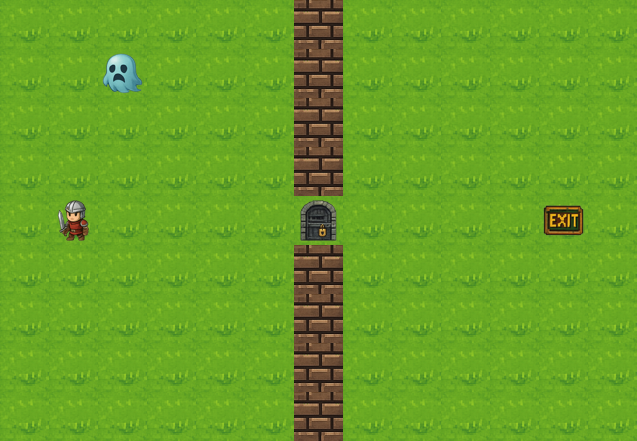

{'agent': {'effects': (),
           'health': {'health': 5, 'max_health': 5},
           'inventory': ()},
 'config': {'height': 9,
            'move_fn': 'default_move_fn',
            'objective_fn': 'exit_objective_fn',
            'seed': 1,
            'turn_limit': 50,
            'width': 13},
 'message': '',
 'status': {'phase': 'ongoing', 'score': 0, 'turn': 0}}
Objective function string: exit_objective_fn

--- Underlying env.state ---
Plaintext objective string: exit_objective_fn
The underlying `Level` object is:
Level(width=13,
      height=9,
      move_fn=<function default_move_fn at 0x10eb6b6a0>,
      objective_fn=<function exit_objective_fn at 0x10eb78680>,
      seed=1,
      grid=[...],
      turn=0,
      score=0,
      win=False,
      lose=False,
      message=None,
      turn_limit=50)


In [78]:
from PIL import Image
from grid_universe.levels.convert import from_state

env = create_env(build_level_power_ghost, observation_type='image', seed=1)
state, _ = env.reset()

image = Image.fromarray(state["image"])
display(image)
pprint(state["info"])
print("Objective function string:", state["info"]["config"]["objective_fn"]) # objective function

# You can see the underlying state of the env via env.state, but your agent won't have access to this!
print("\n--- Underlying env.state ---")
print("Plaintext objective string:", env.state.objective_fn.__name__) # plaintext objective string
print("The underlying `Level` object is:") 
pprint(from_state(env.state), depth=1)

You can specify a different seed to change the appearance of a level.

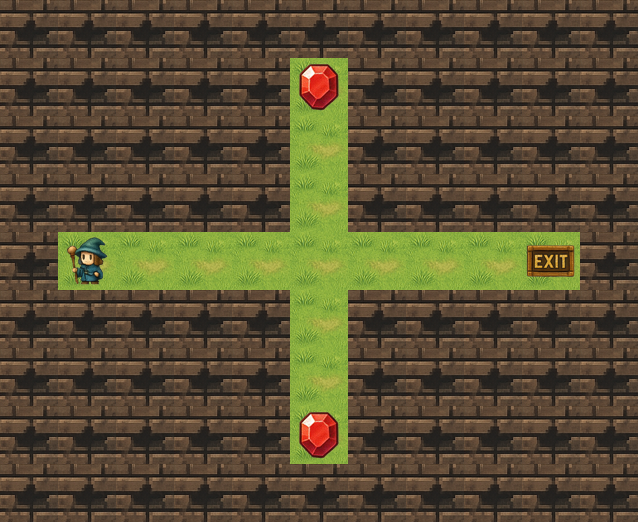

In [85]:
env = create_env(build_level_required_two, observation_type='image', seed=10)
state, _ = env.reset()

image = Image.fromarray(state["image"])
display(image)

In [88]:
# Specify a different seed to test the agent on a different looking level
for result in evaluate_all_gameplay_levels(Agent, observation_type='image', seed=list(range(1, len(GAMEPLAY_LEVEL_BUILDERS)+1))):
    print(get_result_string(result))

level_name: Level maze turns (image), performance: 1.0, total_reward: -27.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 1.61
level_name: Level optional coin (image), performance: 1.0, total_reward: -21.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 1.06
level_name: Level required one (image), performance: 1.0, total_reward: -24.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 1.63
level_name: Level required two (image), performance: 1.0, total_reward: -63.0, win: True, lose: False, timeout: True, error: False, runtime (sec): 26.74
level_name: Level key door (image), performance: 1.0, total_reward: -33.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 7.88
level_name: Level hazard detour (image), performance: 1.0, total_reward: -21.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 1.02
level_name: Level portal shortcut (image), performance: 0.9347826086956522, total_rewa

### Task 4 – Capstone

In this task, we combine multiple gameplay mechanics in one level. This is the final frontier of the mini project!

We will consider both `Level` and `Observation` observations and ciphertext objective.

Note: your agent needs to detect plaintext vs ciphertext objective. In `Observation` observation, ciphertext objective is given in `state["info"]["message"]` if the plaintext objective function in `state["info"]["config"]["objective_fn"]` is `<REDACTED>`.

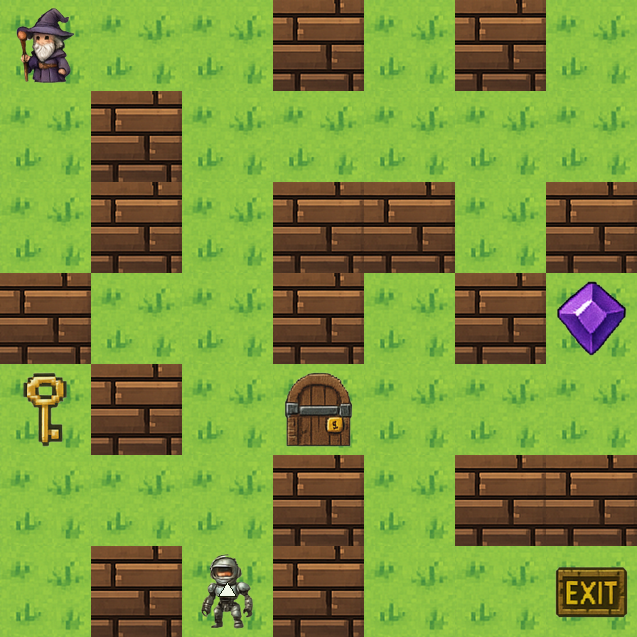

Objective function string: <REDACTED>
Ciphertext objective string: dS\jYPd?t1k:L-~d1<2M264/\FnZ83!N:onosQ8qD.Q4Q7ZdX>At"KfBh&q=tUOK*t%:>uFFT|GOUbhteQhZ\L'7A<NZhK@._c|V

--- Underlying env.state ---
Plaintext objective string: exit_objective_fn
The underlying `Level` object is:
Level(width=7,
      height=7,
      move_fn=<function default_move_fn at 0x117783420>,
      objective_fn=<function exit_objective_fn at 0x117792480>,
      seed=42,
      grid=[...],
      turn=0,
      score=0,
      win=False,
      lose=False,
      message='dS\\jYPd?t1k:L-~d1<2M264/\\FnZ83!N:onosQ8qD.Q4Q7ZdX>At"KfBh&q=tUOK*t%:>uFFT|GOUbhteQhZ\\L\'7A<NZhK@._c|V',
      turn_limit=50)


In [ ]:
env = create_cipher_env(build_level_capstone, observation_type='image', cipher_text_pairs=CIPHER_TEXT_PAIRS)
state, _ = env.reset()

image = Image.fromarray(state["image"])
display(image)
print("Objective function string:", state["info"]["config"]["objective_fn"]) # objective function (if not redacted)
print("Ciphertext objective string:", state["info"]["message"]) # ciphertext objective string

# You can see the underlying state of the env via env.state, but your agent won't have access to this!
print("\n--- Underlying env.state ---")
print("Plaintext objective string:", env.state.objective_fn.__name__) # plaintext objective string
print("The underlying `Level` object is:") 
pprint(from_state(env.state), depth=1)

In [ ]:
result = evaluate_level(Agent, build_level_capstone, observation_type='level', 
    max_total_reward=-84,
    min_total_reward=LEVEL_MIN_REWARD[build_level_capstone.__name__],
    cipher_text_pairs=CIPHER_TEXT_PAIRS, turn_limit=LEVEL_TURN_LIMIT, time_limit=CAPSTONE_TIME_LIMIT, seed=1
)
print(get_result_string(result))
result = evaluate_level(Agent, build_level_capstone, observation_type='image', 
    max_total_reward=-63,
    min_total_reward=LEVEL_MIN_REWARD[build_level_capstone.__name__],
    cipher_text_pairs=CIPHER_TEXT_PAIRS, turn_limit=LEVEL_TURN_LIMIT, time_limit=CAPSTONE_TIME_LIMIT, seed=2
)
print(get_result_string(result))

Decoded 'Nn.Ti<Imyb]|%hzYswh!*e>.qRT{eV+/$/O},(K$#*AB&(NHA_...' -> 'default'
level_name: Level capstone (level,cipher default_objective_fn), performance: 1.0, total_reward: -84.0, win: True, lose: False, timeout: False, error: False, runtime (sec): 18.69
level_name: Level capstone (image,cipher exit_objective_fn), performance: 0.0, total_reward: -150.0, win: False, lose: True, timeout: False, error: False, runtime (sec): 0.51


## Debugging Your Agent Behavior

To assist in debugging your agent, we’ve created a utility function called `show_images_interactive`. This function enables you to interactively observe the behavior of your agent during evaluation in an environment.

MatplotlibImageBrowser(fig=<Figure size 600x500 with 4 Axes>, ax_img=<Axes: title={'center': 'Score: 0, Health: 5, Action: WAIT'}>, slider=<matplotlib.widgets.Slider object at 0x32de6cec0>, btn_prev=<matplotlib.widgets.Button object at 0x32de6d2b0>, btn_next=<matplotlib.widgets.Button object at 0x31eef56d0>)

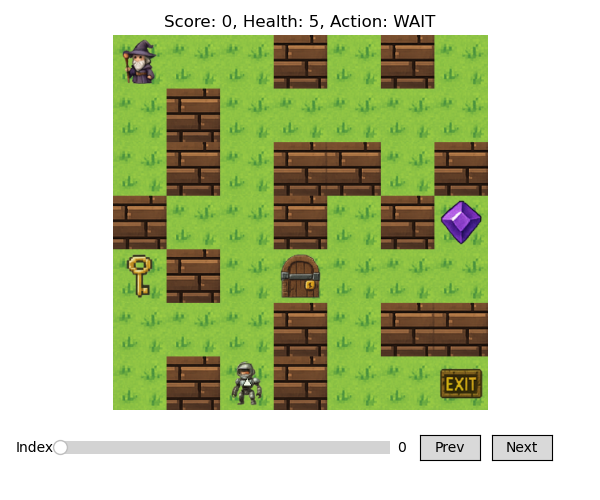

In [ ]:
%matplotlib widget

from grid_universe.renderer.texture import TextureRenderer
from utils import show_images_interactive

renderer = TextureRenderer(resolution=480)

# Specify a different seed to test the agent on a different looking level
env = create_env(build_level_capstone, observation_type='image', seed=42)
total_reward, win, lose, history = evaluate(Agent, env)
agent_id = next(iter(history[0][0].agent.keys()))
show_images_interactive(
    [renderer.render(s) for s,a in history], 
    titles=[f"Score: {s.score}, Health: {s.health[agent_id].health}, Action: {a.name}" for s,a in history]
)

## Resources and Hints

### Machine Learning

In this mini project, you'll likely need to use machine learning technique. The following resources may be helpful.

- **Scikit-learn**:

  - https://scikit-learn.org/1.4/tutorial/basic/tutorial.html
  - https://youtu.be/0B5eIE_1vpU?si=RIu4tBcpyHiySC2D

- **PyTorch**: This will be introduced in a future problem set. Here are some videos and Colab notebook to get you started:

  - https://colab.research.google.com/drive/12nQiv6aZHXNuCfAAuTjJenDWKQbIt2Mz
  - https://youtu.be/ubSsUJbLkwM?si=SPXEkZYV7CS2ZffZ
  - https://youtu.be/dsNtkT7LF8M?si=UY00ChyxNU1UNJxj

### External Computational Resources
It is useful to have access to some computing resources to run your code and train machine learning models. Two options are Google Colaboratory and the School of Computing Compute Cluster.

#### [Google Collaboratory](https://colab.research.google.com/)

Google Collaboratory, or "Colab" for short, is a free cloud-based platform provided by Google that allows you to write and run Python code using a Jupyter notebook interface. Colab provides access to a virtual machine with a GPU and sometimes even a TPU, which can speed up computation for tasks like training machine learning models. You can use Colab on your own computer without installing any software, and it provides access to a number of libraries and datasets. However, there may be limits on how much time, memory, and storage space you can use, and you may need to reauthorize your session frequently.

You may find the following video useful: https://www.youtube.com/watch?v=hZgykFahXrs .

#### [The School of Computing Compute Cluster](https://dochub.comp.nus.edu.sg/cf/guides/compute-cluster/start)
The School of Computing Compute Cluster is a set of high-performance computing resources that are available to students, faculty, and researchers affiliated with the National University of Singapore's School of Computing. The cluster consists of multiple nodes, each with its own set of CPUs, memory, and storage. You can submit jobs to the cluster using the Slurm workload manager, which allocates resources to jobs based on availability and user-specified requirements. The Compute Cluster provides significantly more computing power than Colab, with the ability to scale up to hundreds or even thousands of cores. However, you need to apply for access to the cluster, and there may be limits on the amount of resources that can be used at any given time. Additionally, using the cluster requires some technical expertise and familiarity with the Linux command line interface. Log in with your NUS account and follow the guides here: https://dochub.comp.nus.edu.sg/cf/guides/compute-cluster/start

**Quick links**:

- Accessing the Cluster: https://dochub.comp.nus.edu.sg/cf/guides/compute-cluster/access
- Slurm Cluster Information: https://dochub.comp.nus.edu.sg/cf/guides/compute-cluster/start#slurm-cluster-information
- Compute Cluster Hardware Configuration: https://dochub.comp.nus.edu.sg/cf/guides/compute-cluster/start#compute-cluster-hardware-configuration
- Slurm Quick Start Guide: https://dochub.comp.nus.edu.sg/cf/guides/compute-cluster/start#slurm-quick-start-guide
If you prefer not to use Google Colaboratory or the School of Computing Compute Cluster, you can also run your code on your own computer. However, keep in mind that your computer may not have as much processing power or memory as the other options, so your code may run more slowly and you will take more time to complete the task.

### Hardcoding Your Trained ML Model
Because Coursemology disallows arbitrary auxiliary file uploads (e.g. separate `.pth` / `.pkl` weight files), any ML models your `Agent` depends on must ship **inline inside your submission**. To make this easy (and less error‑prone than manually copying numbers), we provide two helper functions in `utils.py`:

- `generate_torch_loader_snippet(model, example_inputs=..., prefer='auto', compression='zlib')`
- `generate_sklearn_loader_snippet(model, compression='zlib')`

Each returns a fully self‑contained Python source string defining a `get_model(...)` function. You copy‑paste that function into your agent code. At runtime the function reconstructs the trained model from a Base64‑encoded (optionally compressed) blob embedded directly in the source.

Why this approach?
- No manual transcription errors (forgetting bias terms, transposing weights, etc.).
- Supports arbitrary model shapes / pipelines.
- Optional compression keeps your submission small (<2 MB limit).
- PyTorch path prioritizes TorchScript for safety and portability, then falls back gracefully.

Below we show the end‑to‑end workflow for PyTorch and scikit‑learn. We also keep (optional) manual hardcoding examples for pedagogy.

Suppose you train a model on the following data:

In [34]:
import numpy as np

X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.array([1, 8, 2, 4])

#### PyTorch

Assume you have the following simple network (we'll train it briefly, then auto‑generate a loader snippet):

In [47]:
import torch
from torch import nn

net = nn.Linear(2, 1)

Train the network:

In [36]:
def train(net: nn.Module, X: np.ndarray, y: np.ndarray):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y[:, None], dtype=torch.float32)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    for epoch in range(100):
        optimizer.zero_grad()
        output = net(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

train(net, X, y)

Option 1 (Recommended): Automatically generate a self‑contained loader snippet.

Run the following after training:

In [46]:
# Auto‑generate a loader snippet for the trained PyTorch model
from utils import generate_torch_loader_snippet

example_input = torch.tensor([[0.0, 0.0]], dtype=torch.float32)  # minimal example for tracing if needed
snippet = generate_torch_loader_snippet(net, example_inputs=example_input, prefer="auto", compression="zlib")
print(snippet)

# You would copy the FULL printed function definition (def get_model(...): ...) into your agent source code.
# Then inside Agent.__init__ you could do: self.model = get_model()


def get_model(device: str = "cpu", dtype: str | None = None):
    """
    Return a TorchScript model loaded from an embedded, base64-encoded compressed blob.
    Self-contained: no need for the original Python class.

    Args:
        device: Where to map the model (e.g., "cpu", "cuda", "cuda:0").
        dtype: Optional dtype to convert parameters/buffers to (e.g., "float32", "float16").
    """
    import base64, io, torch
    import zlib as _z; _decomp = _z.decompress
    _blob_b64 = "eNoL8GZmYWDg4GDAAHwMIgyJRckZmWWp+imJJYn6Bm5OAgxRaMC1cqn9bJd/tgHe7Bydr7pugAwC4QA85tqgmmvo5mSBYS6x4InYSjuQ3bvOhN0DWsjAgtduAQY7FLv1CrJz3JysyLY9KqqBKTk+viQfaGZ8vB6Y1svL08vNTynNSS3Wy8nMS00s4vKBUIUMmo21GhFsQIeUp2amZ5QUMiZDtMSXlmTmFHPFF6UmlWbmpMSXpOYV5xfFlxlxFTJpaESwA3UUA1UmpqcWMkO0cLnl5CeWBEMEuQpZIhiBagwKWSOYgXRyQWkhmzdTSWAhuzeDhjcjkKnhzeTNWNKRnJyfk5OaXJKZn1fM5V+UklqUmuKSmVzCVcihGVQSVMgZAQrApMzE4kKuDKDVGcwZEKMNC7kz2IAmBBbygI0sAeGODIgu3ghQWJcUJWbmZealF/J1RogB+fGZxfFppTk58UmJydnliUUp8Rn5+dmF/H6lSYUCeqBIa62d3m

Option 2 (Manual, Educational): Manually copy weights into a freshly constructed model. This is more error‑prone and not recommended for larger networks, but shown for completeness.


In [38]:
# Set precision of printing numbers to 10 d.p.
torch.set_printoptions(precision=10)
print(net.state_dict())

OrderedDict({'weight': tensor([[1.2927633524, 0.1241542920]]), 'bias': tensor([0.3302527666])})


Example output:
```python
OrderedDict([('weight', tensor([[0.1491376609, 1.3386186361]])), ('bias', tensor([0.6359716654]))])
```

Notes:
- `OrderedDict` is from the `collections` module; `tensor` is a PyTorch tensor constructor.
- Ensure you exactly match shapes and dtypes.

To hardcode manually:

In [39]:
from collections import OrderedDict
from torch import tensor

# declare the same model
model = nn.Linear(2, 1)

# Hardcode the weights from the previous step (input your values here)
coeffs = OrderedDict([('weight', tensor([[0.1491376609, 1.3386186361]])), ('bias', tensor([0.6359716654]))])

# Load the model with the hardcoded weights
model.load_state_dict(coeffs)

# The model now has the same weights as it was previously trained
X_tensor = torch.tensor(X, dtype=torch.float32)

# Check if the outputs are the same
torch.allclose(model(X_tensor), net(X_tensor))

False

#### Scikit-Learn

We'll repeat the process for scikit‑learn: train a model, then auto‑generate the loader snippet. Manual coefficient hardcoding is also shown afterward for transparency.

In [40]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.7826086956521738

Option 1 (Recommended): Automatically generate a loader snippet for the trained sklearn model.

In [41]:
# Auto‑generate a loader snippet for the trained sklearn model
from utils import generate_sklearn_loader_snippet

sk_snippet = generate_sklearn_loader_snippet(reg, compression="zlib")
print(sk_snippet)

def get_model():
    """
    Reconstruct and return a scikit-learn model from an embedded, base64-encoded compressed blob.

    Security note:
      This uses pickle-compatible loading. Only use if you trust the source.
    """
    import base64
    import pickle as _p
    import zlib as _z; _decomp = _z.decompress
    _blob_b64 = "eNpNkb9Lw0AUx/uDlKpYilJR/4K6RJ3qILbQQTASoZPbkaSX5mxyFy6XSgdBB7WFc/Kpg4ujo0t3p/4jnRzERRAnvSaivuHe43j3ed/vu1PtZpTNJCFXo66PLU51n1CVUcDa2NeRbUUYZHk/uWzhDsdRRBiFa1g7gxOoynmXCESowNzBoYCBLDgs7KNDVeUF82F352n88TB6vZIFio6YHYEpiyGLiCA9DENZosjFlogVWGEQGDmpOQy7COQijYOwryOHcayrGnPigJxDLmeBHbsu5kpG9bacOsikTpaf07zQAKklAJXboh9i1Sxz7hYMB5fQgqqRl9ltME1z70tFchgZAbaROweZbYJQTVLjFu0momYiQjuxrzYDXulv6OP73f3x5LN+8LJeextP6uBVpgBvJXk++7sYZWfpv50g9gWxOLeUvELkWAqs9HmVZjHllhpwMSWU0c+/oB7myealtqnX9A2Ibf0bEO6rQg=="
    _raw = _decomp(base64.b64decode(_blob_b64))
    model = _p.loads(_raw)
    return model



Option 2 (Manual) instead of using the generated snippet, copy the printed coefficients/intercept:

In [42]:
print(reg.coef_)
print(reg.intercept_)

[-6.   4.5]
3.75


Example (your numbers will differ):
```python
[-6.   4.5]
3.75
```
Then hardcode them:

In [43]:
model = LinearRegression()
model.coef_ = np.array([-6, 4.5])
model.intercept_ = 3.75

assert np.allclose(model.predict(X), reg.predict(X))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import image as mp_image


# Required magic to display matplotlib plots in notebooks


from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil
     

data_dir = 'data/bg' 


device = torch.device("cpu")

train_loader = torch.utils.data.DataLoader(data_dir, batch_size=4, shuffle=True)

classes = sorted(os.listdir(data_dir))
print(classes)




['boots', 'box', 'coin', 'dragon', 'exit', 'floor', 'gem', 'ghost', 'human', 'key', 'lava', 'locked', 'metalbox', 'opened', 'portal', 'robot', 'shield', 'sleeping', 'spike', 'wall', 'wolf']


In [ ]:
import os
import random
from PIL import Image
from PIL import ImageOps 

def superimpose_random_bg(foreground_rgba_path, bg_folder):
    """
    foreground_rgba_path : str  – your agent-produced 128×128 RGBA frame
    bg_folder           : str  – folder with 128×128 JPG/PNG background images
    returns             : PIL.Image – 128×128 RGB
    """
    # 1. pick a random background
    bg_files = [f for f in os.listdir(bg_folder)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not bg_files:
        raise FileNotFoundError("No images found in background folder")
    bg_path = os.path.join(bg_folder, random.choice(bg_files))
    bg = Image.open(bg_path).convert('RGB')   # RGB 128×128

    # 2. load foreground
    fg = Image.open(foreground_rgba_path).convert('RGBA')  # keep alpha

    # 3. composite (alpha is the mask)
    new_frame = Image.alpha_composite(bg.convert('RGBA'), fg).convert('RGB')

    return new_frame

def resize_image(src_image, size=(128,128)): 
    
    
    # resize the image so the longest dimension matches our target size
    return src_image.thumbnail(size, Image.LANCZOS)

In [89]:
training_folder_name = 'data/assets/imagen1'

# New location for the resized images
train_folder = 'data/bg'


# PLEASE SEE > MOVE FLOOR, LAVA AND WALL INTO DATA/NOIMPOSE, THEN RUN THIS KERNEL: SUPERIMPOSE, THEN RUN RESIZE ON FLOOR, LAVA AND WALL
noimpose = 'data/noimpose'
bg_folder = 'data/noimpose/floor'


# Create resized copies of all of the source images
size = (58,58)

# Create the output folder if it doesn't already exist


# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
           
            # Create a bg version and save it
            new_image = superimpose_random_bg(file_path, bg_folder)
            resize_image(new_image, (58,58))
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            new_image.save(saveAs)

for root, folders, files in os.walk(noimpose):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
           
            # Create a bg version and save it
            '''new_image = superimpose_random_bg(file_path, bg_folder)'''
            new_image = Image.open(file_path)
            resize_image(new_image, (58,58))
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            new_image.save(saveAs)

print('Done.')

Transforming images...
processing folder shield
processing folder opened
processing folder portal
processing folder box
processing folder boots
processing folder locked
processing folder sleeping
processing folder key
processing folder robot
processing folder ghost
processing folder metalbox
processing folder wolf
processing folder coin
processing folder dragon
processing folder exit
processing folder spike
processing folder human
processing folder gem
processing folder wall
processing folder lava
processing folder floor
Done.


In [68]:
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader




#####################################################################################################




# Recall that we have resized the images and saved them into
train_folder = 'data/bg'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size

In [ ]:
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 6 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 6 input channels, and generates 9 outputs
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 58/2/2 is 14.
        # This means that our feature tensors are now 14 x 14, and we've generated 9 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
       
        self.fc = nn.Linear(in_features=14 * 14 * 9, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
       
        x = x.view(-1, 14 * 14 * 9)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
'''if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device'''
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=1764, out_features=21, bias=True)
)


In [70]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [71]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)

            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 0.124920
	Training batch 2 Loss: 0.019720
	Training batch 3 Loss: 0.102824
	Training batch 4 Loss: 0.121237
	Training batch 5 Loss: 0.076671
	Training batch 6 Loss: 0.002883
	Training batch 7 Loss: 0.105051
	Training batch 8 Loss: 0.003370
Training set: Average loss: 0.069585
Validation set: Average loss: 0.306819, Accuracy: 140/152 (92%)

Epoch: 2
	Training batch 1 Loss: 0.056034
	Training batch 2 Loss: 0.070149
	Training batch 3 Loss: 0.407440
	Training batch 4 Loss: 0.342236
	Training batch 5 Loss: 0.091397
	Training batch 6 Loss: 0.364142
	Training batch 7 Loss: 0.173224
	Training batch 8 Loss: 0.000119
Training set: Average loss: 0.188093
Validation set: Average loss: 0.311799, Accuracy: 138/152 (91%)

Epoch: 3
	Training batch 1 Loss: 0.156983
	Training batch 2 Loss: 0.180938
	Training batch 3 Loss: 0.031733
	Training batch 4 Loss: 0.532134
	Training batch 5 Loss: 0.028046
	Training batch 6 Loss: 0.216599
	Training batch 7 Loss: 0.1

In [75]:
image_snip = generate_torch_loader_snippet(model, example_inputs=example_input, prefer="auto", compression="zlib")

print(image_snip)

def get_model(device: str = "cpu", dtype: str | None = None):
    """
    Return a TorchScript model loaded from an embedded, base64-encoded compressed blob.
    Self-contained: no need for the original Python class.

    Args:
        device: Where to map the model (e.g., "cpu", "cuda", "cuda:0").
        dtype: Optional dtype to convert parameters/buffers to (e.g., "float32", "float16").
    """
    import base64, io, torch
    import zlib as _z; _decomp = _z.decompress
    _blob_b64 = "eNqUd3c41+HbthQle2uIRNmrFL73/YlSKUSl0CIaJO2JsveoyCybkJFRwvdzXR8ZaaKhKBpaSoWSSuvt9/73vM9xPO/7Xsdx/X2f93Gc1zkcbMZPEBCYNEngv42EgJzAlv0enl6Htxls3XJwi4Hh0kVSAuv/j8ksOcJuzFxJJzafpr2rT5KABTpU+UE0So4uxTSLCDgVshZjn60n3luP0ML4X7RE2AB3/r4Eh40/EievHlDMzqbddaXgNLSE6bb7QM0NU6HMroKJtl8GqZY+zP3JesySU+sYn/wFzOs9VfCgwwW7X0diZac35htFYrrpcZzyh0XHmTHoz5ai/9qVuMB7B9aRi/CsahCz3liiceMdOBl+DScF/sLHf6vwscwo9GluZZ671PEWNszDvT/G4fHVhtS+LIUKPBTBo9obGIn75WgdZsIcGqhkDkgYoUJOPnNu+AGTefcYq/r3JhN2JJZ5UHMRarrEQDc3nRk61Mse5j8A2y9eTIaCHo

In [76]:
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
with torch.no_grad():
    for data, target in test_loader:
        preds = model(data).argmax(1).cpu().numpy()
        for t, p in zip(target.numpy(), preds):
            truelabels.append(classes[t])
            predictions.append(classes[p])


# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

print(truelabels)
print(predictions)

'''df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()'''

Getting predictions from test set...
['metalbox', 'exit', 'spike', 'human', 'box', 'robot', 'dragon', 'ghost', 'wolf', 'box', 'key', 'opened', 'exit', 'gem', 'boots', 'metalbox', 'sleeping', 'exit', 'robot', 'locked', 'coin', 'human', 'floor', 'dragon', 'portal', 'human', 'wall', 'portal', 'gem', 'opened', 'robot', 'sleeping', 'wolf', 'locked', 'sleeping', 'floor', 'portal', 'gem', 'wolf', 'lava', 'portal', 'wall', 'ghost', 'lava', 'robot', 'shield', 'wolf', 'exit', 'exit', 'locked', 'dragon', 'wall', 'dragon', 'sleeping', 'opened', 'wolf', 'spike', 'gem', 'ghost', 'wolf', 'sleeping', 'sleeping', 'gem', 'dragon', 'ghost', 'floor', 'wolf', 'ghost', 'sleeping', 'gem', 'exit', 'lava', 'box', 'spike', 'dragon', 'human', 'wolf', 'shield', 'coin', 'dragon', 'opened', 'opened', 'coin', 'lava', 'wolf', 'exit', 'boots', 'dragon', 'portal', 'dragon', 'locked', 'wall', 'human', 'sleeping', 'wolf', 'floor', 'robot', 'lava', 'human', 'boots', 'robot', 'coin', 'spike', 'coin', 'spike', 'lava', 'coin

'df_cm = pd.DataFrame(cm, index = classes, columns = classes)\nplt.figure(figsize = (7,7))\nsns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt=\'g\')\nplt.xlabel("Predicted Shape", fontsize = 20)\nplt.ylabel("True Shape", fontsize = 20)\nplt.show()'